# 0 Project Barley

Along this project we will work on various Barley's cultivar starting from Hv_Morex. The aim of this project is to further understand the importance of introns within genes and within Untranslated Regions (UTRs) and their differences. 

Another not secondary objective is to build a pipeline as much reproducible as possible. This notebook is meant to give readers a crystal clear view of how we proceeded to implement our work. 

All the work has been performed on a Linux machine running _Ubuntu 20.04.2 LTS x86_64_.

# 1 Working environment

**Before running the notebook** be sure to activate the conda environment shared with you:
- $ conda activate Pedroni_Thesis.yml

In [1]:
### --- This command can be installed with: $ sudo apt-get install neofetch
### --- It is used to show the software/hardware characteristics of the machine used to complete this project.
! neofetch | grep "OS\|Shell\|DE\|CPU\|GPU\|Memory"

OS: Ubuntu 20.04.3 LTS x86_64 
Shell: bash 5.0.17 
DE: GNOME 
CPU: Intel i7-7700HQ (1) @ 2.807GHz 
GPU: 00:02.0 VMware SVGA II Adapter 
Memory: 1254MiB / 7959MiB 


In [2]:
### --- This command can be installed using 
### --- This command is used to show you how directories should be organized to better be able to follow this work.
### --- The root directory of this project is called 'Project Barley'
! tree -d

.
├── Data
│   └── raw
├── Output
└── Scripts
    └── script_out

5 directories


# 2 Implementing an intron analysis on data from a long-read sequence assembly in Barley

The study I am referring to can be found [here](https://academic.oup.com/plcell/advance-article/doi/10.1093/plcell/koab077/6169005) while all the data can be found [here](https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/21172880-2956-4cbb-ab2c-5c00bceb08a2/0). 

## 2.1 Hv_Morex HC

### 2.1.1 Collecting Data

In [3]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3 https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/2492a5a9-08a8-4022-b6ad-9b056a00f64f/1/DOWNLOAD

--2021-10-01 12:02:23--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/2492a5a9-08a8-4022-b6ad-9b056a00f64f/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59307477 (57M) [text/plain]
Saving to: ‘Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3’

Data/raw/Hv_Morex.p 100%[===================>]  56,56M  2,83MB/s    in 26s     

2021-10-01 12:02:50 (2,15 MB/s) - ‘Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3’ saved [59307477/59307477]



### 2.1.2 Processing data

In [4]:
### --- Importing the libraries needed to handle data and visualize them
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hv_Morex.pgsb.Jul2020.HC.gff3  > Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3

In [6]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv

In [7]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hv_MorexHC = pd.read_csv('Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030
1,chr1H,pgsb,mRNA,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1
2,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
3,chr1H,pgsb,CDS,76744,77373,.,+,0,ID=HORVU.MOREX.r3.1HG0000030.1.CDS1
4,chr1H,pgsb,gene,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040


In [8]:
### --- Building a separate dataframe containing all exons
exon_Hv_MorexHC = df_Hv_MorexHC.loc[df_Hv_MorexHC['type'].isin(['exon'])]
exon_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
7,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1
9,chr1H,pgsb,exon,79063,79104,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon2
11,chr1H,pgsb,exon,79609,79676,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon3
13,chr1H,pgsb,exon,79757,79799,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon4


In [9]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hv_MorexHC.to_csv('Data/Hv_MorexHC_exon.tsv',sep='\t',index=False,header=False)

In [10]:
### --- Keeping in a separated dataframe the forward strands
forw_Hv_MorexHC = df_Hv_MorexHC.loc[df_Hv_MorexHC['strand'].isin(['+'])]
forw_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030
1,chr1H,pgsb,mRNA,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1
2,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
3,chr1H,pgsb,CDS,76744,77373,.,+,0,ID=HORVU.MOREX.r3.1HG0000030.1.CDS1
48,chr1H,pgsb,gene,132221,138736,.,+,.,ID=HORVU.MOREX.r3.1HG0000060


In [11]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hv_MorexHC = df_Hv_MorexHC.loc[df_Hv_MorexHC['strand'].isin(['-'])]
rev_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
4,chr1H,pgsb,gene,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040
5,chr1H,pgsb,mRNA,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1
6,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
7,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1
8,chr1H,pgsb,CDS,78511,78954,.,-,0,ID=HORVU.MOREX.r3.1HG0000040.1.CDS1


In [12]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hv_MorexHC = forw_Hv_MorexHC.loc[df_Hv_MorexHC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
50,chr1H,pgsb,five_prime_UTR,132221,132375,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.five_prime_UTR1
93,chr1H,pgsb,three_prime_UTR,138505,138736,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.three_prime_UTR2
97,chr1H,pgsb,five_prime_UTR,146607,146749,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.five_prime_UTR1
98,chr1H,pgsb,five_prime_UTR,146981,146996,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.five_prime_UTR2
103,chr1H,pgsb,three_prime_UTR,148229,148562,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.three_prime_UTR3


In [13]:
### --- Writing to a tsv formatted file the UTR_df_forw dataframe
UTR_forw_Hv_MorexHC.to_csv('Data/Hv_MorexHC_UTRforw.tsv',sep='\t',index=False,header=False)

In [14]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hv_MorexHC = rev_Hv_MorexHC.loc[df_Hv_MorexHC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hv_MorexHC.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
27,chr1H,pgsb,five_prime_UTR,81706,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.five_prime_UTR2
30,chr1H,pgsb,three_prime_UTR,84091,84317,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.three_prime_UTR1
47,chr1H,pgsb,five_prime_UTR,86846,87063,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.five_prime_UTR2
126,chr1H,pgsb,three_prime_UTR,156767,157203,.,-,.,ID=HORVU.MOREX.r3.1HG0000090.1.three_prime_UTR1


In [15]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_rev_Hv_MorexHC.to_csv('Data/Hv_MorexHC_UTRrev.tsv',sep='\t',index=False,header=False)

### 2.1.3 Extracting introns from the whole genome

In [16]:
### --- Function to extract introns from the whole genome
### --- Infile is a file like Hv_MorexHC_exon.tsv 
### --- Outfile will be written thanks to this function
### --- If there are two or more exons belonging to the same mRNA one after the other it compute the introns separating them
def extract_tot_introns(infile, outfile):
    introns = open(outfile, 'a') # Output/Hv_Morex_introns.tsv
    introns.write('ID'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'length') 
    with open(infile) as f: # Data/Hv_Morex_exon.tsv
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines): # This is to avoid out of range error
                break 
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if '.'.join(line[8].split('.')[0:5]) != '.'.join(next_line[8].split('.')[0:5]): continue # Checking if the next exon has the same ID of the one we are at
                #print('The intron coordinates at %s are from %d to %d and the intron length is %d.' % (line[8][:30], int(line[4])+1, int(next_line[3])-1, int(next_line[3])-1 - int(line[4])+1))
                introns.write('\n'+'.'.join(line[8].split('.')[0:5])+'\t'+ 'intron ' +'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    introns.close()


In [17]:
### --- Extracting introns from Hv_MorexHC
extract_tot_introns('Data/Hv_MorexHC_exon.tsv', 'Output/Hv_MorexHC_introns.tsv')

In [18]:
introns_Hv_MorexHC = pd.read_csv('Output/Hv_MorexHC_introns.tsv', sep = '\t')
introns_Hv_MorexHC[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79933,80484,553
...,...,...,...,...,...
95,ID=HORVU.MOREX.r3.1HG0000250.1,intron,604220,604743,525
96,ID=HORVU.MOREX.r3.1HG0000260.1,intron,669330,669483,155
97,ID=HORVU.MOREX.r3.1HG0000260.1,intron,669685,669841,158
98,ID=HORVU.MOREX.r3.1HG0000280.1,intron,711070,711148,80


In [19]:
### --- Function to count introns within a dataframe made of exons formatted like exon_Hv_MorexHC
### --- If I use i[:28] I consider the gene, If I use i[:31] I'm at level of mRNA
### --- Actually using 31 I would avoid the problem of certain genes having >= 10 transcripts
def counting_introns_type(in_dataframe):
    counts = dict()
    for i in in_dataframe['attributes']:
        counts['.'.join(i.split('.')[0:5])] = counts.get('.'.join(i.split('.')[0:5]), 0) + 1
    return counts

In [20]:
### --- Counting introns type in Hv_MorexHC
introns_dictionary_Hv_MorexHC = counting_introns_type(exon_Hv_MorexHC)

In [21]:
### --- Function to check intronless (no introns), intronpoor (<= 3 introns) and intron rich (> 3 introns)
### --- This division is made on the following assumption: n° introns = n° exons - 1
def splitting_introns_type(dictionary):
    intronless = 0
    intronpoor = 0
    intronrich = 0
    intronless_list = []
    intronpoor_list = []
    intronrich_list = []
    for i in dictionary:
        if dictionary[i] == 1:
            intronless += 1
            intronless_list.append(i)
        elif dictionary[i]>1 and dictionary[i]<= 4:
            intronpoor += 1
            intronpoor_list.append(i)
        elif dictionary[i] > 4:
            intronrich += 1
            intronrich_list.append(i)

    print('Intronless are: %d' % intronless)
    print('Intronpoor are: %d' % intronpoor)
    print('Intronrich are: %d' % intronrich)
    
    return (intronless, intronpoor, intronrich, intronless_list, intronpoor_list, intronrich_list)

In [22]:
n_intronless_Hv_MorexHC, n_intronpoor_Hv_MorexHC, n_intronrich_Hv_MorexHC, intronless_Hv_MorexHC, intronpoor_Hv_MorexHC, intronrich_Hv_MorexHC = splitting_introns_type(introns_dictionary_Hv_MorexHC)

Intronless are: 11537
Intronpoor are: 14027
Intronrich are: 12399


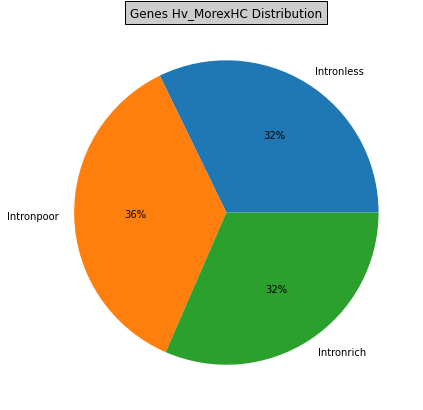

In [23]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data = [11537, 12997, 11293]
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = genes, autopct='%1.0f%%')
plt.title("Genes Hv_MorexHC Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [24]:
### --- Creating the list of Hv_MorexHC gene IDs to check the number of transcripts using command line
intronless_file = open('Output/Hv_MorexHC_intronlessIDs.txt', 'a')
intronpoor_file = open('Output/Hv_MorexHC_intronpoorIDs.txt', 'a')
intronrich_file = open('Output/Hv_MorexHC_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hv_MorexHC)):
    if i == len(intronless_Hv_MorexHC) -1:
        intronless_file.write(intronless_Hv_MorexHC[i])
    else:
        intronless_file.write(intronless_Hv_MorexHC[i] + '\n')
intronless_file.close()

for i in range(len(intronpoor_Hv_MorexHC)):
    if i == len(intronpoor_Hv_MorexHC) -1:
        intronpoor_file.write(intronpoor_Hv_MorexHC[i])
    else:
        intronpoor_file.write(intronpoor_Hv_MorexHC[i] + '\n')
intronpoor_file.close()

for i in range(len(intronrich_Hv_MorexHC)):
    if i == len(intronrich_Hv_MorexHC) -1:
        intronrich_file.write(intronrich_Hv_MorexHC[i])
    else:
        intronrich_file.write(intronrich_Hv_MorexHC[i]+'\n')
intronrich_file.close()


In [25]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hv_MorexHC = ! grep -f Output/Hv_MorexHC_intronlessIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hv_MorexHC = ! grep -f Output/Hv_MorexHC_intronpoorIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hv_MorexHC = ! grep -f Output/Hv_MorexHC_intronrichIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [26]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hv_MorexHC = int(n_mRNA_intronless_Hv_MorexHC[0])/n_intronless_Hv_MorexHC
print(avg_mRNA_intronless_Hv_MorexHC)
avg_mRNA_intronpoor_Hv_MorexHC = int(n_mRNA_intronpoor_Hv_MorexHC[0])/n_intronpoor_Hv_MorexHC
print(avg_mRNA_intronpoor_Hv_MorexHC)
avg_mRNA_intronrich_Hv_MorexHC = int(n_mRNA_intronrich_Hv_MorexHC[0])/n_intronrich_Hv_MorexHC
print(avg_mRNA_intronrich_Hv_MorexHC)

1.0
1.0
1.0


### 2.1.4 Extracting introns from UTR regions

In [27]:
### --- Function to extract introns from UTR regions.
### --- Infile is a file like Hv_Morex_UTRforw_introns.tsv 
### --- Outfile will be written thanks to this function
### --- Being all on the same strand when two or more UTRs of the same type are one row after the other it means there is a intron separating them
def extract_UTR_introns(infile, outfile):
    UTR_introns_forw = open(outfile, 'a')
    UTR_introns_forw.write('ID'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'length') # Defining the header
    with open(infile) as f:
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines):
                break
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if line[2] != next_line[2] or '.'.join(line[8].split('.')[0:5]) != '.'.join(next_line[8].split('.')[0:5]): continue
                #print('The intron coordinates at %s are from %d to %d and the intron length is %d.' % ('.'.join(line[8].split('.')[0:5]), int(line[4])+1, int(next_line[3])-1, int(next_line[3])-1 - int(line[4])+1))
                UTR_introns_forw.write('\n'+'.'.join(line[8].split('.')[0:5])+'\t'+ 'intron '+line[2]+'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    UTR_introns_forw.close()

In [28]:
### --- Extracting introns from UTR forward Hv_MorexHC
extract_UTR_introns('Data/Hv_MorexHC_UTRforw.tsv', 'Output/Hv_MorexHC_UTRforw_introns.tsv')

In [29]:
### --- Extracting introns from UTR reverse Hv_MorexHC
extract_UTR_introns('Data/Hv_MorexHC_UTRrev.tsv', 'Output/Hv_MorexHC_UTRrev_introns.tsv')

In [30]:
introns_UTR_forw_Hv_MorexHC = pd.read_csv('Output/Hv_MorexHC_UTRforw_introns.tsv', sep='\t')
introns_UTR_forw_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [31]:
introns_UTR_rev_Hv_MorexHC = pd.read_csv('Output/Hv_MorexHC_UTRrev_introns.tsv', sep = '\t')
introns_UTR_rev_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000130.1,intron three_prime_UTR,377002,377104,104
1,ID=HORVU.MOREX.r3.1HG0000350.1,intron five_prime_UTR,1156130,1159354,3226
2,ID=HORVU.MOREX.r3.1HG0001120.1,intron five_prime_UTR,2577943,2580334,2393
3,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3193629,3198818,5191
4,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3198962,3199088,128


In [32]:
### --- Concatenating the UTR_introns to build a unique dataframe
frames = [introns_UTR_forw_Hv_MorexHC, introns_UTR_rev_Hv_MorexHC]
introns_UTR_Hv_MorexHC = pd.concat(frames)

In [33]:
### --- Setting figure and font size
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["font.size"] = 15

In [34]:
### --- Performing some basic statistics 
introns_UTR_Hv_MorexHC['length'].describe()

count     5049.000000
mean       914.958210
std       2505.112829
min         33.000000
25%        121.000000
50%        406.000000
75%        943.000000
max      74239.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

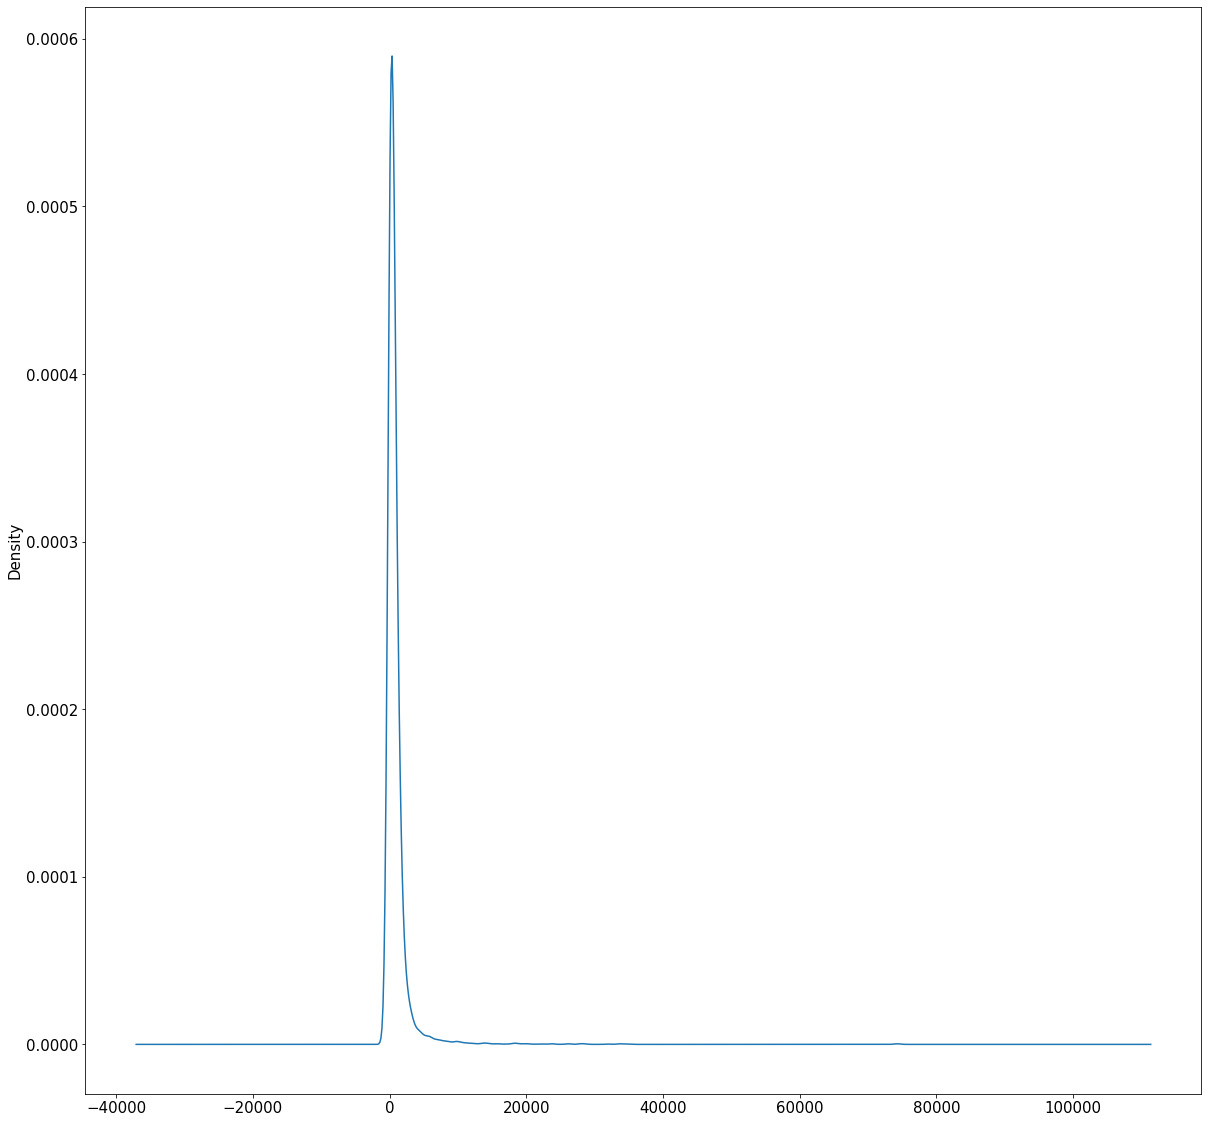

In [35]:
### --- Plotting the distribution of UTR introns length
introns_UTR_Hv_MorexHC['length'].plot.density()

<AxesSubplot:>

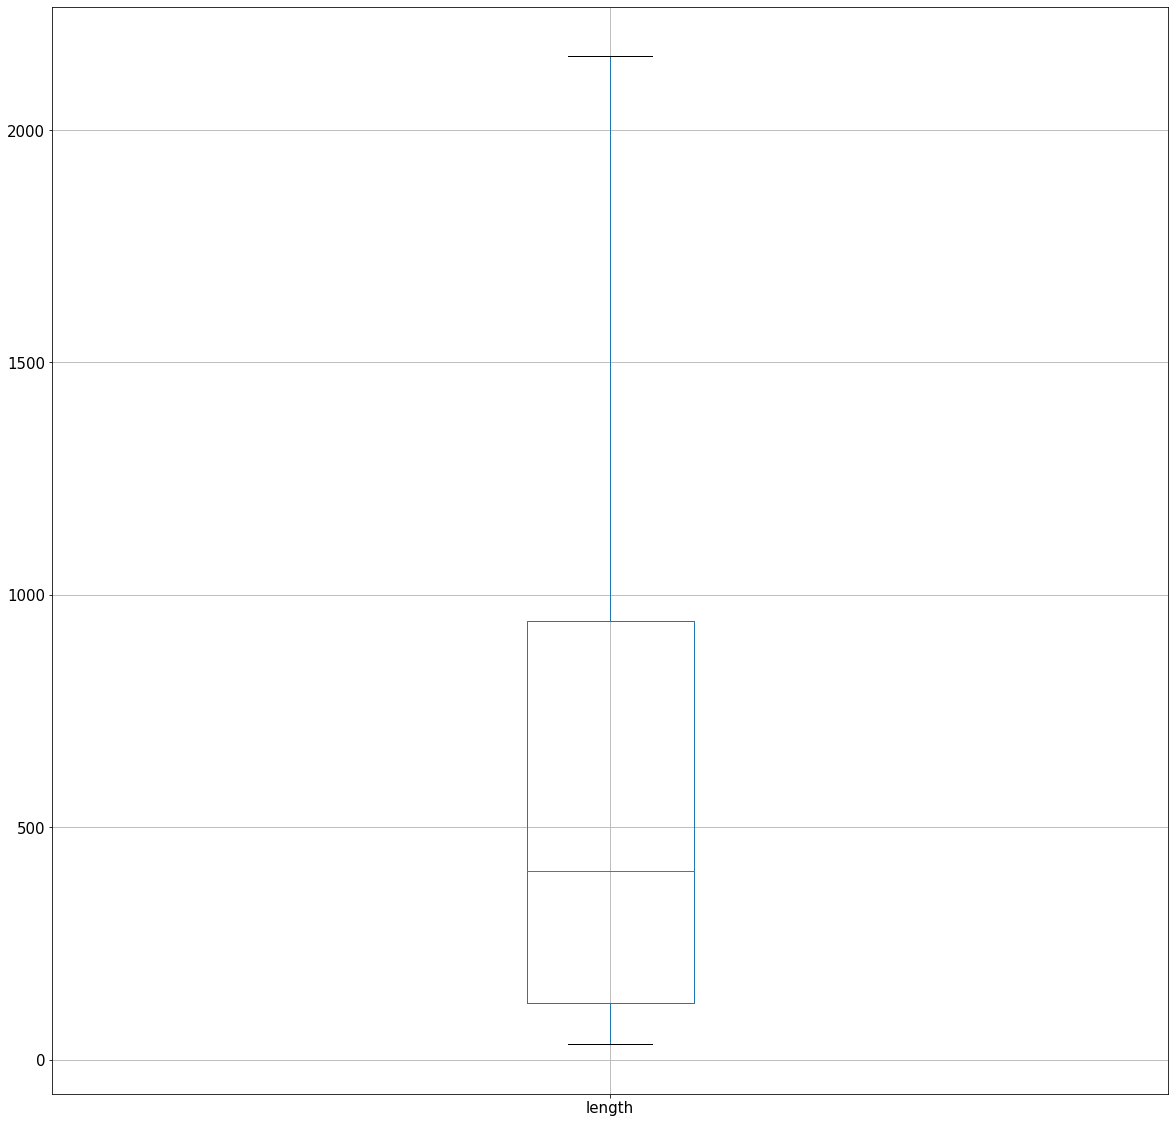

In [36]:
### --- Plotting the boxplot of UTR introns length without outliers
introns_UTR_Hv_MorexHC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

In [37]:
### --- splitting in introns 3'UTR and 5'UTR to eventually if there are differences among the two
introns_UTR3_Hv_MorexHC = introns_UTR_Hv_MorexHC.loc[introns_UTR_Hv_MorexHC['type'].isin(['intron three_prime_UTR'])]
introns_UTR5_Hv_MorexHC = introns_UTR_Hv_MorexHC.loc[introns_UTR_Hv_MorexHC['type'].isin(['intron five_prime_UTR'])]


In [38]:
introns_UTR3_Hv_MorexHC

,ID,type,start,end,length
11,ID=HORVU.MOREX.r3.1HG0003090.2,intron three_prime_UTR,5946475,5974459,27986
12,ID=HORVU.MOREX.r3.1HG0003090.6,intron three_prime_UTR,5946475,5974459,27986
24,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14661381,14662100,721
25,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14662182,14662301,121
27,ID=HORVU.MOREX.r3.1HG0007370.2,intron three_prime_UTR,15093762,15093878,118
...,...,...,...,...,...
2406,ID=HORVU.MOREX.r3.7HG0748130.1,intron three_prime_UTR,620827612,620827821,211
2407,ID=HORVU.MOREX.r3.7HG0749430.1,intron three_prime_UTR,623175384,623176311,929
2408,ID=HORVU.MOREX.r3.7HG0749440.1,intron three_prime_UTR,623212429,623212835,408
2412,ID=HORVU.MOREX.r3.7HG0749980.1,intron three_prime_UTR,624202455,624203734,1281


In [39]:
introns_UTR3_Hv_MorexHC['length'].describe()

count     1632.000000
mean      1001.586397
std       3572.896832
min         33.000000
25%         99.000000
50%        196.000000
75%        750.500000
max      74239.000000
Name: length, dtype: float64

In [40]:
introns_UTR5_Hv_MorexHC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117
...,...,...,...,...,...
2416,ID=HORVU.MOREX.r3.7HG0751310.1,intron five_prime_UTR,627322202,627322296,96
2417,ID=HORVU.MOREX.r3.7HG0752050.1,intron five_prime_UTR,628813527,628813619,94
2419,ID=HORVU.MOREX.r3.7HG0752950.1,intron five_prime_UTR,632146924,632147308,386
2420,ID=HORVU.MOREX.r3.UnG0753140.1,intron five_prime_UTR,475717,475945,230


In [41]:
introns_UTR5_Hv_MorexHC['length'].describe()

count     3417.000000
mean       873.583553
std       1781.409570
min         41.000000
25%        150.000000
50%        511.000000
75%        997.000000
max      34933.000000
Name: length, dtype: float64

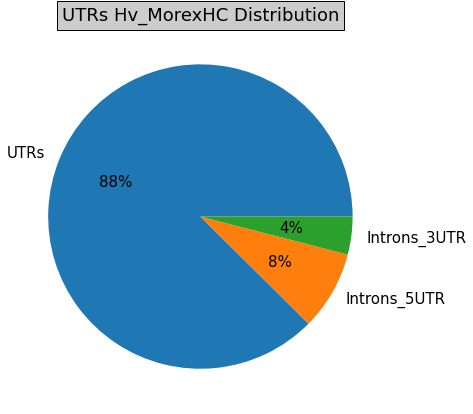

In [42]:
### --- Plotting the distribution of introns_UTR vs total UTRs
labels_Hv_MorexHC = ['UTRs', 'Introns_5UTR', 'Introns_3UTR']
UTR_data_Hv_MorexHC = [ 20666+19938-(3417+1632), 3417, 1632]
fig = plt.figure(figsize =(10, 7))
plt.pie(UTR_data_Hv_MorexHC, labels = labels_Hv_MorexHC, autopct='%1.0f%%')
plt.title("UTRs Hv_MorexHC Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

### 2.1.5 Removing UTR introns from the whole introns dataframe

In [43]:
### --- Checking total introns dataframe 
introns_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79933,80484,553


In [44]:
### --- Checking UTR introns dataframe
introns_UTR_Hv_MorexHC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [45]:
### --- Function to create remove from the total introns the one within UTRs and create a dataframe with introns within cds
### --- The indataframe must be formatted like introns_Hv_MorexHC
### --- The assumption is to use pd.concat() to concatenate the two dataframes and then drop the duplicates
def cds_introns_dataframe(indataframe1, indataframe2):
    total_introns_df = pd.concat([indataframe1,indataframe2])
    #print(len(total_introns_df))
    #print(len(introns_UTR))
    #print(len(introns_df))
    #print(len(total_introns_df.drop_duplicates(['ID','start','end'],keep=False))) 
    introns_cds_df = total_introns_df.drop_duplicates(['ID','start','end'],keep=False)
    return introns_cds_df

In [46]:
### --- Extracting introns from cds within Hv_MorexHC
introns_cds_Hv_MorexHC = cds_introns_dataframe(introns_Hv_MorexHC, introns_UTR_Hv_MorexHC)
introns_cds_Hv_MorexHC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79933,80484,553
...,...,...,...,...,...
131226,ID=HORVU.MOREX.r3.UnG0816010.1,intron,28860551,28860786,237
131227,ID=HORVU.MOREX.r3.UnG0816010.1,intron,28861622,28861672,52
131228,ID=HORVU.MOREX.r3.UnG0816040.1,intron,28867800,28867889,91
131229,ID=HORVU.MOREX.r3.UnG0816160.1,intron,28884605,28884809,206


In [47]:
### --- Checking if there are not introns UTR within the created dataframe
introns_cds_Hv_MorexHC.loc[introns_cds_Hv_MorexHC['type'].isin(['intron three_prime_UTR','intron five_prime_UTR'])]

,ID,type,start,end,length


In [48]:
### --- Basic statistics of Hv_MorexHC introns cds
introns_cds_Hv_MorexHC['length'].describe()

count    126182.000000
mean        565.209444
std        2222.947337
min          22.000000
25%          94.000000
50%         131.000000
75%         439.000000
max      234533.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

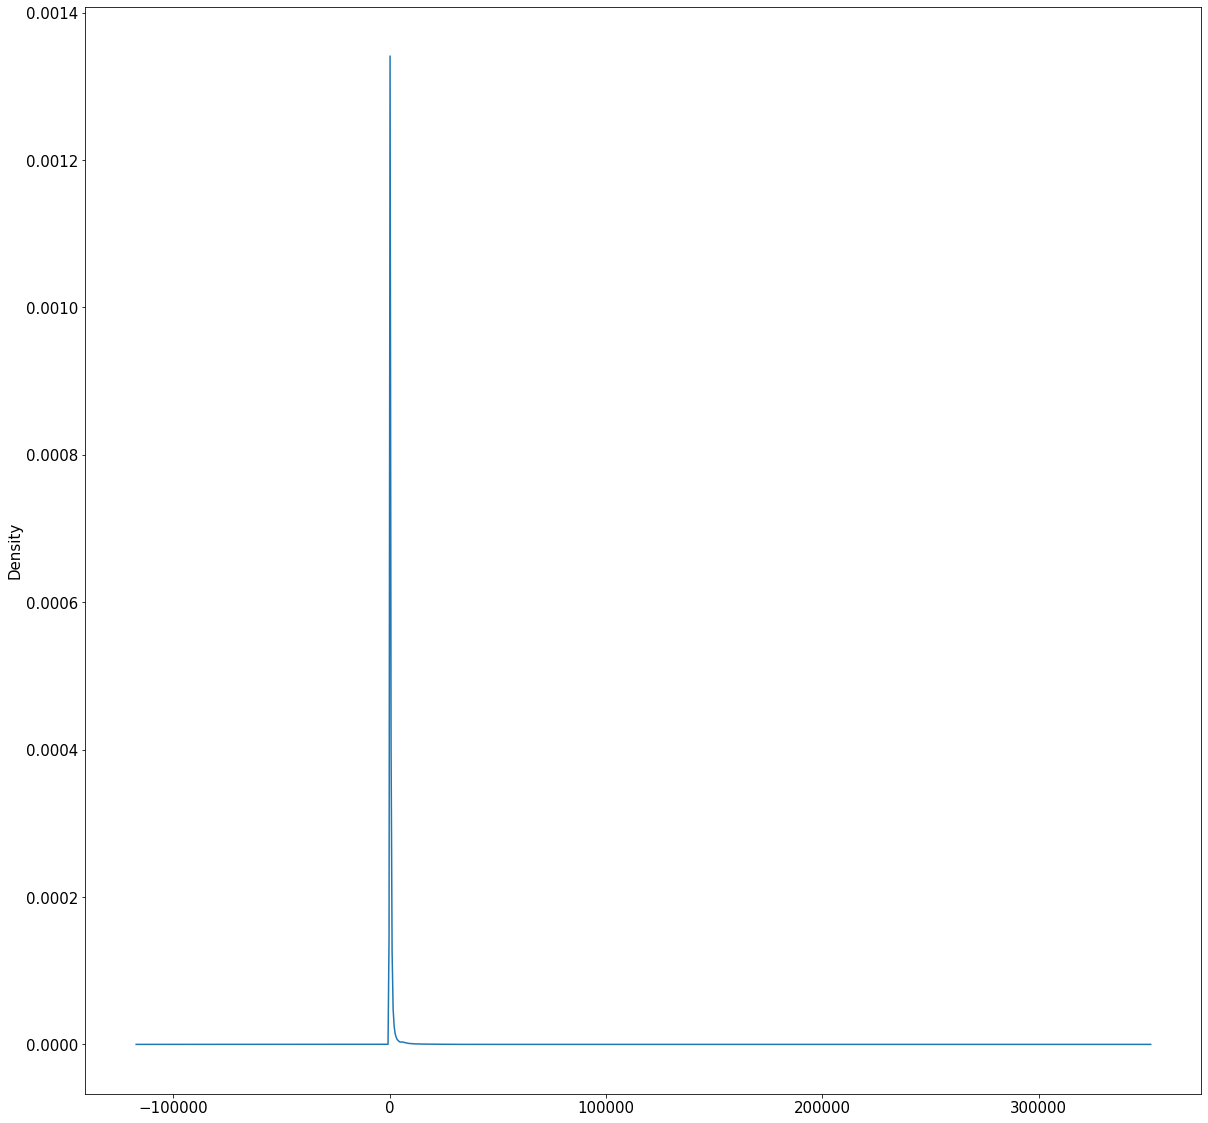

In [49]:
### --- Plotting the distribution of Hv_MorexHC cds introns length
introns_cds_Hv_MorexHC['length'].plot.density()

<AxesSubplot:>

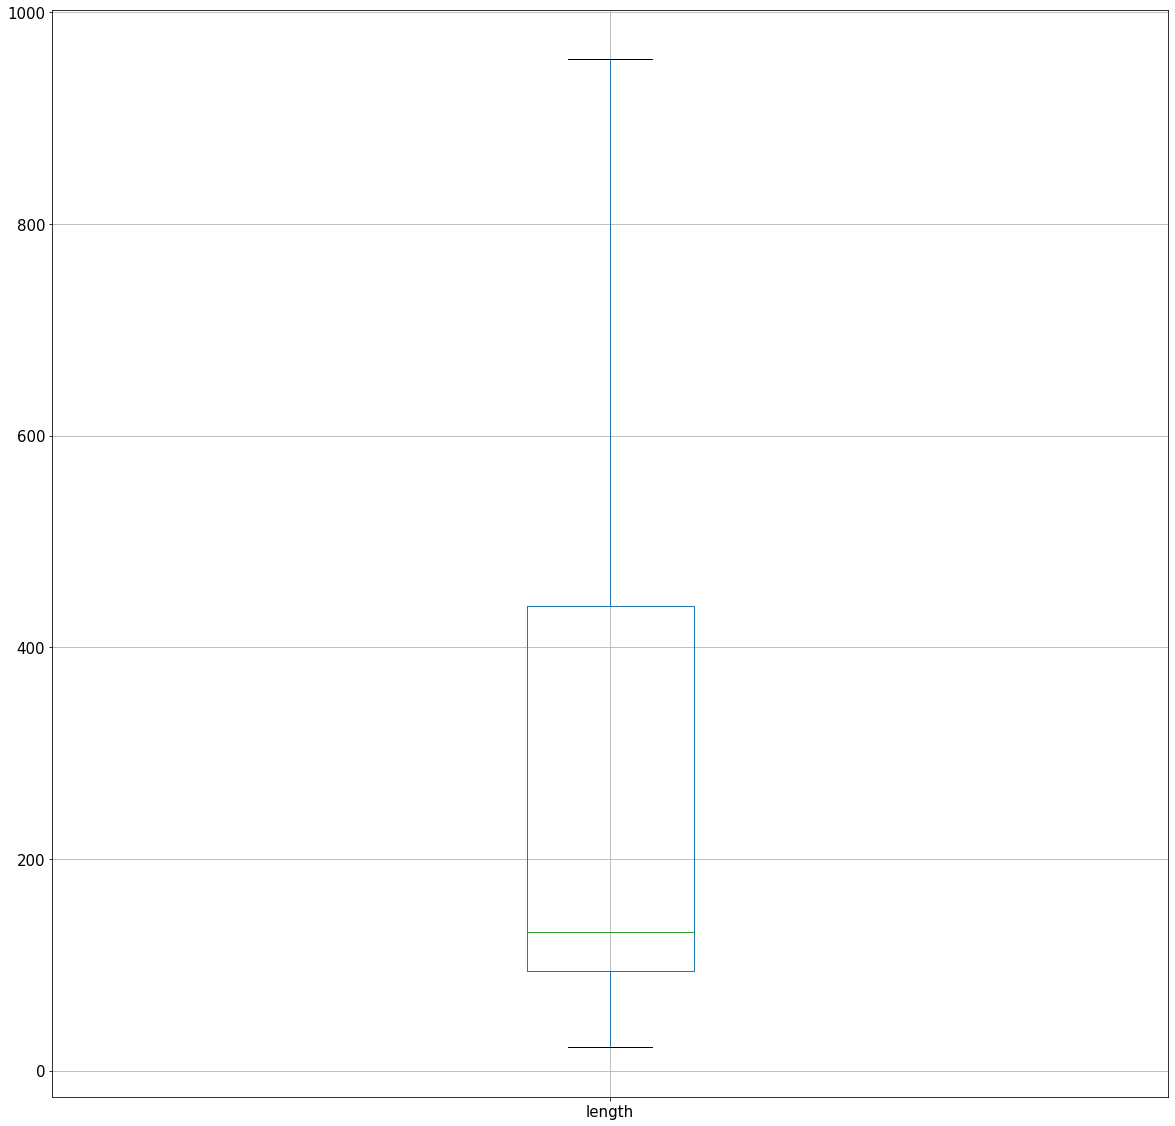

In [50]:
### --- Plotting the boxplot of Hv_MorexHC cds introns length without outliers
introns_cds_Hv_MorexHC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 2.1.6 Re-organizing files and directories

In [51]:
! ls Data/

Hv_MorexHC_exon.tsv	Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_MorexHC_UTRforw.tsv	Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_MorexHC_UTRrev.tsv	raw


In [52]:
! mkdir Data/Hv_Morex_longread

In [53]:
! mv Data/Hv_MorexHC* Data/Hv_Morex_longread/

In [54]:
! ls Data/Hv_Morex_longread/

Hv_MorexHC_exon.tsv  Hv_MorexHC_UTRforw.tsv  Hv_MorexHC_UTRrev.tsv


In [55]:
! ls Output/

Hv_MorexHC_intronlessIDs.txt  Hv_MorexHC_introns.tsv
Hv_MorexHC_intronpoorIDs.txt  Hv_MorexHC_UTRforw_introns.tsv
Hv_MorexHC_intronrichIDs.txt  Hv_MorexHC_UTRrev_introns.tsv


In [56]:
! mkdir Output/Hv_Morex_longread

In [57]:
! mv Output/Hv_MorexHC* Output/Hv_Morex_longread

In [58]:
! ls Output/Hv_Morex_longread/

Hv_MorexHC_intronlessIDs.txt  Hv_MorexHC_introns.tsv
Hv_MorexHC_intronpoorIDs.txt  Hv_MorexHC_UTRforw_introns.tsv
Hv_MorexHC_intronrichIDs.txt  Hv_MorexHC_UTRrev_introns.tsv


# 2.2 Reproducing on Hv_Morex LC

### 2.2.1 Collecting Data

In [59]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3 https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/e27077bd-fa0b-4c20-ba87-5c84b9d0641c/1/DOWNLOAD

--2021-10-01 12:03:32--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/e27077bd-fa0b-4c20-ba87-5c84b9d0641c/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36401810 (35M) [text/plain]
Saving to: ‘Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3’

Data/raw/Hv_Morex.p 100%[===================>]  34,71M  2,17MB/s    in 21s     

2021-10-01 12:03:53 (1,67 MB/s) - ‘Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3’ saved [36401810/36401810]



### 2.2.2 Processing Data

In [60]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [61]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hv_Morex.pgsb.Jul2020.LC.gff3  > Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3

In [62]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv

In [63]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hv_MorexLC = pd.read_csv('Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [64]:
### --- Building a separate dataframe containing all exons
exon_Hv_MorexLC = df_Hv_MorexLC.loc[df_Hv_MorexLC['type'].isin(['exon'])]
exon_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
6,chr1H,pgsb,exon,50195,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon2
10,chr1H,pgsb,exon,53979,54323,.,+,.,ID=HORVU.MOREX.r3.1HG0000020.1.exon1
15,chr1H,pgsb,exon,161529,162712,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.exon1
17,chr1H,pgsb,exon,162818,163068,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.exon2


In [65]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hv_MorexLC.to_csv('Data/Hv_MorexLC_exon.tsv',sep='\t',index=False,header=False)

In [66]:
### --- Keeping in a separated dataframe the forward strands
forw_Hv_MorexLC = df_Hv_MorexLC.loc[df_Hv_MorexLC['strand'].isin(['+'])]
forw_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [67]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hv_MorexLC = df_Hv_MorexLC.loc[df_Hv_MorexLC['strand'].isin(['-'])]
rev_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
12,chr1H,pgsb,gene,161529,166657,.,-,.,ID=HORVU.MOREX.r3.1HG0000100
13,chr1H,pgsb,mRNA,161529,166657,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1
14,chr1H,pgsb,three_prime_UTR,161529,161892,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.three_prime_UTR1
15,chr1H,pgsb,exon,161529,162712,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.exon1
16,chr1H,pgsb,CDS,161893,162712,.,-,1,ID=HORVU.MOREX.r3.1HG0000100.1.CDS1


In [68]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hv_MorexLC = forw_Hv_MorexLC.loc[df_Hv_MorexLC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
7,chr1H,pgsb,three_prime_UTR,50428,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.three_prime_UTR2
693,chr1H,pgsb,five_prime_UTR,7942206,7942870,.,+,.,ID=HORVU.MOREX.r3.1HG0003730.1.five_prime_UTR1
1826,chr1H,pgsb,three_prime_UTR,16128825,16128956,.,+,.,ID=HORVU.MOREX.r3.1HG0007720.1.three_prime_UTR1
2009,chr1H,pgsb,five_prime_UTR,17860934,17860983,.,+,.,ID=HORVU.MOREX.r3.1HG0008240.1.five_prime_UTR1


In [69]:
### --- Writing to a tsv formatted file the UTR_df_forw dataframe
UTR_forw_Hv_MorexLC.to_csv('Data/Hv_MorexLC_UTRforw.tsv',sep='\t',index=False,header=False)

In [70]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hv_MorexLC = rev_Hv_MorexLC.loc[df_Hv_MorexLC['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hv_MorexLC.head()

,chr,source,type,start,end,score,strand,phase,attributes
14,chr1H,pgsb,three_prime_UTR,161529,161892,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.three_prime_UTR1
23,chr1H,pgsb,five_prime_UTR,166559,166657,.,-,.,ID=HORVU.MOREX.r3.1HG0000100.1.five_prime_UTR2
496,chr1H,pgsb,three_prime_UTR,5367715,5367998,.,-,.,ID=HORVU.MOREX.r3.1HG0002620.1.three_prime_UTR1
500,chr1H,pgsb,five_prime_UTR,5370295,5370423,.,-,.,ID=HORVU.MOREX.r3.1HG0002620.1.five_prime_UTR2
704,chr1H,pgsb,five_prime_UTR,7998340,7998963,.,-,.,ID=HORVU.MOREX.r3.1HG0003750.1.five_prime_UTR1


In [71]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_rev_Hv_MorexLC.to_csv('Data/Hv_MorexLC_UTRrev.tsv',sep='\t',index=False,header=False)

### 2.2.3 Extracting introns from the whole genome

In [72]:
### --- Extracting introns from Hv_MorexLC
extract_tot_introns('Data/Hv_MorexLC_exon.tsv', 'Output/Hv_MorexLC_introns.tsv')

In [73]:
introns_Hv_MorexLC = pd.read_csv('Output/Hv_MorexLC_introns.tsv', sep = '\t')
introns_Hv_MorexLC[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000100.1,intron,162713,162817,106
2,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163069,163164,97
3,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163386,166230,2846
4,ID=HORVU.MOREX.r3.1HG0000120.1,intron,190996,191280,286
...,...,...,...,...,...
95,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8818290,8818371,83
96,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8818465,8818552,89
97,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8818763,8818850,89
98,ID=HORVU.MOREX.r3.1HG0004090.1,intron,8819105,8819191,88


In [74]:
### --- Counting introns type in Hv_MorexHC
introns_dictionary_Hv_MorexLC = counting_introns_type(exon_Hv_MorexLC)

In [75]:
n_intronless_Hv_MorexLC, n_intronpoor_Hv_MorexLC, n_intronrich_Hv_MorexLC, intronless_Hv_MorexLC, intronpoor_Hv_MorexLC, intronrich_Hv_MorexLC = splitting_introns_type(introns_dictionary_Hv_MorexLC)

Intronless are: 34638
Intronpoor are: 9504
Intronrich are: 1885


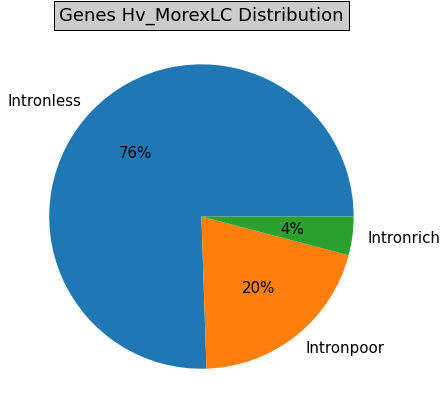

In [76]:
data_Hv_MorexLC = [34638, 9345, 1877]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Hv_MorexLC, labels = genes, autopct='%1.0f%%')
plt.title("Genes Hv_MorexLC Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [77]:
### --- Creating the list of Hv_MorexLC gene IDs to check the number of transcripts using command line
intronless_file_Hv_Morex_LC = open('Output/Hv_MorexLC_intronlessIDs.txt', 'a')
intronpoor_file_Hv_Morex_LC = open('Output/Hv_MorexLC_intronpoorIDs.txt', 'a')
intronrich_file_Hv_Morex_LC = open('Output/Hv_MorexLC_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hv_MorexLC)):
    if i == len(intronless_Hv_MorexLC) -1:
        intronless_file_Hv_Morex_LC.write(intronless_Hv_MorexLC[i])
    else:
        intronless_file_Hv_Morex_LC.write(intronless_Hv_MorexLC[i] + '\n')
intronless_file_Hv_Morex_LC.close()

for i in range(len(intronpoor_Hv_MorexLC)):
    if i == len(intronpoor_Hv_MorexLC) -1:
        intronpoor_file_Hv_Morex_LC.write(intronpoor_Hv_MorexLC[i])
    else:
        intronpoor_file_Hv_Morex_LC.write(intronpoor_Hv_MorexLC[i] + '\n')
intronpoor_file_Hv_Morex_LC.close()

for i in range(len(intronrich_Hv_MorexLC)):
    if i == len(intronrich_Hv_MorexLC) -1:
        intronrich_file_Hv_Morex_LC.write(intronrich_Hv_MorexLC[i])
    else:
        intronrich_file_Hv_Morex_LC.write(intronrich_Hv_MorexLC[i]+'\n')
intronrich_file_Hv_Morex_LC.close()


In [78]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hv_MorexLC = ! grep -f Output/Hv_MorexLC_intronlessIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hv_MorexLC = ! grep -f Output/Hv_MorexLC_intronpoorIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hv_MorexLC = ! grep -f Output/Hv_MorexLC_intronrichIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [79]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hv_MorexLC = int(n_mRNA_intronless_Hv_MorexLC[0])/n_intronless_Hv_MorexLC
print(avg_mRNA_intronless_Hv_MorexLC)
avg_mRNA_intronpoor_Hv_MorexLC = int(n_mRNA_intronpoor_Hv_MorexLC[0])/n_intronpoor_Hv_MorexLC
print(avg_mRNA_intronpoor_Hv_MorexLC)
avg_mRNA_intronrich_Hv_MorexLC = int(n_mRNA_intronrich_Hv_MorexLC[0])/n_intronrich_Hv_MorexLC
print(avg_mRNA_intronrich_Hv_MorexLC)

1.0
1.0
1.0


### 2.2.4 Extracting introns from UTR regions

In [80]:
### --- Extracting introns from UTR forward Hv_MorexLC
extract_UTR_introns('Data/Hv_MorexLC_UTRforw.tsv', 'Output/Hv_MorexLC_UTRforw_introns.tsv')

In [81]:
### --- Extracting introns from UTR reverse Hv_MorexLC
extract_UTR_introns('Data/Hv_MorexLC_UTRrev.tsv', 'Output/Hv_MorexLC_UTRrev_introns.tsv')

In [82]:
introns_UTR_forw_Hv_MorexLC = pd.read_csv('Output/Hv_MorexLC_UTRforw_introns.tsv', sep='\t')
introns_UTR_forw_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0013040.1,intron five_prime_UTR,32366793,32368232,1441
1,ID=HORVU.MOREX.r3.1HG0016180.1,intron five_prime_UTR,46808524,46808624,102
2,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179225709,179226387,680
3,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179226467,179227377,912
4,ID=HORVU.MOREX.r3.1HG0033820.1,intron three_prime_UTR,179278895,179278985,92


In [83]:
introns_UTR_rev_Hv_MorexLC = pd.read_csv('Output/Hv_MorexLC_UTRrev_introns.tsv', sep = '\t')
introns_UTR_rev_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0014180.1,intron five_prime_UTR,36894157,36894895,740
1,ID=HORVU.MOREX.r3.1HG0014180.2,intron five_prime_UTR,36894157,36894774,619
2,ID=HORVU.MOREX.r3.1HG0016500.1,intron three_prime_UTR,48532571,48532662,93
3,ID=HORVU.MOREX.r3.1HG0016500.1,intron three_prime_UTR,48532748,48533976,1230
4,ID=HORVU.MOREX.r3.1HG0016500.2,intron three_prime_UTR,48530961,48532662,1703


In [84]:
### --- Concatenating the UTR_introns to build a unique dataframe
frames_Hv_MorexLC = [introns_UTR_forw_Hv_MorexLC, introns_UTR_rev_Hv_MorexLC]
introns_UTR_Hv_MorexLC = pd.concat(frames_Hv_MorexLC)

In [85]:
### --- Performing some basic statistics 
introns_UTR_Hv_MorexLC['length'].describe()

count      662.000000
mean       762.001511
std       1953.932847
min         60.000000
25%        105.250000
50%        265.500000
75%        844.750000
max      30548.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

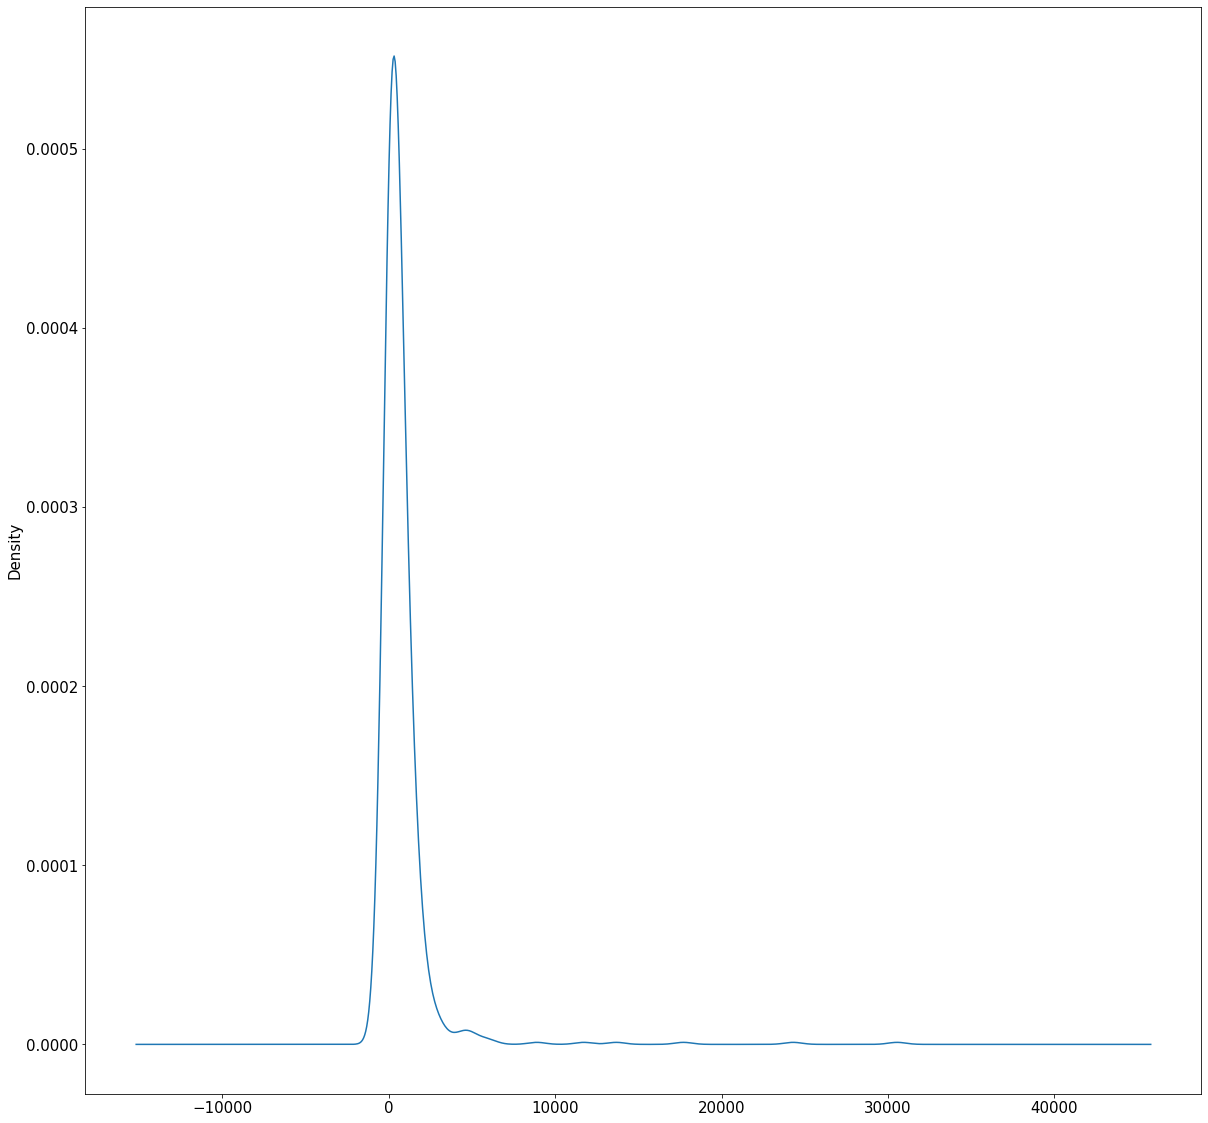

In [86]:
### --- Plotting the distribution of UTR introns length
introns_UTR_Hv_MorexLC['length'].plot.density()

<AxesSubplot:>

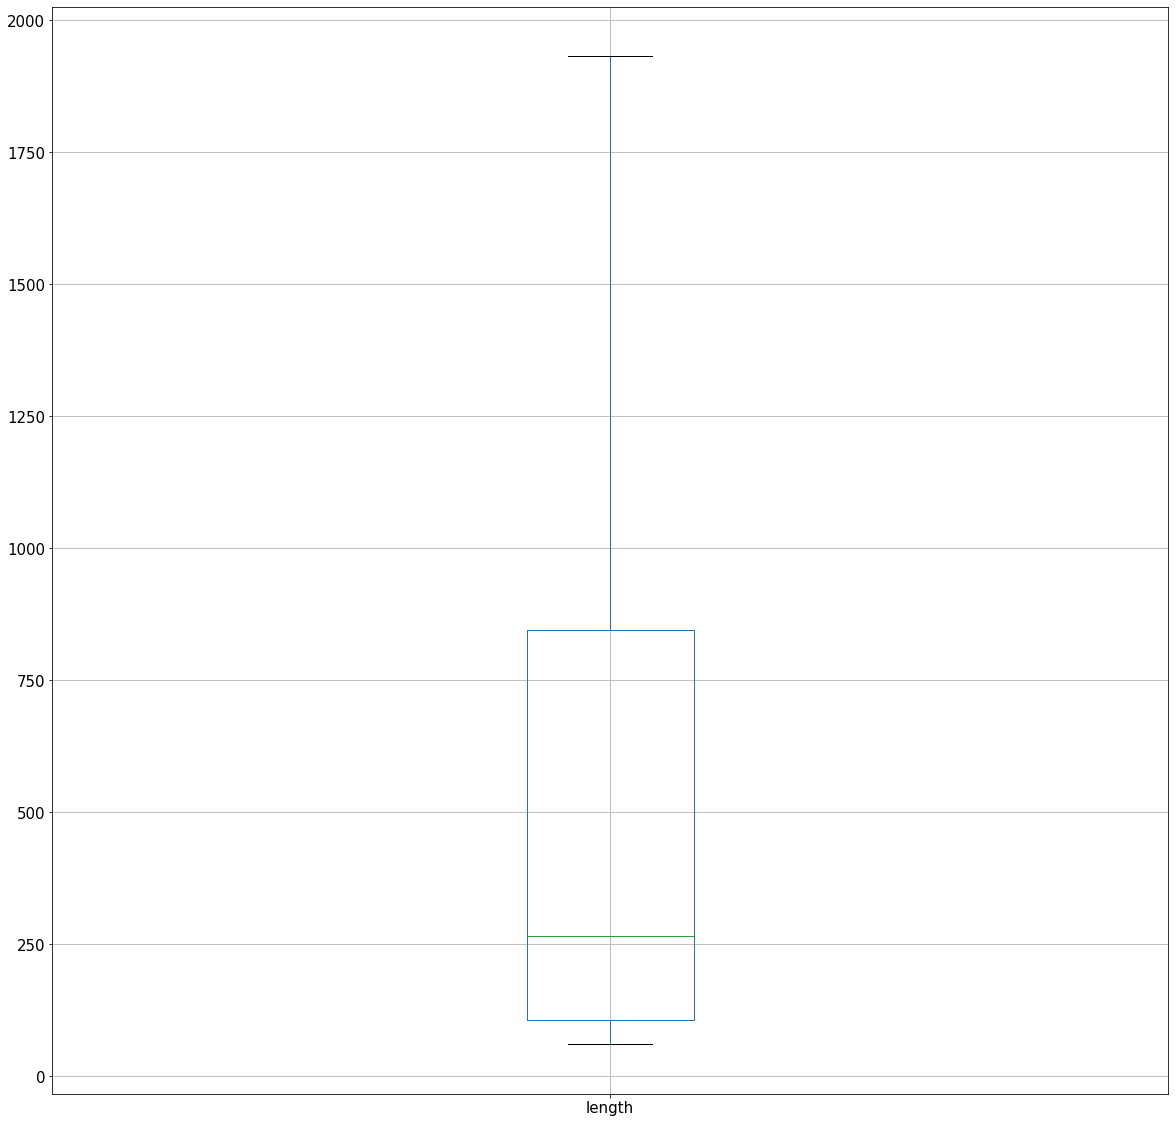

In [87]:
### --- Plotting the boxplot of UTR introns length without outliers
introns_UTR_Hv_MorexLC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

In [88]:
### --- splitting in introns 3'UTR and 5'UTR to eventually if there are differences among the two
introns_UTR3_Hv_MorexLC = introns_UTR_Hv_MorexLC.loc[introns_UTR_Hv_MorexLC['type'].isin(['intron three_prime_UTR'])]
introns_UTR5_Hv_MorexLC = introns_UTR_Hv_MorexLC.loc[introns_UTR_Hv_MorexLC['type'].isin(['intron five_prime_UTR'])]

In [89]:
introns_UTR3_Hv_MorexLC

,ID,type,start,end,length
2,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179225709,179226387,680
3,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179226467,179227377,912
4,ID=HORVU.MOREX.r3.1HG0033820.1,intron three_prime_UTR,179278895,179278985,92
8,ID=HORVU.MOREX.r3.1HG0040200.1,intron three_prime_UTR,254273004,254273075,73
9,ID=HORVU.MOREX.r3.1HG0040200.1,intron three_prime_UTR,254273172,254273252,82
...,...,...,...,...,...
256,ID=HORVU.MOREX.r3.7HG0686700.4,intron three_prime_UTR,225674132,225674643,513
260,ID=HORVU.MOREX.r3.7HG0690620.1,intron three_prime_UTR,264611386,264612013,629
261,ID=HORVU.MOREX.r3.7HG0693690.1,intron three_prime_UTR,306366598,306367589,993
264,ID=HORVU.MOREX.r3.7HG0697870.1,intron three_prime_UTR,360535445,360536998,1555


In [90]:
introns_UTR3_Hv_MorexLC['length'].describe()

count      380.000000
mean       822.815789
std       2185.413050
min         64.000000
25%        105.000000
50%        298.000000
75%        844.250000
max      30548.000000
Name: length, dtype: float64

In [91]:
introns_UTR5_Hv_MorexLC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0013040.1,intron five_prime_UTR,32366793,32368232,1441
1,ID=HORVU.MOREX.r3.1HG0016180.1,intron five_prime_UTR,46808524,46808624,102
5,ID=HORVU.MOREX.r3.1HG0036900.1,intron five_prime_UTR,220266901,220267015,116
6,ID=HORVU.MOREX.r3.1HG0036900.1,intron five_prime_UTR,220267198,220267704,508
7,ID=HORVU.MOREX.r3.1HG0036900.2,intron five_prime_UTR,220266901,220267015,116
...,...,...,...,...,...
263,ID=HORVU.MOREX.r3.7HG0695870.1,intron five_prime_UTR,335796573,335796877,306
265,ID=HORVU.MOREX.r3.7HG0697870.1,intron five_prime_UTR,360537796,360537891,97
266,ID=HORVU.MOREX.r3.7HG0704470.1,intron five_prime_UTR,422495764,422495886,124
268,ID=HORVU.MOREX.r3.7HG0717650.1,intron five_prime_UTR,511731957,511732038,83


In [92]:
introns_UTR5_Hv_MorexLC['length'].describe()

count      282.000000
mean       680.053191
std       1589.765537
min         60.000000
25%        106.000000
50%        240.500000
75%        838.750000
max      24296.000000
Name: length, dtype: float64

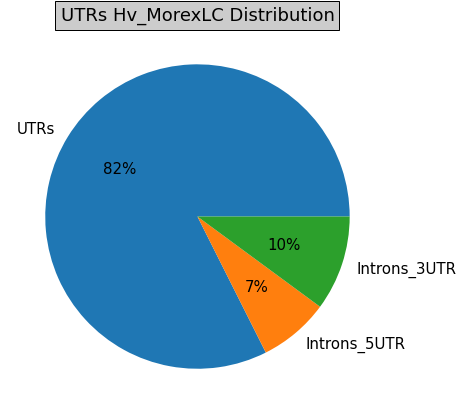

In [93]:
### --- Plotting the distribution of introns_UTR vs total UTRs
labels_Hv_MorexLC = ['UTRs', 'Introns_5UTR', 'Introns_3UTR']
UTR_data_Hv_MorexLC = [ 1800+1964-(282+380), 282, 380]
fig = plt.figure(figsize =(10, 7))
plt.pie(UTR_data_Hv_MorexLC, labels = labels_Hv_MorexLC, autopct='%1.0f%%')
plt.title("UTRs Hv_MorexLC Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

### 2.2.5 Removing UTR introns from the whole introns dataframe

In [94]:
### --- Checking total introns dataframe 
introns_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000100.1,intron,162713,162817,106
2,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163069,163164,97
3,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163386,166230,2846
4,ID=HORVU.MOREX.r3.1HG0000120.1,intron,190996,191280,286


In [95]:
### --- Checking UTR introns dataframe
introns_UTR_Hv_MorexLC.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0013040.1,intron five_prime_UTR,32366793,32368232,1441
1,ID=HORVU.MOREX.r3.1HG0016180.1,intron five_prime_UTR,46808524,46808624,102
2,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179225709,179226387,680
3,ID=HORVU.MOREX.r3.1HG0033800.1,intron three_prime_UTR,179226467,179227377,912
4,ID=HORVU.MOREX.r3.1HG0033820.1,intron three_prime_UTR,179278895,179278985,92


In [96]:
### --- Extracting introns from cds within Hv_MorexHC
introns_cds_Hv_MorexLC = cds_introns_dataframe(introns_Hv_MorexLC, introns_UTR_Hv_MorexLC)
introns_cds_Hv_MorexLC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000100.1,intron,162713,162817,106
2,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163069,163164,97
3,ID=HORVU.MOREX.r3.1HG0000100.1,intron,163386,166230,2846
4,ID=HORVU.MOREX.r3.1HG0000120.1,intron,190996,191280,286
...,...,...,...,...,...
25451,ID=HORVU.MOREX.r3.UnG0816300.1,intron,28901487,28901588,103
25452,ID=HORVU.MOREX.r3.UnG0816640.1,intron,29002646,29003296,652
25453,ID=HORVU.MOREX.r3.UnG0816680.1,intron,29008046,29008730,686
25454,ID=HORVU.MOREX.r3.UnG0816840.1,intron,29079790,29086201,6413


In [97]:
### --- Checking if there are not introns UTR within the created dataframe
introns_cds_Hv_MorexLC.loc[introns_cds_Hv_MorexLC['type'].isin(['intron three_prime_UTR','intron five_prime_UTR'])]

,ID,type,start,end,length


In [98]:
### --- Basic statistics of Hv_MorexLC introns cds
introns_cds_Hv_MorexLC['length'].describe()

count     24794.000000
mean        487.854602
std        3634.413380
min          22.000000
25%          88.000000
50%         110.500000
75%         314.000000
max      500805.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

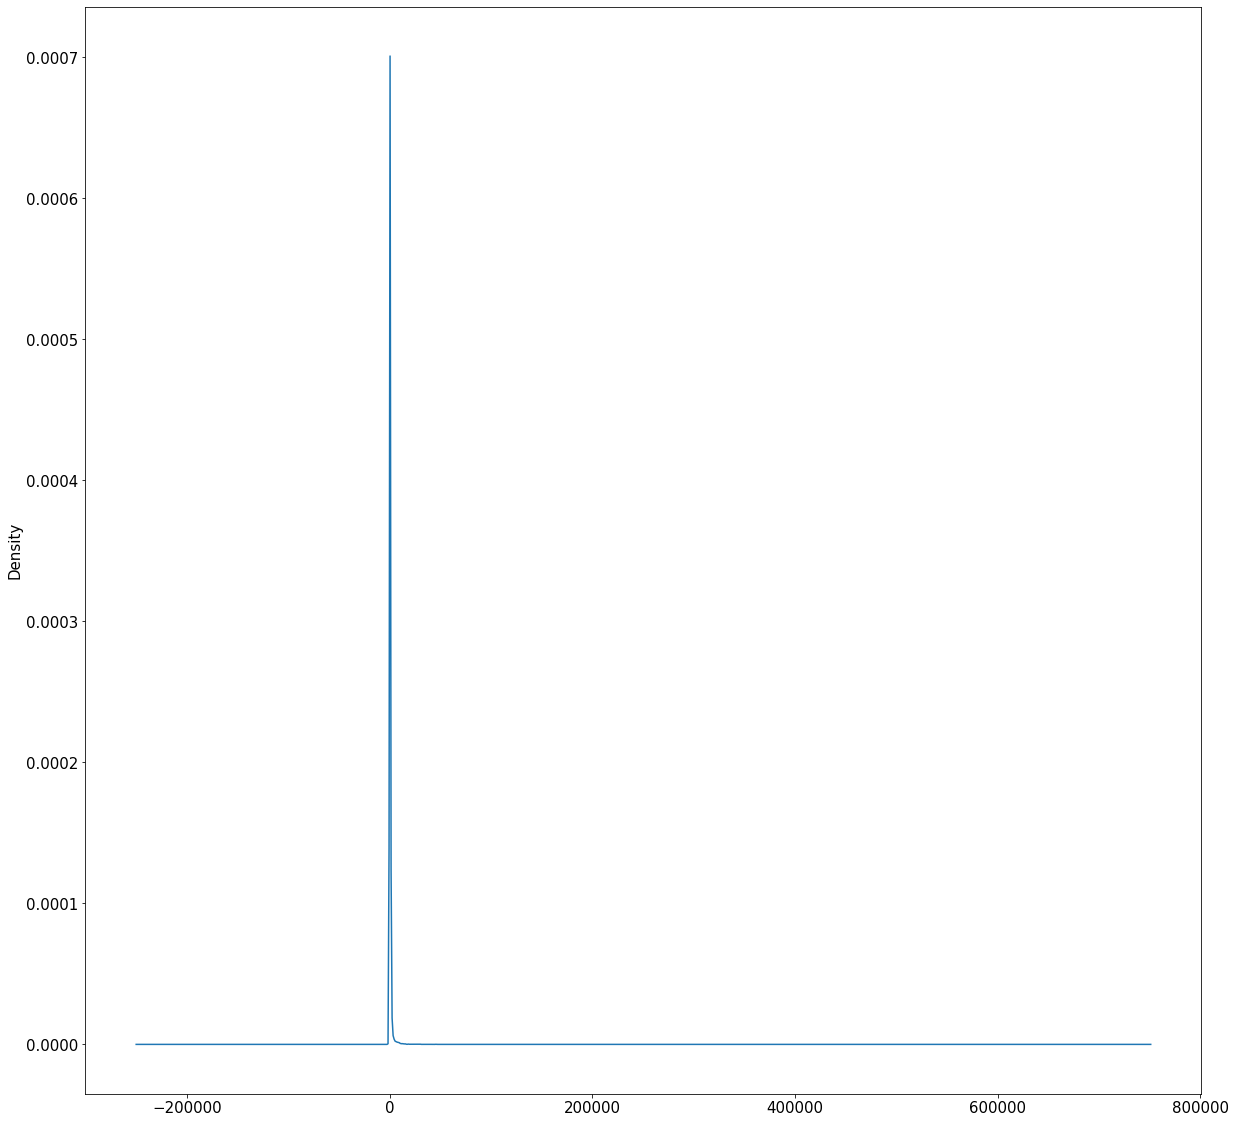

In [99]:
### --- Plotting the distribution of Hv_MorexLC cds introns length
introns_cds_Hv_MorexLC['length'].plot.density()

<AxesSubplot:>

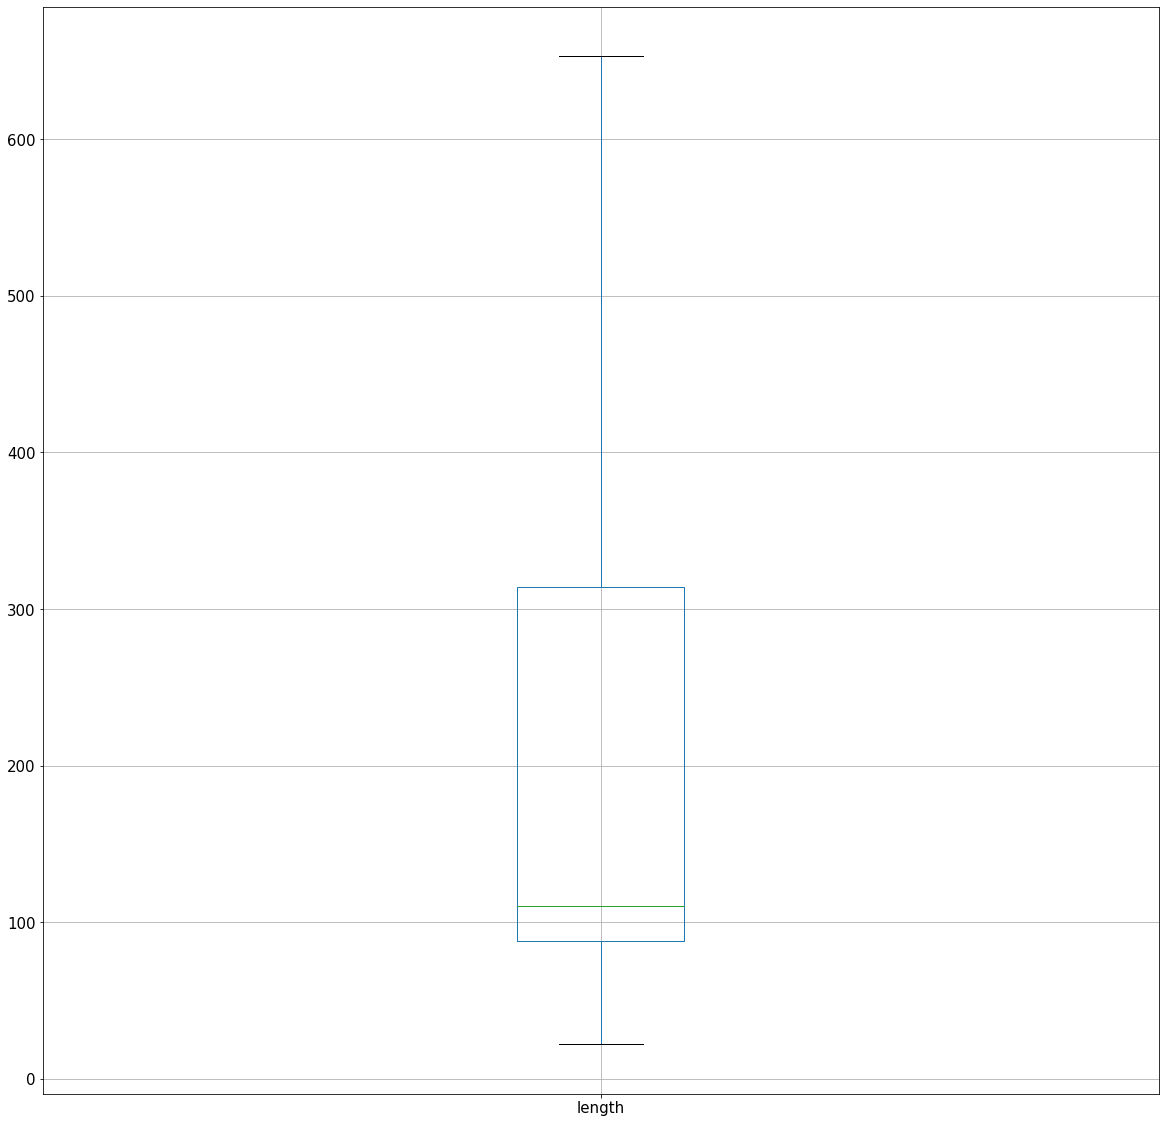

In [100]:
### --- Plotting the boxplot of Hv_MorexLC cds introns length without outliers
introns_cds_Hv_MorexLC.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 2.2.6 Re-organizing files and directories

In [101]:
! ls Data/

Hv_MorexLC_exon.tsv			Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_MorexLC_UTRforw.tsv			Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv
Hv_MorexLC_UTRrev.tsv			Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_Morex_longread			raw
Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv


In [102]:
! mv Data/Hv_MorexLC* Data/Hv_Morex_longread/

In [103]:
! ls Data/Hv_Morex_longread/

Hv_MorexHC_exon.tsv	Hv_MorexHC_UTRrev.tsv  Hv_MorexLC_UTRforw.tsv
Hv_MorexHC_UTRforw.tsv	Hv_MorexLC_exon.tsv    Hv_MorexLC_UTRrev.tsv


In [104]:
! ls Output/

Hv_MorexLC_intronlessIDs.txt  Hv_MorexLC_introns.tsv	      Hv_Morex_longread
Hv_MorexLC_intronpoorIDs.txt  Hv_MorexLC_UTRforw_introns.tsv
Hv_MorexLC_intronrichIDs.txt  Hv_MorexLC_UTRrev_introns.tsv


In [105]:
! mv Output/Hv_MorexLC* Output/Hv_Morex_longread/

In [106]:
! ls Output/Hv_Morex_longread/

Hv_MorexHC_intronlessIDs.txt	Hv_MorexLC_intronlessIDs.txt
Hv_MorexHC_intronpoorIDs.txt	Hv_MorexLC_intronpoorIDs.txt
Hv_MorexHC_intronrichIDs.txt	Hv_MorexLC_intronrichIDs.txt
Hv_MorexHC_introns.tsv		Hv_MorexLC_introns.tsv
Hv_MorexHC_UTRforw_introns.tsv	Hv_MorexLC_UTRforw_introns.tsv
Hv_MorexHC_UTRrev_introns.tsv	Hv_MorexLC_UTRrev_introns.tsv


# 2.3 Reproducing on Hv_Morex total

### 2.3.1 Collecting Data

In [107]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hv_Morex.pgsb.Jul2020.gff3 https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/5d16cc17-c37f-417f-855d-c5e72c721f6c/1/DOWNLOAD 

--2021-10-01 12:05:10--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/5d16cc17-c37f-417f-855d-c5e72c721f6c/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95708927 (91M) [text/plain]
Saving to: ‘Data/raw/Hv_Morex.pgsb.Jul2020.gff3’

Data/raw/Hv_Morex.p 100%[===================>]  91,27M  1,72MB/s    in 5m 9s   

2021-10-01 12:10:22 (302 KB/s) - ‘Data/raw/Hv_Morex.pgsb.Jul2020.gff3’ saved [95708927/95708927]



### 2.3.2 Processing Data

In [108]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [109]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hv_Morex.pgsb.Jul2020.gff3  > Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3

In [110]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hv_Morex_nohashtag.pgsb.Jul2020.csv

In [111]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hv_Morex = pd.read_csv('Data/Hv_Morex_nohashtag.pgsb.Jul2020.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [112]:
### --- Building a separate dataframe containing all exons
exon_Hv_Morex = df_Hv_Morex.loc[df_Hv_Morex['type'].isin(['exon'])]
exon_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
6,chr1H,pgsb,exon,50195,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon2
10,chr1H,pgsb,exon,53979,54323,.,+,.,ID=HORVU.MOREX.r3.1HG0000020.1.exon1
14,chr1H,pgsb,exon,76744,77373,.,+,.,ID=HORVU.MOREX.r3.1HG0000030.1.exon1
19,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1


In [113]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hv_Morex.to_csv('Data/Hv_Morex_exon.tsv',sep='\t',index=False,header=False)

In [114]:
### --- Keeping in a separated dataframe the forward strands
forw_Hv_Morex = df_Hv_Morex.loc[df_Hv_Morex['strand'].isin(['+'])]
forw_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,pgsb,gene,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010
1,chr1H,pgsb,mRNA,49526,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
3,chr1H,pgsb,exon,49526,49772,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.exon1
4,chr1H,pgsb,CDS,49583,49772,.,+,0,ID=HORVU.MOREX.r3.1HG0000010.1.CDS1


In [115]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hv_Morex = df_Hv_Morex.loc[df_Hv_Morex['strand'].isin(['-'])]
rev_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
16,chr1H,pgsb,gene,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040
17,chr1H,pgsb,mRNA,78284,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1
18,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
19,chr1H,pgsb,exon,78284,78954,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.exon1
20,chr1H,pgsb,CDS,78511,78954,.,-,0,ID=HORVU.MOREX.r3.1HG0000040.1.CDS1


In [116]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hv_Morex = forw_Hv_Morex.loc[df_Hv_Morex['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,pgsb,five_prime_UTR,49526,49582,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.five_prime_UTR1
7,chr1H,pgsb,three_prime_UTR,50428,50649,.,+,.,ID=HORVU.MOREX.r3.1HG0000010.1.three_prime_UTR2
62,chr1H,pgsb,five_prime_UTR,132221,132375,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.five_prime_UTR1
105,chr1H,pgsb,three_prime_UTR,138505,138736,.,+,.,ID=HORVU.MOREX.r3.1HG0000060.1.three_prime_UTR2
109,chr1H,pgsb,five_prime_UTR,146607,146749,.,+,.,ID=HORVU.MOREX.r3.1HG0000070.1.five_prime_UTR1


In [117]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_forw_Hv_Morex.to_csv('Data/Hv_Morex_UTRforw.tsv',sep='\t',index=False,header=False)

In [118]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hv_Morex = rev_Hv_Morex.loc[df_Hv_Morex['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hv_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
18,chr1H,pgsb,three_prime_UTR,78284,78510,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.three_prime_UTR1
39,chr1H,pgsb,five_prime_UTR,81706,81892,.,-,.,ID=HORVU.MOREX.r3.1HG0000040.1.five_prime_UTR2
42,chr1H,pgsb,three_prime_UTR,84091,84317,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.three_prime_UTR1
59,chr1H,pgsb,five_prime_UTR,86846,87063,.,-,.,ID=HORVU.MOREX.r3.1HG0000050.1.five_prime_UTR2
138,chr1H,pgsb,three_prime_UTR,156767,157203,.,-,.,ID=HORVU.MOREX.r3.1HG0000090.1.three_prime_UTR1


In [119]:
### --- Writing to a tsv formatted file the UTR_df_rev dataframe
UTR_rev_Hv_Morex.to_csv('Data/Hv_Morex_UTRrev.tsv',sep='\t',index=False,header=False)

### 2.3.3 Extracting introns from the whole genome

In [120]:
### --- Extracting introns from Hv_Morex
extract_tot_introns('Data/Hv_Morex_exon.tsv', 'Output/Hv_Morex_introns.tsv')

In [121]:
introns_Hv_Morex = pd.read_csv('Output/Hv_Morex_introns.tsv', sep = '\t')
introns_Hv_Morex[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
...,...,...,...,...,...
95,ID=HORVU.MOREX.r3.1HG0000170.1,intron,424743,429267,4526
96,ID=HORVU.MOREX.r3.1HG0000190.1,intron,437991,438084,95
97,ID=HORVU.MOREX.r3.1HG0000210.1,intron,540340,540864,526
98,ID=HORVU.MOREX.r3.1HG0000210.1,intron,543264,543345,83


In [122]:
### --- Counting introns type in Hv_MorexHC
introns_dictionary_Hv_Morex = counting_introns_type(exon_Hv_Morex)

In [123]:
n_intronless_Hv_Morex, n_intronpoor_Hv_Morex, n_intronrich_Hv_Morex, intronless_Hv_Morex, intronpoor_Hv_Morex, intronrich_Hv_Morex = splitting_introns_type(introns_dictionary_Hv_Morex)

Intronless are: 46175
Intronpoor are: 23531
Intronrich are: 14284


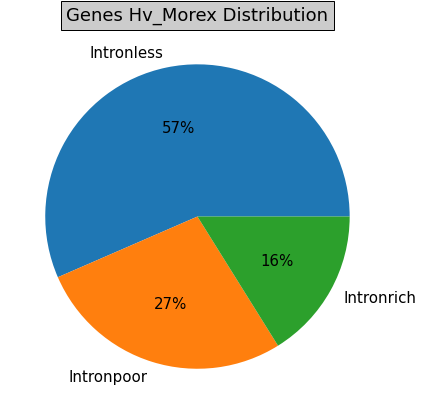

In [124]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Hv_Morex = [46175, 22342, 13170]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Hv_Morex, labels = genes, autopct='%1.0f%%')
plt.title("Genes Hv_Morex Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [125]:
### --- Creating the list of Hv_Morex gene IDs to check the number of transcripts using command line
intronless_file_Hv_Morex = open('Output/Hv_Morex_intronlessIDs.txt', 'a')
intronpoor_file_Hv_Morex = open('Output/Hv_Morex_intronpoorIDs.txt', 'a')
intronrich_file_Hv_Morex = open('Output/Hv_Morex_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hv_Morex)):
    if i == len(intronless_Hv_Morex) -1:
        intronless_file_Hv_Morex.write(intronless_Hv_Morex[i])
    else:
        intronless_file_Hv_Morex.write(intronless_Hv_Morex[i] + '\n')
intronless_file_Hv_Morex.close()

for i in range(len(intronpoor_Hv_Morex)):
    if i == len(intronpoor_Hv_Morex) -1:
        intronpoor_file_Hv_Morex.write(intronpoor_Hv_Morex[i])
    else:
        intronpoor_file_Hv_Morex.write(intronpoor_Hv_Morex[i] + '\n')
intronpoor_file_Hv_Morex.close()

for i in range(len(intronrich_Hv_Morex)):
    if i == len(intronrich_Hv_Morex) -1:
        intronrich_file_Hv_Morex.write(intronrich_Hv_Morex[i])
    else:
        intronrich_file_Hv_Morex.write(intronrich_Hv_Morex[i]+'\n')
intronrich_file_Hv_Morex.close()


In [126]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hv_Morex = ! grep -f Output/Hv_Morex_intronlessIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hv_Morex = ! grep -f Output/Hv_Morex_intronpoorIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hv_Morex = ! grep -f Output/Hv_Morex_intronrichIDs.txt Data/Hv_Morex_nohashtag.pgsb.Jul2020.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [127]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hv_Morex = int(n_mRNA_intronless_Hv_Morex[0])/n_intronless_Hv_Morex
print(avg_mRNA_intronless_Hv_Morex)
avg_mRNA_intronpoor_Hv_Morex = int(n_mRNA_intronpoor_Hv_Morex[0])/n_intronpoor_Hv_Morex
print(avg_mRNA_intronpoor_Hv_Morex)
avg_mRNA_intronrich_Hv_Morex = int(n_mRNA_intronrich_Hv_Morex[0])/n_intronrich_Hv_Morex
print(avg_mRNA_intronrich_Hv_Morex)

0.0
1.0
1.0


### 2.3.4 Extracting introns from UTR regions

In [128]:
### --- Extracting introns from UTR forward Hv_Morex
extract_UTR_introns('Data/Hv_Morex_UTRforw.tsv', 'Output/Hv_Morex_UTRforw_introns.tsv')

In [129]:
### --- Extracting introns from UTR reverse Hv_Morex
extract_UTR_introns('Data/Hv_Morex_UTRrev.tsv', 'Output/Hv_Morex_UTRrev_introns.tsv')

In [130]:
introns_UTR_forw_Hv_Morex = pd.read_csv('Output/Hv_Morex_UTRforw_introns.tsv', sep='\t')
introns_UTR_forw_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [131]:
introns_UTR_rev_Hv_Morex = pd.read_csv('Output/Hv_Morex_UTRrev_introns.tsv', sep = '\t')
introns_UTR_rev_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000130.1,intron three_prime_UTR,377002,377104,104
1,ID=HORVU.MOREX.r3.1HG0000350.1,intron five_prime_UTR,1156130,1159354,3226
2,ID=HORVU.MOREX.r3.1HG0001120.1,intron five_prime_UTR,2577943,2580334,2393
3,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3193629,3198818,5191
4,ID=HORVU.MOREX.r3.1HG0001400.1,intron five_prime_UTR,3198962,3199088,128


In [132]:
### --- Concatenating the UTR_introns to build a unique dataframe
frames_Hv_Morex = [introns_UTR_forw_Hv_Morex, introns_UTR_rev_Hv_Morex]
introns_UTR_Hv_Morex = pd.concat(frames_Hv_Morex)

In [133]:
### --- Performing some basic statistics 
introns_UTR_Hv_Morex['length'].describe()

count     5711.000000
mean       897.227981
std       2447.933245
min         33.000000
25%        119.000000
50%        396.000000
75%        932.000000
max      74239.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

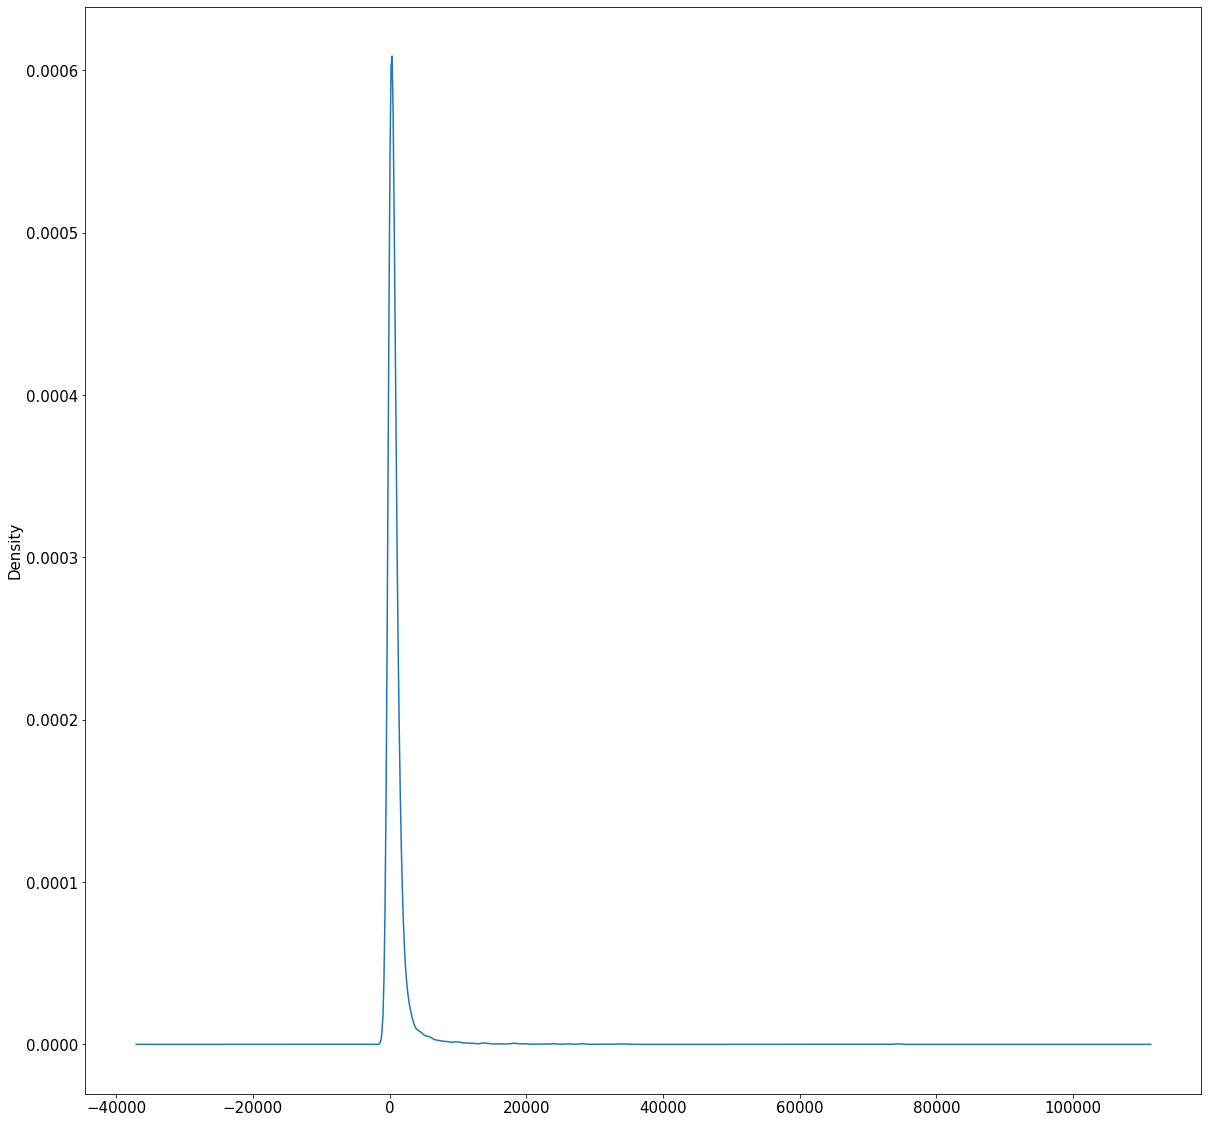

In [134]:
### --- Plotting the distribution of UTR introns length
introns_UTR_Hv_Morex['length'].plot.density()

<AxesSubplot:>

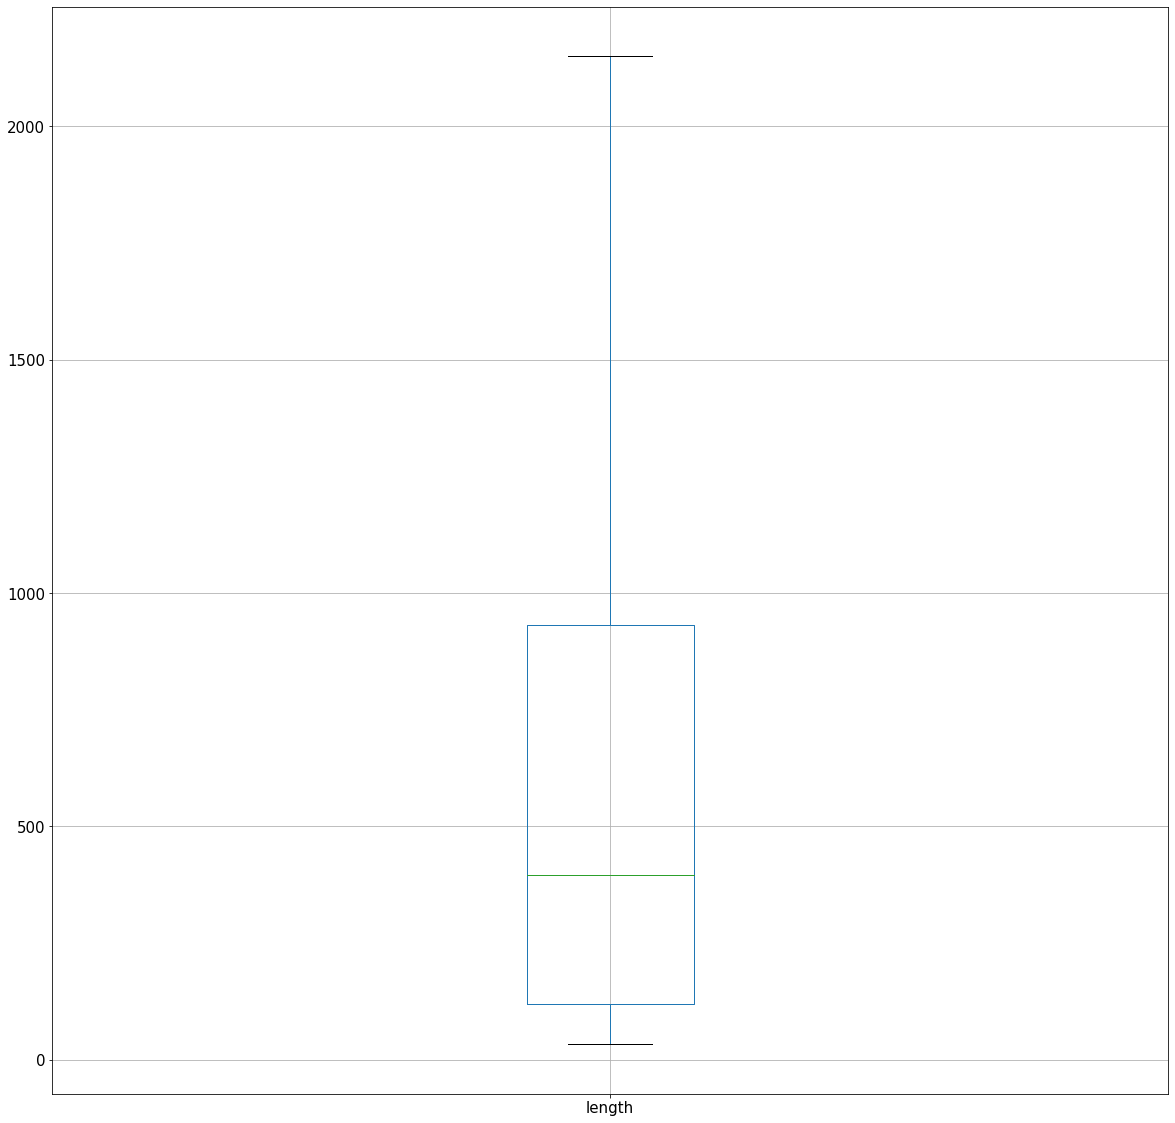

In [135]:
### --- Plotting the boxplot of UTR introns length without outliers
introns_UTR_Hv_Morex.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

In [136]:
### --- splitting in introns 3'UTR and 5'UTR to eventually if there are differences among the two
introns_UTR3_Hv_Morex = introns_UTR_Hv_Morex.loc[introns_UTR_Hv_Morex['type'].isin(['intron three_prime_UTR'])]
introns_UTR5_Hv_Morex = introns_UTR_Hv_Morex.loc[introns_UTR_Hv_Morex['type'].isin(['intron five_prime_UTR'])]

In [137]:
introns_UTR3_Hv_Morex

,ID,type,start,end,length
11,ID=HORVU.MOREX.r3.1HG0003090.2,intron three_prime_UTR,5946475,5974459,27986
12,ID=HORVU.MOREX.r3.1HG0003090.6,intron three_prime_UTR,5946475,5974459,27986
24,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14661381,14662100,721
25,ID=HORVU.MOREX.r3.1HG0007160.1,intron three_prime_UTR,14662182,14662301,121
27,ID=HORVU.MOREX.r3.1HG0007370.2,intron three_prime_UTR,15093762,15093878,118
...,...,...,...,...,...
2676,ID=HORVU.MOREX.r3.7HG0748130.1,intron three_prime_UTR,620827612,620827821,211
2677,ID=HORVU.MOREX.r3.7HG0749430.1,intron three_prime_UTR,623175384,623176311,929
2678,ID=HORVU.MOREX.r3.7HG0749440.1,intron three_prime_UTR,623212429,623212835,408
2682,ID=HORVU.MOREX.r3.7HG0749980.1,intron three_prime_UTR,624202455,624203734,1281


In [138]:
introns_UTR3_Hv_Morex['length'].describe()

count     2012.000000
mean       967.822565
std       3355.354223
min         33.000000
25%        100.000000
50%        208.500000
75%        771.750000
max      74239.000000
Name: length, dtype: float64

In [139]:
introns_UTR5_Hv_Morex

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117
...,...,...,...,...,...
2686,ID=HORVU.MOREX.r3.7HG0751310.1,intron five_prime_UTR,627322202,627322296,96
2687,ID=HORVU.MOREX.r3.7HG0752050.1,intron five_prime_UTR,628813527,628813619,94
2689,ID=HORVU.MOREX.r3.7HG0752950.1,intron five_prime_UTR,632146924,632147308,386
2690,ID=HORVU.MOREX.r3.UnG0753140.1,intron five_prime_UTR,475717,475945,230


In [140]:
introns_UTR5_Hv_Morex['length'].describe()

count     3699.000000
mean       858.829413
std       1768.080234
min         41.000000
25%        142.000000
50%        497.000000
75%        991.000000
max      34933.000000
Name: length, dtype: float64

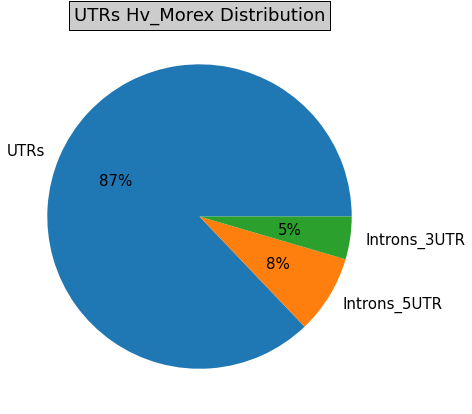

In [141]:
### --- Plotting the distribution of introns_UTR vs total UTRs
labels_Hv_Morex = ['UTRs', 'Introns_5UTR', 'Introns_3UTR']
UTR_data_Hv_Morex = [22630 + 21738 -(3699+2012), 3699, 2012]
fig = plt.figure(figsize =(10, 7))
plt.pie(UTR_data_Hv_Morex, labels = labels_Hv_Morex, autopct='%1.0f%%')
plt.title("UTRs Hv_Morex Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

### 2.3.5 Removing UTR introns from the whole introns dataframe

In [142]:
### --- Checking total introns dataframe 
introns_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102


In [143]:
### --- Checking UTR introns dataframe
introns_UTR_Hv_Morex.head()

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117


In [144]:
### --- Extracting introns from cds within Hv_MorexHC
introns_cds_Hv_Morex = cds_introns_dataframe(introns_Hv_Morex, introns_UTR_Hv_Morex)
introns_cds_Hv_Morex

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000010.1,intron,49773,50194,423
1,ID=HORVU.MOREX.r3.1HG0000040.1,intron,78955,79062,109
2,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79105,79608,505
3,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79677,79756,81
4,ID=HORVU.MOREX.r3.1HG0000040.1,intron,79800,79900,102
...,...,...,...,...,...
156682,ID=HORVU.MOREX.r3.UnG0816320.1,intron,28904141,28904339,200
156683,ID=HORVU.MOREX.r3.UnG0816640.1,intron,29002646,29003296,652
156684,ID=HORVU.MOREX.r3.UnG0816680.1,intron,29008046,29008730,686
156685,ID=HORVU.MOREX.r3.UnG0816840.1,intron,29079790,29086201,6413


In [145]:
### --- Checking if there are not introns UTR within the created dataframe
introns_cds_Hv_Morex.loc[introns_cds_Hv_Morex['type'].isin(['intron three_prime_UTR','intron five_prime_UTR'])]

,ID,type,start,end,length


In [146]:
### --- Basic statistics of Hv_Morex introns cds
introns_cds_Hv_Morex['length'].describe()

count    150976.000000
mean        552.505862
std        2509.972190
min          22.000000
25%          92.000000
50%         127.000000
75%         421.000000
max      500805.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

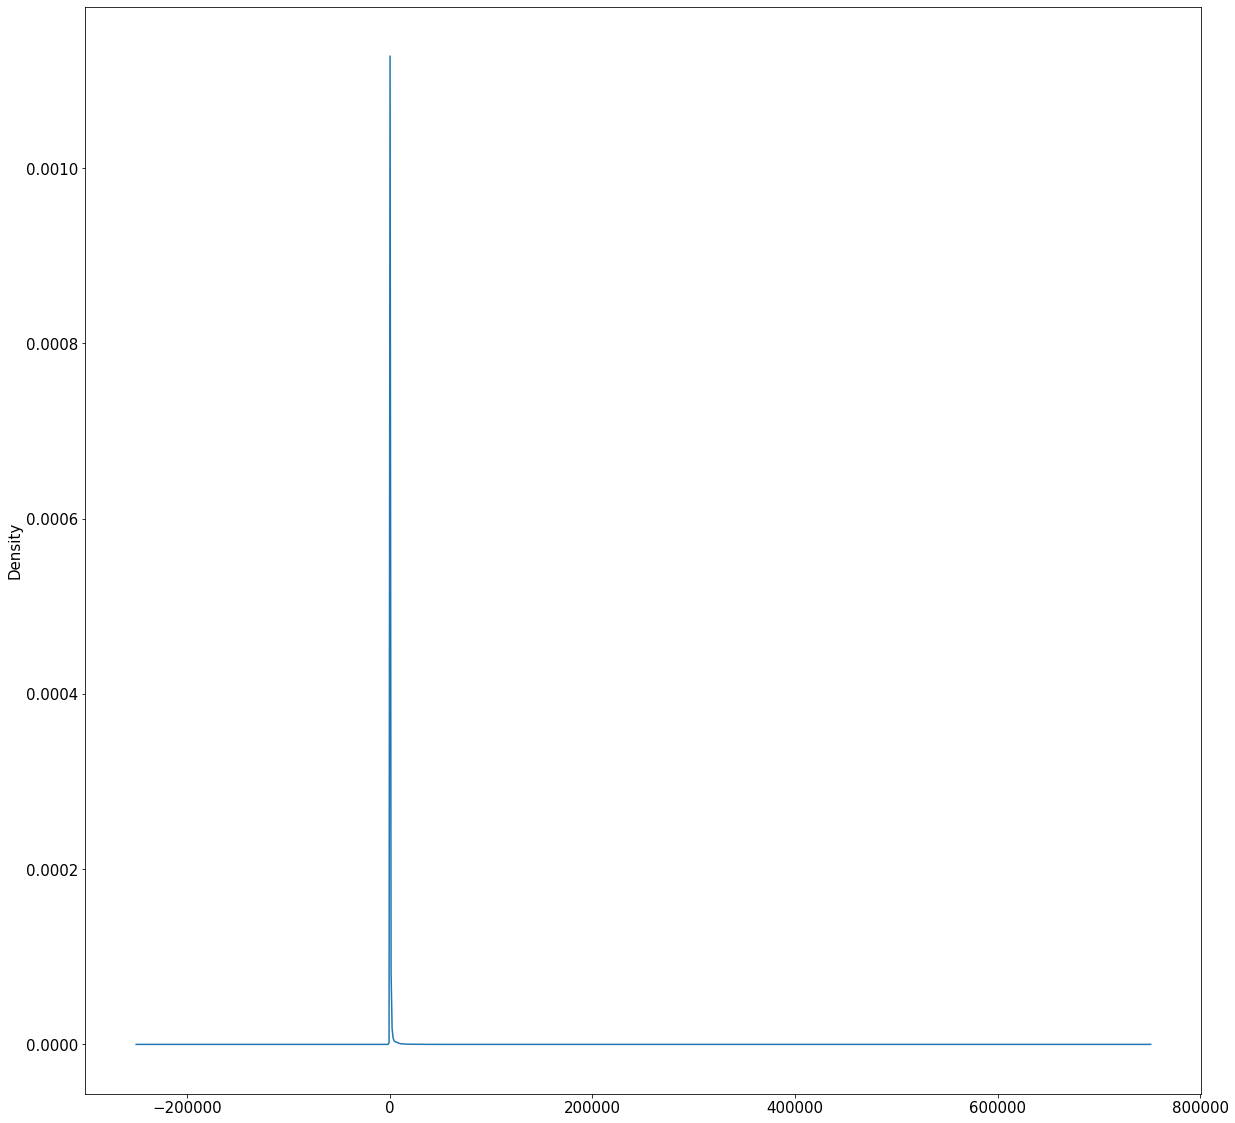

In [147]:
### --- Plotting the distribution of Hv_Morex cds introns length
introns_cds_Hv_Morex['length'].plot.density()

<AxesSubplot:>

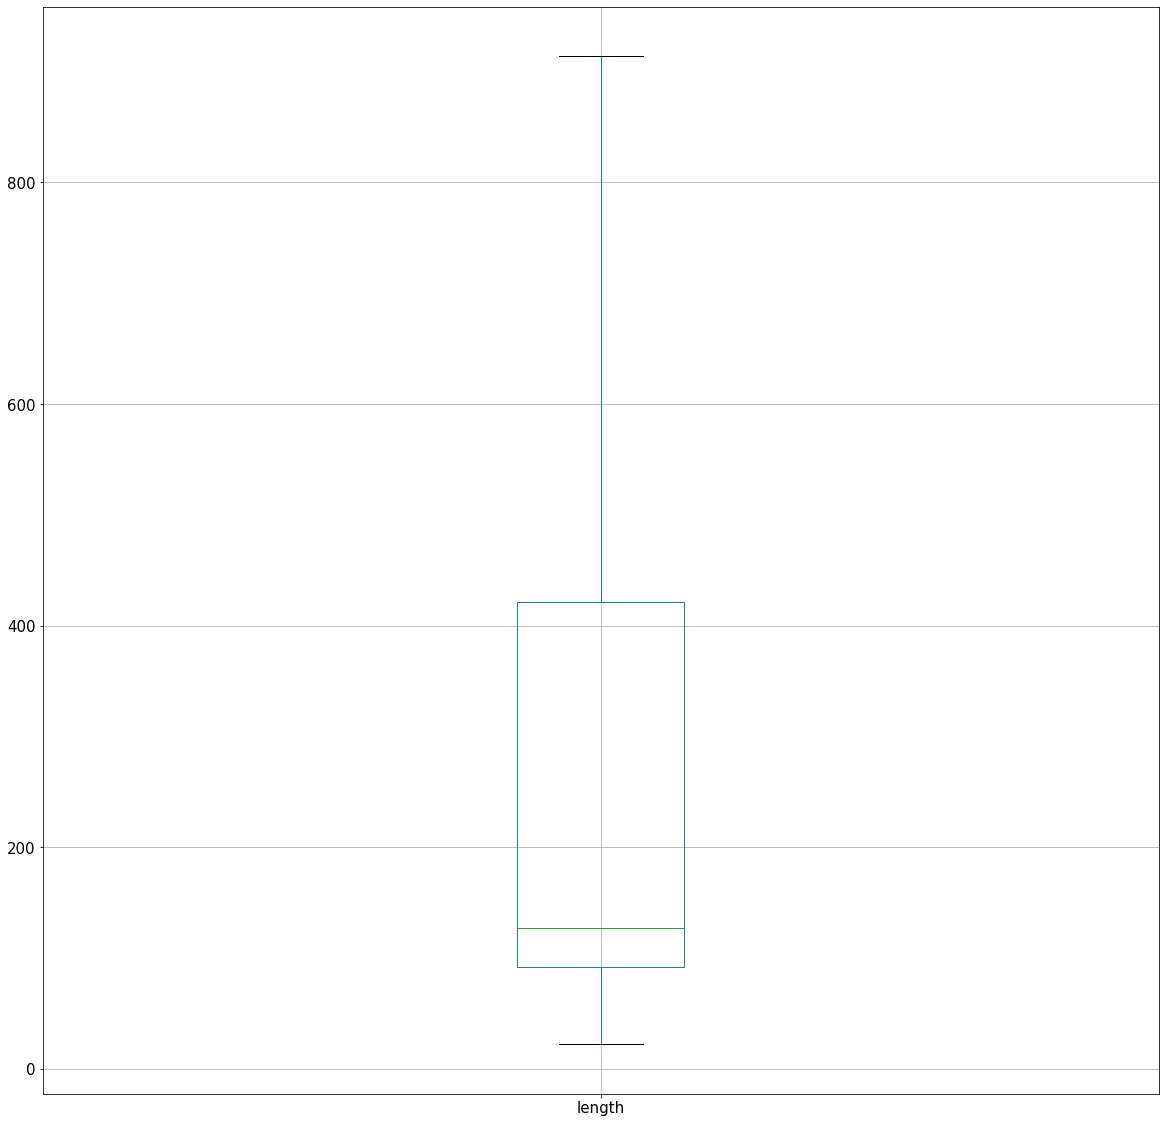

In [148]:
### --- Plotting the boxplot of Hv_Morex cds introns length without outliers
introns_cds_Hv_Morex.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 2.3.6 Re-organizing files and directories

In [149]:
! ls Data/

Hv_Morex_exon.tsv
Hv_Morex_longread
Hv_Morex_nohashtag.pgsb.Jul2020.csv
Hv_Morex_nohashtag.pgsb.Jul2020.gff3
Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv
Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_Morex_UTRforw.tsv
Hv_Morex_UTRrev.tsv
raw


In [150]:
! mv Data/*tsv Data/Hv_Morex_longread

In [151]:
! mv Data/Hv_Morex_n* Data/Hv_Morex_longread/

In [152]:
! ls Data/Hv_Morex_longread/

Hv_Morex_exon.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.gff3
Hv_MorexHC_exon.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.HC.csv
Hv_MorexHC_UTRforw.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.HC.gff3
Hv_MorexHC_UTRrev.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.LC.csv
Hv_MorexLC_exon.tsv		     Hv_Morex_nohashtag.pgsb.Jul2020.LC.gff3
Hv_MorexLC_UTRforw.tsv		     Hv_Morex_UTRforw.tsv
Hv_MorexLC_UTRrev.tsv		     Hv_Morex_UTRrev.tsv
Hv_Morex_nohashtag.pgsb.Jul2020.csv


In [153]:
! ls Output/

Hv_Morex_intronlessIDs.txt  Hv_Morex_longread
Hv_Morex_intronpoorIDs.txt  Hv_Morex_UTRforw_introns.tsv
Hv_Morex_intronrichIDs.txt  Hv_Morex_UTRrev_introns.tsv
Hv_Morex_introns.tsv


In [154]:
! mv Output/*tsv Output/Hv_Morex_longread/

In [155]:
! mv Output/*txt Output/Hv_Morex_longread/

In [156]:
! ls Output/Hv_Morex_longread/

Hv_MorexHC_intronlessIDs.txt	Hv_Morex_introns.tsv
Hv_MorexHC_intronpoorIDs.txt	Hv_MorexLC_intronlessIDs.txt
Hv_MorexHC_intronrichIDs.txt	Hv_MorexLC_intronpoorIDs.txt
Hv_MorexHC_introns.tsv		Hv_MorexLC_intronrichIDs.txt
Hv_MorexHC_UTRforw_introns.tsv	Hv_MorexLC_introns.tsv
Hv_MorexHC_UTRrev_introns.tsv	Hv_MorexLC_UTRforw_introns.tsv
Hv_Morex_intronlessIDs.txt	Hv_MorexLC_UTRrev_introns.tsv
Hv_Morex_intronpoorIDs.txt	Hv_Morex_UTRforw_introns.tsv
Hv_Morex_intronrichIDs.txt	Hv_Morex_UTRrev_introns.tsv


# 3 Reproducing the same analysis using data of a Pan Genome study

The Pan Genome study I am referring to can be found [here](https://www.nature.com/articles/s41586-020-2947-8). All the data can be found [here](https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/3490162b-3d76-4ba1-b6ee-3eaed5f6b644/2/).

I will firstly perform the analysis on the data within the _Denovo_gene_annotation_ directory and then on the ones within the _Gene_projection_ directory. 

## 3.1 Barke - De novo gene annotation 

### 3.1.1 Collecting Data

In [157]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Barke.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/1f736b6a-20f5-4e48-83c9-a308a51221ee/1/DOWNLOAD

--2021-10-01 12:11:26--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/1f736b6a-20f5-4e48-83c9-a308a51221ee/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58830221 (56M) [text/plain]
Saving to: ‘Data/raw/Barke.gff3’

Data/raw/Barke.gff3 100%[===================>]  56,10M  1,53MB/s    in 34s     

2021-10-01 12:12:01 (1,64 MB/s) - ‘Data/raw/Barke.gff3’ saved [58830221/58830221]



### 3.1.2 Processing Data

In [158]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [159]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Barke.gff3  > Data/Barke_nohashtag.gff3

In [160]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Barke_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Barke_nohashtag.csv

In [161]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Barke = pd.read_csv('Data/Barke_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010
1,chr1H,PGSB,mRNA,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1
2,chr1H,PGSB,exon,72210,72399,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,CDS,72210,72399,.,+,0,ID=HORVU.BARKE.r1.1HG0000010.1.CDS.1
4,chr1H,PGSB,exon,72822,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.2


In [162]:
### --- Building a separate dataframe containing all exons
exon_Barke = df_Barke.loc[df_Barke['type'].isin(['exon'])]
exon_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSB,exon,72210,72399,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.1
4,chr1H,PGSB,exon,72822,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.2
8,chr1H,PGSB,exon,102846,103475,.,+,.,ID=HORVU.BARKE.r1.1HG0000020.1.exon.1
12,chr1H,PGSB,exon,104616,105062,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.1
14,chr1H,PGSB,exon,105168,105209,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.2


In [163]:
### --- Exporting the exon dataframe to a tsv file 
exon_Barke.to_csv('Data/Barke_exon.tsv',sep='\t',index=False,header=False)

In [164]:
### --- Keeping in a separated dataframe the forward strands
forw_Barke = df_Barke.loc[df_Barke['strand'].isin(['+'])]
forw_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010
1,chr1H,PGSB,mRNA,72210,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1
2,chr1H,PGSB,exon,72210,72399,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,CDS,72210,72399,.,+,0,ID=HORVU.BARKE.r1.1HG0000010.1.CDS.1
4,chr1H,PGSB,exon,72822,73054,.,+,.,ID=HORVU.BARKE.r1.1HG0000010.1.exon.2


In [165]:
### --- Keeping in a separated dataframe the reverse strands
rev_Barke = df_Barke.loc[df_Barke['strand'].isin(['-'])]
rev_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes
10,chr1H,PGSB,gene,104616,112948,.,-,.,ID=HORVU.BARKE.r1.1HG0000030
11,chr1H,PGSB,mRNA,104616,112948,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1
12,chr1H,PGSB,exon,104616,105062,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.1
13,chr1H,PGSB,CDS,104616,105062,.,-,0,ID=HORVU.BARKE.r1.1HG0000030.1.CDS.1
14,chr1H,PGSB,exon,105168,105209,.,-,.,ID=HORVU.BARKE.r1.1HG0000030.1.exon.2


In [166]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Barke = forw_Barke.loc[df_Barke['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [167]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Barke = rev_Barke.loc[df_Barke['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Barke.head()

,chr,source,type,start,end,score,strand,phase,attributes


As we see UTRs are not reported within this annotation so we cannot analyze them. We will just focus on the total number of introns. 

### 3.1.3 Extracting introns from the whole genome

In [168]:
### --- Extracting introns from Barke
extract_tot_introns('Data/Barke_exon.tsv', 'Output/Barke_introns.tsv')

In [169]:
introns_Barke = pd.read_csv('Output/Barke_introns.tsv', sep = '\t')
introns_Barke[:100]

,ID,type,start,end,length
0,ID=HORVU.BARKE.r1.1HG0000010.1,intron,72400,72821,423
1,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105063,105167,106
2,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105210,105713,505
3,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105782,105861,81
4,ID=HORVU.BARKE.r1.1HG0000030.1,intron,105905,106005,102
...,...,...,...,...,...
95,ID=HORVU.BARKE.r1.1HG0000150.1,intron,428232,428317,87
96,ID=HORVU.BARKE.r1.1HG0000160.1,intron,436394,436497,105
97,ID=HORVU.BARKE.r1.1HG0000170.1,intron,496838,496909,73
98,ID=HORVU.BARKE.r1.1HG0000170.1,intron,496951,497090,141


In [170]:
### --- Counting introns type in Barke
introns_dictionary_Barke = counting_introns_type(exon_Barke)

In [171]:
n_intronless_Barke, n_intronpoor_Barke, n_intronrich_Barke, intronless_Barke, intronpoor_Barke, intronrich_Barke = splitting_introns_type(introns_dictionary_Barke)

Intronless are: 25166
Intronpoor are: 14852
Intronrich are: 11019


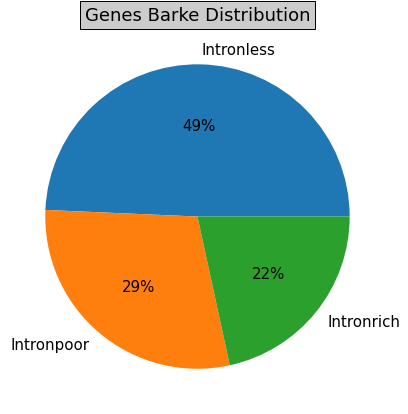

In [172]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Barke = [25166, 14852, 11019]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Barke, labels = genes, autopct='%1.0f%%')
plt.title("Genes Barke Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [173]:
### --- Creating the list of Barke gene IDs to check the number of transcripts using command line
intronless_file_Barke = open('Output/Barke_intronlessIDs.txt', 'a')
intronpoor_file_Barke = open('Output/Barke_intronpoorIDs.txt', 'a')
intronrich_file_Barke = open('Output/Barke_intronrichIDs.txt', 'a')
for i in range(len(intronless_Barke)):
    if i == len(intronless_Barke) -1:
        intronless_file_Barke.write(intronless_Barke[i])
    else:
        intronless_file_Barke.write(intronless_Barke[i] + '\n')
intronless_file_Barke.close()

for i in range(len(intronpoor_Barke)):
    if i == len(intronpoor_Barke) -1:
        intronpoor_file_Barke.write(intronpoor_Barke[i])
    else:
        intronpoor_file_Barke.write(intronpoor_Barke[i] + '\n')
intronpoor_file_Barke.close()

for i in range(len(intronrich_Barke)):
    if i == len(intronrich_Barke) -1:
        intronrich_file_Barke.write(intronrich_Barke[i])
    else:
        intronrich_file_Barke.write(intronrich_Barke[i]+'\n')
intronrich_file_Barke.close()

In [174]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Barke = ! grep -f Output/Barke_intronlessIDs.txt Data/Barke_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Barke = ! grep -f Output/Barke_intronpoorIDs.txt Data/Barke_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Barke = ! grep -f Output/Barke_intronrichIDs.txt Data/Barke_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [175]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Barke = int(n_mRNA_intronless_Barke[0])/n_intronless_Barke
print(avg_mRNA_intronless_Barke)
avg_mRNA_intronpoor_Barke = int(n_mRNA_intronpoor_Barke[0])/n_intronpoor_Barke
print(avg_mRNA_intronpoor_Barke)
avg_mRNA_intronrich_Barke = int(n_mRNA_intronrich_Barke[0])/n_intronrich_Barke
print(avg_mRNA_intronrich_Barke)

1.0
1.0
1.0


It seems there are no transcripts undergoing alternative splicing. This is probably due to a poor annotation. 

In [176]:
### --- Basic statistics of Barke introns
introns_Barke['length'].describe()

count    118377.000000
mean        521.125354
std        1624.109541
min          22.000000
25%          94.000000
50%         132.000000
75%         433.000000
max      137958.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

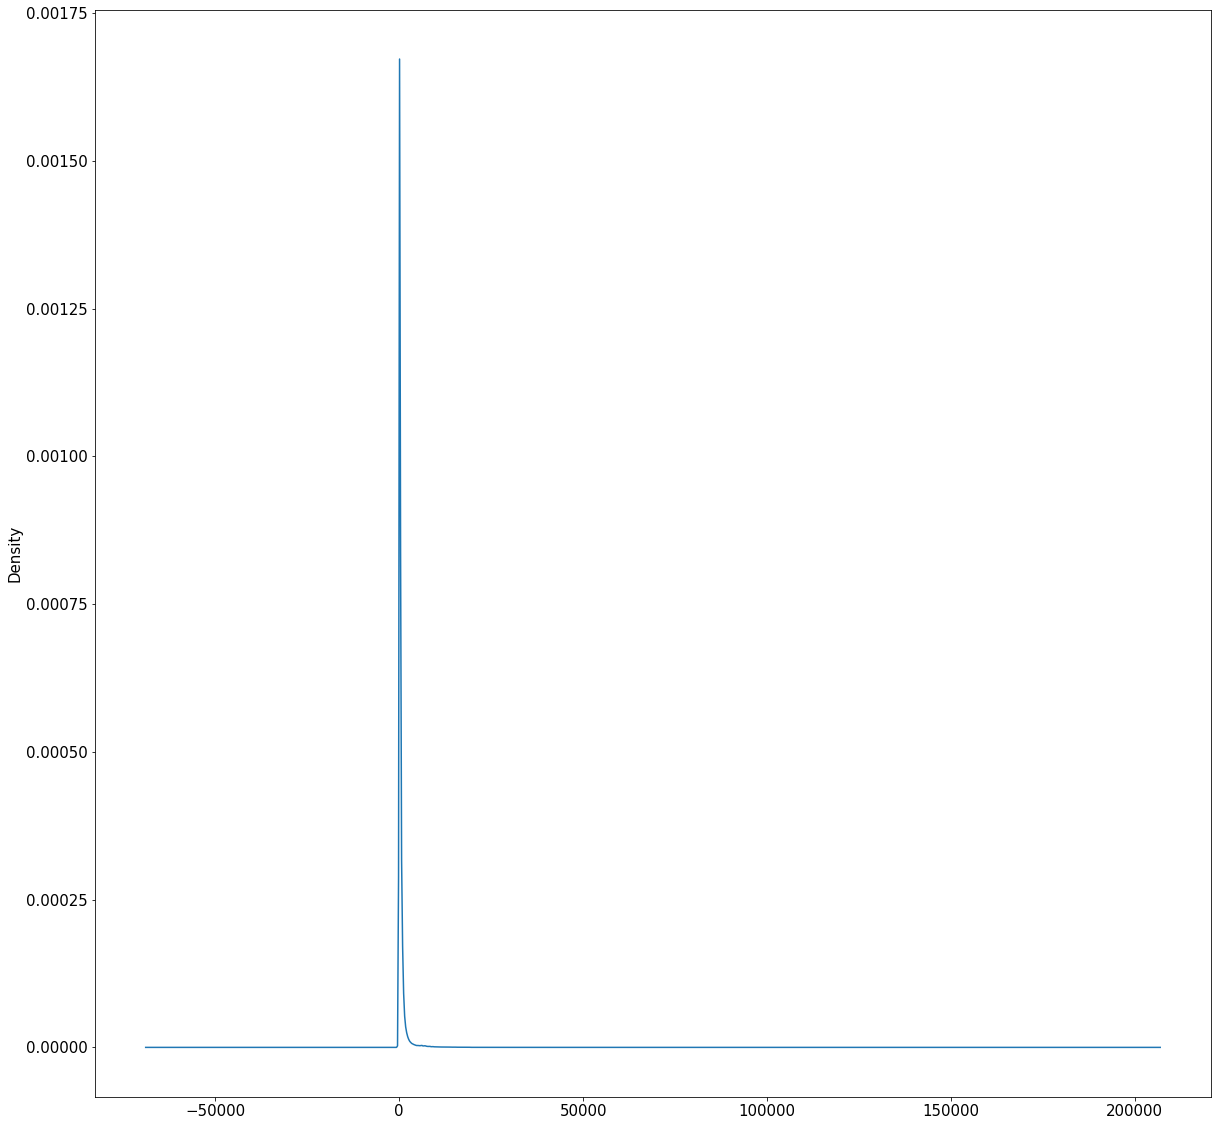

In [177]:
### --- Plotting the distribution of Barke introns length
introns_Barke['length'].plot.density()

<AxesSubplot:>

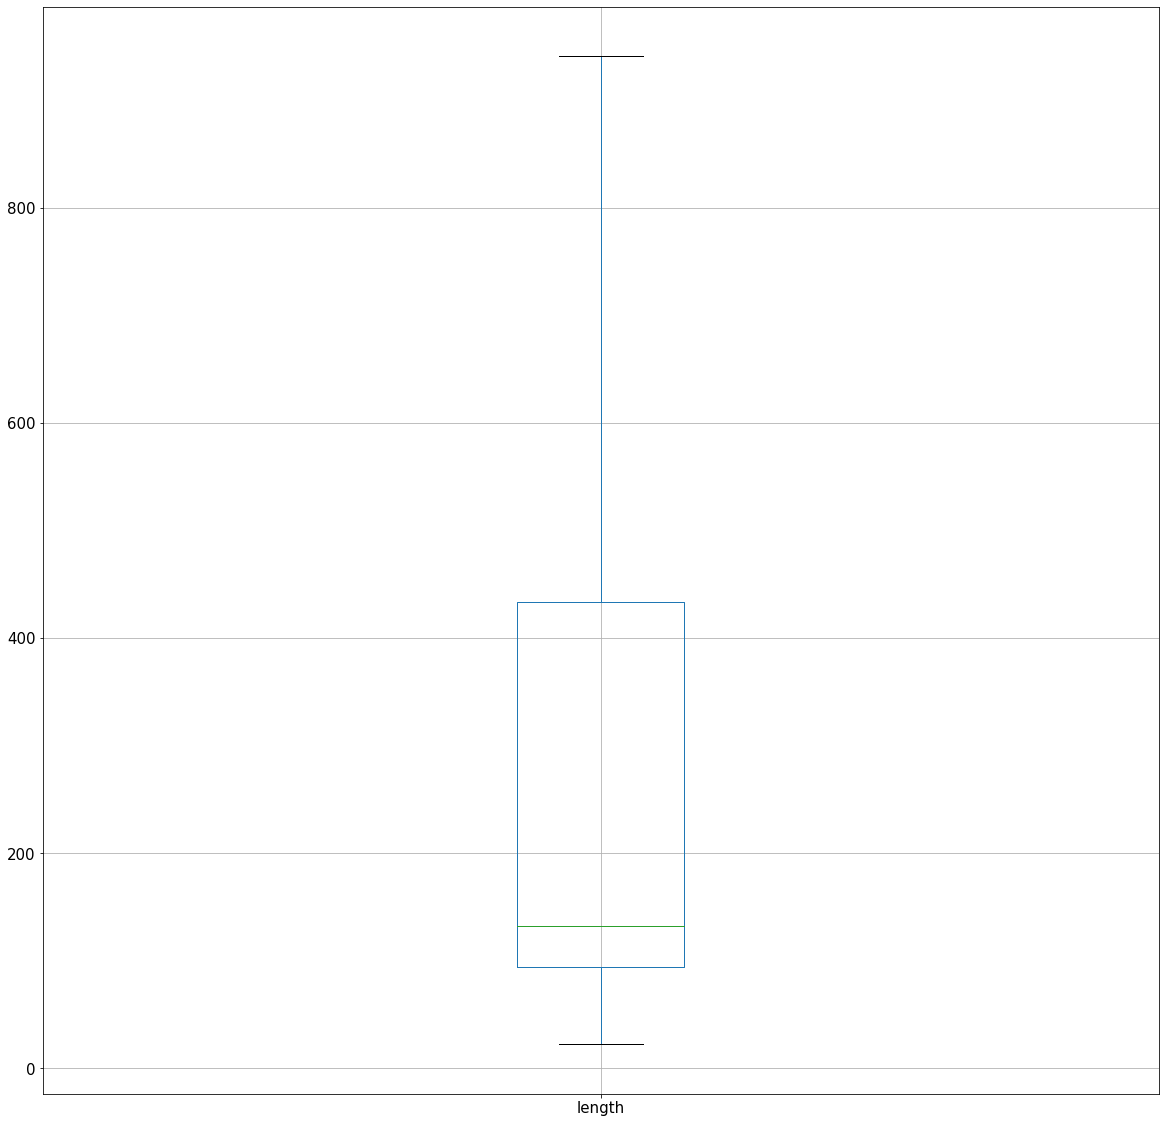

In [178]:
### --- Plotting the boxplot of Barke introns length without outliers
introns_Barke.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.1.4 Re-organizing files and directories

In [179]:
! ls Data/

Barke_exon.tsv	     Barke_nohashtag.gff3  raw
Barke_nohashtag.csv  Hv_Morex_longread


In [180]:
! mkdir Data/Barke

In [181]:
! mv Data/Barke_* Data/Barke/ 

In [182]:
! ls Data/Barke/

Barke_exon.tsv	Barke_nohashtag.csv  Barke_nohashtag.gff3


In [183]:
! ls Output/

Barke_intronlessIDs.txt  Barke_intronrichIDs.txt  Hv_Morex_longread
Barke_intronpoorIDs.txt  Barke_introns.tsv


In [184]:
! mkdir Output/Barke

In [185]:
! mv Output/Barke_* Output/Barke/

In [186]:
! ls Output/Barke/

Barke_intronlessIDs.txt  Barke_intronrichIDs.txt
Barke_intronpoorIDs.txt  Barke_introns.tsv


## 3.2 HOR10350 - De novo gene annotation

### 3.2.1 Data Collection

In [187]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR10350.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/4435ac3e-52f1-47df-9709-4c30e4d21131/1/DOWNLOAD

--2021-10-01 12:12:57--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/4435ac3e-52f1-47df-9709-4c30e4d21131/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62425776 (60M) [text/plain]
Saving to: ‘Data/raw/HOR10350.gff3’

Data/raw/HOR10350.g 100%[===================>]  59,53M  2,23MB/s    in 32s     

2021-10-01 12:13:29 (1,87 MB/s) - ‘Data/raw/HOR10350.gff3’ saved [62425776/62425776]



### 3.2.2 Processing Data

In [188]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR10350.gff3  > Data/HOR10350_nohashtag.gff3

In [189]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR10350_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR10350_nohashtag.csv

In [190]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR10350 = pd.read_csv('Data/HOR10350_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR10350.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,238613,241489,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010
1,chr1H,PGSB,mRNA,238613,241489,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1
2,chr1H,PGSB,exon,238613,238663,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,exon,238753,239079,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.2
4,chr1H,PGSB,exon,239393,239689,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.3


In [191]:
### --- Building a separate dataframe containing all exons
exon_HOR10350 = df_HOR10350.loc[df_HOR10350['type'].isin(['exon'])]
exon_HOR10350.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSB,exon,238613,238663,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,exon,238753,239079,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.2
4,chr1H,PGSB,exon,239393,239689,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.3
5,chr1H,PGSB,exon,239941,240021,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.4
6,chr1H,PGSB,exon,241352,241489,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.5


In [192]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR10350.to_csv('Data/HOR10350_exon.tsv',sep='\t',index=False,header=False)

In [193]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR10350 = df_HOR10350.loc[df_HOR10350['strand'].isin(['+'])]
forw_HOR10350.head()

,chr,source,type,start,end,score,strand,phase,attributes
40,chr1H,PGSB,gene,284284,284626,.,+,.,ID=HORVU.HOR_10350.r1.1HG0000040
41,chr1H,PGSB,mRNA,284284,284626,.,+,.,ID=HORVU.HOR_10350.r1.1HG0000040.1
42,chr1H,PGSB,exon,284284,284344,.,+,.,ID=HORVU.HOR_10350.r1.1HG0000040.1.exon.1
43,chr1H,PGSB,exon,284448,284626,.,+,.,ID=HORVU.HOR_10350.r1.1HG0000040.1.exon.2
44,chr1H,PGSB,CDS,284284,284344,.,+,0,ID=HORVU.HOR_10350.r1.1HG0000040.1.CDS.1


In [194]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR10350 = df_HOR10350.loc[df_HOR10350['strand'].isin(['-'])]
rev_HOR10350.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,238613,241489,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010
1,chr1H,PGSB,mRNA,238613,241489,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1
2,chr1H,PGSB,exon,238613,238663,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.1
3,chr1H,PGSB,exon,238753,239079,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.2
4,chr1H,PGSB,exon,239393,239689,.,-,.,ID=HORVU.HOR_10350.r1.1HG0000010.1.exon.3


In [195]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR10350 = forw_HOR10350.loc[df_HOR10350['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR10350.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [196]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR10350 = rev_HOR10350.loc[df_HOR10350['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR10350.head()

,chr,source,type,start,end,score,strand,phase,attributes


As before there are no UTRs due to a poor annotation. 

### 3.2.3 Extracting introns from the whole genome

In [197]:
### --- Extracting introns from HOR10350
extract_tot_introns('Data/HOR10350_exon.tsv', 'Output/HOR10350_introns.tsv')

In [198]:
introns_HOR10350 = pd.read_csv('Output/HOR10350_introns.tsv', sep = '\t')
introns_HOR10350[:100]

,ID,type,start,end,length
0,ID=HORVU.HOR_10350.r1.1HG0000010.1,intron,238664,238752,90
1,ID=HORVU.HOR_10350.r1.1HG0000010.1,intron,239080,239392,314
2,ID=HORVU.HOR_10350.r1.1HG0000010.1,intron,239690,239940,252
3,ID=HORVU.HOR_10350.r1.1HG0000010.1,intron,240022,241351,1331
4,ID=HORVU.HOR_10350.r1.1HG0000020.1,intron,255340,255447,109
...,...,...,...,...,...
95,ID=HORVU.HOR_10350.r1.1HG0000280.1,intron,1303603,1303835,234
96,ID=HORVU.HOR_10350.r1.1HG0000280.1,intron,1303970,1304106,138
97,ID=HORVU.HOR_10350.r1.1HG0000280.1,intron,1304183,1304283,102
98,ID=HORVU.HOR_10350.r1.1HG0000280.1,intron,1304314,1304400,88


In [199]:
### --- Counting introns type in HOR10350
introns_dictionary_HOR10350 = counting_introns_type(exon_HOR10350)

In [200]:
n_intronless_HOR10350, n_intronpoor_HOR10350, n_intronrich_HOR10350, intronless_HOR10350, intronpoor_HOR10350, intronrich_HOR10350 = splitting_introns_type(introns_dictionary_HOR10350)

Intronless are: 24866
Intronpoor are: 14709
Intronrich are: 11126


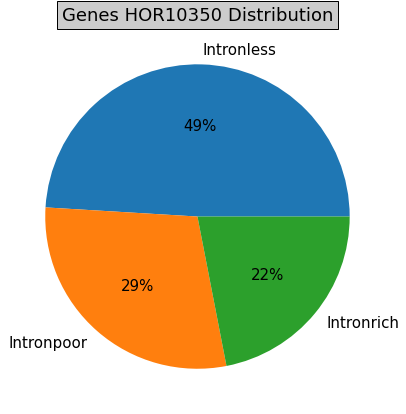

In [201]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_HOR10350 = [24866, 14709, 11126]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_HOR10350, labels = genes, autopct='%1.0f%%')
plt.title("Genes HOR10350 Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [202]:
### --- Creating the list of HOR10350 gene IDs to check the number of transcripts using command line
intronless_file_HOR10350 = open('Output/HOR10350_intronlessIDs.txt', 'a')
intronpoor_file_HOR10350 = open('Output/HOR10350_intronpoorIDs.txt', 'a')
intronrich_file_HOR10350 = open('Output/HOR10350_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR10350)):
    if i == len(intronless_HOR10350) -1:
        intronless_file_HOR10350.write(intronless_HOR10350[i])
    else:
        intronless_file_HOR10350.write(intronless_HOR10350[i] + '\n')
intronless_file_HOR10350.close()

for i in range(len(intronpoor_HOR10350)):
    if i == len(intronpoor_HOR10350) -1:
        intronpoor_file_HOR10350.write(intronpoor_HOR10350[i])
    else:
        intronpoor_file_HOR10350.write(intronpoor_HOR10350[i] + '\n')
intronpoor_file_HOR10350.close()

for i in range(len(intronrich_HOR10350)):
    if i == len(intronrich_HOR10350) -1:
        intronrich_file_HOR10350.write(intronrich_HOR10350[i])
    else:
        intronrich_file_HOR10350.write(intronrich_HOR10350[i]+'\n')
intronrich_file_HOR10350.close()

In [203]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR10350 = ! grep -f Output/HOR10350_intronlessIDs.txt Data/HOR10350_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR10350 = ! grep -f Output/HOR10350_intronpoorIDs.txt Data/HOR10350_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR10350 = ! grep -f Output/HOR10350_intronrichIDs.txt Data/HOR10350_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [204]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR10350 = int(n_mRNA_intronless_HOR10350[0])/n_intronless_HOR10350
print(avg_mRNA_intronless_HOR10350)
avg_mRNA_intronpoor_HOR10350 = int(n_mRNA_intronpoor_HOR10350[0])/n_intronpoor_HOR10350
print(avg_mRNA_intronpoor_HOR10350)
avg_mRNA_intronrich_HOR10350 = int(n_mRNA_intronrich_HOR10350[0])/n_intronrich_HOR10350
print(avg_mRNA_intronrich_HOR10350)

1.0
1.0
1.0


Once again no more than 1 transcript/gene annotated.

In [205]:
### --- Basic statistics of HOR10350 introns
introns_HOR10350['length'].describe()

count    118892.000000
mean        529.112581
std        1639.703205
min          22.000000
25%          94.000000
50%         132.000000
75%         436.000000
max      128956.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

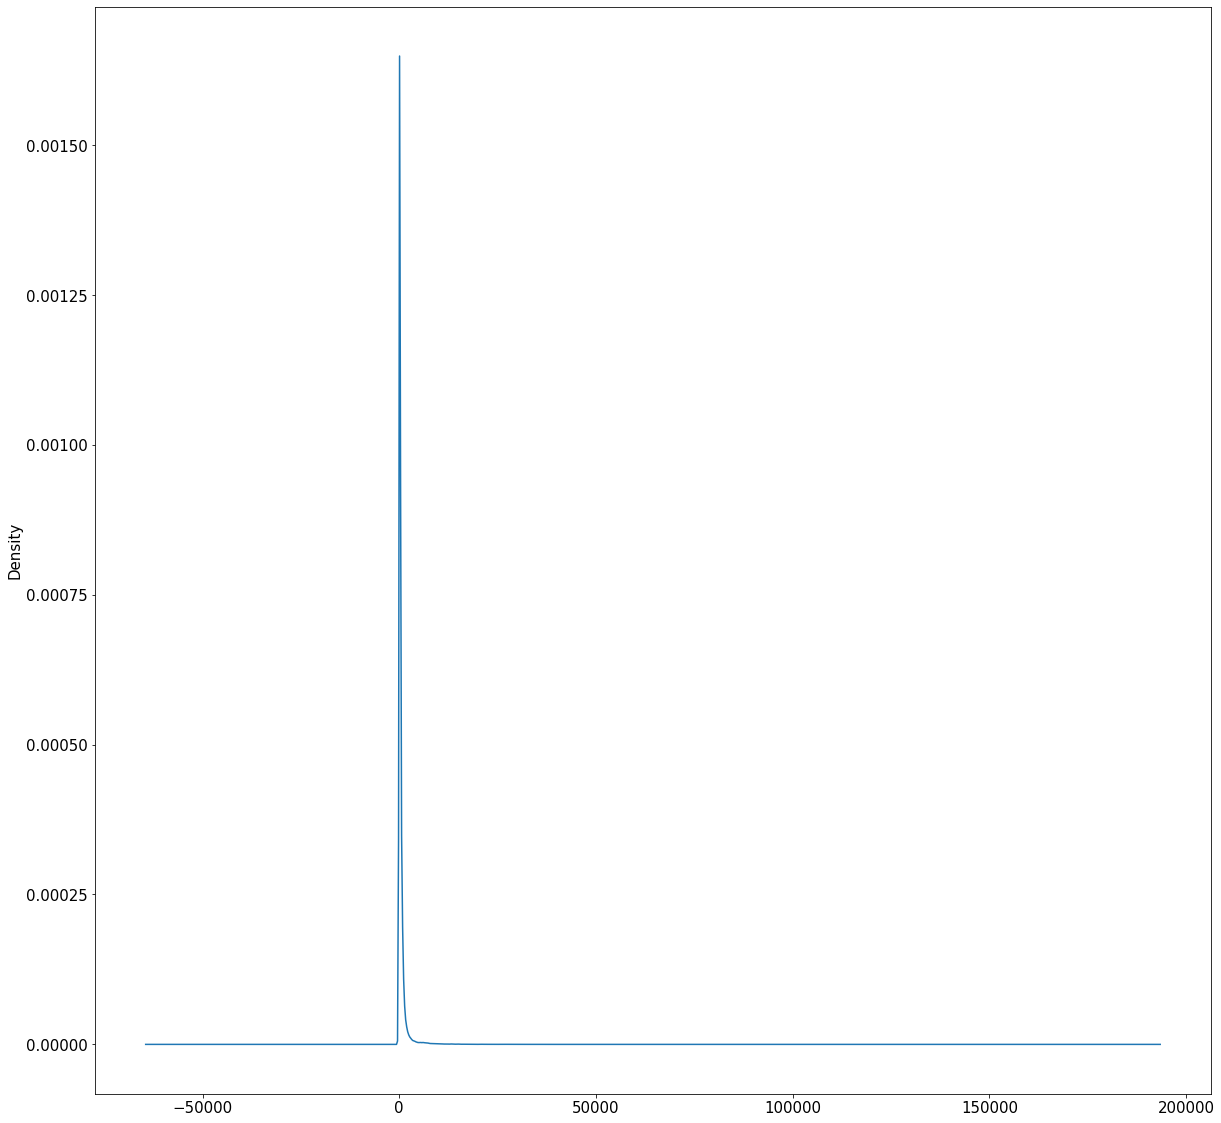

In [206]:
### --- Plotting the distribution of HOR10350 introns length
introns_HOR10350['length'].plot.density()

<AxesSubplot:>

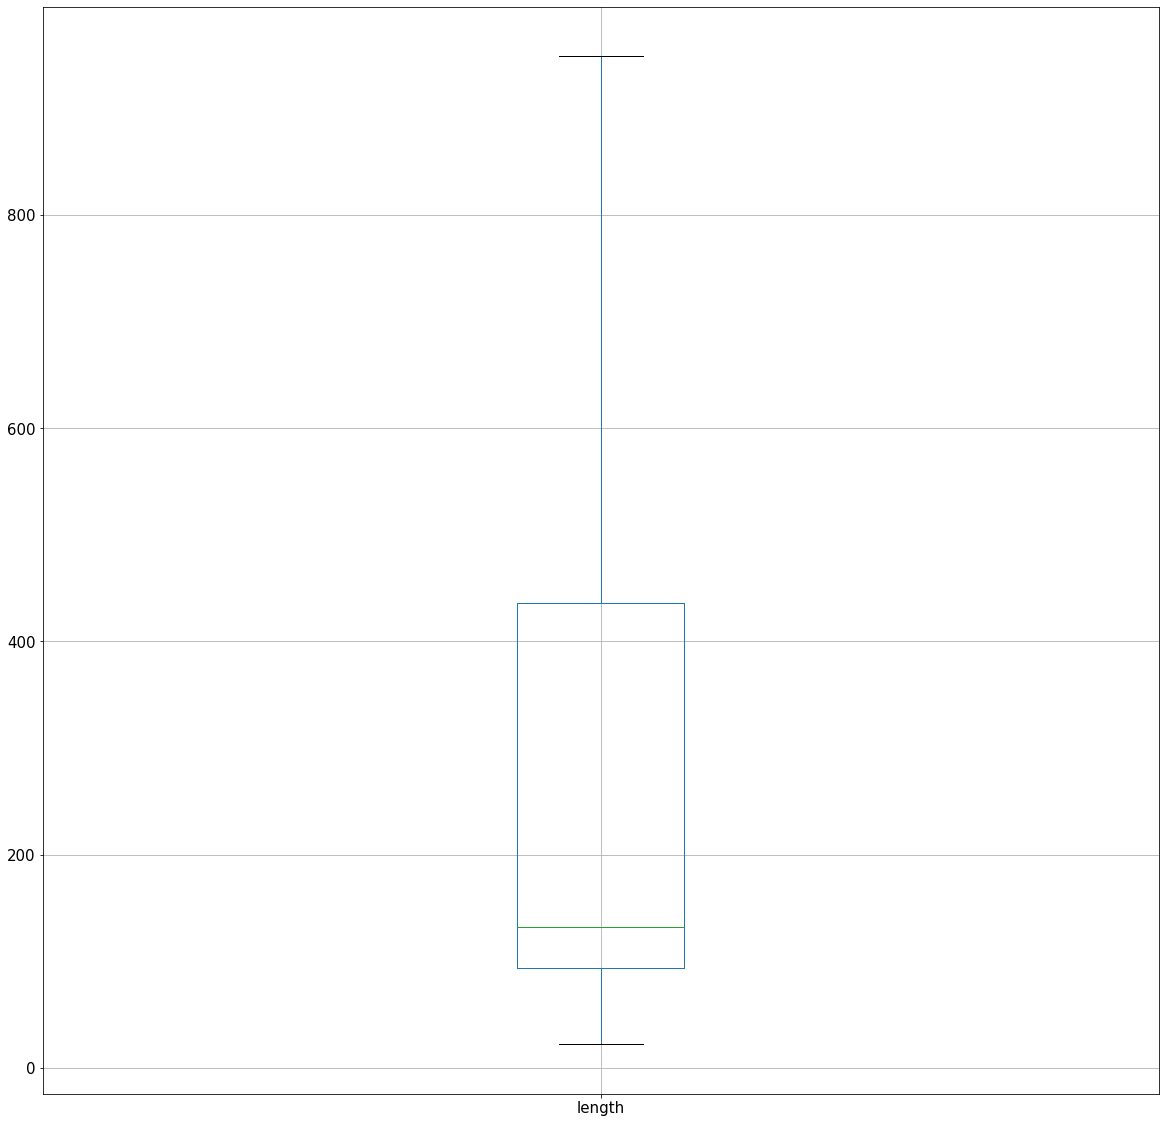

In [207]:
### --- Plotting the boxplot of HOR10350 introns length without outliers
introns_HOR10350.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.2.4 Re-organizing files and directories

In [208]:
! ls Data/

Barke		   HOR10350_nohashtag.csv   Hv_Morex_longread
HOR10350_exon.tsv  HOR10350_nohashtag.gff3  raw


In [209]:
! mkdir Data/HOR10350

In [210]:
! mv Data/HOR10350_* Data/HOR10350/

In [211]:
! ls Data/

Barke  HOR10350  Hv_Morex_longread  raw


In [212]:
! ls Output/

Barke			    HOR10350_intronpoorIDs.txt	HOR10350_introns.tsv
HOR10350_intronlessIDs.txt  HOR10350_intronrichIDs.txt	Hv_Morex_longread


In [213]:
! mkdir Output/HOR10350

In [214]:
! mv Output/HOR10350_* Output/HOR10350/

In [215]:
! ls Output/

Barke  HOR10350  Hv_Morex_longread


## 3.3 Morex - De novo gene annotation

### 3.3.1 Data collection

In [216]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Morex.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/f937d01e-f9cf-415a-961b-c490db136f92/1/DOWNLOAD

--2021-10-01 12:14:33--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/f937d01e-f9cf-415a-961b-c490db136f92/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70049779 (67M) [text/plain]
Saving to: ‘Data/raw/Morex.gff3’

Data/raw/Morex.gff3 100%[===================>]  66,80M  2,92MB/s    in 24s     

2021-10-01 12:14:58 (2,75 MB/s) - ‘Data/raw/Morex.gff3’ saved [70049779/70049779]



### 3.3.2 Processing Data

In [217]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [218]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Morex.gff3  > Data/Morex_nohashtag.gff3

In [219]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Morex_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Morex_nohashtag.csv

In [220]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Morex = pd.read_csv('Data/Morex_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,129733,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010
1,chr1H,PGSB,mRNA,129733,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1
2,chr1H,PGSB,exon,129733,129835,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1.exon.1
3,chr1H,PGSB,CDS,129733,129835,.,+,0,ID=HORVU.MOREX.r2.1HG0000010.1.CDS.1
4,chr1H,PGSB,exon,130121,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1.exon.2


In [221]:
### --- Building a separate dataframe containing all exons
exon_Morex = df_Morex.loc[df_Morex['type'].isin(['exon'])]
exon_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSB,exon,129733,129835,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1.exon.1
4,chr1H,PGSB,exon,130121,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1.exon.2
8,chr1H,PGSB,exon,142445,142903,.,+,.,ID=HORVU.MOREX.r2.1HG0000020.1.exon.1
10,chr1H,PGSB,exon,143335,144686,.,+,.,ID=HORVU.MOREX.r2.1HG0000020.1.exon.2
12,chr1H,PGSB,exon,144801,144911,.,+,.,ID=HORVU.MOREX.r2.1HG0000020.1.exon.3


In [222]:
### --- Exporting the exon dataframe to a tsv file 
exon_Morex.to_csv('Data/Morex_exon.tsv',sep='\t',index=False,header=False)

In [223]:
### --- Keeping in a separated dataframe the forward strands
forw_Morex = df_Morex.loc[df_Morex['strand'].isin(['+'])]
forw_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,129733,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010
1,chr1H,PGSB,mRNA,129733,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1
2,chr1H,PGSB,exon,129733,129835,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1.exon.1
3,chr1H,PGSB,CDS,129733,129835,.,+,0,ID=HORVU.MOREX.r2.1HG0000010.1.CDS.1
4,chr1H,PGSB,exon,130121,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010.1.exon.2


In [224]:
### --- Keeping in a separated dataframe the reverse strands
rev_Morex = df_Morex.loc[df_Morex['strand'].isin(['-'])]
rev_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
54,chr1H,PGSB,gene,165513,168763,.,-,.,ID=HORVU.MOREX.r2.1HG0000050
55,chr1H,PGSB,mRNA,165513,168763,.,-,.,ID=HORVU.MOREX.r2.1HG0000050.1
56,chr1H,PGSB,exon,165513,165734,.,-,.,ID=HORVU.MOREX.r2.1HG0000050.1.exon.1
57,chr1H,PGSB,CDS,165513,165734,.,-,0,ID=HORVU.MOREX.r2.1HG0000050.1.CDS.1
58,chr1H,PGSB,exon,166213,166374,.,-,.,ID=HORVU.MOREX.r2.1HG0000050.1.exon.2


In [225]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Morex = forw_Morex.loc[df_Morex['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [226]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Morex = rev_Morex.loc[df_Morex['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes


As in the other cases no UTRs annotated.

### 3.3.3 Extracting introns from the whole genome

In [227]:
### --- Extracting introns from Morex
extract_tot_introns('Data/Morex_exon.tsv', 'Output/Morex_introns.tsv')

In [228]:
introns_Morex = pd.read_csv('Output/Morex_introns.tsv', sep = '\t')
introns_Morex[:100]

,ID,type,start,end,length
0,ID=HORVU.MOREX.r2.1HG0000010.1,intron,129836,130120,286
1,ID=HORVU.MOREX.r2.1HG0000020.1,intron,142904,143334,432
2,ID=HORVU.MOREX.r2.1HG0000020.1,intron,144687,144800,115
3,ID=HORVU.MOREX.r2.1HG0000020.1,intron,144912,145021,111
4,ID=HORVU.MOREX.r2.1HG0000020.1,intron,145299,145392,95
...,...,...,...,...,...
95,ID=HORVU.MOREX.r2.1HG0000240.1,intron,734325,734933,610
96,ID=HORVU.MOREX.r2.1HG0000250.1,intron,736456,736557,103
97,ID=HORVU.MOREX.r2.1HG0000260.1,intron,743659,743739,82
98,ID=HORVU.MOREX.r2.1HG0000260.1,intron,746154,748998,2846


In [229]:
### --- Counting introns type in Morex
introns_dictionary_Morex = counting_introns_type(exon_Morex)

In [230]:
n_intronless_Morex, n_intronpoor_Morex, n_intronrich_Morex, intronless_Morex, intronpoor_Morex, intronrich_Morex = splitting_introns_type(introns_dictionary_Morex)

Intronless are: 33663
Intronpoor are: 17811
Intronrich are: 12184


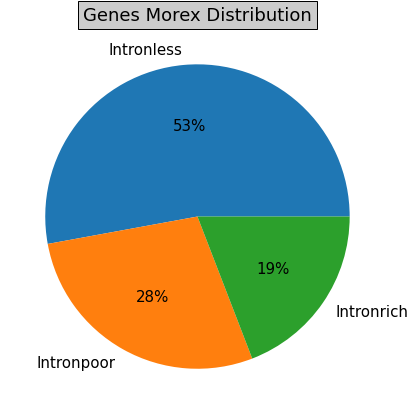

In [231]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Morex = [33663, 17811, 12184]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Morex, labels = genes, autopct='%1.0f%%')
plt.title("Genes Morex Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [232]:
### --- Creating the list of Morex gene IDs to check the number of transcripts using command line
intronless_file_Morex = open('Output/Morex_intronlessIDs.txt', 'a')
intronpoor_file_Morex = open('Output/Morex_intronpoorIDs.txt', 'a')
intronrich_file_Morex = open('Output/Morex_intronrichIDs.txt', 'a')
for i in range(len(intronless_Morex)):
    if i == len(intronless_Morex) -1:
        intronless_file_Morex.write(intronless_Morex[i])
    else:
        intronless_file_Morex.write(intronless_Morex[i] + '\n')
intronless_file_Morex.close()

for i in range(len(intronpoor_Morex)):
    if i == len(intronpoor_Morex) -1:
        intronpoor_file_Morex.write(intronpoor_Morex[i])
    else:
        intronpoor_file_Morex.write(intronpoor_Morex[i] + '\n')
intronpoor_file_Morex.close()

for i in range(len(intronrich_Morex)):
    if i == len(intronrich_Morex) -1:
        intronrich_file_Morex.write(intronrich_Morex[i])
    else:
        intronrich_file_Morex.write(intronrich_Morex[i]+'\n')
intronrich_file_Morex.close()

In [233]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Morex = ! grep -f Output/Morex_intronlessIDs.txt Data/Morex_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Morex = ! grep -f Output/Morex_intronpoorIDs.txt Data/Morex_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Morex = ! grep -f Output/Morex_intronrichIDs.txt Data/Morex_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [234]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Morex = int(n_mRNA_intronless_Morex[0])/n_intronless_Morex
print(avg_mRNA_intronless_Morex)
avg_mRNA_intronpoor_Morex = int(n_mRNA_intronpoor_Morex[0])/n_intronpoor_Morex
print(avg_mRNA_intronpoor_Morex)
avg_mRNA_intronrich_Morex = int(n_mRNA_intronrich_Morex[0])/n_intronrich_Morex
print(avg_mRNA_intronrich_Morex)

1.0
1.0
1.0


Poor annotation once again. 

In [235]:
### --- Basic statistics of Morex introns
introns_Morex['length'].describe()

count    131774.000000
mean        543.607259
std        1584.931969
min          23.000000
25%          94.000000
50%         133.000000
75%         452.000000
max       47239.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

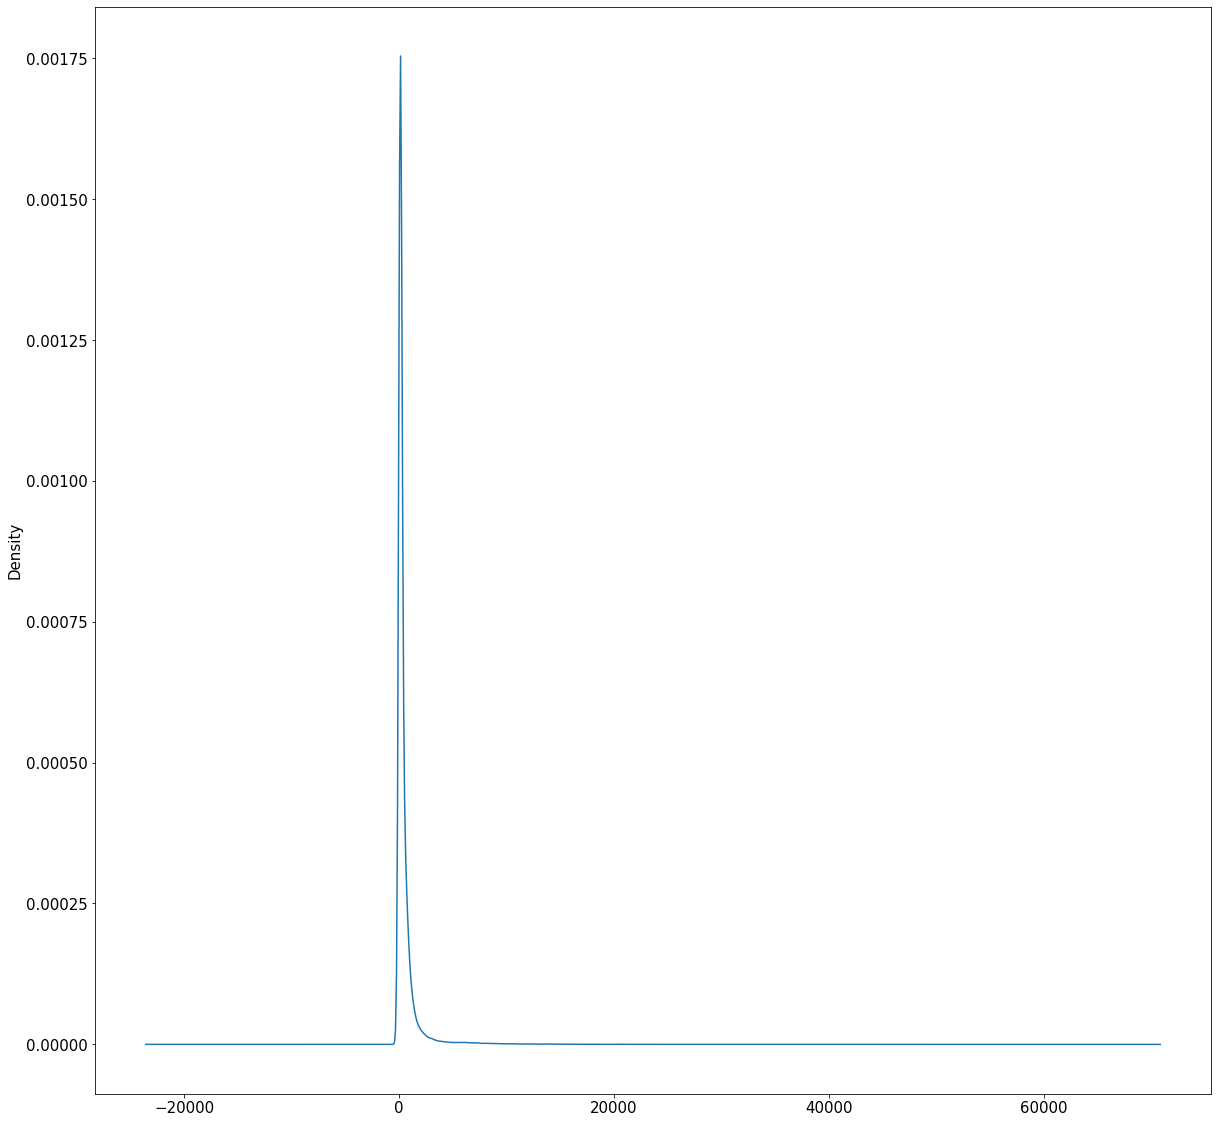

In [236]:
### --- Plotting the distribution of Morex introns length
introns_Morex['length'].plot.density()

<AxesSubplot:>

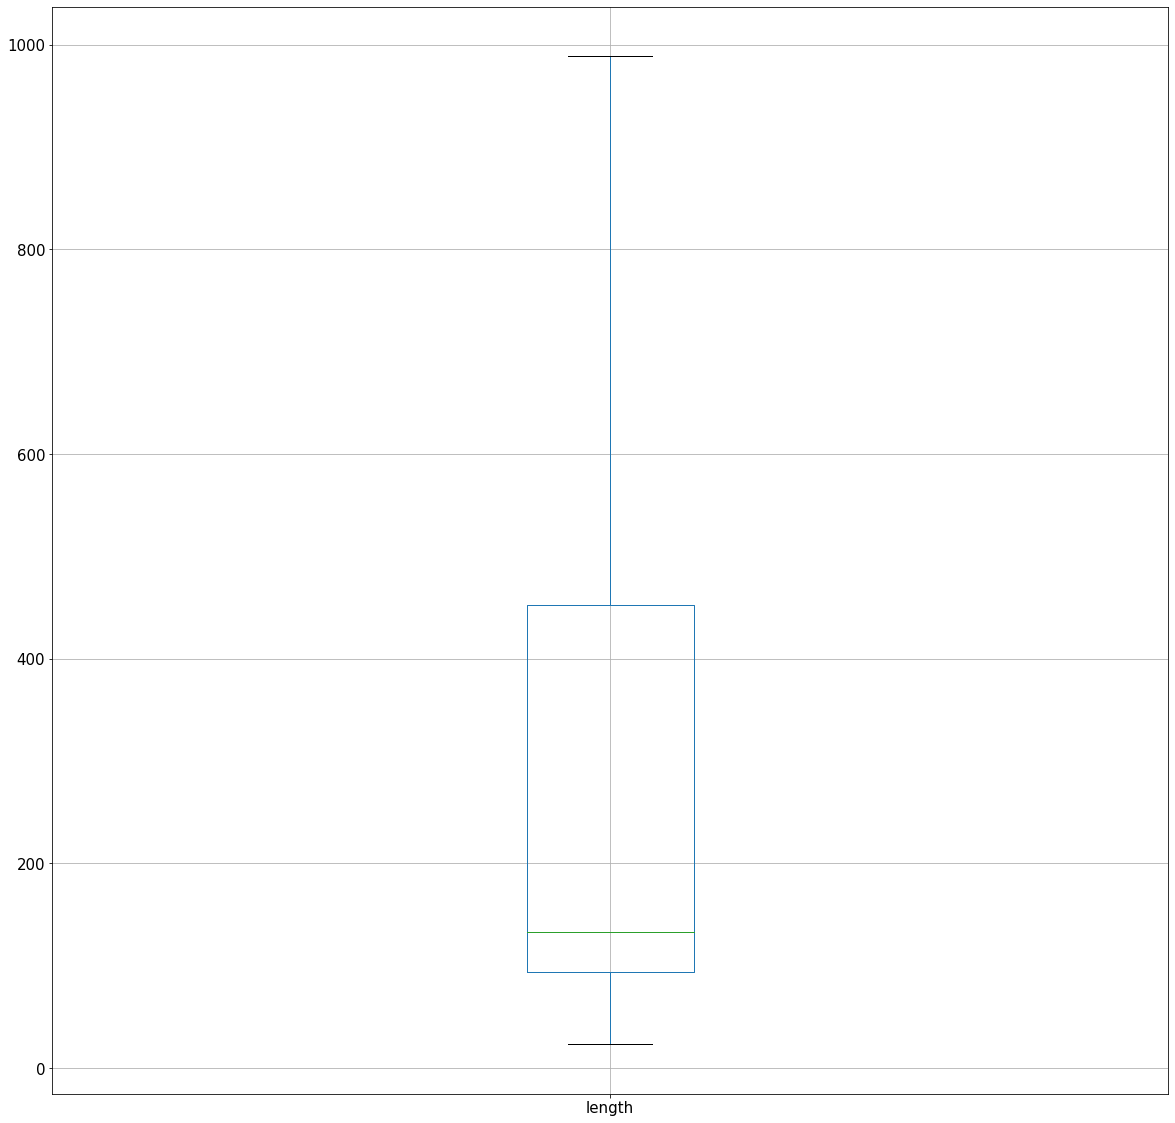

In [237]:
### --- Plotting the boxplot of Morex introns length without outliers
introns_Morex.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.3.4 Re-organizing files and directories

In [238]:
! ls Data/

Barke	  Hv_Morex_longread  Morex_nohashtag.csv   raw
HOR10350  Morex_exon.tsv     Morex_nohashtag.gff3


In [239]:
! mkdir Data/Morex

In [240]:
! mv Data/Morex_* Data/Morex/

In [241]:
! ls Data/

Barke  HOR10350  Hv_Morex_longread  Morex  raw


In [242]:
! ls Output/

Barke	  Hv_Morex_longread	   Morex_intronpoorIDs.txt  Morex_introns.tsv
HOR10350  Morex_intronlessIDs.txt  Morex_intronrichIDs.txt


In [243]:
! mkdir Output/Morex

In [244]:
! mv Output/Morex_* Output/Morex/

In [245]:
! ls Output/

Barke  HOR10350  Hv_Morex_longread  Morex


## 3.4 Re-defining the functions due to a different 9th field format of the genomes within the Gene_projection directory

In [246]:
### --- Function to extract introns from the whole genome
### --- Infile is a file like Akashinriki_exon.tsv 
### --- Outfile will be written thanks to this function
### --- If there are two or more exons belonging to the same mRNA one after the other it compute the introns separating them
def extract_tot_introns_gp(infile, outfile):
    introns = open(outfile, 'a') 
    introns.write('ID'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'length') 
    with open(infile) as f: 
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines): # This is to avoid out of range error
                break 
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if '_'.join(line[8].split('_')[0:3]) != '_'.join(next_line[8].split('_')[0:3]): continue # Checking if the next exon has the same ID of the one we are at
                
                introns.write('\n'+'_'.join(line[8].split('_')[0:3])+'\t'+ 'intron ' +'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    introns.close()


In [247]:
### --- Function to count introns within a dataframe made of exons formatted like exon_Akashinriki

def counting_introns_type_gp(in_dataframe):
    counts = dict()
    for i in in_dataframe['attributes']:
        counts['_'.join(i.split('_')[0:3])] = counts.get('_'.join(i.split('_')[0:3]), 0) + 1
    return counts

In [248]:
### --- Function to extract introns from UTR regions.
### --- Infile is a file like Akashinriki_UTRforw_introns.tsv 
### --- Outfile will be written thanks to this function
### --- Being all on the same strand when two or more UTRs of the same type are one row after the other it means there is a intron separating them
def extract_UTR_introns_gp(infile, outfile):
    UTR_introns_forw = open(outfile, 'a')
    UTR_introns_forw.write('ID'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'length') # Defining the header
    with open(infile) as f:
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines):
                break
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if line[2] != next_line[2] or '_'.join(line[8].split('_')[0:3]) != '_'.join(next_line[8].split('_')[0:3]): continue
                
                UTR_introns_forw.write('\n'+'_'.join(line[8].split('_')[0:3])+'\t'+ 'intron '+line[2]+'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    UTR_introns_forw.close()

## 3.5 Akashinriki - Gene projection

### 3.5.1 Data collection

In [249]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Akashinriki.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/325492c0-89ef-4beb-87ef-c2372093a918/1/DOWNLOAD

--2021-10-01 12:16:34--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/325492c0-89ef-4beb-87ef-c2372093a918/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53597597 (51M) [text/plain]
Saving to: ‘Data/raw/Akashinriki.gff3’

Data/raw/Akashinrik 100%[===================>]  51,11M  2,18MB/s    in 28s     

2021-10-01 12:17:03 (1,79 MB/s) - ‘Data/raw/Akashinriki.gff3’ saved [53597597/53597597]



### 3.5.2 Processing Data

In [250]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [251]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Akashinriki.gff3  > Data/Akashinriki_nohashtag.gff3

In [252]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Akashinriki_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Akashinriki_nohashtag.csv

In [253]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Akashinriki = pd.read_csv('Data/Akashinriki_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Akashinriki.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,5070,8545,2072.693,+,.,ID=Horvu_AKASHIN_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,5070,8545,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,5070,5510,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,7916,8545,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,5070,5510,.,+,0,Parent=Horvu_AKASHIN_1H01G000100.1


In [254]:
### --- Building a separate dataframe containing all exons
exon_Akashinriki = df_Akashinriki.loc[df_Akashinriki['type'].isin(['exon'])]
exon_Akashinriki.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,5070,5510,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,7916,8545,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,11804,11974,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1_exon_10
9,chr1H,PGSBv2.28112019,exon,12724,12861,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1_exon_9
10,chr1H,PGSBv2.28112019,exon,13031,13250,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1_exon_8


In [255]:
### --- Exporting the exon dataframe to a tsv file 
exon_Akashinriki.to_csv('Data/Akashinriki_exon.tsv',sep='\t',index=False,header=False)

In [256]:
### --- Keeping in a separated dataframe the forward strands
forw_Akashinriki = df_Akashinriki.loc[df_Akashinriki['strand'].isin(['+'])]
forw_Akashinriki.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,5070,8545,2072.693,+,.,ID=Horvu_AKASHIN_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,5070,8545,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,5070,5510,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,7916,8545,.,+,.,ID=Horvu_AKASHIN_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,5070,5510,.,+,0,Parent=Horvu_AKASHIN_1H01G000100.1


In [257]:
### --- Keeping in a separated dataframe the reverse strands
rev_Akashinriki = df_Akashinriki.loc[df_Akashinriki['strand'].isin(['-'])]
rev_Akashinriki.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,PGSBv2.28112019,gene,11804,19027,2763.311,-,.,ID=Horvu_AKASHIN_1H01G000200
7,chr1H,PGSBv2.28112019,mRNA,11804,19027,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1
8,chr1H,PGSBv2.28112019,exon,11804,11974,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1_exon_10
9,chr1H,PGSBv2.28112019,exon,12724,12861,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1_exon_9
10,chr1H,PGSBv2.28112019,exon,13031,13250,.,-,.,ID=Horvu_AKASHIN_1H01G000200.1_exon_8


In [258]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Akashinriki = forw_Akashinriki.loc[df_Akashinriki['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Akashinriki.head()


,chr,source,type,start,end,score,strand,phase,attributes


In [259]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Akashinriki = rev_Akashinriki.loc[df_Akashinriki['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Akashinriki.head()

,chr,source,type,start,end,score,strand,phase,attributes


Still no UTRs.

### 3.5.3 Extracting introns from the whole genome

In [260]:
### --- Extracting introns from Akashinriki
extract_tot_introns_gp('Data/Akashinriki_exon.tsv', 'Output/Akashinriki_introns.tsv')

In [261]:
introns_Akashinriki = pd.read_csv('Output/Akashinriki_introns.tsv', sep = '\t')
introns_Akashinriki[:100]

,ID,type,start,end,length
0,ID=Horvu_AKASHIN_1H01G000100.1,intron,5511,7915,2406
1,ID=Horvu_AKASHIN_1H01G000200.1,intron,11975,12723,750
2,ID=Horvu_AKASHIN_1H01G000200.1,intron,12862,13030,170
3,ID=Horvu_AKASHIN_1H01G000200.1,intron,13251,13592,343
4,ID=Horvu_AKASHIN_1H01G000200.1,intron,13663,13752,91
...,...,...,...,...,...
95,ID=Horvu_AKASHIN_1H01G002700.1,intron,1077104,1077194,92
96,ID=Horvu_AKASHIN_1H01G002700.1,intron,1077284,1077699,417
97,ID=Horvu_AKASHIN_1H01G002700.1,intron,1077820,1077907,89
98,ID=Horvu_AKASHIN_1H01G002700.1,intron,1077979,1078194,217


In [262]:
### --- Counting introns type in Akashinriki
introns_dictionary_Akashinriki = counting_introns_type_gp(exon_Akashinriki)

In [263]:
n_intronless_Akashinriki, n_intronpoor_Akashinriki, n_intronrich_Akashinriki, intronless_Akashinriki, intronpoor_Akashinriki, intronrich_Akashinriki = splitting_introns_type(introns_dictionary_Akashinriki)

Intronless are: 16635
Intronpoor are: 18474
Intronrich are: 12050


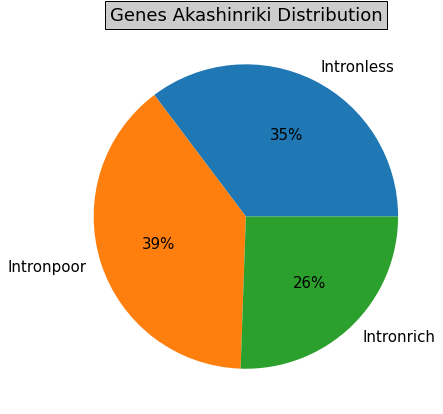

In [264]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Akashinriki = [16635, 18474, 12050]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Akashinriki, labels = genes, autopct='%1.0f%%')
plt.title("Genes Akashinriki Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [265]:
### --- Creating the list of Akashinriki gene IDs to check the number of transcripts using command line
intronless_file_Akashinriki = open('Output/Akashinriki_intronlessIDs.txt', 'a')
intronpoor_file_Akashinriki = open('Output/Akashinriki_intronpoorIDs.txt', 'a')
intronrich_file_Akashinriki = open('Output/Akashinriki_intronrichIDs.txt', 'a')
for i in range(len(intronless_Akashinriki)):
    if i == len(intronless_Akashinriki) -1:
        intronless_file_Akashinriki.write(intronless_Akashinriki[i])
    else:
        intronless_file_Akashinriki.write(intronless_Akashinriki[i] + '\n')
intronless_file_Akashinriki.close()

for i in range(len(intronpoor_Akashinriki)):
    if i == len(intronpoor_Akashinriki) -1:
        intronpoor_file_Akashinriki.write(intronpoor_Akashinriki[i])
    else:
        intronpoor_file_Akashinriki.write(intronpoor_Akashinriki[i] + '\n')
intronpoor_file_Akashinriki.close()

for i in range(len(intronrich_Akashinriki)):
    if i == len(intronrich_Akashinriki) -1:
        intronrich_file_Akashinriki.write(intronrich_Akashinriki[i])
    else:
        intronrich_file_Akashinriki.write(intronrich_Akashinriki[i]+'\n')
intronrich_file_Akashinriki.close()

In [266]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Akashinriki = ! grep -f Output/Akashinriki_intronlessIDs.txt Data/Akashinriki_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Akashinriki = ! grep -f Output/Akashinriki_intronpoorIDs.txt Data/Akashinriki_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Akashinriki = ! grep -f Output/Akashinriki_intronrichIDs.txt Data/Akashinriki_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [267]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Akashinriki = int(n_mRNA_intronless_Akashinriki[0])/n_intronless_Akashinriki
print(avg_mRNA_intronless_Akashinriki)
avg_mRNA_intronpoor_Akashinriki = int(n_mRNA_intronpoor_Akashinriki[0])/n_intronpoor_Akashinriki
print(avg_mRNA_intronpoor_Akashinriki)
avg_mRNA_intronrich_Akashinriki = int(n_mRNA_intronrich_Akashinriki[0])/n_intronrich_Akashinriki
print(avg_mRNA_intronrich_Akashinriki)

1.0
1.0
1.0


Still no alternative splicing annotated.

In [268]:
### --- Basic statistics of Akashinriki introns
introns_Akashinriki['length'].describe()

count    130501.000000
mean        601.838507
std        2340.509460
min           1.000000
25%          91.000000
50%         124.000000
75%         424.000000
max      242106.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

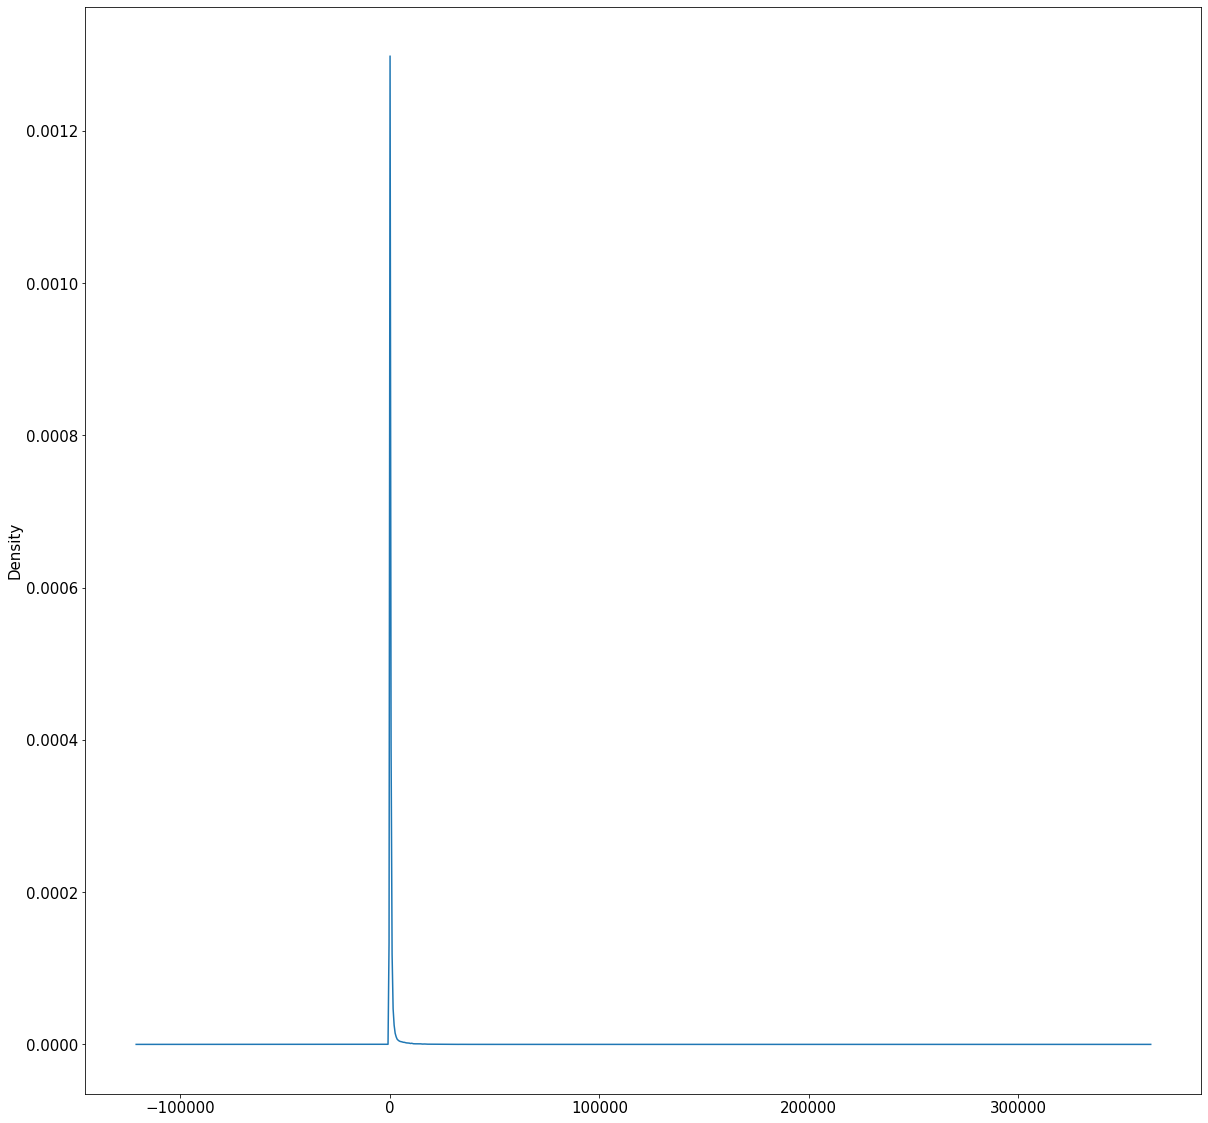

In [269]:
### --- Plotting the distribution of Akashinriki introns length
introns_Akashinriki['length'].plot.density()

<AxesSubplot:>

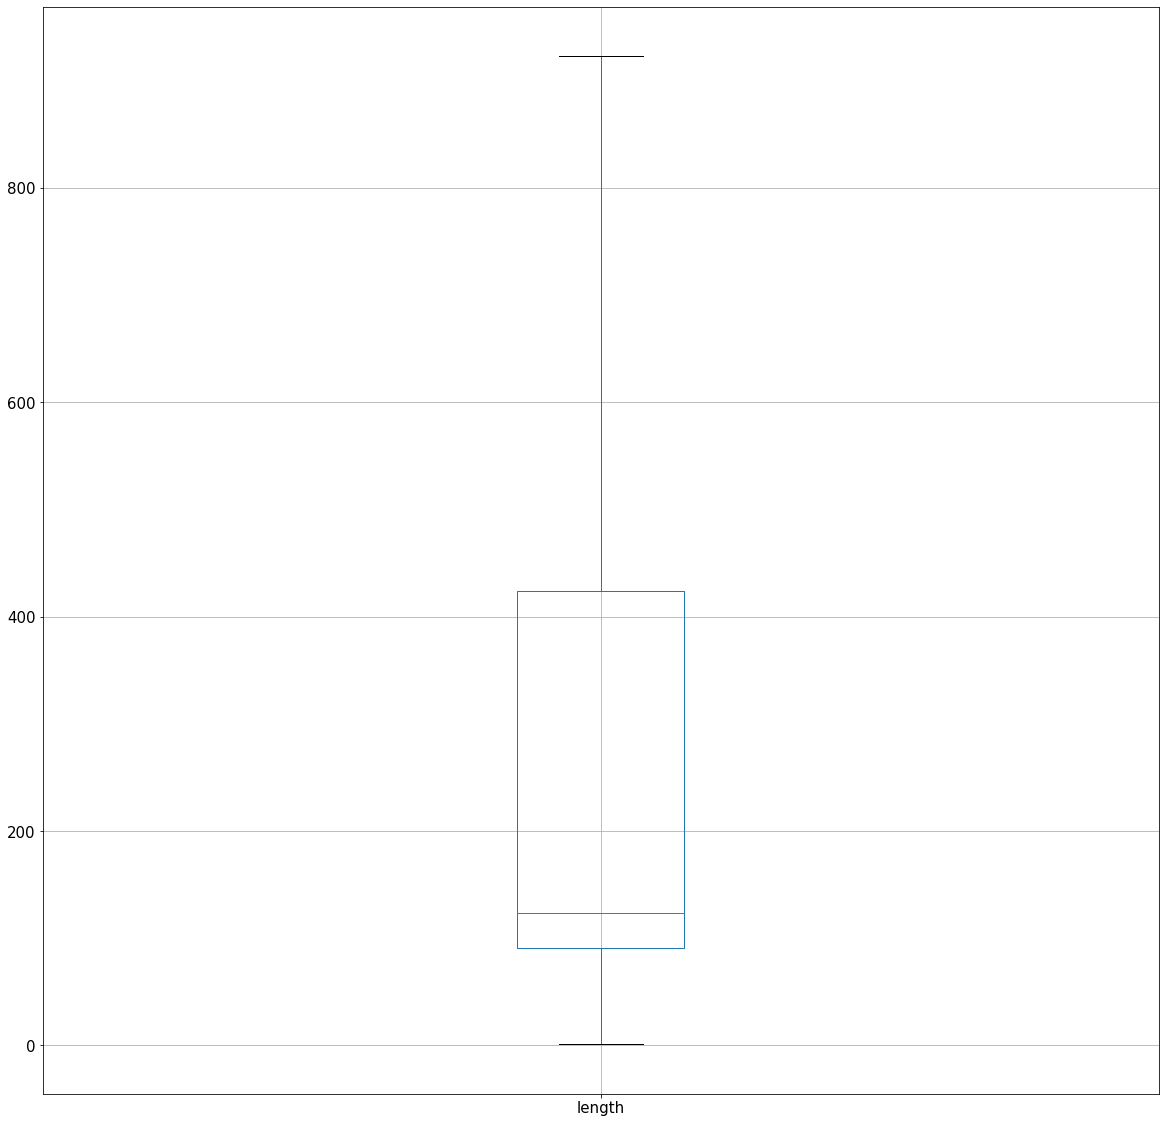

In [270]:
### --- Plotting the boxplot of Akashinriki introns length without outliers
introns_Akashinriki.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.5.4 Re-organizing files and directories

In [271]:
! ls Data/

Akashinriki_exon.tsv	   Akashinriki_nohashtag.gff3  HOR10350		  Morex
Akashinriki_nohashtag.csv  Barke		       Hv_Morex_longread  raw


In [272]:
! mkdir Data/Akashinriki 

In [273]:
! mv Data/Akashinriki_* Data/Akashinriki/

In [274]:
! ls Data/

Akashinriki  Barke  HOR10350  Hv_Morex_longread  Morex	raw


In [275]:
! ls Output/ 

Akashinriki_intronlessIDs.txt  Akashinriki_introns.tsv	Hv_Morex_longread
Akashinriki_intronpoorIDs.txt  Barke			Morex
Akashinriki_intronrichIDs.txt  HOR10350


In [276]:
! mkdir Output/Akashinriki

In [277]:
! mv Output/Akashinriki_* Output/Akashinriki/

In [278]:
! ls Output/

Akashinriki  Barke  HOR10350  Hv_Morex_longread  Morex


## 3.6 B1K_04_12 - Gene projection

### 3.6.1 Data collection

In [279]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/B1K.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/0ae99eec-5c46-41b6-83ab-f7f4b4e2f86c/1/DOWNLOAD

--2021-10-01 12:17:18--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/0ae99eec-5c46-41b6-83ab-f7f4b4e2f86c/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51759801 (49M) [text/plain]
Saving to: ‘Data/raw/B1K.gff3’

Data/raw/B1K.gff3   100%[===================>]  49,36M  1,81MB/s    in 27s     

2021-10-01 12:17:45 (1,84 MB/s) - ‘Data/raw/B1K.gff3’ saved [51759801/51759801]



### 3.6.2 Processing Data

In [280]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [281]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/B1K.gff3  > Data/B1K_nohashtag.gff3

In [282]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/B1K_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/B1K_nohashtag.csv

In [283]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_B1K = pd.read_csv('Data/B1K_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_B1K.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,56490,65056,2821.964,-,.,ID=Horvu_FT11_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,56490,65056,.,-,.,ID=Horvu_FT11_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,56490,56618,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,56624,56662,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,56833,56970,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_8


In [284]:
### --- Building a separate dataframe containing all exons
exon_B1K = df_B1K.loc[df_B1K['type'].isin(['exon'])]
exon_B1K.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,56490,56618,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,56624,56662,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,56833,56970,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_8
5,chr1H,PGSBv2.28112019,exon,57142,57357,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_7
6,chr1H,PGSBv2.28112019,exon,57703,57776,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_6


In [285]:
### --- Exporting the exon dataframe to a tsv file 
exon_B1K.to_csv('Data/B1K_exon.tsv',sep='\t',index=False,header=False)

In [286]:
### --- Keeping in a separated dataframe the forward strands
forw_B1K = df_B1K.loc[df_B1K['strand'].isin(['+'])]
forw_B1K.head()

,chr,source,type,start,end,score,strand,phase,attributes
22,chr1H,PGSBv2.28112019,gene,76489,78121,2492.776,+,.,ID=Horvu_FT11_1H01G000200
23,chr1H,PGSBv2.28112019,mRNA,76489,78121,.,+,.,ID=Horvu_FT11_1H01G000200.1
24,chr1H,PGSBv2.28112019,exon,76489,76805,.,+,.,ID=Horvu_FT11_1H01G000200.1_exon_1
25,chr1H,PGSBv2.28112019,exon,77042,77213,.,+,.,ID=Horvu_FT11_1H01G000200.1_exon_2
26,chr1H,PGSBv2.28112019,exon,77295,77649,.,+,.,ID=Horvu_FT11_1H01G000200.1_exon_3


In [287]:
### --- Keeping in a separated dataframe the reverse strands
rev_B1K = df_B1K.loc[df_B1K['strand'].isin(['-'])]
rev_B1K.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,56490,65056,2821.964,-,.,ID=Horvu_FT11_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,56490,65056,.,-,.,ID=Horvu_FT11_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,56490,56618,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,56624,56662,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,56833,56970,.,-,.,ID=Horvu_FT11_1H01G000100.1_exon_8


In [288]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_B1K = forw_B1K.loc[df_B1K['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_B1K.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [289]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_B1K = rev_B1K.loc[df_B1K['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_B1K.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.6.3 Extracting introns from the whole genome

In [290]:
### --- Extracting introns from B1K
extract_tot_introns_gp('Data/B1K_exon.tsv', 'Output/B1K_introns.tsv')

In [291]:
introns_B1K = pd.read_csv('Output/B1K_introns.tsv', sep = '\t')
introns_B1K[:100]

,ID,type,start,end,length
0,ID=Horvu_FT11_1H01G000100.1,intron,56619,56623,6
1,ID=Horvu_FT11_1H01G000100.1,intron,56663,56832,171
2,ID=Horvu_FT11_1H01G000100.1,intron,56971,57141,172
3,ID=Horvu_FT11_1H01G000100.1,intron,57358,57702,346
4,ID=Horvu_FT11_1H01G000100.1,intron,57777,57870,95
...,...,...,...,...,...
95,ID=Horvu_FT11_1H01G003200.1,intron,1493228,1493342,116
96,ID=Horvu_FT11_1H01G003300.1,intron,1512751,1512846,97
97,ID=Horvu_FT11_1H01G003300.1,intron,1513098,1513203,107
98,ID=Horvu_FT11_1H01G003400.1,intron,1517301,1517699,400


In [292]:
### --- Counting introns type in B1K
introns_dictionary_B1K = counting_introns_type_gp(exon_B1K)

In [293]:
n_intronless_B1K, n_intronpoor_B1K, n_intronrich_B1K, intronless_B1K, intronpoor_B1K, intronrich_B1K = splitting_introns_type(introns_dictionary_B1K)

Intronless are: 17002
Intronpoor are: 18551
Intronrich are: 12034


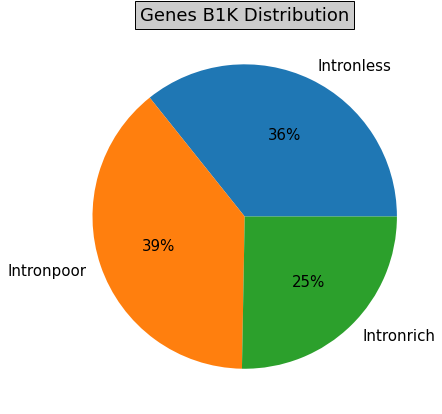

In [294]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_B1K = [17002, 18551, 12034]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_B1K, labels = genes, autopct='%1.0f%%')
plt.title("Genes B1K Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [295]:
### --- Creating the list of B1K gene IDs to check the number of transcripts using command line
intronless_file_B1K = open('Output/B1K_intronlessIDs.txt', 'a')
intronpoor_file_B1K = open('Output/B1K_intronpoorIDs.txt', 'a')
intronrich_file_B1K = open('Output/B1K_intronrichIDs.txt', 'a')
for i in range(len(intronless_B1K)):
    if i == len(intronless_B1K) -1:
        intronless_file_B1K.write(intronless_B1K[i])
    else:
        intronless_file_B1K.write(intronless_B1K[i] + '\n')
intronless_file_B1K.close()

for i in range(len(intronpoor_B1K)):
    if i == len(intronpoor_B1K) -1:
        intronpoor_file_B1K.write(intronpoor_B1K[i])
    else:
        intronpoor_file_B1K.write(intronpoor_B1K[i] + '\n')
intronpoor_file_B1K.close()

for i in range(len(intronrich_B1K)):
    if i == len(intronrich_B1K) -1:
        intronrich_file_B1K.write(intronrich_B1K[i])
    else:
        intronrich_file_B1K.write(intronrich_B1K[i]+'\n')
intronrich_file_B1K.close()

In [296]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_B1K = ! grep -f Output/B1K_intronlessIDs.txt Data/B1K_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_B1K = ! grep -f Output/B1K_intronpoorIDs.txt Data/B1K_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_B1K = ! grep -f Output/B1K_intronrichIDs.txt Data/B1K_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [297]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_B1K = int(n_mRNA_intronless_B1K[0])/n_intronless_B1K
print(avg_mRNA_intronless_B1K)
avg_mRNA_intronpoor_B1K = int(n_mRNA_intronpoor_B1K[0])/n_intronpoor_B1K
print(avg_mRNA_intronpoor_B1K)
avg_mRNA_intronrich_B1K = int(n_mRNA_intronrich_B1K[0])/n_intronrich_B1K
print(avg_mRNA_intronrich_B1K)

1.0
1.0
1.0


In [298]:
### --- Basic statistics of B1K introns
introns_B1K['length'].describe()

count    130720.000000
mean        580.916493
std        2385.718425
min           1.000000
25%          91.000000
50%         123.000000
75%         414.000000
max      203425.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

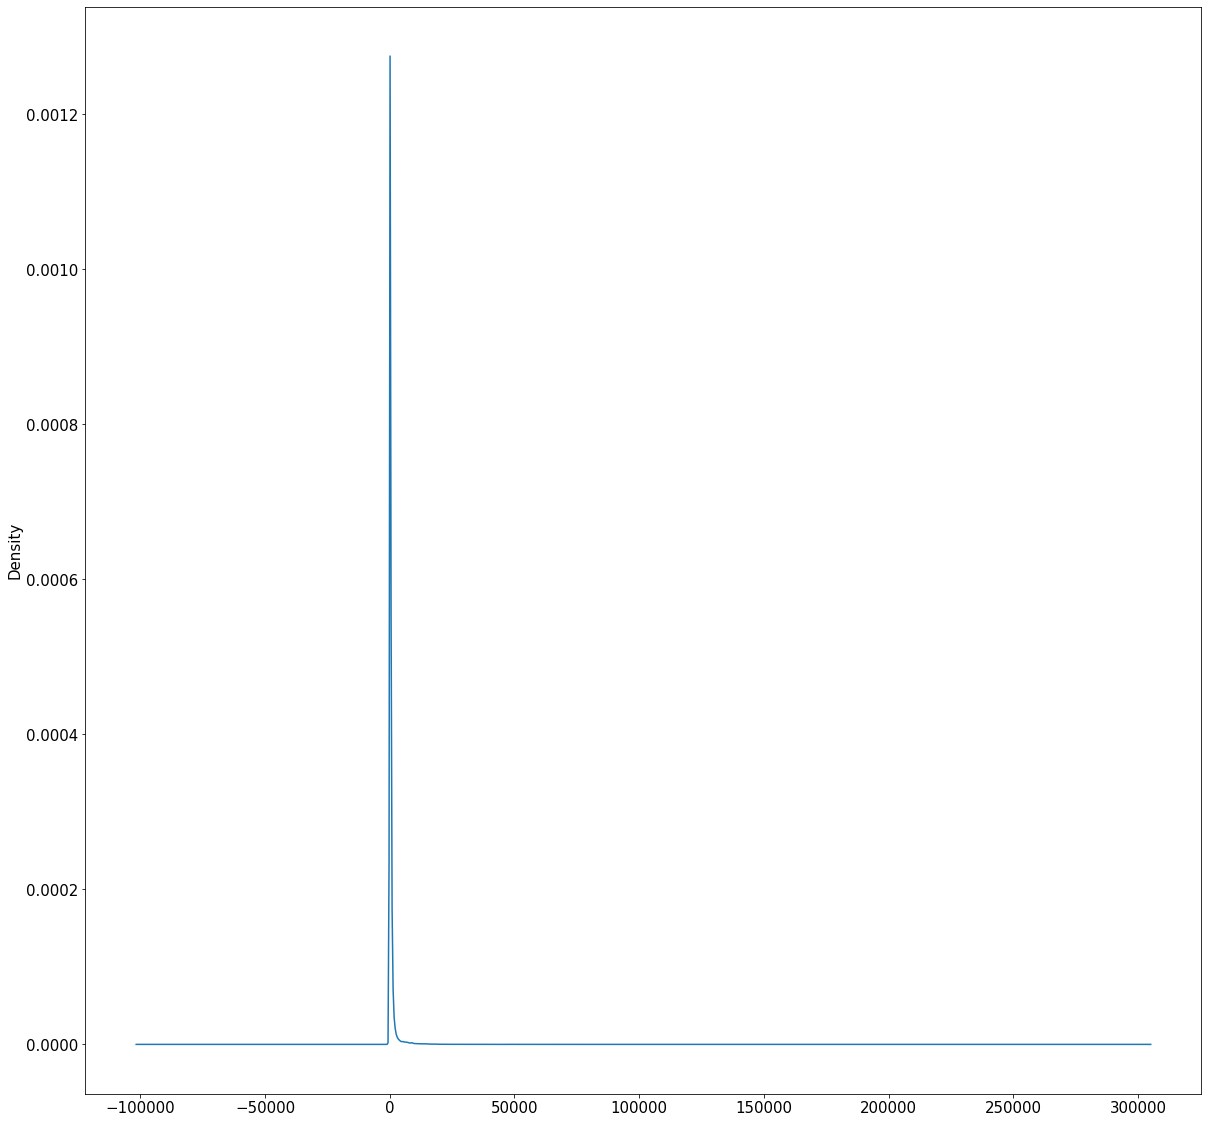

In [299]:
### --- Plotting the distribution of B1K introns length
introns_B1K['length'].plot.density()

<AxesSubplot:>

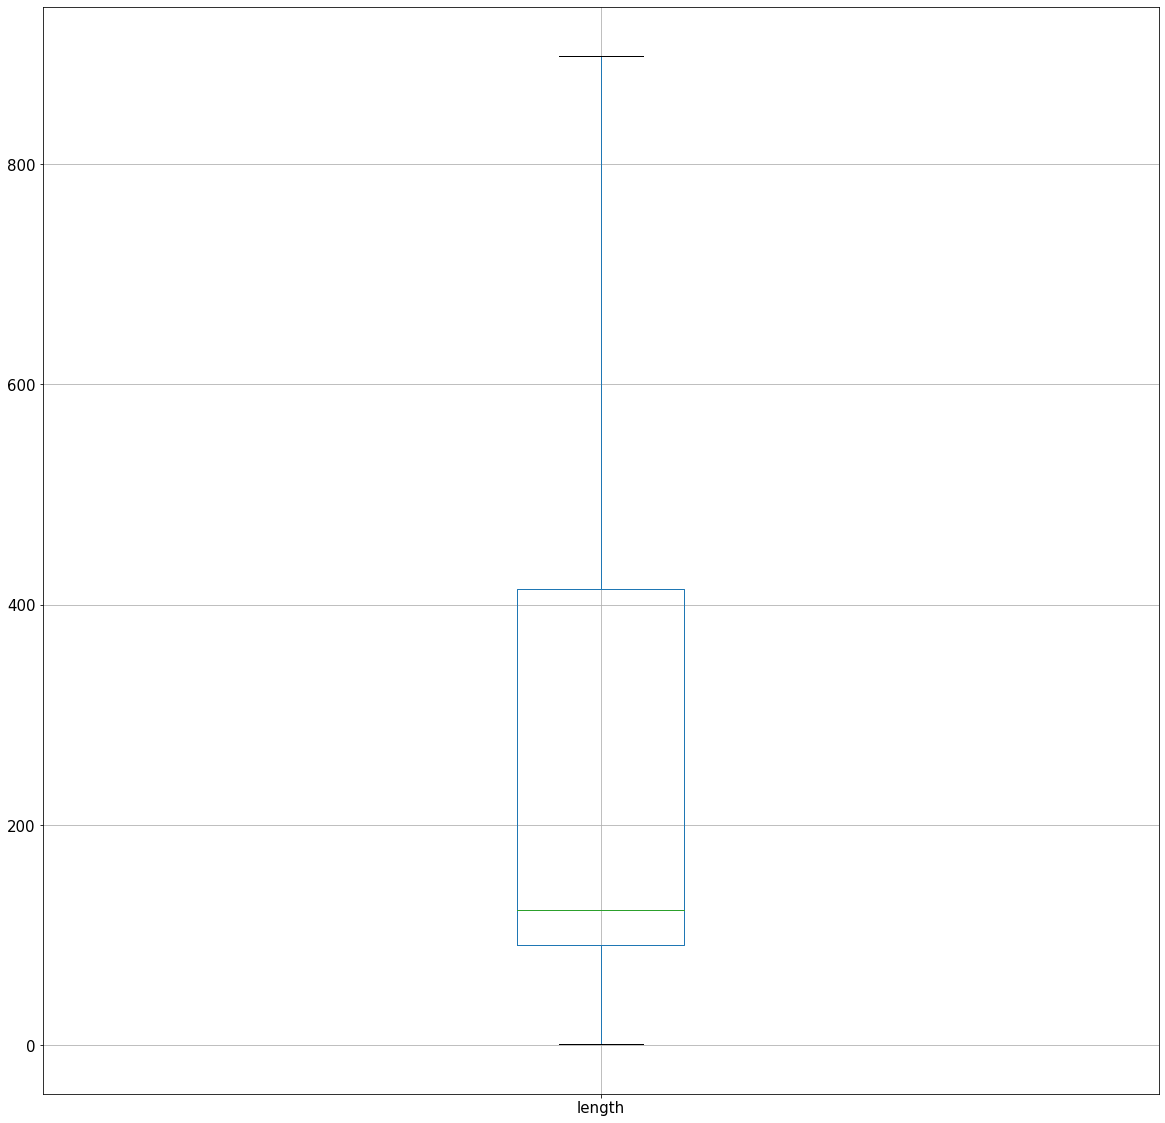

In [300]:
### --- Plotting the boxplot of B1K introns length without outliers
introns_B1K.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.6.4 Re-organizing files and directories

In [301]:
! ls Data/

Akashinriki   B1K_nohashtag.csv   Barke     Hv_Morex_longread  raw
B1K_exon.tsv  B1K_nohashtag.gff3  HOR10350  Morex


In [302]:
! mkdir Data/B1K

In [303]:
! mv Data/B1K_* Data/B1K/

In [304]:
! ls Data/

Akashinriki  B1K  Barke  HOR10350  Hv_Morex_longread  Morex  raw


In [305]:
! ls Output/

Akashinriki	       B1K_intronrichIDs.txt  HOR10350
B1K_intronlessIDs.txt  B1K_introns.tsv	      Hv_Morex_longread
B1K_intronpoorIDs.txt  Barke		      Morex


In [306]:
! mkdir Output/B1K

In [307]:
! mv Output/B1K_* Output/B1K/

In [308]:
! ls Output/

Akashinriki  B1K  Barke  HOR10350  Hv_Morex_longread  Morex


## 3.7 Barke - Gene projection

### 3.7.1 Data collection

In [309]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Barke_gp.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/005e26c4-051b-4fd4-8538-2abe31706449/1/DOWNLOAD

--2021-10-01 12:18:01--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/005e26c4-051b-4fd4-8538-2abe31706449/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53169617 (51M) [text/plain]
Saving to: ‘Data/raw/Barke_gp.gff3’

Data/raw/Barke_gp.g 100%[===================>]  50,71M  2,07MB/s    in 35s     

2021-10-01 12:18:36 (1,46 MB/s) - ‘Data/raw/Barke_gp.gff3’ saved [53169617/53169617]



### 3.7.2 Processing Data

In [310]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [311]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Barke_gp.gff3  > Data/Barke_gp_nohashtag.gff3

In [312]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Barke_gp_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Barke_gp_nohashtag.csv

In [313]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Barke_gp = pd.read_csv('Data/Barke_gp_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Barke_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,72210,73054,848.166,+,.,ID=Horvu_BARKE_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,72210,73054,.,+,.,ID=Horvu_BARKE_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,72210,72399,.,+,.,ID=Horvu_BARKE_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,72822,73054,.,+,.,ID=Horvu_BARKE_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,72210,72399,.,+,0,Parent=Horvu_BARKE_1H01G000100.1


In [314]:
### --- Building a separate dataframe containing all exons
exon_Barke_gp = df_Barke_gp.loc[df_Barke_gp['type'].isin(['exon'])]
exon_Barke_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,72210,72399,.,+,.,ID=Horvu_BARKE_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,72822,73054,.,+,.,ID=Horvu_BARKE_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,102846,103475,.,+,.,ID=Horvu_BARKE_1H01G000200.1_exon_1
12,chr1H,PGSBv2.28112019,exon,104616,105062,.,-,.,ID=Horvu_BARKE_1H01G000300.1_exon_10
13,chr1H,PGSBv2.28112019,exon,105168,105209,.,-,.,ID=Horvu_BARKE_1H01G000300.1_exon_9


In [315]:
### --- Exporting the exon dataframe to a tsv file 
exon_Barke_gp.to_csv('Data/Barke_gp_exon.tsv',sep='\t',index=False,header=False)

In [316]:
### --- Keeping in a separated dataframe the forward strands
forw_Barke_gp = df_Barke_gp.loc[df_Barke_gp['strand'].isin(['+'])]
forw_Barke_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,72210,73054,848.166,+,.,ID=Horvu_BARKE_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,72210,73054,.,+,.,ID=Horvu_BARKE_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,72210,72399,.,+,.,ID=Horvu_BARKE_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,72822,73054,.,+,.,ID=Horvu_BARKE_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,72210,72399,.,+,0,Parent=Horvu_BARKE_1H01G000100.1


In [317]:
### --- Keeping in a separated dataframe the reverse strands
rev_Barke_gp = df_Barke_gp.loc[df_Barke_gp['strand'].isin(['-'])]
rev_Barke_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
10,chr1H,PGSBv2.28112019,gene,104616,107810,2784.294,-,.,ID=Horvu_BARKE_1H01G000300
11,chr1H,PGSBv2.28112019,mRNA,104616,107810,.,-,.,ID=Horvu_BARKE_1H01G000300.1
12,chr1H,PGSBv2.28112019,exon,104616,105062,.,-,.,ID=Horvu_BARKE_1H01G000300.1_exon_10
13,chr1H,PGSBv2.28112019,exon,105168,105209,.,-,.,ID=Horvu_BARKE_1H01G000300.1_exon_9
14,chr1H,PGSBv2.28112019,exon,105714,105781,.,-,.,ID=Horvu_BARKE_1H01G000300.1_exon_8


In [318]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Barke_gp = forw_Barke_gp.loc[df_Barke_gp['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Barke_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [319]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Barke_gp = rev_Barke_gp.loc[df_Barke_gp['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Barke_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.7.3 Extracting introns from the whole genome

In [320]:
### --- Extracting introns from Barke_gp
extract_tot_introns_gp('Data/Barke_gp_exon.tsv', 'Output/Barke_gp_introns.tsv')

In [321]:
introns_Barke_gp = pd.read_csv('Output/Barke_gp_introns.tsv', sep = '\t')
introns_Barke_gp[:100]

,ID,type,start,end,length
0,ID=Horvu_BARKE_1H01G000100.1,intron,72400,72821,423
1,ID=Horvu_BARKE_1H01G000300.1,intron,105063,105167,106
2,ID=Horvu_BARKE_1H01G000300.1,intron,105210,105713,505
3,ID=Horvu_BARKE_1H01G000300.1,intron,105782,105861,81
4,ID=Horvu_BARKE_1H01G000300.1,intron,105905,106005,102
...,...,...,...,...,...
95,ID=Horvu_BARKE_1H01G001400.1,intron,410370,410454,86
96,ID=Horvu_BARKE_1H01G001600.1,intron,436394,436497,105
97,ID=Horvu_BARKE_1H01G001800.1,intron,549182,549255,75
98,ID=Horvu_BARKE_1H01G001800.1,intron,549548,550071,525


In [322]:
### --- Counting introns type in Barke_gp
introns_dictionary_Barke_gp = counting_introns_type_gp(exon_Barke_gp)

In [323]:
n_intronless_Barke_gp, n_intronpoor_Barke_gp, n_intronrich_Barke_gp, intronless_Barke_gp, intronpoor_Barke_gp, intronrich_Barke_gp = splitting_introns_type(introns_dictionary_Barke_gp)

Intronless are: 17546
Intronpoor are: 18588
Intronrich are: 12078


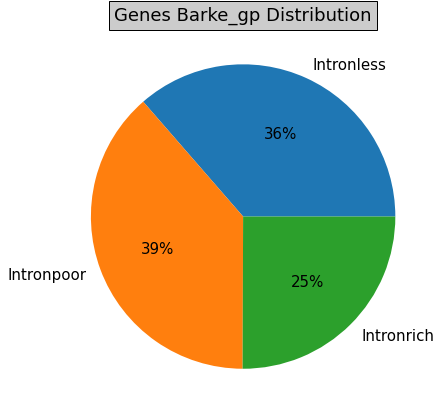

In [324]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Barke_gp = [17546, 18588, 12078]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Barke_gp, labels = genes, autopct='%1.0f%%')
plt.title("Genes Barke_gp Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [325]:
### --- Creating the list of Barke_gp gene IDs to check the number of transcripts using command line
intronless_file_Barke_gp = open('Output/Barke_gp_intronlessIDs.txt', 'a')
intronpoor_file_Barke_gp = open('Output/Barke_gp_intronpoorIDs.txt', 'a')
intronrich_file_Barke_gp = open('Output/Barke_gp_intronrichIDs.txt', 'a')
for i in range(len(intronless_Barke_gp)):
    if i == len(intronless_Barke_gp) -1:
        intronless_file_Barke_gp.write(intronless_Barke_gp[i])
    else:
        intronless_file_Barke_gp.write(intronless_Barke_gp[i] + '\n')
intronless_file_Barke_gp.close()

for i in range(len(intronpoor_Barke_gp)):
    if i == len(intronpoor_Barke_gp) -1:
        intronpoor_file_Barke_gp.write(intronpoor_Barke_gp[i])
    else:
        intronpoor_file_Barke_gp.write(intronpoor_Barke_gp[i] + '\n')
intronpoor_file_Barke_gp.close()

for i in range(len(intronrich_Barke_gp)):
    if i == len(intronrich_Barke_gp) -1:
        intronrich_file_Barke_gp.write(intronrich_Barke_gp[i])
    else:
        intronrich_file_Barke_gp.write(intronrich_Barke_gp[i]+'\n')
intronrich_file_Barke_gp.close()

In [326]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Barke_gp = ! grep -f Output/Barke_gp_intronlessIDs.txt Data/Barke_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Barke_gp = ! grep -f Output/Barke_gp_intronpoorIDs.txt Data/Barke_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Barke_gp = ! grep -f Output/Barke_gp_intronrichIDs.txt Data/Barke_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [327]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Barke_gp = int(n_mRNA_intronless_Barke_gp[0])/n_intronless_Barke_gp
print(avg_mRNA_intronless_Barke_gp)
avg_mRNA_intronpoor_Barke_gp = int(n_mRNA_intronpoor_Barke_gp[0])/n_intronpoor_Barke_gp
print(avg_mRNA_intronpoor_Barke_gp)
avg_mRNA_intronrich_Barke_gp = int(n_mRNA_intronrich_Barke_gp[0])/n_intronrich_Barke_gp
print(avg_mRNA_intronrich_Barke_gp)

1.0
1.0
1.0


No alternative splicing annotated.

In [328]:
### --- Basic statistics of Barke_gp introns
introns_Barke_gp['length'].describe()

count    130903.000000
mean        558.457820
std        2104.181661
min           1.000000
25%          91.000000
50%         123.000000
75%         412.000000
max      219022.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

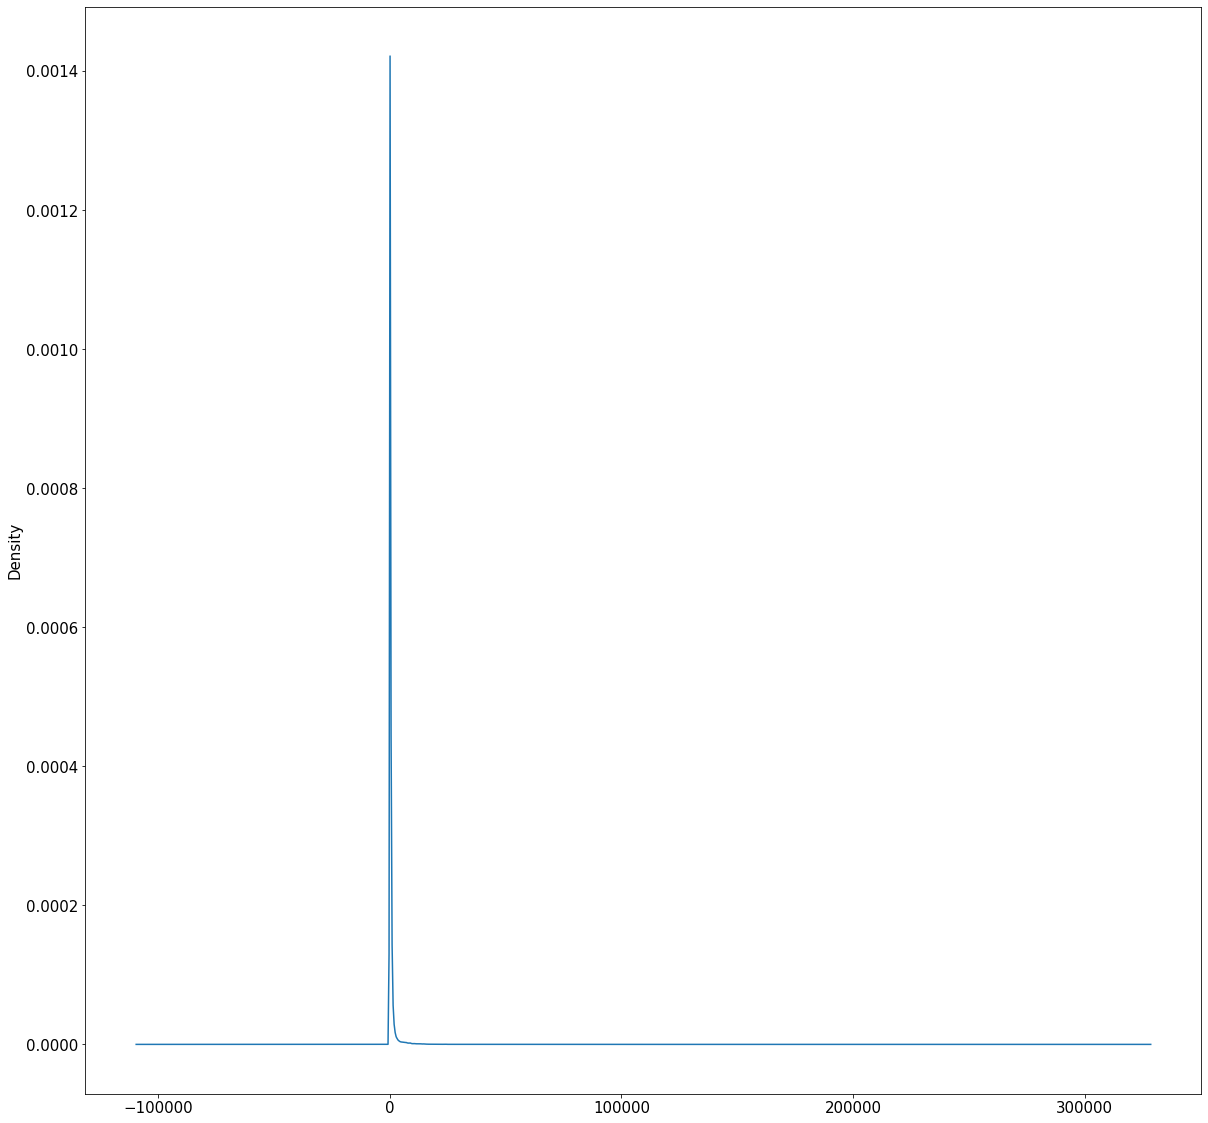

In [329]:
### --- Plotting the distribution of Barke_gp introns length
introns_Barke_gp['length'].plot.density()

<AxesSubplot:>

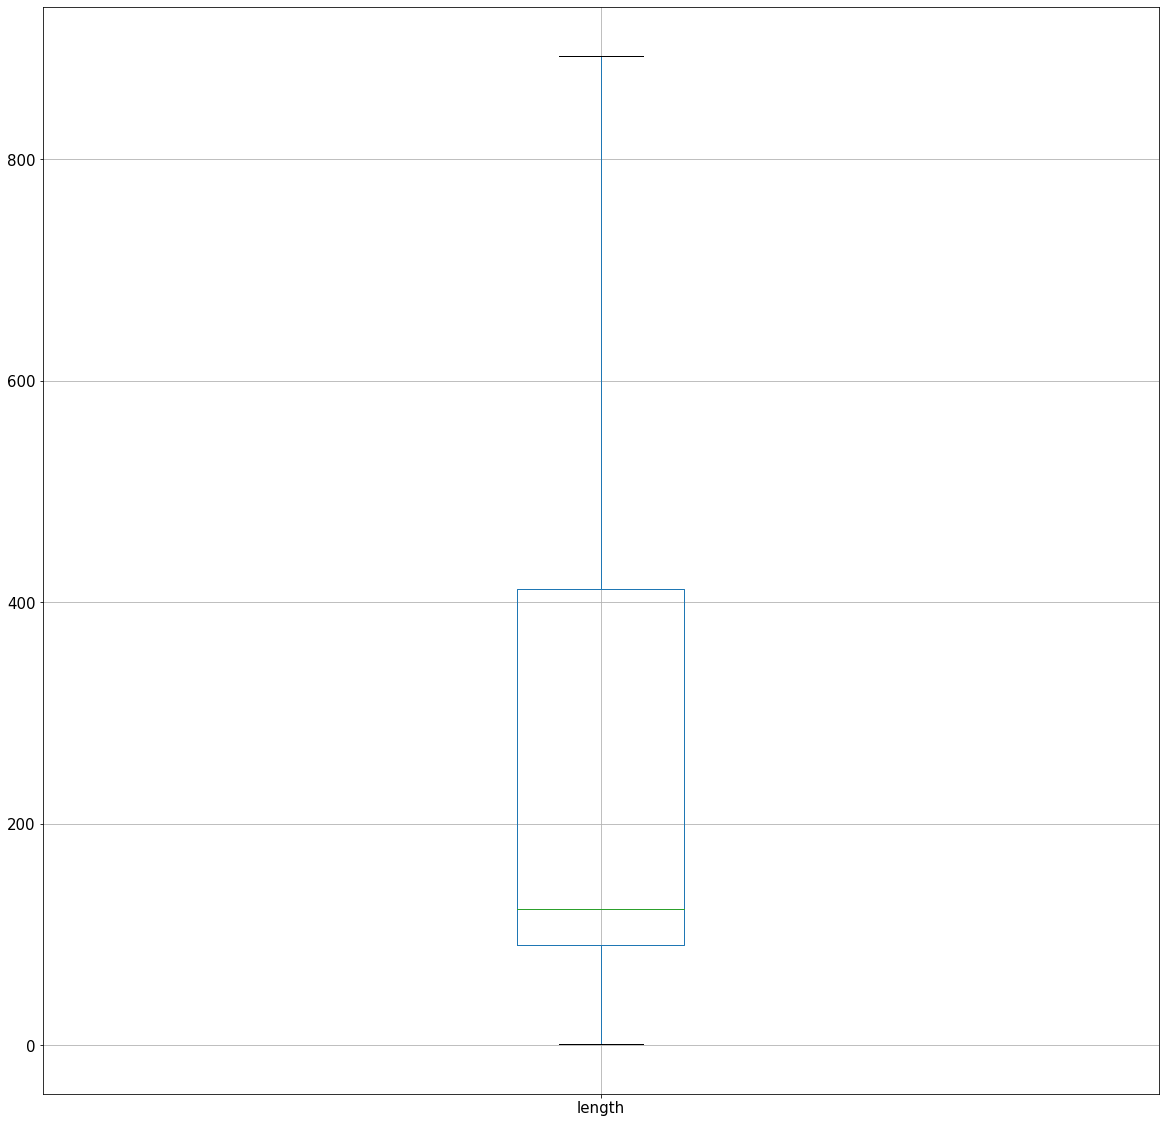

In [330]:
### --- Plotting the boxplot of Barke_gp introns length without outliers
introns_Barke_gp.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.7.4 Re-organizing files and directories

In [331]:
! ls Data/ 

Akashinriki  Barke_gp_exon.tsv	      HOR10350		 raw
B1K	     Barke_gp_nohashtag.csv   Hv_Morex_longread
Barke	     Barke_gp_nohashtag.gff3  Morex


In [332]:
! mkdir Data/Barke_gp

In [333]:
! mv Data/Barke_gp_* Data/Barke_gp/

In [334]:
! ls Data/

Akashinriki  B1K  Barke  Barke_gp  HOR10350  Hv_Morex_longread	Morex  raw


In [335]:
! ls Output/

Akashinriki  Barke_gp_intronlessIDs.txt  Barke_gp_introns.tsv  Morex
B1K	     Barke_gp_intronpoorIDs.txt  HOR10350
Barke	     Barke_gp_intronrichIDs.txt  Hv_Morex_longread


In [336]:
! mkdir Output/Barke_gp

In [337]:
! mv Output/Barke_gp* Output/Barke_gp/

mv: cannot move 'Output/Barke_gp' to a subdirectory of itself, 'Output/Barke_gp/Barke_gp'


In [338]:
! ls Output/

Akashinriki  B1K  Barke  Barke_gp  HOR10350  Hv_Morex_longread	Morex


## 3.8 Golden_Promise - Gene projection

### 3.8.1 Data collection

In [339]:

### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Golden_Promise.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/936e3aac-6846-4b46-ad7f-1432f2ed6ef8/1/DOWNLOAD

--2021-10-01 12:18:51--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/936e3aac-6846-4b46-ad7f-1432f2ed6ef8/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51589491 (49M) [text/plain]
Saving to: ‘Data/raw/Golden_Promise.gff3’

Data/raw/Golden_Pro 100%[===================>]  49,20M  1,93MB/s    in 25s     

2021-10-01 12:19:17 (1,93 MB/s) - ‘Data/raw/Golden_Promise.gff3’ saved [51589491/51589491]



### 3.8.2 Processing Data

In [340]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [341]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Golden_Promise.gff3  > Data/Golden_Promise_nohashtag.gff3

In [342]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Golden_Promise_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Golden_Promise_nohashtag.csv

In [343]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Golden_Promise = pd.read_csv('Data/Golden_Promise_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Golden_Promise.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,89962,90554,834.657,+,.,ID=Horvu_GOLDEN_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,89962,90554,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,89962,90165,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,90318,90554,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,89962,90165,.,+,0,Parent=Horvu_GOLDEN_1H01G000100.1


In [344]:
### --- Building a separate dataframe containing all exons
exon_Golden_Promise = df_Golden_Promise.loc[df_Golden_Promise['type'].isin(['exon'])]
exon_Golden_Promise.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,89962,90165,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,90318,90554,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,93936,94211,.,-,.,ID=Horvu_GOLDEN_1H01G000200.1_exon_1
12,chr1H,PGSBv2.28112019,exon,138070,138280,.,-,.,ID=Horvu_GOLDEN_1H01G000300.1_exon_5
13,chr1H,PGSBv2.28112019,exon,138360,138724,.,-,.,ID=Horvu_GOLDEN_1H01G000300.1_exon_4


In [345]:
### --- Exporting the exon dataframe to a tsv file 
exon_Golden_Promise.to_csv('Data/Golden_Promise_exon.tsv',sep='\t',index=False,header=False)

In [346]:
### --- Keeping in a separated dataframe the forward strands
forw_Golden_Promise = df_Golden_Promise.loc[df_Golden_Promise['strand'].isin(['+'])]
forw_Golden_Promise.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,89962,90554,834.657,+,.,ID=Horvu_GOLDEN_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,89962,90554,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,89962,90165,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,90318,90554,.,+,.,ID=Horvu_GOLDEN_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,89962,90165,.,+,0,Parent=Horvu_GOLDEN_1H01G000100.1


In [347]:
### --- Keeping in a separated dataframe the reverse strands
rev_Golden_Promise = df_Golden_Promise.loc[df_Golden_Promise['strand'].isin(['-'])]
rev_Golden_Promise.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,PGSBv2.28112019,gene,93936,94211,559.994,-,.,ID=Horvu_GOLDEN_1H01G000200
7,chr1H,PGSBv2.28112019,mRNA,93936,94211,.,-,.,ID=Horvu_GOLDEN_1H01G000200.1
8,chr1H,PGSBv2.28112019,exon,93936,94211,.,-,.,ID=Horvu_GOLDEN_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,CDS,93936,94211,.,-,0,Parent=Horvu_GOLDEN_1H01G000200.1
10,chr1H,PGSBv2.28112019,gene,138070,140216,2136.031,-,.,ID=Horvu_GOLDEN_1H01G000300


In [348]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Golden_Promise = forw_Golden_Promise.loc[df_Golden_Promise['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Golden_Promise.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [349]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Golden_Promise = rev_Golden_Promise.loc[df_Golden_Promise['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Golden_Promise.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.8.3 Extracting introns from the whole genome

In [350]:
### --- Extracting introns from Golden_Promise
extract_tot_introns_gp('Data/Golden_Promise_exon.tsv', 'Output/Golden_Promise_introns.tsv')

In [351]:
introns_Golden_Promise = pd.read_csv('Output/Golden_Promise_introns.tsv', sep = '\t')
introns_Golden_Promise[:100]

,ID,type,start,end,length
0,ID=Horvu_GOLDEN_1H01G000100.1,intron,90166,90317,153
1,ID=Horvu_GOLDEN_1H01G000300.1,intron,138281,138359,80
2,ID=Horvu_GOLDEN_1H01G000300.1,intron,138725,139157,434
3,ID=Horvu_GOLDEN_1H01G000300.1,intron,139240,139329,91
4,ID=Horvu_GOLDEN_1H01G000300.1,intron,139498,139956,460
...,...,...,...,...,...
95,ID=Horvu_GOLDEN_1H01G003700.1,intron,952197,953230,1035
96,ID=Horvu_GOLDEN_1H01G003700.1,intron,953665,953792,129
97,ID=Horvu_GOLDEN_1H01G003700.1,intron,953904,954486,584
98,ID=Horvu_GOLDEN_1H01G003700.1,intron,954551,956407,1858


In [352]:
### --- Counting introns type in Golden_Promise
introns_dictionary_Golden_Promise = counting_introns_type_gp(exon_Golden_Promise)

In [353]:
n_intronless_Golden_Promise, n_intronpoor_Golden_Promise, n_intronrich_Golden_Promise, intronless_Golden_Promise, intronpoor_Golden_Promise, intronrich_Golden_Promise = splitting_introns_type(introns_dictionary_Golden_Promise)

Intronless are: 14844
Intronpoor are: 18111
Intronrich are: 12129


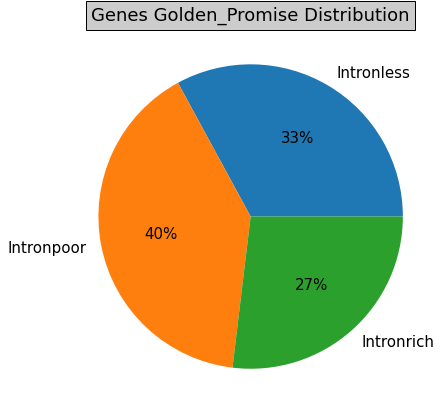

In [354]:
genes = ['Intronless', 'Intronpoor', 'Intronrich']
data_Golden_Promise = [14844, 18111, 12129]
fig = plt.figure(figsize =(10, 7))
plt.pie(data_Golden_Promise, labels = genes, autopct='%1.0f%%')
plt.title("Genes Golden_Promise Distribution", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

In [355]:
### --- Creating the list of Golden_Promise gene IDs to check the number of transcripts using command line
intronless_file_Golden_Promise = open('Output/Golden_Promise_intronlessIDs.txt', 'a')
intronpoor_file_Golden_Promise = open('Output/Golden_Promise_intronpoorIDs.txt', 'a')
intronrich_file_Golden_Promise = open('Output/Golden_Promise_intronrichIDs.txt', 'a')
for i in range(len(intronless_Golden_Promise)):
    if i == len(intronless_Golden_Promise) -1:
        intronless_file_Golden_Promise.write(intronless_Golden_Promise[i])
    else:
        intronless_file_Golden_Promise.write(intronless_Golden_Promise[i] + '\n')
intronless_file_Golden_Promise.close()

for i in range(len(intronpoor_Golden_Promise)):
    if i == len(intronpoor_Golden_Promise) -1:
        intronpoor_file_Golden_Promise.write(intronpoor_Golden_Promise[i])
    else:
        intronpoor_file_Golden_Promise.write(intronpoor_Golden_Promise[i] + '\n')
intronpoor_file_Golden_Promise.close()

for i in range(len(intronrich_Golden_Promise)):
    if i == len(intronrich_Golden_Promise) -1:
        intronrich_file_Golden_Promise.write(intronrich_Golden_Promise[i])
    else:
        intronrich_file_Golden_Promise.write(intronrich_Golden_Promise[i]+'\n')
intronrich_file_Golden_Promise.close()

In [356]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Golden_Promise = ! grep -f Output/Golden_Promise_intronlessIDs.txt Data/Golden_Promise_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Golden_Promise = ! grep -f Output/Golden_Promise_intronpoorIDs.txt Data/Golden_Promise_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Golden_Promise = ! grep -f Output/Golden_Promise_intronrichIDs.txt Data/Golden_Promise_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [357]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Golden_Promise = int(n_mRNA_intronless_Golden_Promise[0])/n_intronless_Golden_Promise
print(avg_mRNA_intronless_Golden_Promise)
avg_mRNA_intronpoor_Golden_Promise = int(n_mRNA_intronpoor_Golden_Promise[0])/n_intronpoor_Golden_Promise
print(avg_mRNA_intronpoor_Golden_Promise)
avg_mRNA_intronrich_Golden_Promise = int(n_mRNA_intronrich_Golden_Promise[0])/n_intronrich_Golden_Promise
print(avg_mRNA_intronrich_Golden_Promise)

1.0
1.0
1.0


No alternative splicing annotated.

In [358]:
### --- Basic statistics of Golden_Promise introns
introns_Golden_Promise['length'].describe()

count    130135.000000
mean        566.321896
std        2900.791070
min           1.000000
25%          91.000000
50%         123.000000
75%         410.000000
max      516362.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

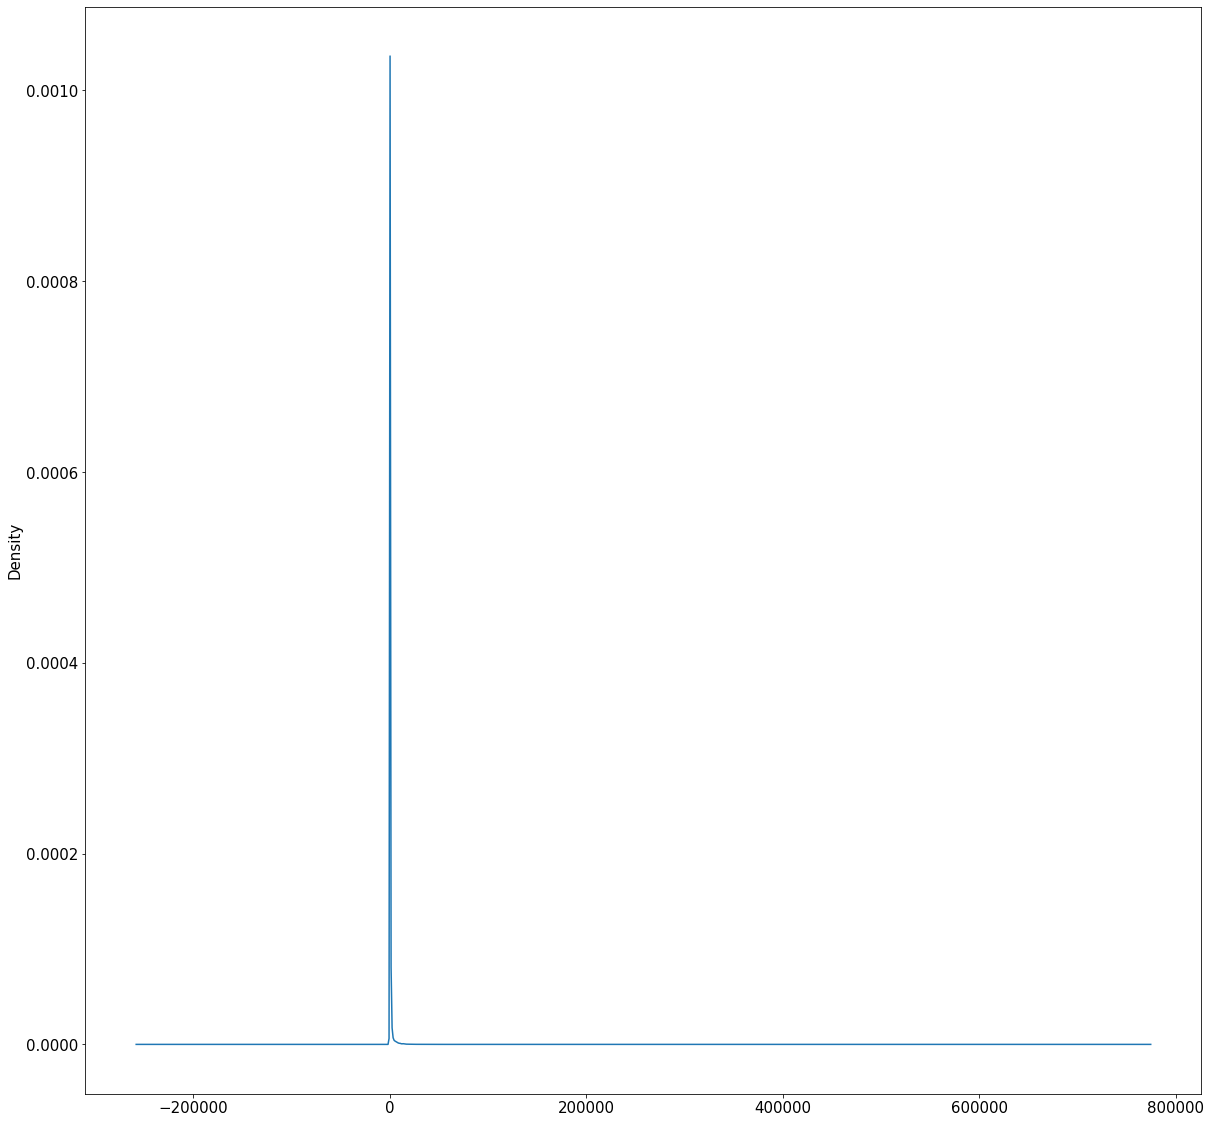

In [359]:
### --- Plotting the distribution of Golden_Promise introns length
introns_Golden_Promise['length'].plot.density()

<AxesSubplot:>

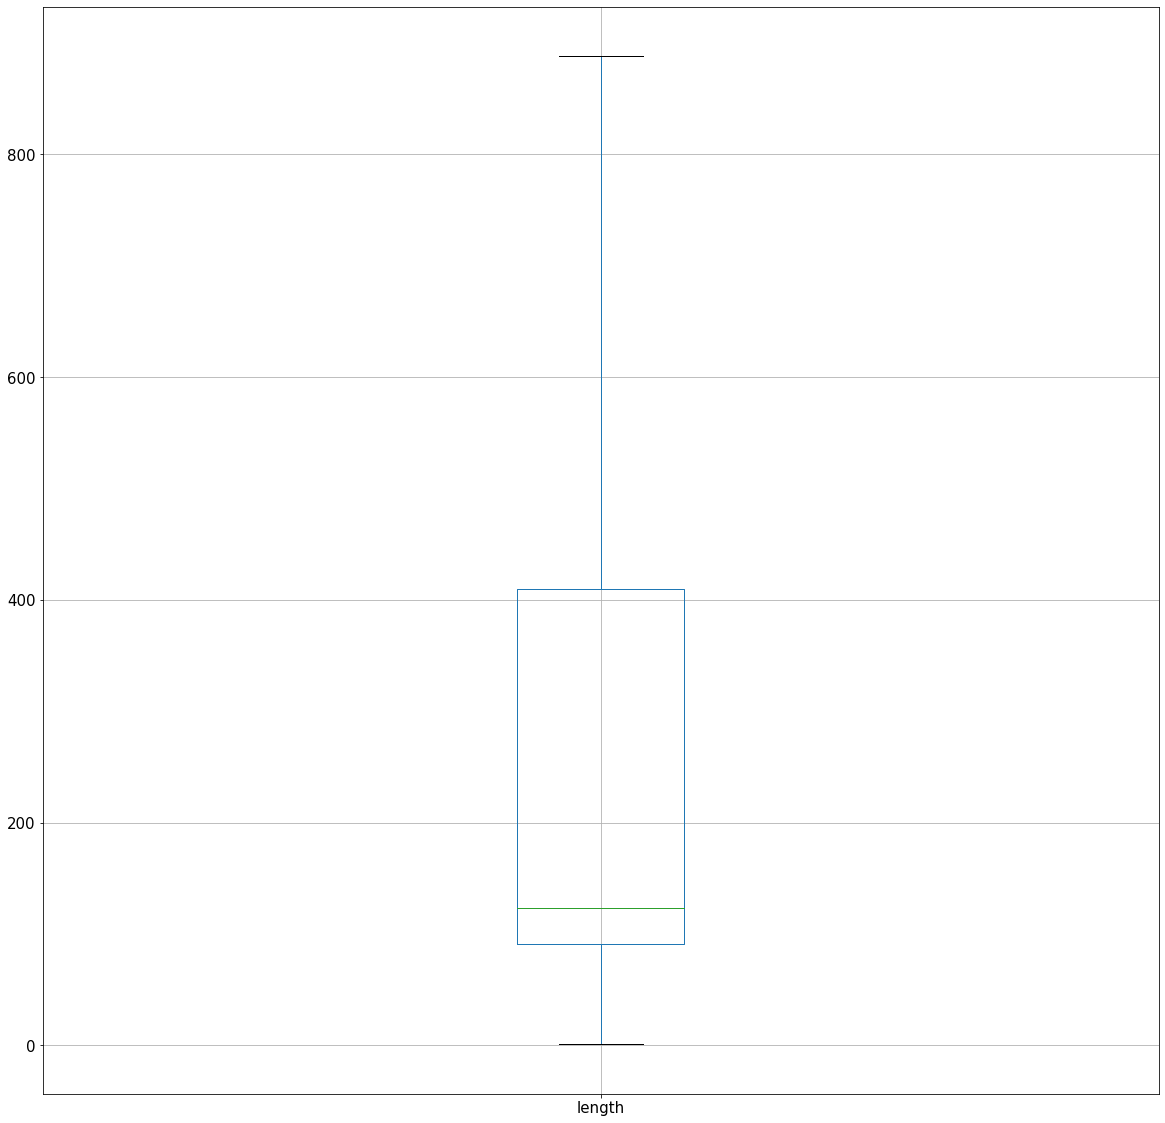

In [360]:
### --- Plotting the boxplot of Golden_Promise introns length without outliers
introns_Golden_Promise.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.8.4 Re-organizing files and directories

In [361]:
! ls Data/

Akashinriki  Barke_gp			   Golden_Promise_nohashtag.gff3  Morex
B1K	     Golden_Promise_exon.tsv	   HOR10350			  raw
Barke	     Golden_Promise_nohashtag.csv  Hv_Morex_longread


In [362]:
! mkdir Data/Golden_Promise

In [363]:
! mv Data/Golden_Promise_* Data/Golden_Promise/

In [364]:
! ls Data/

Akashinriki  Barke     Golden_Promise  Hv_Morex_longread  raw
B1K	     Barke_gp  HOR10350        Morex


In [365]:
! ls Output/

Akashinriki  Golden_Promise_intronlessIDs.txt  HOR10350
B1K	     Golden_Promise_intronpoorIDs.txt  Hv_Morex_longread
Barke	     Golden_Promise_intronrichIDs.txt  Morex
Barke_gp     Golden_Promise_introns.tsv


In [366]:
! mkdir Output/Golden_Promise

In [367]:
! mv Output/Golden_Promise_* Output/Golden_Promise/

In [368]:
! ls Output/

Akashinriki  Barke     Golden_Promise  Hv_Morex_longread
B1K	     Barke_gp  HOR10350        Morex


## 3.9 Hockett - Gene projection

### 3.9.1 Data collection

In [369]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Hockett.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/135d31f9-c030-4e95-9c50-bc61746d2721/1/DOWNLOAD

--2021-10-01 12:19:33--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/135d31f9-c030-4e95-9c50-bc61746d2721/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55454843 (53M) [text/plain]
Saving to: ‘Data/raw/Hockett.gff3’

Data/raw/Hockett.gf 100%[===================>]  52,89M  1,92MB/s    in 30s     

2021-10-01 12:20:03 (1,77 MB/s) - ‘Data/raw/Hockett.gff3’ saved [55454843/55454843]



### 3.9.2 Processing Data 

In [370]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [371]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Hockett.gff3  > Data/Hockett_nohashtag.gff3

In [372]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Hockett_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Hockett_nohashtag.csv

In [373]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Hockett = pd.read_csv('Data/Hockett_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Hockett.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,125,1888,2208.890,+,.,ID=Horvu_HOCKETT_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,125,1888,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,125,163,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,572,1116,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,1245,1308,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_3


In [374]:
### --- Building a separate dataframe containing all exons
exon_Hockett = df_Hockett.loc[df_Hockett['type'].isin(['exon'])]
exon_Hockett.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,125,163,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,572,1116,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,1245,1308,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_3
5,chr1H,PGSBv2.28112019,exon,1415,1888,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_4
12,chr1H,PGSBv2.28112019,exon,14454,14623,.,+,.,ID=Horvu_HOCKETT_1H01G000200.1_exon_1


In [375]:
### --- Exporting the exon dataframe to a tsv file 
exon_Hockett.to_csv('Data/Hockett_exon.tsv',sep='\t',index=False,header=False)

In [376]:
### --- Keeping in a separated dataframe the forward strands
forw_Hockett = df_Hockett.loc[df_Hockett['strand'].isin(['+'])]
forw_Hockett.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,125,1888,2208.890,+,.,ID=Horvu_HOCKETT_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,125,1888,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,125,163,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,572,1116,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,1245,1308,.,+,.,ID=Horvu_HOCKETT_1H01G000100.1_exon_3


In [377]:
### --- Keeping in a separated dataframe the reverse strands
rev_Hockett = df_Hockett.loc[df_Hockett['strand'].isin(['-'])]
rev_Hockett.head()

,chr,source,type,start,end,score,strand,phase,attributes
28,chr1H,PGSBv2.28112019,gene,50041,54262,1819.386,-,.,ID=Horvu_HOCKETT_1H01G000400
29,chr1H,PGSBv2.28112019,mRNA,50041,54262,.,-,.,ID=Horvu_HOCKETT_1H01G000400.1
30,chr1H,PGSBv2.28112019,exon,50041,50412,.,-,.,ID=Horvu_HOCKETT_1H01G000400.1_exon_6
31,chr1H,PGSBv2.28112019,exon,52379,52525,.,-,.,ID=Horvu_HOCKETT_1H01G000400.1_exon_5
32,chr1H,PGSBv2.28112019,exon,52677,52730,.,-,.,ID=Horvu_HOCKETT_1H01G000400.1_exon_4


In [378]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Hockett = forw_Hockett.loc[df_Hockett['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Hockett.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [379]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Hockett = rev_Hockett.loc[df_Hockett['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Hockett.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.9.3   Extracting introns from the whole genome

In [380]:
### --- Extracting introns from Hockett
extract_tot_introns_gp('Data/Hockett_exon.tsv', 'Output/Hockett_introns.tsv')

In [381]:
introns_Hockett = pd.read_csv('Output/Hockett_introns.tsv', sep = '\t')
introns_Hockett[:100]

,ID,type,start,end,length
0,ID=Horvu_HOCKETT_1H01G000100.1,intron,164,571,409
1,ID=Horvu_HOCKETT_1H01G000100.1,intron,1117,1244,129
2,ID=Horvu_HOCKETT_1H01G000100.1,intron,1309,1414,107
3,ID=Horvu_HOCKETT_1H01G000200.1,intron,14624,14885,263
4,ID=Horvu_HOCKETT_1H01G000200.1,intron,15163,18855,3694
...,...,...,...,...,...
95,ID=Horvu_HOCKETT_1H01G002500.1,intron,525269,525352,85
96,ID=Horvu_HOCKETT_1H01G002500.1,intron,525492,525616,126
97,ID=Horvu_HOCKETT_1H01G002500.1,intron,525939,526033,96
98,ID=Horvu_HOCKETT_1H01G002500.1,intron,526096,526172,78


In [382]:
### --- Counting introns type in Hockett
introns_dictionary_Hockett = counting_introns_type_gp(exon_Hockett)

In [383]:
n_intronless_Hockett, n_intronpoor_Hockett, n_intronrich_Hockett, intronless_Hockett, intronpoor_Hockett, intronrich_Hockett = splitting_introns_type(introns_dictionary_Hockett)

Intronless are: 17231
Intronpoor are: 19105
Intronrich are: 12443


In [384]:
### --- I decided to create a function to plot the pie representing the distribution of intronless/poor/rich
def plotting_intron_types(n_intronless, n_intronpoor, n_intronrich, title):
    genes = ['Intronless', 'Intronpoor', 'Intronrich']
    data = [n_intronless, n_intronpoor, n_intronrich]
    fig = plt.figure(figsize = (10,7))
    plt.pie(data, labels = genes, autopct='%1.0f%%')
    plt.title(title, bbox={'facecolor':'0.8', 'pad':5})
    plt.show()

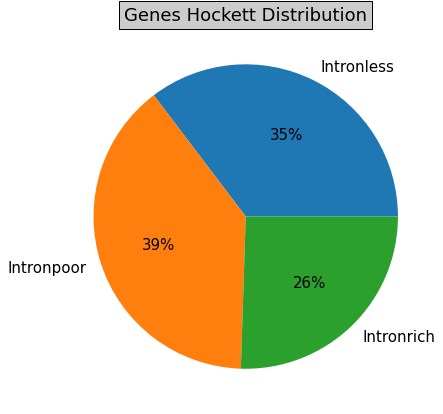

In [385]:
plotting_intron_types(n_intronless_Hockett, n_intronpoor_Hockett, n_intronrich_Hockett, 'Genes Hockett Distribution')

In [386]:
### --- Creating the list of Hockett gene IDs to check the number of transcripts using command line
intronless_file_Hockett = open('Output/Hockett_intronlessIDs.txt', 'a')
intronpoor_file_Hockett = open('Output/Hockett_intronpoorIDs.txt', 'a')
intronrich_file_Hockett = open('Output/Hockett_intronrichIDs.txt', 'a')
for i in range(len(intronless_Hockett)):
    if i == len(intronless_Hockett) -1:
        intronless_file_Hockett.write(intronless_Hockett[i])
    else:
        intronless_file_Hockett.write(intronless_Hockett[i] + '\n')
intronless_file_Hockett.close()

for i in range(len(intronpoor_Hockett)):
    if i == len(intronpoor_Hockett) -1:
        intronpoor_file_Hockett.write(intronpoor_Hockett[i])
    else:
        intronpoor_file_Hockett.write(intronpoor_Hockett[i] + '\n')
intronpoor_file_Hockett.close()

for i in range(len(intronrich_Hockett)):
    if i == len(intronrich_Hockett) -1:
        intronrich_file_Hockett.write(intronrich_Hockett[i])
    else:
        intronrich_file_Hockett.write(intronrich_Hockett[i]+'\n')
intronrich_file_Hockett.close()

In [387]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Hockett = ! grep -f Output/Hockett_intronlessIDs.txt Data/Hockett_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Hockett = ! grep -f Output/Hockett_intronpoorIDs.txt Data/Hockett_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Hockett = ! grep -f Output/Hockett_intronrichIDs.txt Data/Hockett_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [388]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Hockett = int(n_mRNA_intronless_Hockett[0])/n_intronless_Hockett
print(avg_mRNA_intronless_Hockett)
avg_mRNA_intronpoor_Hockett = int(n_mRNA_intronpoor_Hockett[0])/n_intronpoor_Hockett
print(avg_mRNA_intronpoor_Hockett)
avg_mRNA_intronrich_Hockett = int(n_mRNA_intronrich_Hockett[0])/n_intronrich_Hockett
print(avg_mRNA_intronrich_Hockett)

1.0
1.0
1.0


No alternative splicing annotated.

In [389]:
### --- Basic statistics of Hockett introns
introns_Hockett['length'].describe()

count    134232.000000
mean        561.094843
std        2228.840816
min           1.000000
25%          91.000000
50%         124.000000
75%         422.000000
max      323207.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

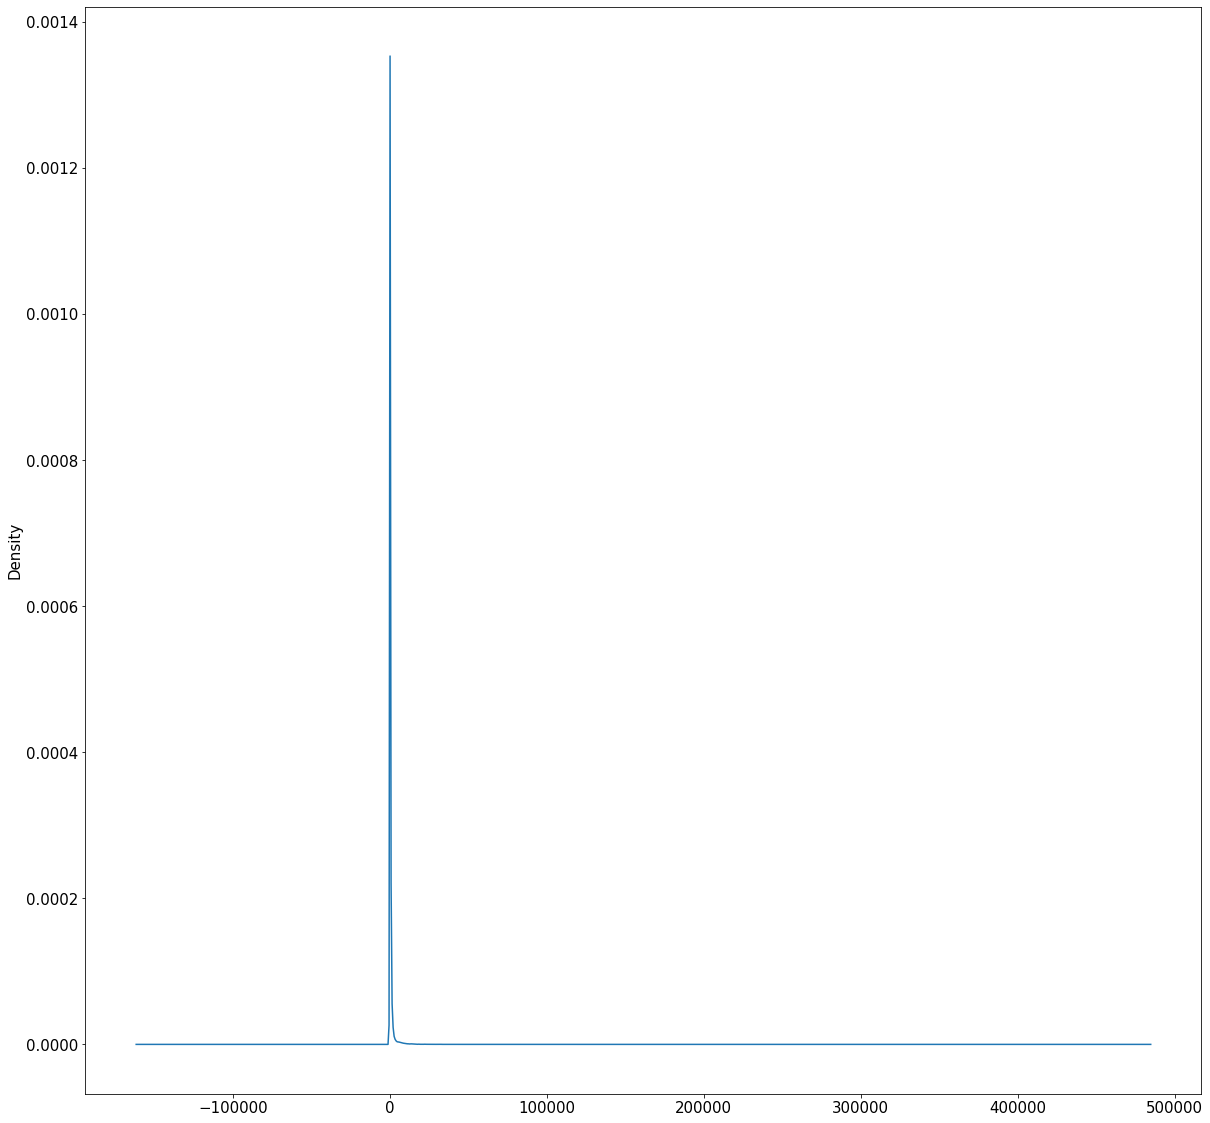

In [390]:
### --- Plotting the distribution of Hockett introns length
introns_Hockett['length'].plot.density()

<AxesSubplot:>

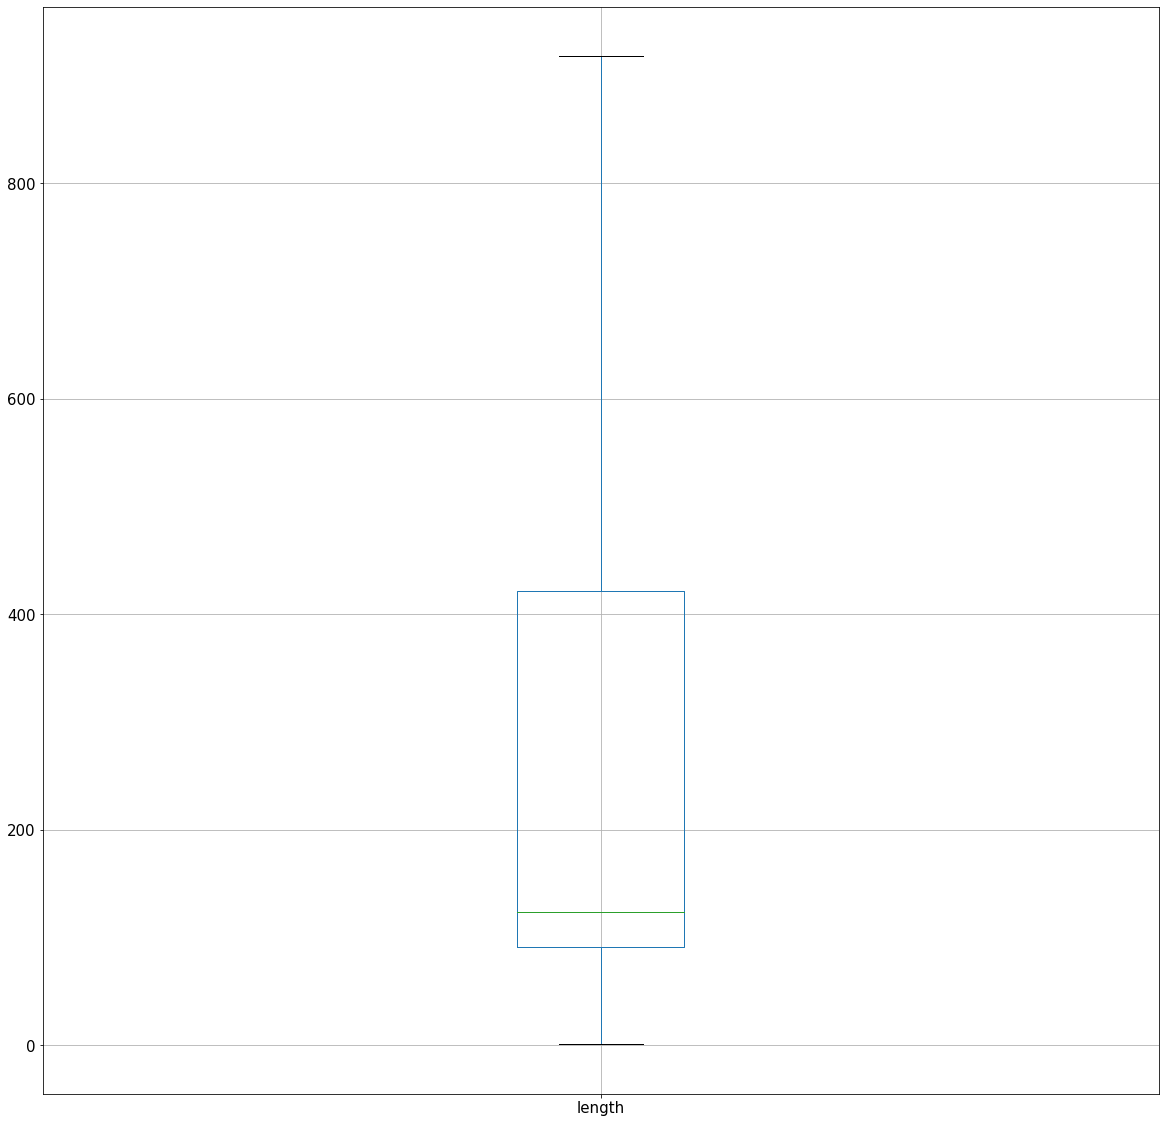

In [391]:
### --- Plotting the boxplot of Hockett introns length without outliers
introns_Hockett.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.9.4 Re-organizing files and directories

In [392]:
! ls Data/

Akashinriki  Barke_gp	       Hockett_nohashtag.csv   Hv_Morex_longread
B1K	     Golden_Promise    Hockett_nohashtag.gff3  Morex
Barke	     Hockett_exon.tsv  HOR10350		       raw


In [393]:
! mkdir Data/Hockett

In [394]:
! mv Data/Hockett_* Data/Hockett/

In [395]:
! ls Data/

Akashinriki  Barke     Golden_Promise  HOR10350		  Morex
B1K	     Barke_gp  Hockett	       Hv_Morex_longread  raw


In [396]:
! ls Output/

Akashinriki  Golden_Promise		Hockett_introns.tsv
B1K	     Hockett_intronlessIDs.txt	HOR10350
Barke	     Hockett_intronpoorIDs.txt	Hv_Morex_longread
Barke_gp     Hockett_intronrichIDs.txt	Morex


In [397]:
! mkdir Output/Hockett

In [398]:
! mv Output/Hockett_* Output/Hockett/

In [399]:
! ls Output/

Akashinriki  Barke     Golden_Promise  HOR10350		  Morex
B1K	     Barke_gp  Hockett	       Hv_Morex_longread


## 3.10 HOR10350 - Gene projection

### 3.10.1 Data collection

In [400]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR10350_gp.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/a909ad41-c116-4131-bf79-6e760c2cd723/1/DOWNLOAD

--2021-10-01 12:20:19--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/a909ad41-c116-4131-bf79-6e760c2cd723/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52956039 (51M) [text/plain]
Saving to: ‘Data/raw/HOR10350_gp.gff3’

Data/raw/HOR10350_g 100%[===================>]  50,50M  1,85MB/s    in 26s     

2021-10-01 12:20:45 (1,94 MB/s) - ‘Data/raw/HOR10350_gp.gff3’ saved [52956039/52956039]



### 3.10.2 Processing Data

In [401]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [402]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR10350_gp.gff3  > Data/HOR10350_gp_nohashtag.gff3

In [403]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR10350_gp_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR10350_gp_nohashtag.csv

In [404]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR10350_gp = pd.read_csv('Data/HOR10350_gp_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR10350_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,42981,43289,621.759,-,.,ID=Horvu_10350_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,42981,43289,.,-,.,ID=Horvu_10350_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,42981,43289,.,-,.,ID=Horvu_10350_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,CDS,42981,43289,.,-,0,Parent=Horvu_10350_1H01G000100.1
4,chr1H,PGSBv2.28112019,gene,64058,68041,7640.911,+,.,ID=Horvu_10350_1H01G000200


In [405]:
### --- Building a separate dataframe containing all exons
exon_HOR10350_gp = df_HOR10350_gp.loc[df_HOR10350_gp['type'].isin(['exon'])]
exon_HOR10350_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,42981,43289,.,-,.,ID=Horvu_10350_1H01G000100.1_exon_1
6,chr1H,PGSBv2.28112019,exon,64058,68041,.,+,.,ID=Horvu_10350_1H01G000200.1_exon_1
10,chr1H,PGSBv2.28112019,exon,262465,262537,.,-,.,ID=Horvu_10350_1H01G000300.1_exon_2
11,chr1H,PGSBv2.28112019,exon,264010,264569,.,-,.,ID=Horvu_10350_1H01G000300.1_exon_1
16,chr1H,PGSBv2.28112019,exon,284284,284344,.,+,.,ID=Horvu_10350_1H01G000400.1_exon_1


In [406]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR10350_gp.to_csv('Data/HOR10350_gp_exon.tsv',sep='\t',index=False,header=False)

In [407]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR10350_gp = df_HOR10350_gp.loc[df_HOR10350_gp['strand'].isin(['+'])]
forw_HOR10350_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
4,chr1H,PGSBv2.28112019,gene,64058,68041,7640.911,+,.,ID=Horvu_10350_1H01G000200
5,chr1H,PGSBv2.28112019,mRNA,64058,68041,.,+,.,ID=Horvu_10350_1H01G000200.1
6,chr1H,PGSBv2.28112019,exon,64058,68041,.,+,.,ID=Horvu_10350_1H01G000200.1_exon_1
7,chr1H,PGSBv2.28112019,CDS,64058,68041,.,+,0,Parent=Horvu_10350_1H01G000200.1
14,chr1H,PGSBv2.28112019,gene,284284,284626,488.409,+,.,ID=Horvu_10350_1H01G000400


In [408]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR10350_gp = df_HOR10350_gp.loc[df_HOR10350_gp['strand'].isin(['-'])]
rev_HOR10350_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,42981,43289,621.759,-,.,ID=Horvu_10350_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,42981,43289,.,-,.,ID=Horvu_10350_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,42981,43289,.,-,.,ID=Horvu_10350_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,CDS,42981,43289,.,-,0,Parent=Horvu_10350_1H01G000100.1
8,chr1H,PGSBv2.28112019,gene,262465,264569,1103.626,-,.,ID=Horvu_10350_1H01G000300


In [409]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR10350_gp = forw_HOR10350_gp.loc[df_HOR10350_gp['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR10350_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [410]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR10350_gp = rev_HOR10350_gp.loc[df_HOR10350_gp['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR10350_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.10.3 Extracting introns from the whole genome 

In [411]:
### --- Extracting introns from HOR10350_gp
extract_tot_introns_gp('Data/HOR10350_gp_exon.tsv', 'Output/HOR10350_gp_introns.tsv')

In [412]:
introns_HOR10350_gp = pd.read_csv('Output/HOR10350_gp_introns.tsv', sep = '\t')
introns_HOR10350_gp[:100]

,ID,type,start,end,length
0,ID=Horvu_10350_1H01G000300.1,intron,262538,264009,1473
1,ID=Horvu_10350_1H01G000400.1,intron,284345,284447,104
2,ID=Horvu_10350_1H01G000600.1,intron,305573,305905,334
3,ID=Horvu_10350_1H01G000700.1,intron,340208,341461,1255
4,ID=Horvu_10350_1H01G000700.1,intron,341676,341675,1
...,...,...,...,...,...
95,ID=Horvu_10350_1H01G003100.1,intron,723342,724692,1352
96,ID=Horvu_10350_1H01G003100.1,intron,724790,725507,719
97,ID=Horvu_10350_1H01G003300.1,intron,1294472,1294555,85
98,ID=Horvu_10350_1H01G003300.1,intron,1294706,1294795,91


In [413]:
### --- Counting introns type in HOR10350_gp
introns_dictionary_HOR10350_gp = counting_introns_type_gp(exon_HOR10350_gp)

In [414]:
n_intronless_HOR10350_gp, n_intronpoor_HOR10350_gp, n_intronrich_HOR10350_gp, intronless_HOR10350_gp, intronpoor_HOR10350_gp, intronrich_HOR10350_gp = splitting_introns_type(introns_dictionary_HOR10350_gp)

Intronless are: 17457
Intronpoor are: 18509
Intronrich are: 12041


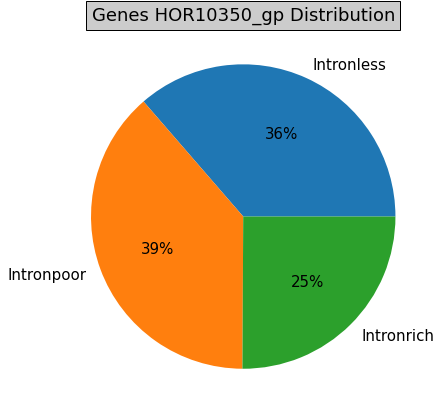

In [415]:
plotting_intron_types(n_intronless_HOR10350_gp, n_intronpoor_HOR10350_gp, n_intronrich_HOR10350_gp, 'Genes HOR10350_gp Distribution')

In [416]:
### --- Creating the list of HOR10350_gp gene IDs to check the number of transcripts using command line
intronless_file_HOR10350_gp = open('Output/HOR10350_gp_intronlessIDs.txt', 'a')
intronpoor_file_HOR10350_gp = open('Output/HOR10350_gp_intronpoorIDs.txt', 'a')
intronrich_file_HOR10350_gp = open('Output/HOR10350_gp_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR10350_gp)):
    if i == len(intronless_HOR10350_gp) -1:
        intronless_file_HOR10350_gp.write(intronless_HOR10350_gp[i])
    else:
        intronless_file_HOR10350_gp.write(intronless_HOR10350_gp[i] + '\n')
intronless_file_HOR10350_gp.close()

for i in range(len(intronpoor_HOR10350_gp)):
    if i == len(intronpoor_HOR10350_gp) -1:
        intronpoor_file_HOR10350_gp.write(intronpoor_HOR10350_gp[i])
    else:
        intronpoor_file_HOR10350_gp.write(intronpoor_HOR10350_gp[i] + '\n')
intronpoor_file_HOR10350_gp.close()

for i in range(len(intronrich_HOR10350_gp)):
    if i == len(intronrich_HOR10350_gp) -1:
        intronrich_file_HOR10350_gp.write(intronrich_HOR10350_gp[i])
    else:
        intronrich_file_HOR10350_gp.write(intronrich_HOR10350_gp[i]+'\n')
intronrich_file_HOR10350_gp.close()

In [417]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR10350_gp = ! grep -f Output/HOR10350_gp_intronlessIDs.txt Data/HOR10350_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR10350_gp = ! grep -f Output/HOR10350_gp_intronpoorIDs.txt Data/HOR10350_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR10350_gp = ! grep -f Output/HOR10350_gp_intronrichIDs.txt Data/HOR10350_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [418]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR10350_gp = int(n_mRNA_intronless_HOR10350_gp[0])/n_intronless_HOR10350_gp
print(avg_mRNA_intronless_HOR10350_gp)
avg_mRNA_intronpoor_HOR10350_gp = int(n_mRNA_intronpoor_HOR10350_gp[0])/n_intronpoor_HOR10350_gp
print(avg_mRNA_intronpoor_HOR10350_gp)
avg_mRNA_intronrich_HOR10350_gp = int(n_mRNA_intronrich_HOR10350_gp[0])/n_intronrich_HOR10350_gp
print(avg_mRNA_intronrich_HOR10350_gp)

1.0
1.0
1.0


No alternative splicing. 

In [419]:
### --- Basic statistics of HOR10350_gp introns
introns_HOR10350_gp['length'].describe()

count    130385.000000
mean        562.193289
std        2061.837194
min           1.000000
25%          91.000000
50%         123.000000
75%         412.000000
max      171409.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

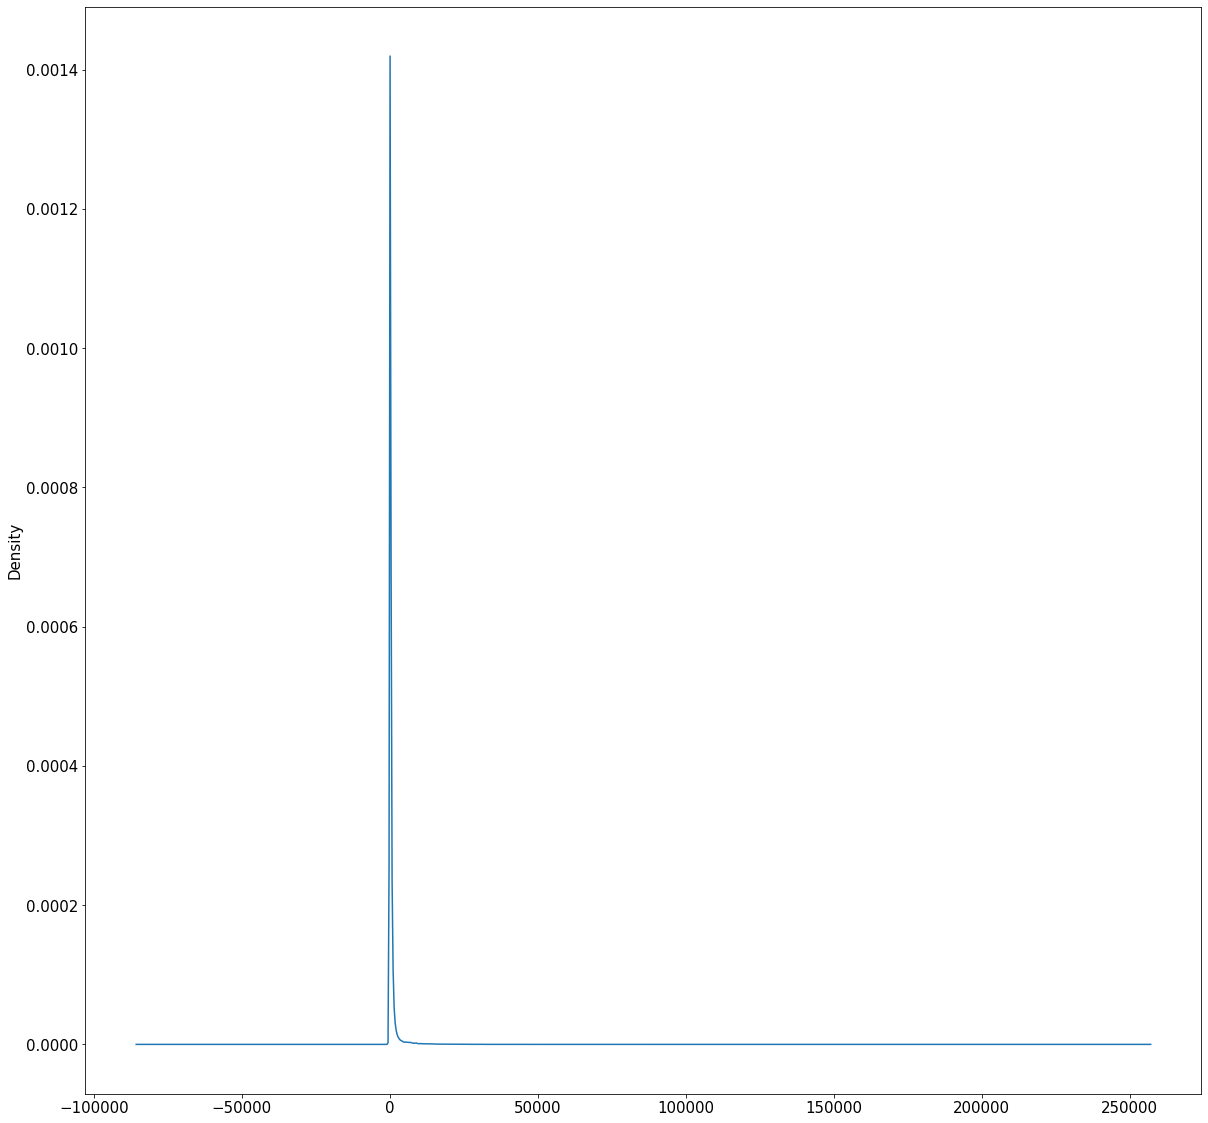

In [420]:
### --- Plotting the distribution of HOR10350_gp introns length
introns_HOR10350_gp['length'].plot.density()

<AxesSubplot:>

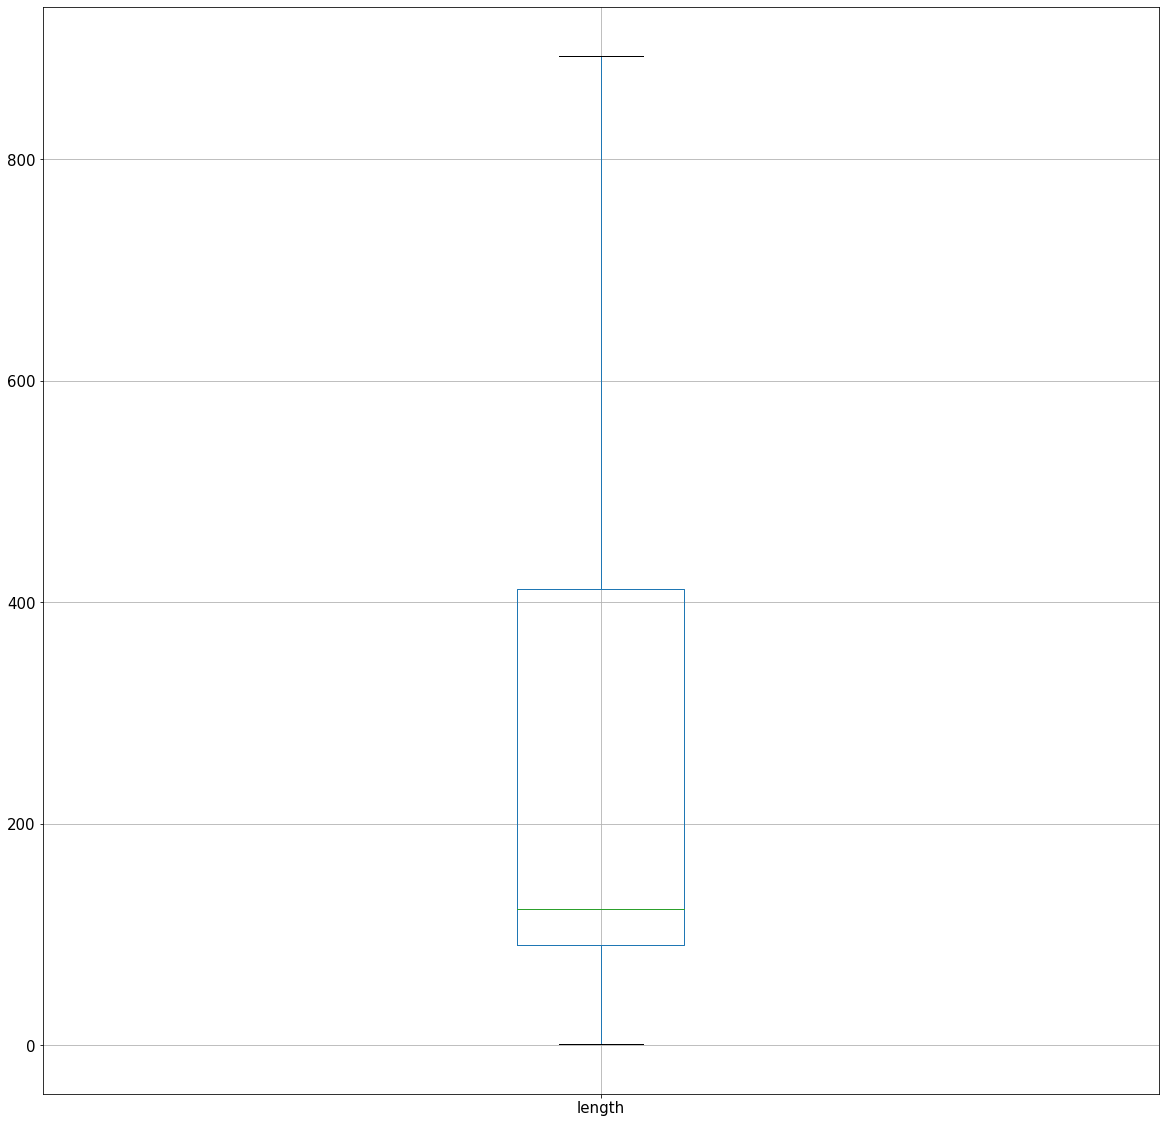

In [421]:
### --- Plotting the boxplot of HOR10350_gp introns length without outliers
introns_HOR10350_gp.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.10.4 Re-organizing files and directories

In [422]:
! ls Data/

Akashinriki  Golden_Promise	   HOR10350_gp_nohashtag.csv   raw
B1K	     Hockett		   HOR10350_gp_nohashtag.gff3
Barke	     HOR10350		   Hv_Morex_longread
Barke_gp     HOR10350_gp_exon.tsv  Morex


In [423]:
! mkdir Data/HOR10350_gp

In [424]:
! mv Data/HOR10350_gp_* Data/HOR10350_gp/

In [425]:
! ls Data/

Akashinriki  Barke     Golden_Promise  HOR10350     Hv_Morex_longread  raw
B1K	     Barke_gp  Hockett	       HOR10350_gp  Morex


In [426]:
! ls Output/

Akashinriki	Hockett			       HOR10350_gp_introns.tsv
B1K		HOR10350		       Hv_Morex_longread
Barke		HOR10350_gp_intronlessIDs.txt  Morex
Barke_gp	HOR10350_gp_intronpoorIDs.txt
Golden_Promise	HOR10350_gp_intronrichIDs.txt


In [427]:
! mkdir Output/HOR10350_gp

In [428]:
! mv Output/HOR10350_gp_* Output/HOR10350_gp/

In [429]:
! ls Output/

Akashinriki  Barke     Golden_Promise  HOR10350     Hv_Morex_longread
B1K	     Barke_gp  Hockett	       HOR10350_gp  Morex


## 3.11 HOR13821 - Gene projection

### 3.11.1 Data collection

In [430]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR13821.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/da44be98-0ede-4283-872a-817d33212ff0/1/DOWNLOAD

--2021-10-01 12:21:01--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/da44be98-0ede-4283-872a-817d33212ff0/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52422595 (50M) [text/plain]
Saving to: ‘Data/raw/HOR13821.gff3’

Data/raw/HOR13821.g 100%[===================>]  49,99M  1,82MB/s    in 30s     

2021-10-01 12:21:31 (1,69 MB/s) - ‘Data/raw/HOR13821.gff3’ saved [52422595/52422595]



### 3.11.2 Processing Data

In [431]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [432]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR13821.gff3  > Data/HOR13821_nohashtag.gff3

In [433]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR13821_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR13821_nohashtag.csv

In [434]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR13821 = pd.read_csv('Data/HOR13821_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR13821.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,27704,29752,2284.312,-,.,ID=Horvu_13821_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,27704,29752,.,-,.,ID=Horvu_13821_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,27704,28185,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_5
3,chr1H,PGSBv2.28112019,exon,28260,28554,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_4
4,chr1H,PGSBv2.28112019,exon,29076,29458,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_3


In [435]:
### --- Building a separate dataframe containing all exons
exon_HOR13821 = df_HOR13821.loc[df_HOR13821['type'].isin(['exon'])]
exon_HOR13821.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,27704,28185,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_5
3,chr1H,PGSBv2.28112019,exon,28260,28554,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_4
4,chr1H,PGSBv2.28112019,exon,29076,29458,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_3
5,chr1H,PGSBv2.28112019,exon,29548,29627,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_2
6,chr1H,PGSBv2.28112019,exon,29724,29752,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_1


In [436]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR13821.to_csv('Data/HOR13821_exon.tsv',sep='\t',index=False,header=False)

In [437]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR13821 = df_HOR13821.loc[df_HOR13821['strand'].isin(['+'])]
forw_HOR13821.head()

,chr,source,type,start,end,score,strand,phase,attributes
18,chr1H,PGSBv2.28112019,gene,77904,80133,2373.191,+,.,ID=Horvu_13821_1H01G000300
19,chr1H,PGSBv2.28112019,mRNA,77904,80133,.,+,.,ID=Horvu_13821_1H01G000300.1
20,chr1H,PGSBv2.28112019,exon,77904,77969,.,+,.,ID=Horvu_13821_1H01G000300.1_exon_1
21,chr1H,PGSBv2.28112019,exon,78997,80133,.,+,.,ID=Horvu_13821_1H01G000300.1_exon_2
22,chr1H,PGSBv2.28112019,CDS,77904,77969,.,+,0,Parent=Horvu_13821_1H01G000300.1


In [438]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR13821 = df_HOR13821.loc[df_HOR13821['strand'].isin(['-'])]
rev_HOR13821.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,27704,29752,2284.312,-,.,ID=Horvu_13821_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,27704,29752,.,-,.,ID=Horvu_13821_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,27704,28185,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_5
3,chr1H,PGSBv2.28112019,exon,28260,28554,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_4
4,chr1H,PGSBv2.28112019,exon,29076,29458,.,-,.,ID=Horvu_13821_1H01G000100.1_exon_3


In [439]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR13821 = forw_HOR13821.loc[df_HOR13821['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR13821.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [440]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR13821 = rev_HOR13821.loc[df_HOR13821['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR13821.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.11.3 Extracting introns from the whole genome

In [441]:
### --- Extracting introns from HOR13821
extract_tot_introns_gp('Data/HOR13821_exon.tsv', 'Output/HOR13821_introns.tsv')

In [442]:
introns_HOR13821 = pd.read_csv('Output/HOR13821_introns.tsv', sep = '\t')
introns_HOR13821[:100]

,ID,type,start,end,length
0,ID=Horvu_13821_1H01G000100.1,intron,28186,28259,75
1,ID=Horvu_13821_1H01G000100.1,intron,28555,29075,522
2,ID=Horvu_13821_1H01G000100.1,intron,29459,29547,90
3,ID=Horvu_13821_1H01G000100.1,intron,29628,29723,97
4,ID=Horvu_13821_1H01G000200.1,intron,67057,74932,7877
...,...,...,...,...,...
95,ID=Horvu_13821_1H01G004000.1,intron,1549403,1550312,911
96,ID=Horvu_13821_1H01G004000.1,intron,1550465,1550577,114
97,ID=Horvu_13821_1H01G004100.1,intron,1598151,1598245,96
98,ID=Horvu_13821_1H01G004100.1,intron,1598461,1598547,88


In [443]:
### --- Counting introns type in HOR13821
introns_dictionary_HOR13821 = counting_introns_type_gp(exon_HOR13821)

In [444]:
n_intronless_HOR13821, n_intronpoor_HOR13821, n_intronrich_HOR13821, intronless_HOR13821, intronpoor_HOR13821, intronrich_HOR13821 = splitting_introns_type(introns_dictionary_HOR13821)

Intronless are: 16659
Intronpoor are: 18448
Intronrich are: 12071


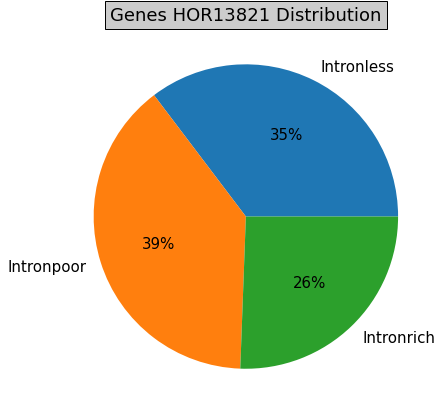

In [445]:
plotting_intron_types(n_intronless_HOR13821, n_intronpoor_HOR13821, n_intronrich_HOR13821, 'Genes HOR13821 Distribution')

In [446]:
### --- Creating the list of HOR13821 gene IDs to check the number of transcripts using command line
intronless_file_HOR13821 = open('Output/HOR13821_intronlessIDs.txt', 'a')
intronpoor_file_HOR13821 = open('Output/HOR13821_intronpoorIDs.txt', 'a')
intronrich_file_HOR13821 = open('Output/HOR13821_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR13821)):
    if i == len(intronless_HOR13821) -1:
        intronless_file_HOR13821.write(intronless_HOR13821[i])
    else:
        intronless_file_HOR13821.write(intronless_HOR13821[i] + '\n')
intronless_file_HOR13821.close()

for i in range(len(intronpoor_HOR13821)):
    if i == len(intronpoor_HOR13821) -1:
        intronpoor_file_HOR13821.write(intronpoor_HOR13821[i])
    else:
        intronpoor_file_HOR13821.write(intronpoor_HOR13821[i] + '\n')
intronpoor_file_HOR13821.close()

for i in range(len(intronrich_HOR13821)):
    if i == len(intronrich_HOR13821) -1:
        intronrich_file_HOR13821.write(intronrich_HOR13821[i])
    else:
        intronrich_file_HOR13821.write(intronrich_HOR13821[i]+'\n')
intronrich_file_HOR13821.close()

In [447]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR13821 = ! grep -f Output/HOR13821_intronlessIDs.txt Data/HOR13821_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR13821 = ! grep -f Output/HOR13821_intronpoorIDs.txt Data/HOR13821_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR13821 = ! grep -f Output/HOR13821_intronrichIDs.txt Data/HOR13821_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [448]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR13821 = int(n_mRNA_intronless_HOR13821[0])/n_intronless_HOR13821
print(avg_mRNA_intronless_HOR13821)
avg_mRNA_intronpoor_HOR13821 = int(n_mRNA_intronpoor_HOR13821[0])/n_intronpoor_HOR13821
print(avg_mRNA_intronpoor_HOR13821)
avg_mRNA_intronrich_HOR13821 = int(n_mRNA_intronrich_HOR13821[0])/n_intronrich_HOR13821
print(avg_mRNA_intronrich_HOR13821)

1.0
1.0
1.0


No alternative splicing.

In [449]:
### --- Basic statistics of HOR13821 introns
introns_HOR13821['length'].describe()

count    130654.000000
mean        595.388316
std        2299.485411
min           1.000000
25%          91.000000
50%         124.000000
75%         425.000000
max      205106.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

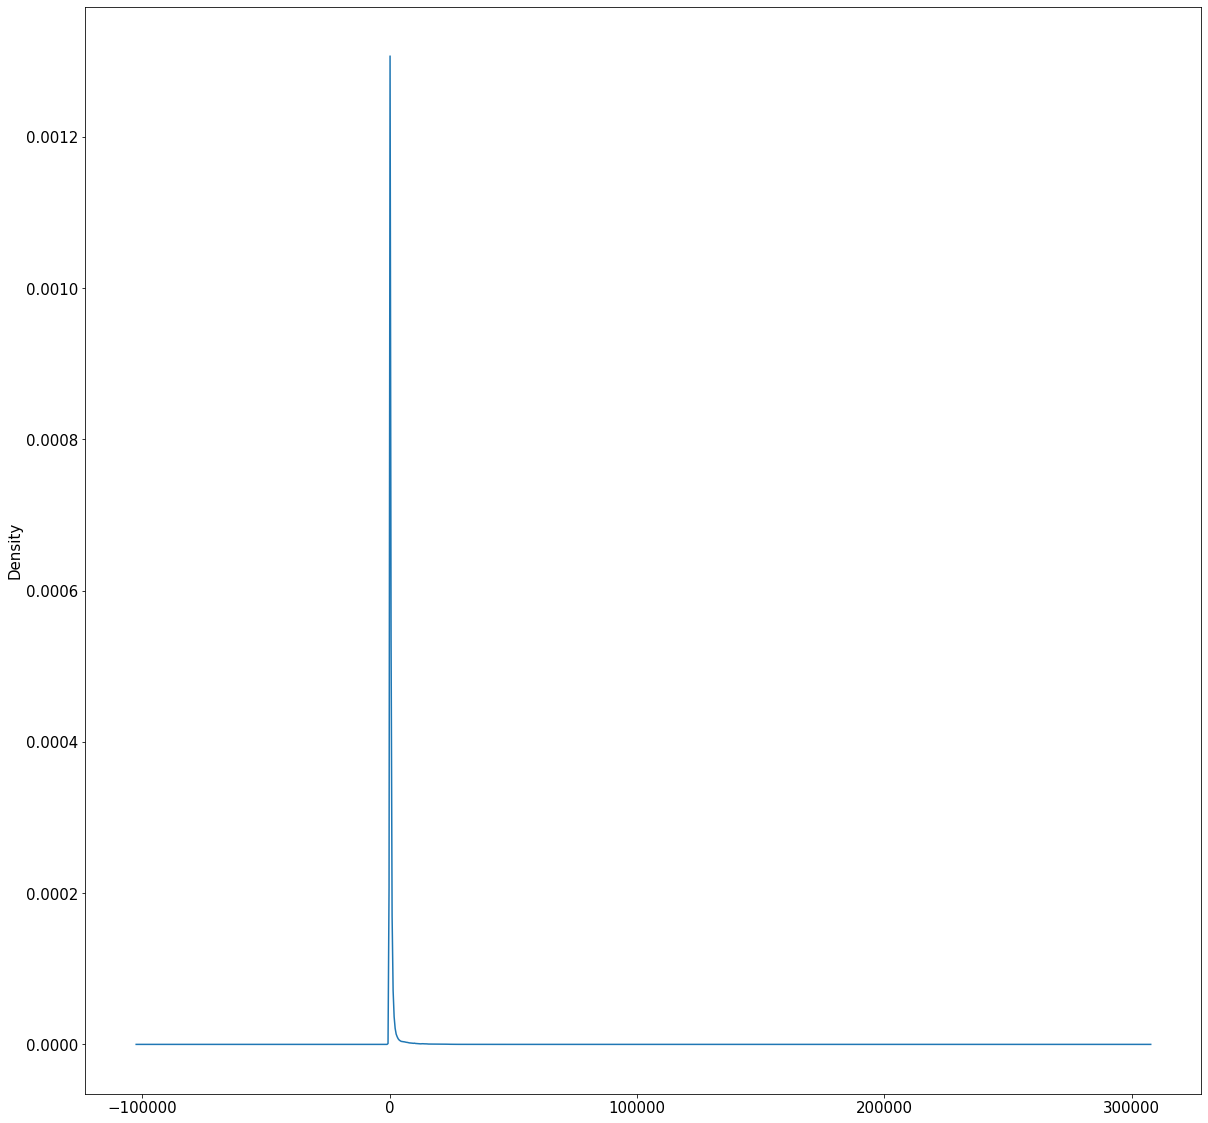

In [450]:
### --- Plotting the distribution of HOR13821 introns length
introns_HOR13821['length'].plot.density()

<AxesSubplot:>

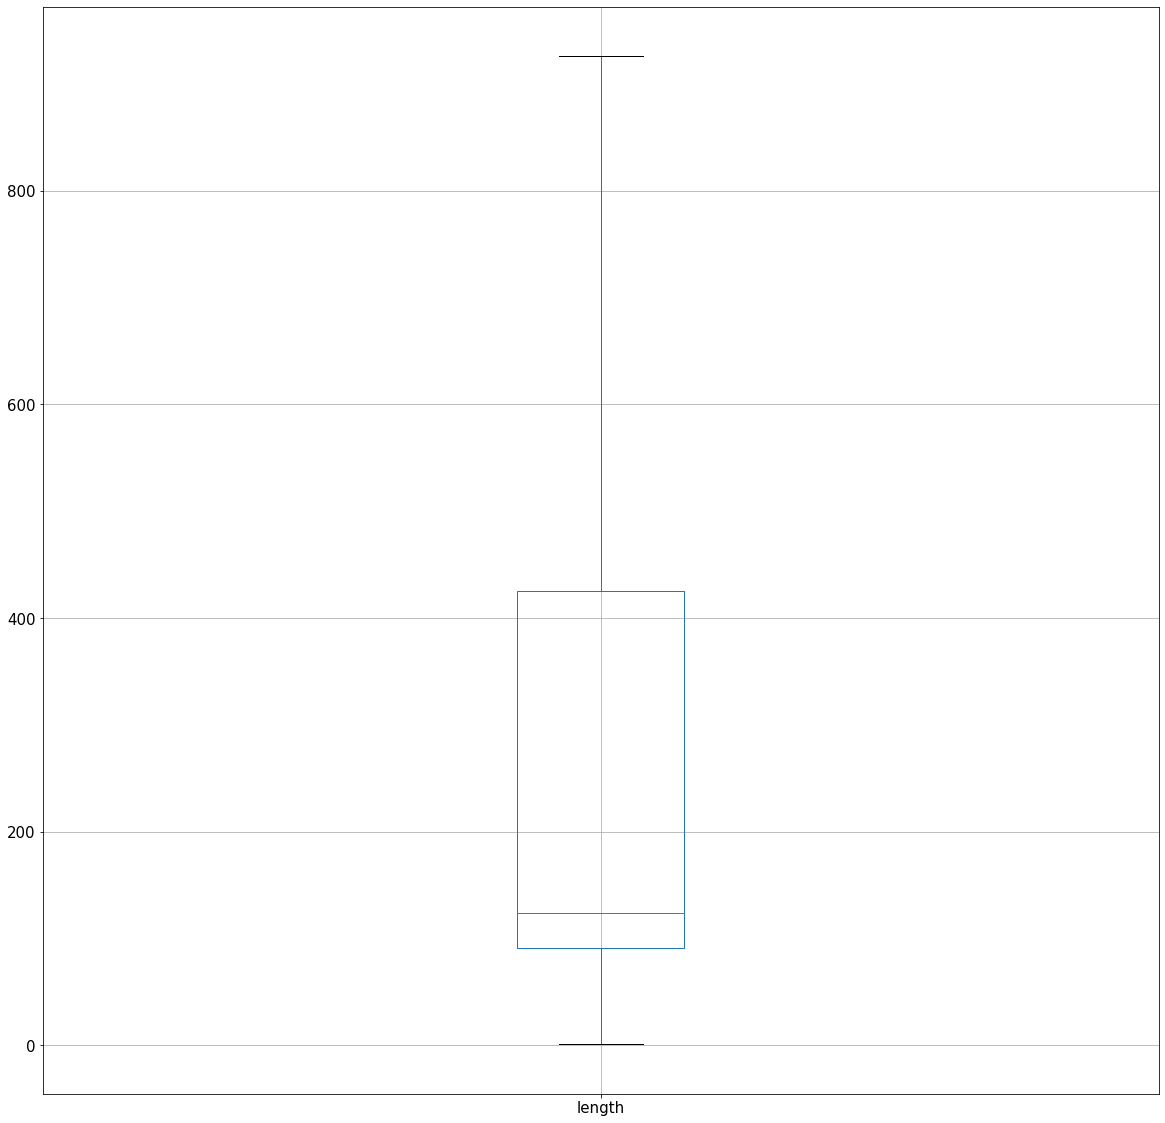

In [451]:
### --- Plotting the boxplot of HOR13821 introns length without outliers
introns_HOR13821.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.11.4 Re-organizing files and directories

In [452]:
! ls Data/

Akashinriki  Barke_gp	     HOR10350		HOR13821_nohashtag.csv	 Morex
B1K	     Golden_Promise  HOR10350_gp	HOR13821_nohashtag.gff3  raw
Barke	     Hockett	     HOR13821_exon.tsv	Hv_Morex_longread


In [453]:
! mkdir Data/HOR13821 

In [454]:
! mv Data/HOR13821_* Data/HOR13821/

In [455]:
! ls Data/

Akashinriki  Barke     Golden_Promise  HOR10350     HOR13821	       Morex
B1K	     Barke_gp  Hockett	       HOR10350_gp  Hv_Morex_longread  raw


In [456]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821_intronlessIDs.txt  Hv_Morex_longread
B1K	     Hockett	     HOR13821_intronpoorIDs.txt  Morex
Barke	     HOR10350	     HOR13821_intronrichIDs.txt
Barke_gp     HOR10350_gp     HOR13821_introns.tsv


In [457]:
! mkdir Output/HOR13821

In [458]:
! mv Output/HOR13821_* Output/HOR13821/

In [459]:
! ls Output/

Akashinriki  Barke     Golden_Promise  HOR10350     HOR13821	       Morex
B1K	     Barke_gp  Hockett	       HOR10350_gp  Hv_Morex_longread


## 3.12 HOR13942 - Gene projection

### 3.12.1 Data Collection

In [460]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR13942.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/e2980ffc-4e10-4812-a1d5-90b0b27f2b9a/1/DOWNLOAD

--2021-10-01 12:21:48--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/e2980ffc-4e10-4812-a1d5-90b0b27f2b9a/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52423842 (50M) [text/plain]
Saving to: ‘Data/raw/HOR13942.gff3’

Data/raw/HOR13942.g 100%[===================>]  50,00M  2,17MB/s    in 30s     

2021-10-01 12:22:18 (1,68 MB/s) - ‘Data/raw/HOR13942.gff3’ saved [52423842/52423842]



### 3.12.2 Processing Data

In [461]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [462]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR13942.gff3  > Data/HOR13942_nohashtag.gff3

In [463]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR13942_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR13942_nohashtag.csv

In [464]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR13942 = pd.read_csv('Data/HOR13942_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR13942.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,pseudogene,18092,24775,2725.823,-,.,ID=Horvu_13942_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,18092,24775,.,-,.,ID=Horvu_13942_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,18092,18262,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,18434,18571,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,18743,18958,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_8


In [465]:
### --- Building a separate dataframe containing all exons
exon_HOR13942 = df_HOR13942.loc[df_HOR13942['type'].isin(['exon'])]
exon_HOR13942.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,18092,18262,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,18434,18571,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,18743,18958,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_8
5,chr1H,PGSBv2.28112019,exon,19304,19377,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_7
6,chr1H,PGSBv2.28112019,exon,19472,19538,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_6


In [466]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR13942.to_csv('Data/HOR13942_exon.tsv',sep='\t',index=False,header=False)

In [467]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR13942 = df_HOR13942.loc[df_HOR13942['strand'].isin(['+'])]
forw_HOR13942.head()

,chr,source,type,start,end,score,strand,phase,attributes
12,chr1H,PGSBv2.28112019,pseudogene,31247,32835,2500.281,+,.,ID=Horvu_13942_1H01G000200
13,chr1H,PGSBv2.28112019,mRNA,31247,32835,.,+,.,ID=Horvu_13942_1H01G000200.1
14,chr1H,PGSBv2.28112019,exon,31247,31563,.,+,.,ID=Horvu_13942_1H01G000200.1_exon_1
15,chr1H,PGSBv2.28112019,exon,31800,31971,.,+,.,ID=Horvu_13942_1H01G000200.1_exon_2
16,chr1H,PGSBv2.28112019,exon,32053,32835,.,+,.,ID=Horvu_13942_1H01G000200.1_exon_3


In [468]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR13942 = df_HOR13942.loc[df_HOR13942['strand'].isin(['-'])]
rev_HOR13942.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,pseudogene,18092,24775,2725.823,-,.,ID=Horvu_13942_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,18092,24775,.,-,.,ID=Horvu_13942_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,18092,18262,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,18434,18571,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,18743,18958,.,-,.,ID=Horvu_13942_1H01G000100.1_exon_8


In [469]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR13942 = forw_HOR13942.loc[df_HOR13942['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR13942.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [470]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR13942 = rev_HOR13942.loc[df_HOR13942['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR13942.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.12.3 Extracting introns from the whole genome

In [471]:
### --- Extracting introns from HOR13942
extract_tot_introns_gp('Data/HOR13942_exon.tsv', 'Output/HOR13942_introns.tsv')

In [472]:
introns_HOR13942 = pd.read_csv('Output/HOR13942_introns.tsv', sep = '\t')
introns_HOR13942[:100]

,ID,type,start,end,length
0,ID=Horvu_13942_1H01G000100.1,intron,18263,18433,172
1,ID=Horvu_13942_1H01G000100.1,intron,18572,18742,172
2,ID=Horvu_13942_1H01G000100.1,intron,18959,19303,346
3,ID=Horvu_13942_1H01G000100.1,intron,19378,19471,95
4,ID=Horvu_13942_1H01G000100.1,intron,19539,23728,4191
...,...,...,...,...,...
95,ID=Horvu_13942_1H01G003100.1,intron,1146928,1147141,215
96,ID=Horvu_13942_1H01G003100.1,intron,1147241,1147340,101
97,ID=Horvu_13942_1H01G003100.1,intron,1147485,1147599,116
98,ID=Horvu_13942_1H01G003100.1,intron,1147815,1148303,490


In [473]:
### --- Counting introns type in HOR13942
introns_dictionary_HOR13942 = counting_introns_type_gp(exon_HOR13942)

In [474]:
n_intronless_HOR13942, n_intronpoor_HOR13942, n_intronrich_HOR13942, intronless_HOR13942, intronpoor_HOR13942, intronrich_HOR13942 = splitting_introns_type(introns_dictionary_HOR13942)

Intronless are: 16792
Intronpoor are: 18390
Intronrich are: 12075


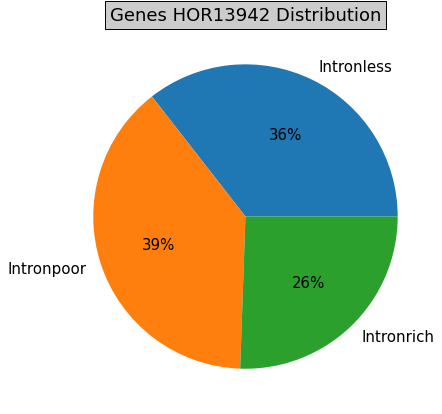

In [475]:
plotting_intron_types(n_intronless_HOR13942, n_intronpoor_HOR13942, n_intronrich_HOR13942, 'Genes HOR13942 Distribution')

In [476]:
### --- Creating the list of HOR13942 gene IDs to check the number of transcripts using command line
intronless_file_HOR13942 = open('Output/HOR13942_intronlessIDs.txt', 'a')
intronpoor_file_HOR13942 = open('Output/HOR13942_intronpoorIDs.txt', 'a')
intronrich_file_HOR13942 = open('Output/HOR13942_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR13942)):
    if i == len(intronless_HOR13942) -1:
        intronless_file_HOR13942.write(intronless_HOR13942[i])
    else:
        intronless_file_HOR13942.write(intronless_HOR13942[i] + '\n')
intronless_file_HOR13942.close()

for i in range(len(intronpoor_HOR13942)):
    if i == len(intronpoor_HOR13942) -1:
        intronpoor_file_HOR13942.write(intronpoor_HOR13942[i])
    else:
        intronpoor_file_HOR13942.write(intronpoor_HOR13942[i] + '\n')
intronpoor_file_HOR13942.close()

for i in range(len(intronrich_HOR13942)):
    if i == len(intronrich_HOR13942) -1:
        intronrich_file_HOR13942.write(intronrich_HOR13942[i])
    else:
        intronrich_file_HOR13942.write(intronrich_HOR13942[i]+'\n')
intronrich_file_HOR13942.close()

In [477]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR13942 = ! grep -f Output/HOR13942_intronlessIDs.txt Data/HOR13942_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR13942 = ! grep -f Output/HOR13942_intronpoorIDs.txt Data/HOR13942_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR13942 = ! grep -f Output/HOR13942_intronrichIDs.txt Data/HOR13942_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [478]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR13942 = int(n_mRNA_intronless_HOR13942[0])/n_intronless_HOR13942
print(avg_mRNA_intronless_HOR13942)
avg_mRNA_intronpoor_HOR13942 = int(n_mRNA_intronpoor_HOR13942[0])/n_intronpoor_HOR13942
print(avg_mRNA_intronpoor_HOR13942)
avg_mRNA_intronrich_HOR13942 = int(n_mRNA_intronrich_HOR13942[0])/n_intronrich_HOR13942
print(avg_mRNA_intronrich_HOR13942)

1.0
1.0
1.0


In [479]:
### --- Basic statistics of HOR13942 introns
introns_HOR13942['length'].describe()

count    130537.000000
mean        586.279553
std        2427.972104
min           1.000000
25%          91.000000
50%         124.000000
75%         424.000000
max      401609.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

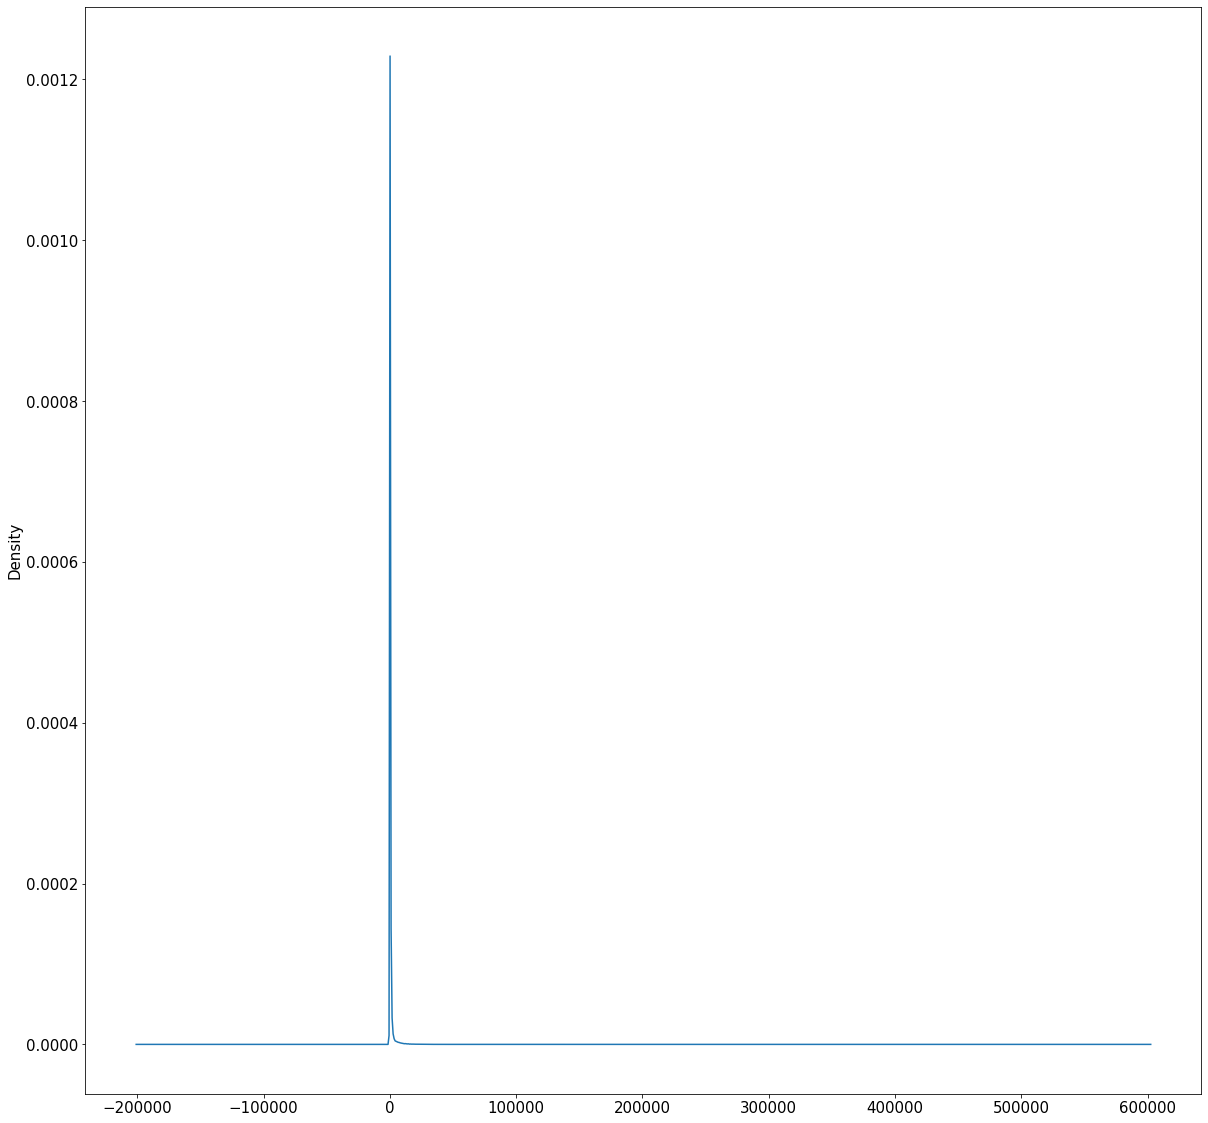

In [480]:
### --- Plotting the distribution of HOR13942 introns length
introns_HOR13942['length'].plot.density()

<AxesSubplot:>

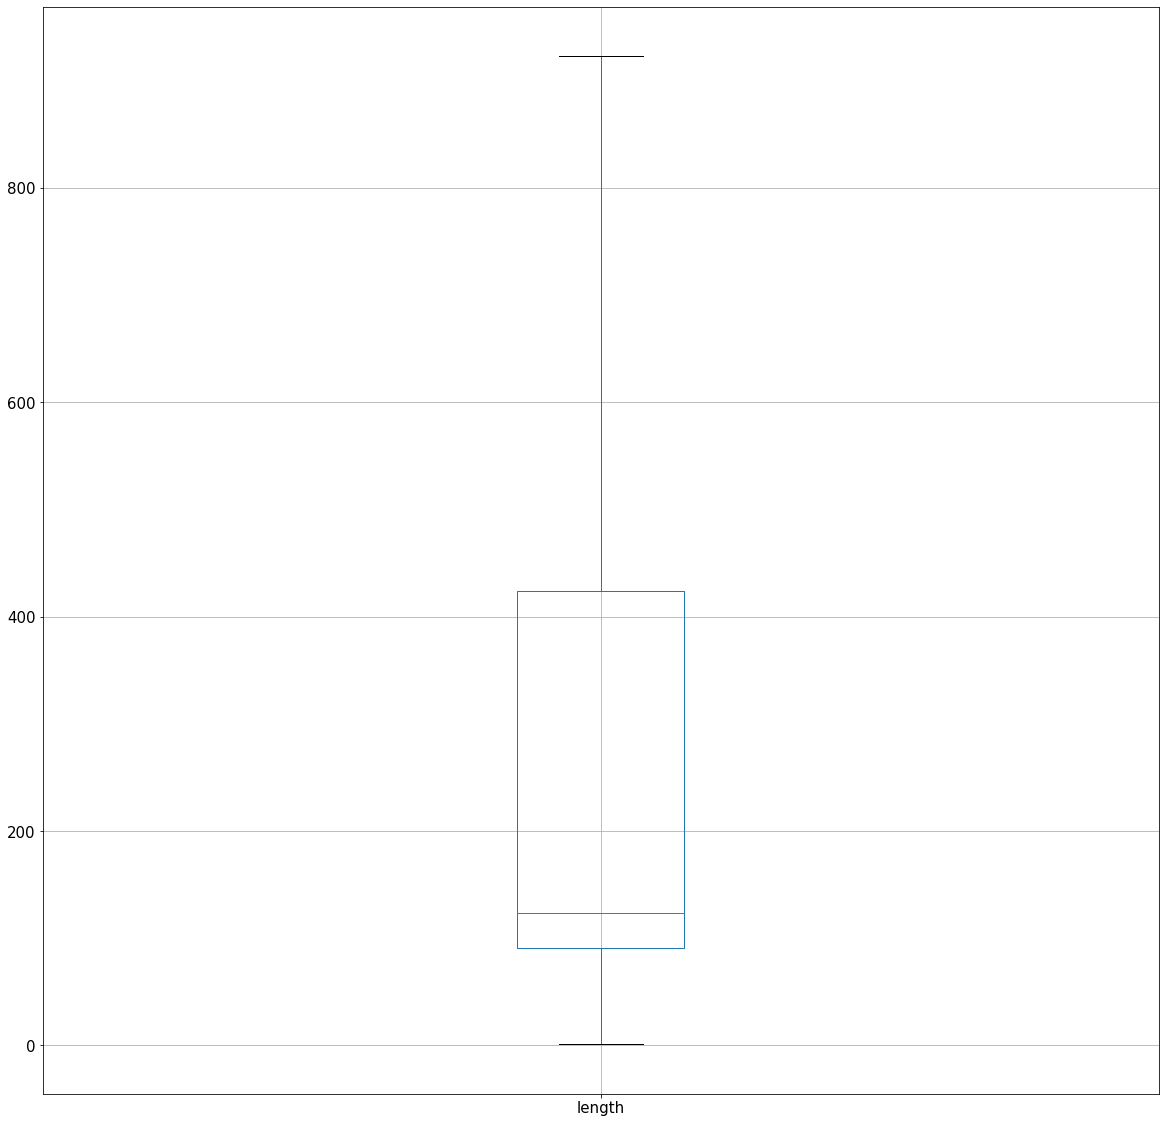

In [481]:
### --- Plotting the boxplot of HOR13942 introns length without outliers
introns_HOR13942.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.12.4 Re-organizing files and directories

In [482]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821		      Hv_Morex_longread
B1K	     Hockett	     HOR13942_exon.tsv	      Morex
Barke	     HOR10350	     HOR13942_nohashtag.csv   raw
Barke_gp     HOR10350_gp     HOR13942_nohashtag.gff3


In [483]:
! mkdir Data/HOR13942

In [484]:
! mv Data/HOR13942_* Data/HOR13942/

In [485]:
! ls Data/

Akashinriki  Barke_gp	     HOR10350	  HOR13942	     raw
B1K	     Golden_Promise  HOR10350_gp  Hv_Morex_longread
Barke	     Hockett	     HOR13821	  Morex


In [486]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821			 HOR13942_introns.tsv
B1K	     Hockett	     HOR13942_intronlessIDs.txt  Hv_Morex_longread
Barke	     HOR10350	     HOR13942_intronpoorIDs.txt  Morex
Barke_gp     HOR10350_gp     HOR13942_intronrichIDs.txt


In [487]:
! mkdir Output/HOR13942

In [488]:
! mv Output/HOR13942_* Output/HOR13942/

In [489]:
! ls Output/

Akashinriki  Barke     Golden_Promise  HOR10350     HOR13821  Hv_Morex_longread
B1K	     Barke_gp  Hockett	       HOR10350_gp  HOR13942  Morex


## 3.13 HOR21599 - Gene projection

### 3.13.1 Data Collection

In [490]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR21599.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/23c55a21-9a5e-4edf-9ce3-ac3780213e4a/1/DOWNLOAD

--2021-10-01 12:22:34--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/23c55a21-9a5e-4edf-9ce3-ac3780213e4a/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52333919 (50M) [text/plain]
Saving to: ‘Data/raw/HOR21599.gff3’

Data/raw/HOR21599.g 100%[===================>]  49,91M   678KB/s    in 34s     

2021-10-01 12:23:09 (1,45 MB/s) - ‘Data/raw/HOR21599.gff3’ saved [52333919/52333919]



### 3.13.2 Processing Data

In [491]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [492]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR21599.gff3  > Data/HOR21599_nohashtag.gff3

In [493]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR21599_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR21599_nohashtag.csv

In [494]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR21599 = pd.read_csv('Data/HOR21599_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR21599.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,2644,2919,560.496,+,.,ID=Horvu_21599_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,2644,2919,.,+,.,ID=Horvu_21599_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,2644,2919,.,+,.,ID=Horvu_21599_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,CDS,2644,2919,.,+,0,Parent=Horvu_21599_1H01G000100.1
4,chr1H,PGSBv2.28112019,gene,333354,333962,835.168,+,.,ID=Horvu_21599_1H01G000200


In [495]:
### --- Building a separate dataframe containing all exons
exon_HOR21599 = df_HOR21599.loc[df_HOR21599['type'].isin(['exon'])]
exon_HOR21599.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,2644,2919,.,+,.,ID=Horvu_21599_1H01G000100.1_exon_1
6,chr1H,PGSBv2.28112019,exon,333354,333557,.,+,.,ID=Horvu_21599_1H01G000200.1_exon_1
7,chr1H,PGSBv2.28112019,exon,333726,333962,.,+,.,ID=Horvu_21599_1H01G000200.1_exon_2
12,chr1H,PGSBv2.28112019,exon,348664,348874,.,-,.,ID=Horvu_21599_1H01G000300.1_exon_8
13,chr1H,PGSBv2.28112019,exon,348953,349356,.,-,.,ID=Horvu_21599_1H01G000300.1_exon_7


In [496]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR21599.to_csv('Data/HOR21599_exon.tsv',sep='\t',index=False,header=False)

In [497]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR21599 = df_HOR21599.loc[df_HOR21599['strand'].isin(['+'])]
forw_HOR21599.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,2644,2919,560.496,+,.,ID=Horvu_21599_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,2644,2919,.,+,.,ID=Horvu_21599_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,2644,2919,.,+,.,ID=Horvu_21599_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,CDS,2644,2919,.,+,0,Parent=Horvu_21599_1H01G000100.1
4,chr1H,PGSBv2.28112019,gene,333354,333962,835.168,+,.,ID=Horvu_21599_1H01G000200


In [498]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR21599 = df_HOR21599.loc[df_HOR21599['strand'].isin(['-'])]
rev_HOR21599.head()

,chr,source,type,start,end,score,strand,phase,attributes
10,chr1H,PGSBv2.28112019,gene,348664,353806,3025.512,-,.,ID=Horvu_21599_1H01G000300
11,chr1H,PGSBv2.28112019,mRNA,348664,353806,.,-,.,ID=Horvu_21599_1H01G000300.1
12,chr1H,PGSBv2.28112019,exon,348664,348874,.,-,.,ID=Horvu_21599_1H01G000300.1_exon_8
13,chr1H,PGSBv2.28112019,exon,348953,349356,.,-,.,ID=Horvu_21599_1H01G000300.1_exon_7
14,chr1H,PGSBv2.28112019,exon,349932,350013,.,-,.,ID=Horvu_21599_1H01G000300.1_exon_6


In [499]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR21599 = forw_HOR21599.loc[df_HOR21599['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR21599.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [500]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR21599 = rev_HOR21599.loc[df_HOR21599['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR21599.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.13.3 Extracting introns from the whole genome

In [501]:
### --- Extracting introns from HOR21599
extract_tot_introns_gp('Data/HOR21599_exon.tsv', 'Output/HOR21599_introns.tsv')

In [502]:
introns_HOR21599 = pd.read_csv('Output/HOR21599_introns.tsv', sep = '\t')
introns_HOR21599[:100]

,ID,type,start,end,length
0,ID=Horvu_21599_1H01G000200.1,intron,333558,333725,169
1,ID=Horvu_21599_1H01G000300.1,intron,348875,348952,79
2,ID=Horvu_21599_1H01G000300.1,intron,349357,349931,576
3,ID=Horvu_21599_1H01G000300.1,intron,350014,350103,91
4,ID=Horvu_21599_1H01G000300.1,intron,350272,350730,460
...,...,...,...,...,...
95,ID=Horvu_21599_1H01G002900.1,intron,1604241,1604337,98
96,ID=Horvu_21599_1H01G002900.1,intron,1604438,1604642,206
97,ID=Horvu_21599_1H01G002900.1,intron,1604769,1604879,112
98,ID=Horvu_21599_1H01G002900.1,intron,1605413,1607638,2227


In [503]:
### --- Counting introns type in HOR21599
introns_dictionary_HOR21599 = counting_introns_type_gp(exon_HOR21599)

In [504]:
n_intronless_HOR21599, n_intronpoor_HOR21599, n_intronrich_HOR21599, intronless_HOR21599, intronpoor_HOR21599, intronrich_HOR21599 = splitting_introns_type(introns_dictionary_HOR21599)

Intronless are: 16606
Intronpoor are: 18376
Intronrich are: 12098


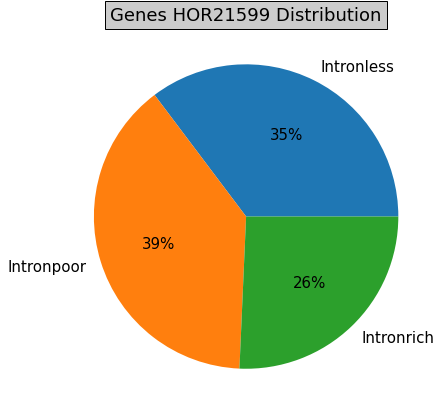

In [505]:
plotting_intron_types(n_intronless_HOR21599, n_intronpoor_HOR21599, n_intronrich_HOR21599, 'Genes HOR21599 Distribution')

In [506]:
### --- Creating the list of HOR21599 gene IDs to check the number of transcripts using command line
intronless_file_HOR21599 = open('Output/HOR21599_intronlessIDs.txt', 'a')
intronpoor_file_HOR21599 = open('Output/HOR21599_intronpoorIDs.txt', 'a')
intronrich_file_HOR21599 = open('Output/HOR21599_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR21599)):
    if i == len(intronless_HOR21599) -1:
        intronless_file_HOR21599.write(intronless_HOR21599[i])
    else:
        intronless_file_HOR21599.write(intronless_HOR21599[i] + '\n')
intronless_file_HOR21599.close()

for i in range(len(intronpoor_HOR21599)):
    if i == len(intronpoor_HOR21599) -1:
        intronpoor_file_HOR21599.write(intronpoor_HOR21599[i])
    else:
        intronpoor_file_HOR21599.write(intronpoor_HOR21599[i] + '\n')
intronpoor_file_HOR21599.close()

for i in range(len(intronrich_HOR21599)):
    if i == len(intronrich_HOR21599) -1:
        intronrich_file_HOR21599.write(intronrich_HOR21599[i])
    else:
        intronrich_file_HOR21599.write(intronrich_HOR21599[i]+'\n')
intronrich_file_HOR21599.close()

In [507]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR21599 = ! grep -f Output/HOR21599_intronlessIDs.txt Data/HOR21599_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR21599 = ! grep -f Output/HOR21599_intronpoorIDs.txt Data/HOR21599_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR21599 = ! grep -f Output/HOR21599_intronrichIDs.txt Data/HOR21599_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [508]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR21599 = int(n_mRNA_intronless_HOR21599[0])/n_intronless_HOR21599
print(avg_mRNA_intronless_HOR21599)
avg_mRNA_intronpoor_HOR21599 = int(n_mRNA_intronpoor_HOR21599[0])/n_intronpoor_HOR21599
print(avg_mRNA_intronpoor_HOR21599)
avg_mRNA_intronrich_HOR21599 = int(n_mRNA_intronrich_HOR21599[0])/n_intronrich_HOR21599
print(avg_mRNA_intronrich_HOR21599)

1.0
1.0
1.0


No alternative splicing.

In [509]:
### --- Basic statistics of HOR21599 introns
introns_HOR21599['length'].describe()

count    130697.000000
mean        592.505329
std        2207.452920
min           1.000000
25%          91.000000
50%         123.000000
75%         421.000000
max      168847.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

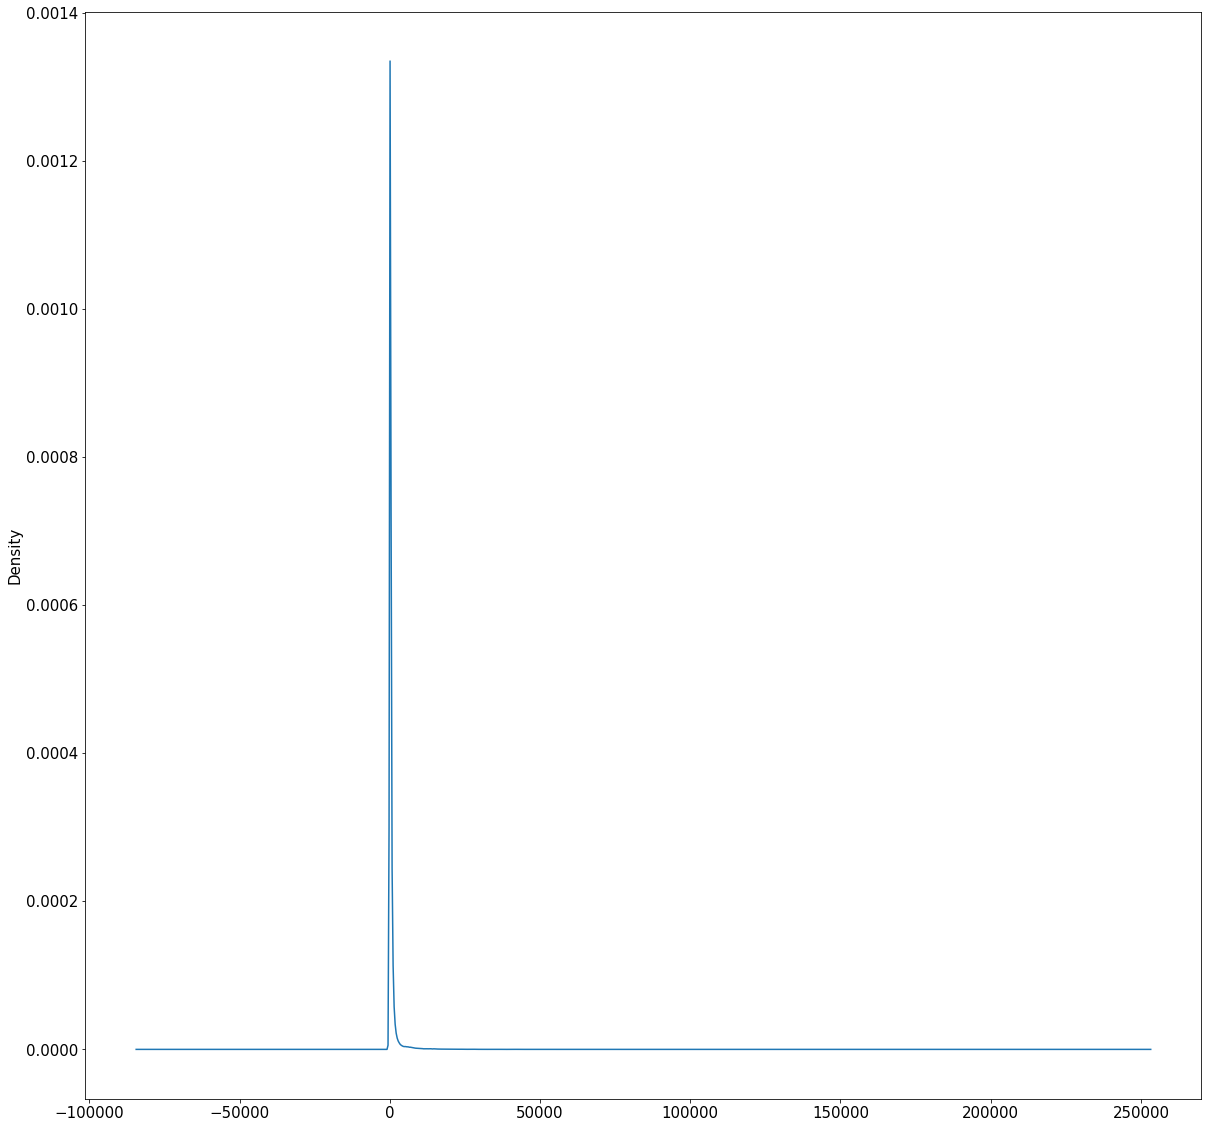

In [510]:
### --- Plotting the distribution of HOR21599 introns length
introns_HOR21599['length'].plot.density()

<AxesSubplot:>

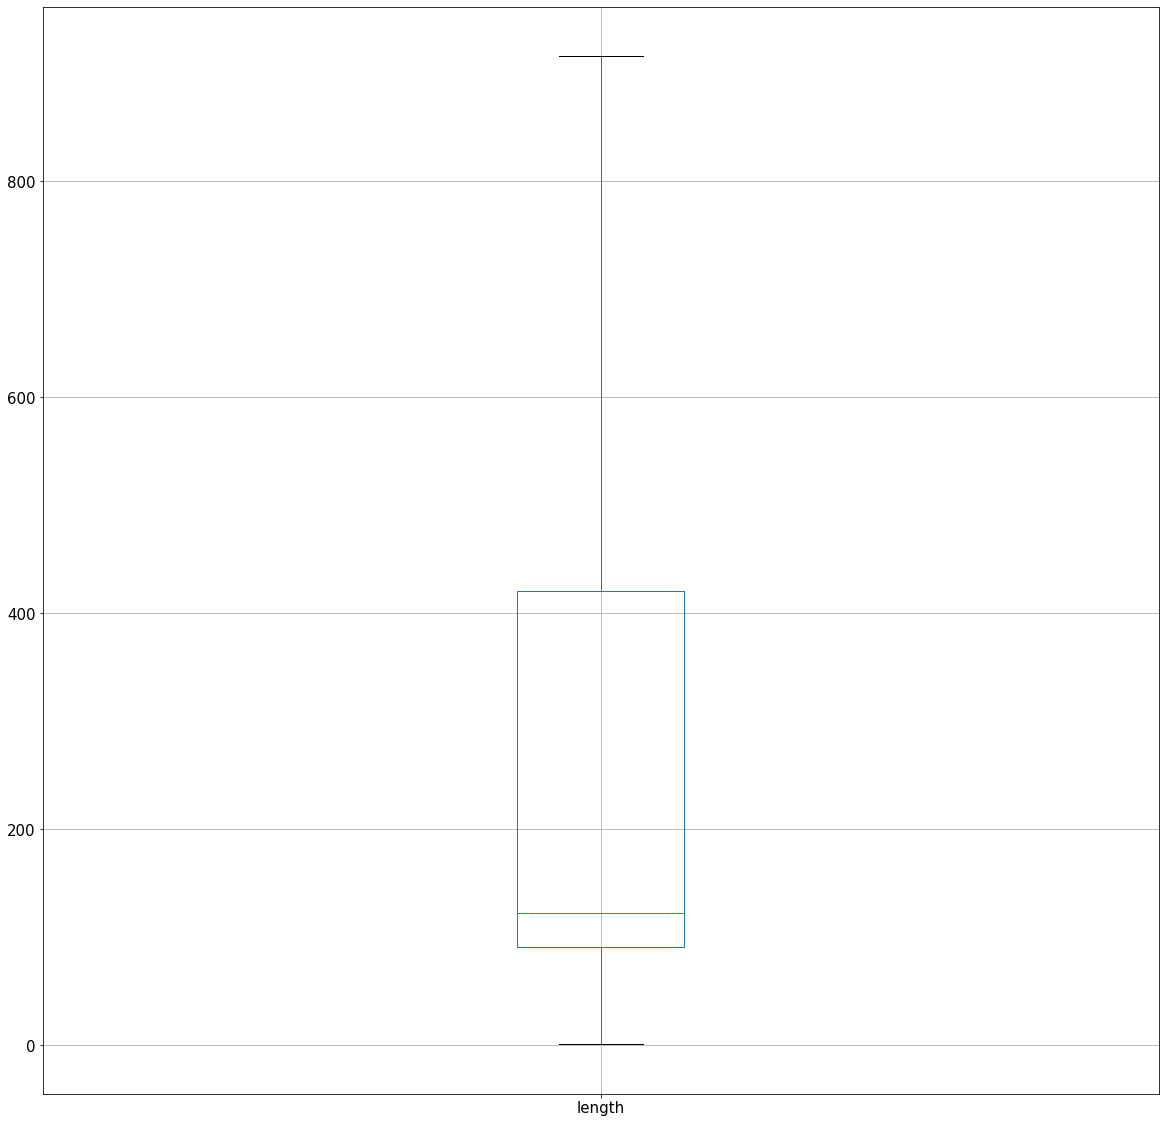

In [511]:
### --- Plotting the boxplot of HOR21599 introns length without outliers
introns_HOR21599.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.13.4 Re-organizing files and directories

In [512]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821		     HOR21599_nohashtag.gff3
B1K	     Hockett	     HOR13942		     Hv_Morex_longread
Barke	     HOR10350	     HOR21599_exon.tsv	     Morex
Barke_gp     HOR10350_gp     HOR21599_nohashtag.csv  raw


In [513]:
! mkdir Data/HOR21599

In [514]:
! mv Data/HOR21599_* Data/HOR21599/

In [515]:
! ls Data/

Akashinriki  Barke_gp	     HOR10350	  HOR13942	     Morex
B1K	     Golden_Promise  HOR10350_gp  HOR21599	     raw
Barke	     Hockett	     HOR13821	  Hv_Morex_longread


In [516]:
! ls Output/

Akashinriki	HOR10350		    HOR21599_intronrichIDs.txt
B1K		HOR10350_gp		    HOR21599_introns.tsv
Barke		HOR13821		    Hv_Morex_longread
Barke_gp	HOR13942		    Morex
Golden_Promise	HOR21599_intronlessIDs.txt
Hockett		HOR21599_intronpoorIDs.txt


In [517]:
! mkdir Output/HOR21599

In [518]:
! mv Output/HOR21599_* Output/HOR21599/

In [519]:
! ls Output/

Akashinriki  Barke_gp	     HOR10350	  HOR13942	     Morex
B1K	     Golden_Promise  HOR10350_gp  HOR21599
Barke	     Hockett	     HOR13821	  Hv_Morex_longread


## 3.14  HOR3081 - Gene projection

### 3.14.1 Data Collection

In [520]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR3081.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/9615c59f-4b06-44bf-ad99-e75c0afb4272/1/DOWNLOAD

--2021-10-01 12:23:25--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/9615c59f-4b06-44bf-ad99-e75c0afb4272/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52108857 (50M) [text/plain]
Saving to: ‘Data/raw/HOR3081.gff3’

Data/raw/HOR3081.gf 100%[===================>]  49,69M   863KB/s    in 49s     

2021-10-01 12:24:14 (1,01 MB/s) - ‘Data/raw/HOR3081.gff3’ saved [52108857/52108857]



### 3.14.2 Processing Data 

In [521]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [522]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR3081.gff3  > Data/HOR3081_nohashtag.gff3

In [523]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR3081_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR3081_nohashtag.csv

In [524]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR3081 = pd.read_csv('Data/HOR3081_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR3081.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,80104,80937,818.635,+,.,ID=Horvu_3081_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,80104,80937,.,+,.,ID=Horvu_3081_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,80104,80281,.,+,.,ID=Horvu_3081_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,80705,80937,.,+,.,ID=Horvu_3081_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,80104,80281,.,+,0,Parent=Horvu_3081_1H01G000100.1


In [525]:
### --- Building a separate dataframe containing all exons
exon_HOR3081 = df_HOR3081.loc[df_HOR3081['type'].isin(['exon'])]
exon_HOR3081.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,80104,80281,.,+,.,ID=Horvu_3081_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,80705,80937,.,+,.,ID=Horvu_3081_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,105480,106109,.,+,.,ID=Horvu_3081_1H01G000200.1_exon_1
12,chr1H,PGSBv2.28112019,exon,107247,107693,.,-,.,ID=Horvu_3081_1H01G000300.1_exon_10
13,chr1H,PGSBv2.28112019,exon,107799,107840,.,-,.,ID=Horvu_3081_1H01G000300.1_exon_9


In [526]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR3081.to_csv('Data/HOR3081_exon.tsv',sep='\t',index=False,header=False)

In [527]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR3081 = df_HOR3081.loc[df_HOR3081['strand'].isin(['+'])]
forw_HOR3081.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,80104,80937,818.635,+,.,ID=Horvu_3081_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,80104,80937,.,+,.,ID=Horvu_3081_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,80104,80281,.,+,.,ID=Horvu_3081_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,80705,80937,.,+,.,ID=Horvu_3081_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,80104,80281,.,+,0,Parent=Horvu_3081_1H01G000100.1


In [528]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR3081 = df_HOR3081.loc[df_HOR3081['strand'].isin(['-'])]
rev_HOR3081.head()

,chr,source,type,start,end,score,strand,phase,attributes
10,chr1H,PGSBv2.28112019,gene,107247,110441,2779.294,-,.,ID=Horvu_3081_1H01G000300
11,chr1H,PGSBv2.28112019,mRNA,107247,110441,.,-,.,ID=Horvu_3081_1H01G000300.1
12,chr1H,PGSBv2.28112019,exon,107247,107693,.,-,.,ID=Horvu_3081_1H01G000300.1_exon_10
13,chr1H,PGSBv2.28112019,exon,107799,107840,.,-,.,ID=Horvu_3081_1H01G000300.1_exon_9
14,chr1H,PGSBv2.28112019,exon,108345,108412,.,-,.,ID=Horvu_3081_1H01G000300.1_exon_8


In [529]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR3081 = forw_HOR3081.loc[df_HOR3081['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR3081.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [530]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR3081 = rev_HOR3081.loc[df_HOR3081['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR3081.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.14.3 Extracting introns from the whole genome

In [531]:
### --- Extracting introns from HOR3081
extract_tot_introns_gp('Data/HOR3081_exon.tsv', 'Output/HOR3081_introns.tsv')

In [532]:
introns_HOR3081 = pd.read_csv('Output/HOR3081_introns.tsv', sep = '\t')
introns_HOR3081[:100]

,ID,type,start,end,length
0,ID=Horvu_3081_1H01G000100.1,intron,80282,80704,424
1,ID=Horvu_3081_1H01G000300.1,intron,107694,107798,106
2,ID=Horvu_3081_1H01G000300.1,intron,107841,108344,505
3,ID=Horvu_3081_1H01G000300.1,intron,108413,108492,81
4,ID=Horvu_3081_1H01G000300.1,intron,108536,108636,102
...,...,...,...,...,...
95,ID=Horvu_3081_1H01G002700.1,intron,1023481,1024933,1454
96,ID=Horvu_3081_1H01G002700.1,intron,1026050,1026140,92
97,ID=Horvu_3081_1H01G002800.1,intron,1028354,1028747,395
98,ID=Horvu_3081_1H01G002900.1,intron,1058437,1058456,21


In [533]:
### --- Counting introns type in HOR3081
introns_dictionary_HOR3081 = counting_introns_type_gp(exon_HOR3081)

In [534]:
n_intronless_HOR3081, n_intronpoor_HOR3081, n_intronrich_HOR3081, intronless_HOR3081, intronpoor_HOR3081, intronrich_HOR3081 = splitting_introns_type(introns_dictionary_HOR3081)

Intronless are: 16918
Intronpoor are: 18594
Intronrich are: 12087


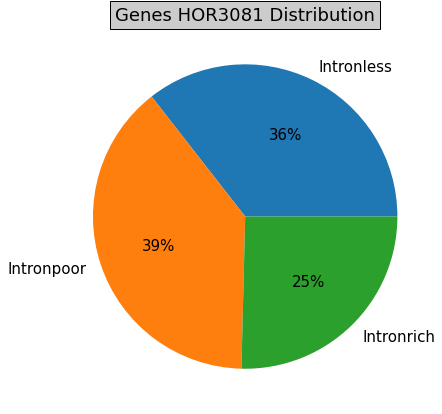

In [535]:
plotting_intron_types(n_intronless_HOR3081, n_intronpoor_HOR3081, n_intronrich_HOR3081, 'Genes HOR3081 Distribution')

In [536]:
### --- Creating the list of HOR3081 gene IDs to check the number of transcripts using command line
intronless_file_HOR3081 = open('Output/HOR3081_intronlessIDs.txt', 'a')
intronpoor_file_HOR3081 = open('Output/HOR3081_intronpoorIDs.txt', 'a')
intronrich_file_HOR3081 = open('Output/HOR3081_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR3081)):
    if i == len(intronless_HOR3081) -1:
        intronless_file_HOR3081.write(intronless_HOR3081[i])
    else:
        intronless_file_HOR3081.write(intronless_HOR3081[i] + '\n')
intronless_file_HOR3081.close()

for i in range(len(intronpoor_HOR3081)):
    if i == len(intronpoor_HOR3081) -1:
        intronpoor_file_HOR3081.write(intronpoor_HOR3081[i])
    else:
        intronpoor_file_HOR3081.write(intronpoor_HOR3081[i] + '\n')
intronpoor_file_HOR3081.close()

for i in range(len(intronrich_HOR3081)):
    if i == len(intronrich_HOR3081) -1:
        intronrich_file_HOR3081.write(intronrich_HOR3081[i])
    else:
        intronrich_file_HOR3081.write(intronrich_HOR3081[i]+'\n')
intronrich_file_HOR3081.close()

In [537]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR3081 = ! grep -f Output/HOR3081_intronlessIDs.txt Data/HOR3081_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR3081 = ! grep -f Output/HOR3081_intronpoorIDs.txt Data/HOR3081_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR3081 = ! grep -f Output/HOR3081_intronrichIDs.txt Data/HOR3081_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [538]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR3081 = int(n_mRNA_intronless_HOR3081[0])/n_intronless_HOR3081
print(avg_mRNA_intronless_HOR3081)
avg_mRNA_intronpoor_HOR3081 = int(n_mRNA_intronpoor_HOR3081[0])/n_intronpoor_HOR3081
print(avg_mRNA_intronpoor_HOR3081)
avg_mRNA_intronrich_HOR3081 = int(n_mRNA_intronrich_HOR3081[0])/n_intronrich_HOR3081
print(avg_mRNA_intronrich_HOR3081)

1.0
1.0
1.0


No alternative splicing. 

In [539]:
### --- Basic statistics of HOR3081 introns
introns_HOR3081['length'].describe()

count    131189.000000
mean        578.983832
std        2199.453188
min           1.000000
25%          91.000000
50%         124.000000
75%         423.000000
max      162575.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

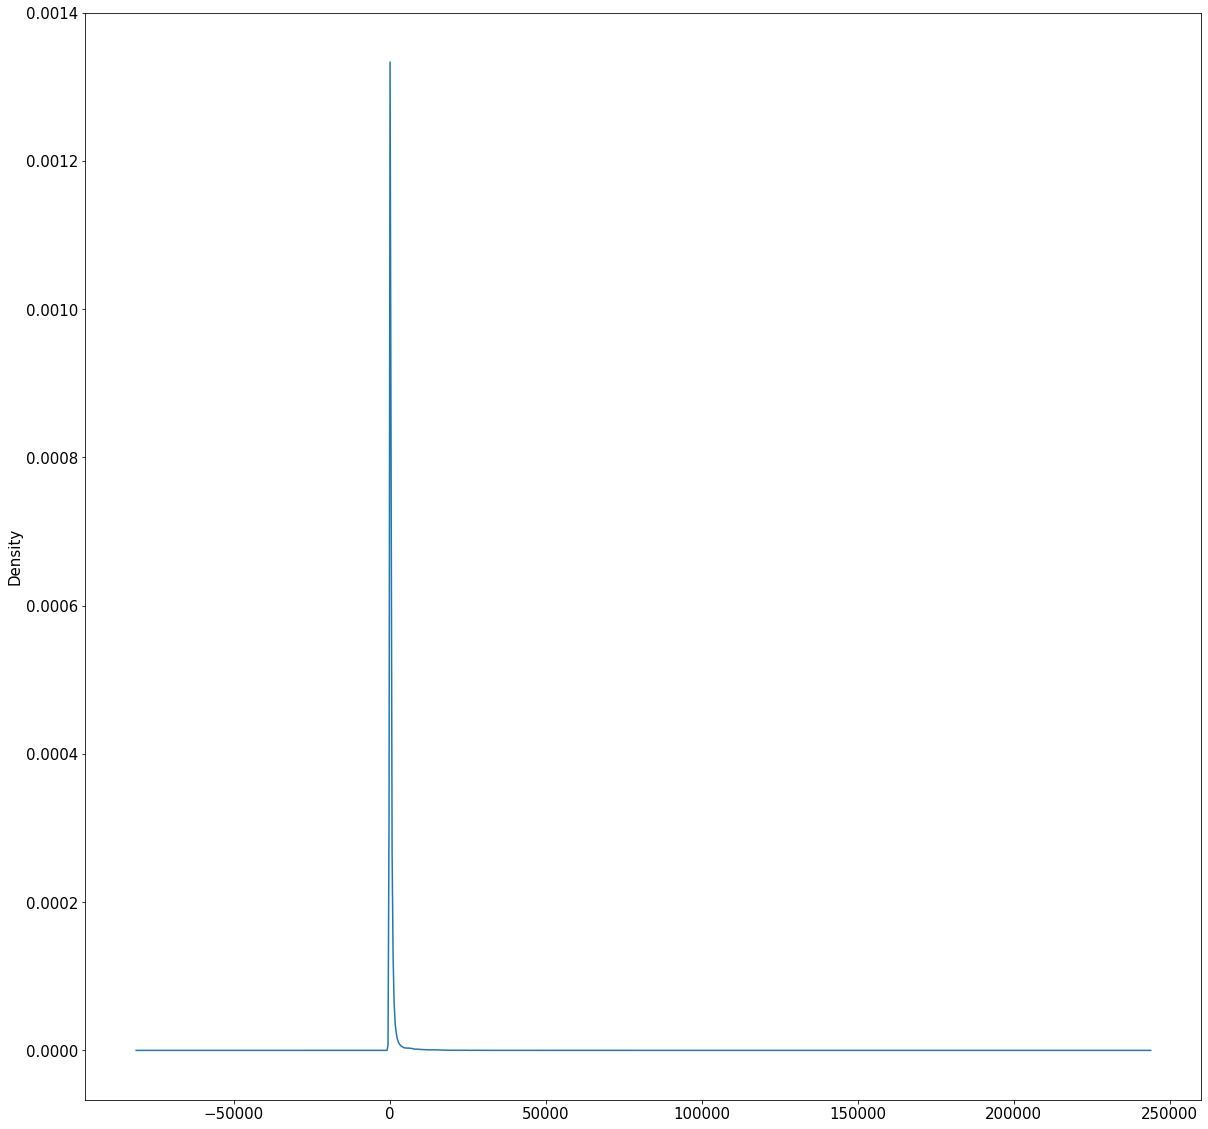

In [540]:
### --- Plotting the distribution of HOR3081 introns length
introns_HOR3081['length'].plot.density()

<AxesSubplot:>

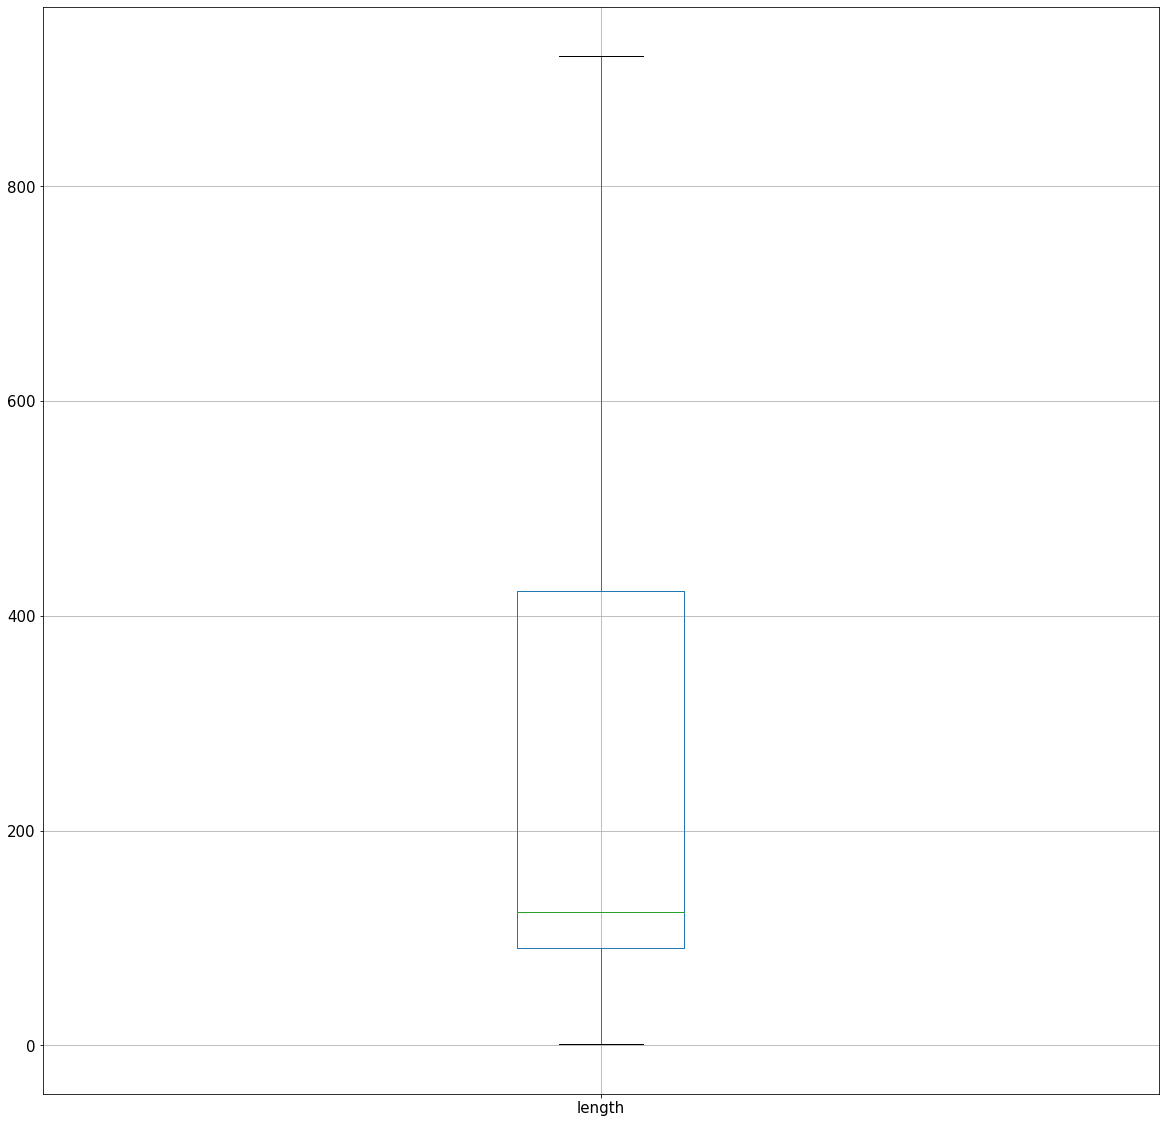

In [541]:
### --- Plotting the boxplot of HOR3081 introns length without outliers
introns_HOR3081.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.14.4 Re-organizing files and directories

In [542]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821	       HOR3081_nohashtag.csv   raw
B1K	     Hockett	     HOR13942	       HOR3081_nohashtag.gff3
Barke	     HOR10350	     HOR21599	       Hv_Morex_longread
Barke_gp     HOR10350_gp     HOR3081_exon.tsv  Morex


In [543]:
! mkdir Data/HOR3081

In [544]:
! mv Data/HOR3081_* Data/HOR3081/

In [545]:
! ls Data/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  Hv_Morex_longread
B1K	     Golden_Promise  HOR10350_gp  HOR21599  Morex
Barke	     Hockett	     HOR13821	  HOR3081   raw


In [546]:
! ls Output/

Akashinriki	Hockett      HOR21599			Hv_Morex_longread
B1K		HOR10350     HOR3081_intronlessIDs.txt	Morex
Barke		HOR10350_gp  HOR3081_intronpoorIDs.txt
Barke_gp	HOR13821     HOR3081_intronrichIDs.txt
Golden_Promise	HOR13942     HOR3081_introns.tsv


In [547]:
! mkdir Output/HOR3081 

In [548]:
! mv Output/HOR3081_* Output/HOR3081/

In [549]:
! ls Output/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  Hv_Morex_longread
B1K	     Golden_Promise  HOR10350_gp  HOR21599  Morex
Barke	     Hockett	     HOR13821	  HOR3081


## 3.15 HOR3365 - Gene projection

### 3.15.1 Data Collection

In [550]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR3365.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/7c5ccbfb-0a17-4621-8d07-0fb1b16165d0/1/DOWNLOAD

--2021-10-01 12:24:35--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/7c5ccbfb-0a17-4621-8d07-0fb1b16165d0/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53598908 (51M) [text/plain]
Saving to: ‘Data/raw/HOR3365.gff3’

Data/raw/HOR3365.gf 100%[===================>]  51,12M  1,24MB/s    in 50s     

2021-10-01 12:25:25 (1,03 MB/s) - ‘Data/raw/HOR3365.gff3’ saved [53598908/53598908]



### 3.15.2 Processing Data 

In [551]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [552]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR3365.gff3  > Data/HOR3365_nohashtag.gff3

In [553]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR3365_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR3365_nohashtag.csv

In [554]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR3365 = pd.read_csv('Data/HOR3365_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR3365.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,70946,71554,846.798,+,.,ID=Horvu_HHOR_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,70946,71554,.,+,.,ID=Horvu_HHOR_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,70946,71149,.,+,.,ID=Horvu_HHOR_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,71318,71554,.,+,.,ID=Horvu_HHOR_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,70946,71149,.,+,0,Parent=Horvu_HHOR_1H01G000100.1


In [555]:
### --- Building a separate dataframe containing all exons
exon_HOR3365 = df_HOR3365.loc[df_HOR3365['type'].isin(['exon'])]
exon_HOR3365.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,70946,71149,.,+,.,ID=Horvu_HHOR_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,71318,71554,.,+,.,ID=Horvu_HHOR_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,74831,75106,.,-,.,ID=Horvu_HHOR_1H01G000200.1_exon_1
12,chr1H,PGSBv2.28112019,exon,90323,90533,.,-,.,ID=Horvu_HHOR_1H01G000300.1_exon_5
13,chr1H,PGSBv2.28112019,exon,90613,90977,.,-,.,ID=Horvu_HHOR_1H01G000300.1_exon_4


In [556]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR3365.to_csv('Data/HOR3365_exon.tsv',sep='\t',index=False,header=False)

In [557]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR3365 = df_HOR3365.loc[df_HOR3365['strand'].isin(['+'])]
forw_HOR3365.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,70946,71554,846.798,+,.,ID=Horvu_HHOR_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,70946,71554,.,+,.,ID=Horvu_HHOR_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,70946,71149,.,+,.,ID=Horvu_HHOR_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,71318,71554,.,+,.,ID=Horvu_HHOR_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,70946,71149,.,+,0,Parent=Horvu_HHOR_1H01G000100.1


In [558]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR3365 = df_HOR3365.loc[df_HOR3365['strand'].isin(['-'])]
rev_HOR3365.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,PGSBv2.28112019,gene,74831,75106,561.711,-,.,ID=Horvu_HHOR_1H01G000200
7,chr1H,PGSBv2.28112019,mRNA,74831,75106,.,-,.,ID=Horvu_HHOR_1H01G000200.1
8,chr1H,PGSBv2.28112019,exon,74831,75106,.,-,.,ID=Horvu_HHOR_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,CDS,74831,75106,.,-,0,Parent=Horvu_HHOR_1H01G000200.1
10,chr1H,PGSBv2.28112019,gene,90323,92457,2015.066,-,.,ID=Horvu_HHOR_1H01G000300


In [559]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR3365 = forw_HOR3365.loc[df_HOR3365['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR3365.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [560]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR3365 = rev_HOR3365.loc[df_HOR3365['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR3365.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.15.3 Extracting introns from the whole genome

In [561]:
### --- Extracting introns from HOR3365
extract_tot_introns_gp('Data/HOR3365_exon.tsv', 'Output/HOR3365_introns.tsv')

In [562]:
introns_HOR3365 = pd.read_csv('Output/HOR3365_introns.tsv', sep = '\t')
introns_HOR3365[:100]

,ID,type,start,end,length
0,ID=Horvu_HHOR_1H01G000100.1,intron,71150,71317,169
1,ID=Horvu_HHOR_1H01G000300.1,intron,90534,90612,80
2,ID=Horvu_HHOR_1H01G000300.1,intron,90978,91410,434
3,ID=Horvu_HHOR_1H01G000300.1,intron,91493,91582,91
4,ID=Horvu_HHOR_1H01G000300.1,intron,91751,92209,460
...,...,...,...,...,...
95,ID=Horvu_HHOR_1H01G002700.1,intron,946877,946967,92
96,ID=Horvu_HHOR_1H01G002700.1,intron,947121,947446,327
97,ID=Horvu_HHOR_1H01G002700.1,intron,947611,947685,76
98,ID=Horvu_HHOR_1H01G002700.1,intron,947798,948010,214


In [563]:
### --- Counting introns type in HOR3365
introns_dictionary_HOR3365 = counting_introns_type_gp(exon_HOR3365)

In [564]:
n_intronless_HOR3365, n_intronpoor_HOR3365, n_intronrich_HOR3365, intronless_HOR3365, intronpoor_HOR3365, intronrich_HOR3365 = splitting_introns_type(introns_dictionary_HOR3365)

Intronless are: 19003
Intronpoor are: 18940
Intronrich are: 12089


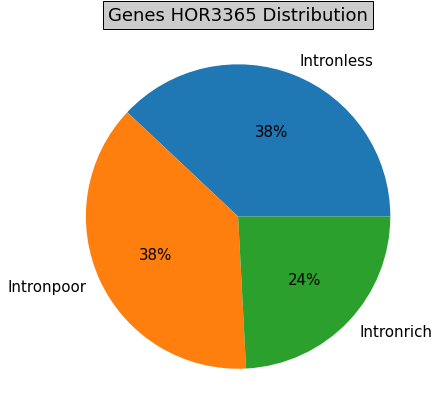

In [565]:
plotting_intron_types(n_intronless_HOR3365, n_intronpoor_HOR3365, n_intronrich_HOR3365, 'Genes HOR3365 Distribution')

In [566]:
### --- Creating the list of HOR3365 gene IDs to check the number of transcripts using command line
intronless_file_HOR3365 = open('Output/HOR3365_intronlessIDs.txt', 'a')
intronpoor_file_HOR3365 = open('Output/HOR3365_intronpoorIDs.txt', 'a')
intronrich_file_HOR3365 = open('Output/HOR3365_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR3365)):
    if i == len(intronless_HOR3365) -1:
        intronless_file_HOR3365.write(intronless_HOR3365[i])
    else:
        intronless_file_HOR3365.write(intronless_HOR3365[i] + '\n')
intronless_file_HOR3365.close()

for i in range(len(intronpoor_HOR3365)):
    if i == len(intronpoor_HOR3365) -1:
        intronpoor_file_HOR3365.write(intronpoor_HOR3365[i])
    else:
        intronpoor_file_HOR3365.write(intronpoor_HOR3365[i] + '\n')
intronpoor_file_HOR3365.close()

for i in range(len(intronrich_HOR3365)):
    if i == len(intronrich_HOR3365) -1:
        intronrich_file_HOR3365.write(intronrich_HOR3365[i])
    else:
        intronrich_file_HOR3365.write(intronrich_HOR3365[i]+'\n')
intronrich_file_HOR3365.close()

In [567]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR3365 = ! grep -f Output/HOR3365_intronlessIDs.txt Data/HOR3365_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR3365 = ! grep -f Output/HOR3365_intronpoorIDs.txt Data/HOR3365_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR3365 = ! grep -f Output/HOR3365_intronrichIDs.txt Data/HOR3365_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [568]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR3365 = int(n_mRNA_intronless_HOR3365[0])/n_intronless_HOR3365
print(avg_mRNA_intronless_HOR3365)
avg_mRNA_intronpoor_HOR3365 = int(n_mRNA_intronpoor_HOR3365[0])/n_intronpoor_HOR3365
print(avg_mRNA_intronpoor_HOR3365)
avg_mRNA_intronrich_HOR3365 = int(n_mRNA_intronrich_HOR3365[0])/n_intronrich_HOR3365
print(avg_mRNA_intronrich_HOR3365)

1.0
1.0
1.0


No alternative splicing.

In [569]:
### --- Basic statistics of HOR3365 introns
introns_HOR3365['length'].describe()

count    131436.000000
mean        643.990855
std        2736.631911
min           1.000000
25%          91.000000
50%         124.000000
75%         428.000000
max      260596.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

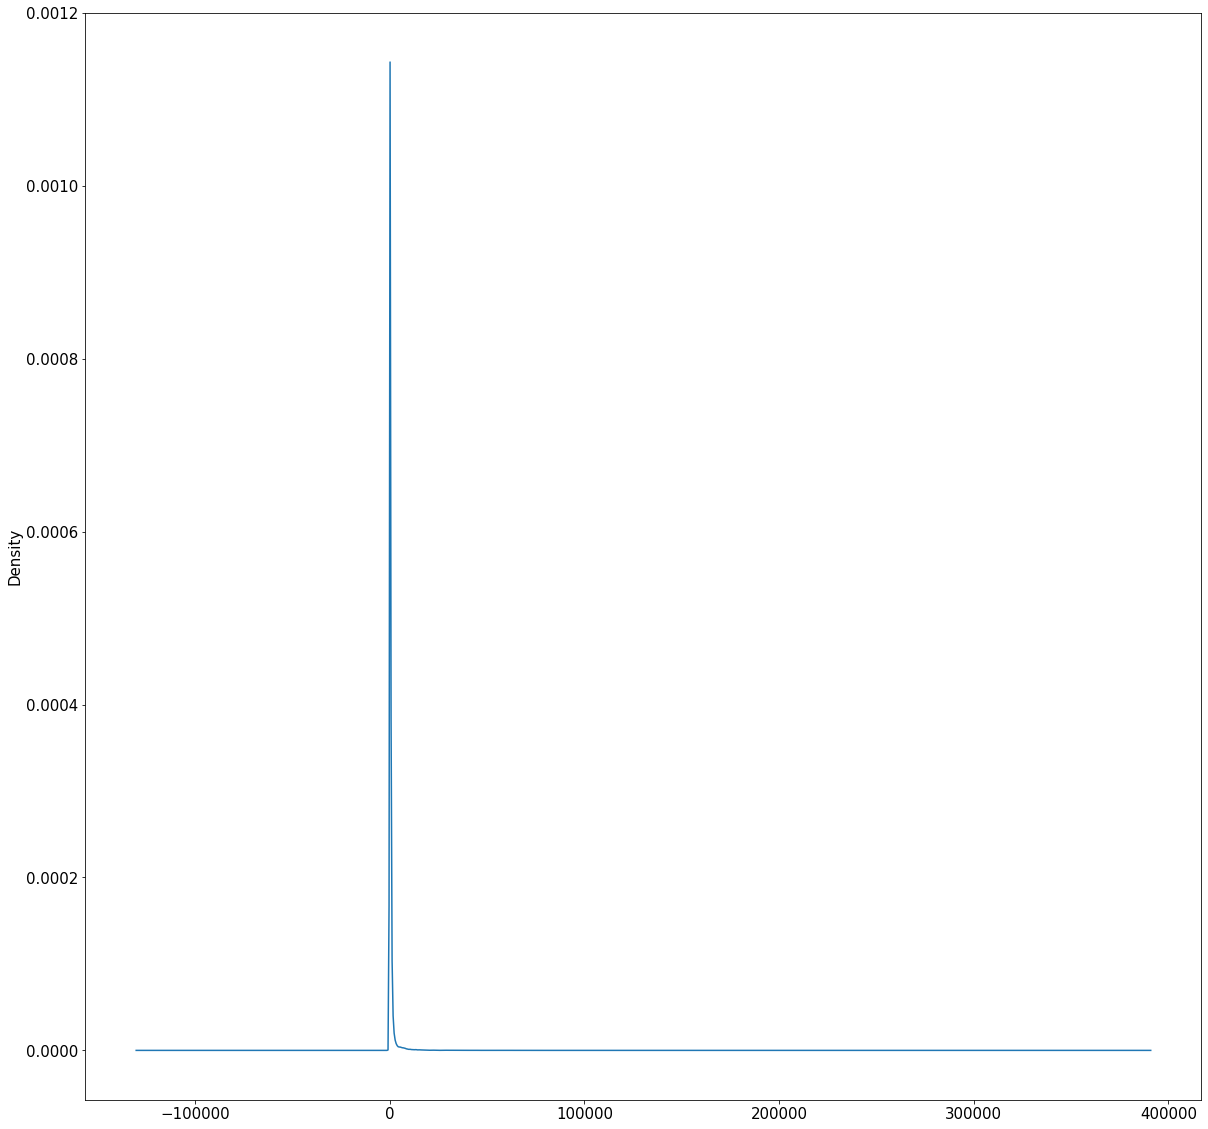

In [570]:
### --- Plotting the distribution of HOR3365 introns length
introns_HOR3365['length'].plot.density()

<AxesSubplot:>

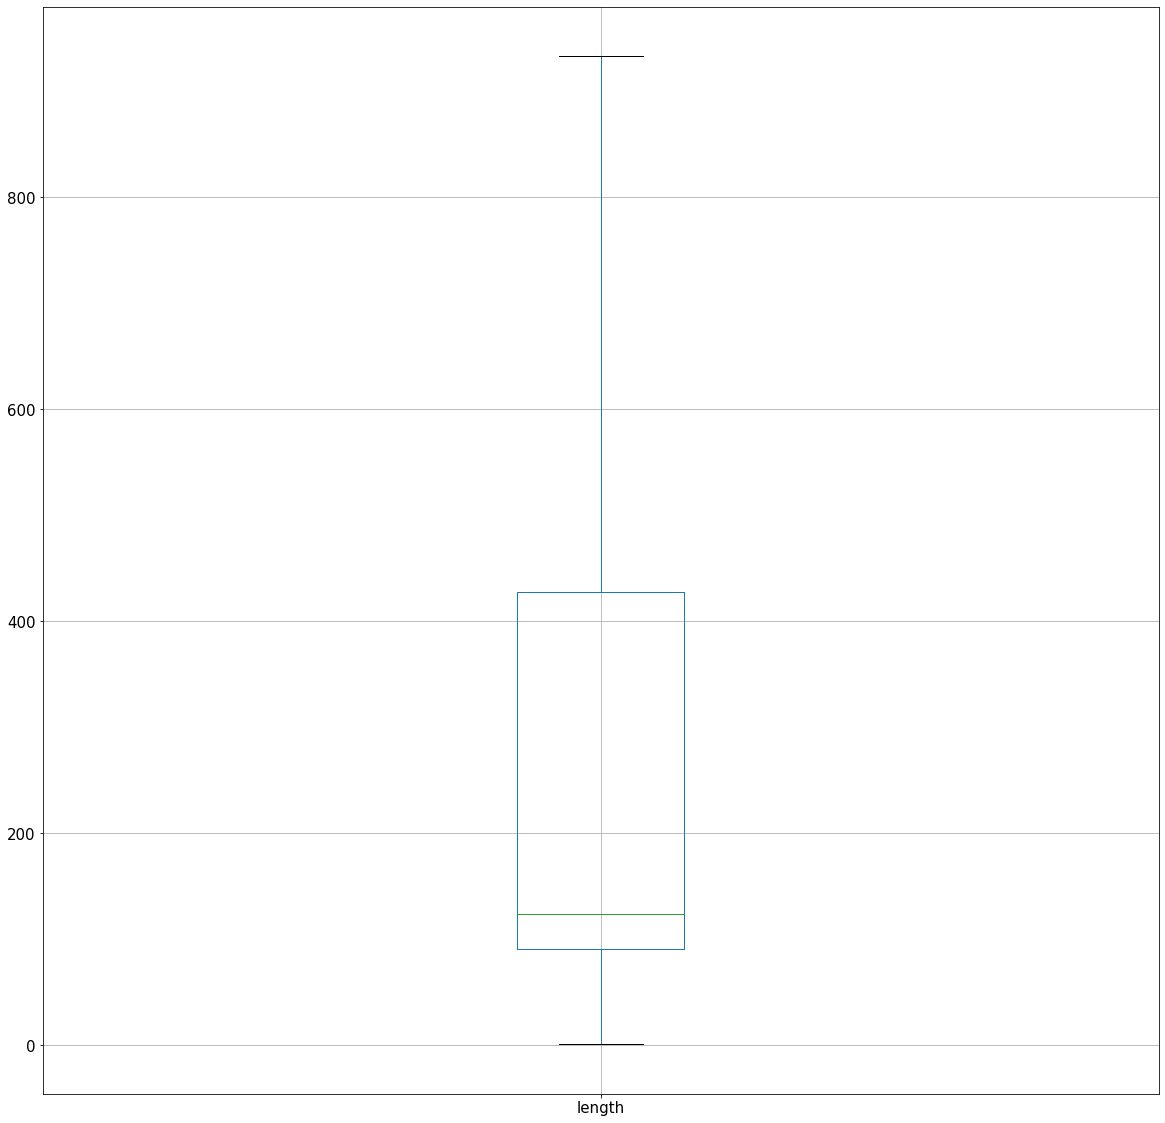

In [571]:
### --- Plotting the boxplot of HOR3365 introns length without outliers
introns_HOR3365.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.15.4 Re-organizing files and directories

In [572]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365_exon.tsv        Morex
B1K	     Hockett	     HOR13942  HOR3365_nohashtag.csv   raw
Barke	     HOR10350	     HOR21599  HOR3365_nohashtag.gff3
Barke_gp     HOR10350_gp     HOR3081   Hv_Morex_longread


In [573]:
! mkdir Data/HOR3365

In [574]:
! mv Data/HOR3365_* Data/HOR3365

In [575]:
! ls Data/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365	       raw
B1K	     Golden_Promise  HOR10350_gp  HOR21599  Hv_Morex_longread
Barke	     Hockett	     HOR13821	  HOR3081   Morex


In [576]:
! ls Output/

Akashinriki	Hockett      HOR21599			HOR3365_introns.tsv
B1K		HOR10350     HOR3081			Hv_Morex_longread
Barke		HOR10350_gp  HOR3365_intronlessIDs.txt	Morex
Barke_gp	HOR13821     HOR3365_intronpoorIDs.txt
Golden_Promise	HOR13942     HOR3365_intronrichIDs.txt


In [577]:
! mkdir Output/HOR3365

In [578]:
! mv Output/HOR3365_* Output/HOR3365/

In [579]:
! ls Output/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365
B1K	     Golden_Promise  HOR10350_gp  HOR21599  Hv_Morex_longread
Barke	     Hockett	     HOR13821	  HOR3081   Morex


## 3.16 HOR7552 - Gene projection

### 3.16.1 Data Collection

In [580]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR7552.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/c1e60cfc-4331-4c9f-a4bb-22e236900701/1/DOWNLOAD

--2021-10-01 12:25:43--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/c1e60cfc-4331-4c9f-a4bb-22e236900701/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51814890 (49M) [text/plain]
Saving to: ‘Data/raw/HOR7552.gff3’

Data/raw/HOR7552.gf 100%[===================>]  49,41M   954KB/s    in 54s     

2021-10-01 12:26:38 (936 KB/s) - ‘Data/raw/HOR7552.gff3’ saved [51814890/51814890]



### 3.16.2 Processing Data

In [581]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [582]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR7552.gff3  > Data/HOR7552_nohashtag.gff3

In [583]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR7552_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR7552_nohashtag.csv

In [584]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR7552 = pd.read_csv('Data/HOR7552_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR7552.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,20978,21281,448.669,+,.,ID=Horvu_7552_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,20978,21281,.,+,.,ID=Horvu_7552_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,20978,21001,.,+,.,ID=Horvu_7552_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,21073,21281,.,+,.,ID=Horvu_7552_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,20980,21001,.,+,0,Parent=Horvu_7552_1H01G000100.1


In [585]:
### --- Building a separate dataframe containing all exons
exon_HOR7552 = df_HOR7552.loc[df_HOR7552['type'].isin(['exon'])]
exon_HOR7552.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,20978,21001,.,+,.,ID=Horvu_7552_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,21073,21281,.,+,.,ID=Horvu_7552_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,32750,32927,.,+,.,ID=Horvu_7552_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,exon,33340,33572,.,+,.,ID=Horvu_7552_1H01G000200.1_exon_2
14,chr1H,PGSBv2.28112019,exon,42924,43556,.,+,.,ID=Horvu_7552_1H01G000300.1_exon_1


In [586]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR7552.to_csv('Data/HOR7552_exon.tsv',sep='\t',index=False,header=False)

In [587]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR7552 = df_HOR7552.loc[df_HOR7552['strand'].isin(['+'])]
forw_HOR7552.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,20978,21281,448.669,+,.,ID=Horvu_7552_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,20978,21281,.,+,.,ID=Horvu_7552_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,20978,21001,.,+,.,ID=Horvu_7552_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,21073,21281,.,+,.,ID=Horvu_7552_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,20980,21001,.,+,0,Parent=Horvu_7552_1H01G000100.1


In [588]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR7552 = df_HOR7552.loc[df_HOR7552['strand'].isin(['-'])]
rev_HOR7552.head()

,chr,source,type,start,end,score,strand,phase,attributes
16,chr1H,PGSBv2.28112019,gene,44687,47893,2681.702,-,.,ID=Horvu_7552_1H01G000400
17,chr1H,PGSBv2.28112019,mRNA,44687,47893,.,-,.,ID=Horvu_7552_1H01G000400.1
18,chr1H,PGSBv2.28112019,exon,44687,45139,.,-,.,ID=Horvu_7552_1H01G000400.1_exon_10
19,chr1H,PGSBv2.28112019,exon,45245,45286,.,-,.,ID=Horvu_7552_1H01G000400.1_exon_9
20,chr1H,PGSBv2.28112019,exon,45793,45860,.,-,.,ID=Horvu_7552_1H01G000400.1_exon_8


In [589]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR7552 = forw_HOR7552.loc[df_HOR7552['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR7552.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [590]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR7552 = rev_HOR7552.loc[df_HOR7552['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR7552.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.16.3 Extracting introns from the whole genome

In [591]:
### --- Extracting introns from HOR7552
extract_tot_introns_gp('Data/HOR7552_exon.tsv', 'Output/HOR7552_introns.tsv')

In [592]:
introns_HOR7552 = pd.read_csv('Output/HOR7552_introns.tsv', sep = '\t')
introns_HOR7552[:100]

,ID,type,start,end,length
0,ID=Horvu_7552_1H01G000100.1,intron,21002,21072,72
1,ID=Horvu_7552_1H01G000200.1,intron,32928,33339,413
2,ID=Horvu_7552_1H01G000400.1,intron,45140,45244,106
3,ID=Horvu_7552_1H01G000400.1,intron,45287,45792,507
4,ID=Horvu_7552_1H01G000400.1,intron,45861,45940,81
...,...,...,...,...,...
95,ID=Horvu_7552_1H01G003500.1,intron,2106797,2106864,69
96,ID=Horvu_7552_1H01G003600.1,intron,2117277,2117383,108
97,ID=Horvu_7552_1H01G003600.1,intron,2117488,2117644,158
98,ID=Horvu_7552_1H01G003600.1,intron,2117848,2119491,1645


In [593]:
### --- Counting introns type in HOR7552
introns_dictionary_HOR7552 = counting_introns_type_gp(exon_HOR7552)

In [594]:
n_intronless_HOR7552, n_intronpoor_HOR7552, n_intronrich_HOR7552, intronless_HOR7552, intronpoor_HOR7552, intronrich_HOR7552 = splitting_introns_type(introns_dictionary_HOR7552)

Intronless are: 16661
Intronpoor are: 18588
Intronrich are: 12088


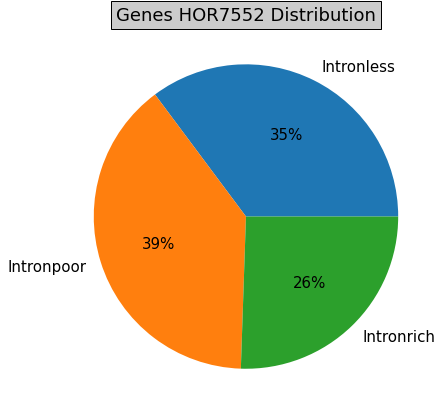

In [595]:
plotting_intron_types(n_intronless_HOR7552, n_intronpoor_HOR7552, n_intronrich_HOR7552, 'Genes HOR7552 Distribution')

In [596]:
### --- Creating the list of HOR7552 gene IDs to check the number of transcripts using command line
intronless_file_HOR7552 = open('Output/HOR7552_intronlessIDs.txt', 'a')
intronpoor_file_HOR7552 = open('Output/HOR7552_intronpoorIDs.txt', 'a')
intronrich_file_HOR7552 = open('Output/HOR7552_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR7552)):
    if i == len(intronless_HOR7552) -1:
        intronless_file_HOR7552.write(intronless_HOR7552[i])
    else:
        intronless_file_HOR7552.write(intronless_HOR7552[i] + '\n')
intronless_file_HOR7552.close()

for i in range(len(intronpoor_HOR7552)):
    if i == len(intronpoor_HOR7552) -1:
        intronpoor_file_HOR7552.write(intronpoor_HOR7552[i])
    else:
        intronpoor_file_HOR7552.write(intronpoor_HOR7552[i] + '\n')
intronpoor_file_HOR7552.close()

for i in range(len(intronrich_HOR7552)):
    if i == len(intronrich_HOR7552) -1:
        intronrich_file_HOR7552.write(intronrich_HOR7552[i])
    else:
        intronrich_file_HOR7552.write(intronrich_HOR7552[i]+'\n')
intronrich_file_HOR7552.close()

In [597]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR7552 = ! grep -f Output/HOR7552_intronlessIDs.txt Data/HOR7552_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR7552 = ! grep -f Output/HOR7552_intronpoorIDs.txt Data/HOR7552_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR7552 = ! grep -f Output/HOR7552_intronrichIDs.txt Data/HOR7552_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [598]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR7552 = int(n_mRNA_intronless_HOR7552[0])/n_intronless_HOR7552
print(avg_mRNA_intronless_HOR7552)
avg_mRNA_intronpoor_HOR7552 = int(n_mRNA_intronpoor_HOR7552[0])/n_intronpoor_HOR7552
print(avg_mRNA_intronpoor_HOR7552)
avg_mRNA_intronrich_HOR7552 = int(n_mRNA_intronrich_HOR7552[0])/n_intronrich_HOR7552
print(avg_mRNA_intronrich_HOR7552)

1.0
1.0
1.0


No alternative splicing. 

In [599]:
### --- Basic statistics of HOR7552 introns
introns_HOR7552['length'].describe()

count    131064.000000
mean        581.182628
std        2359.977712
min           1.000000
25%          91.000000
50%         124.000000
75%         421.250000
max      234013.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

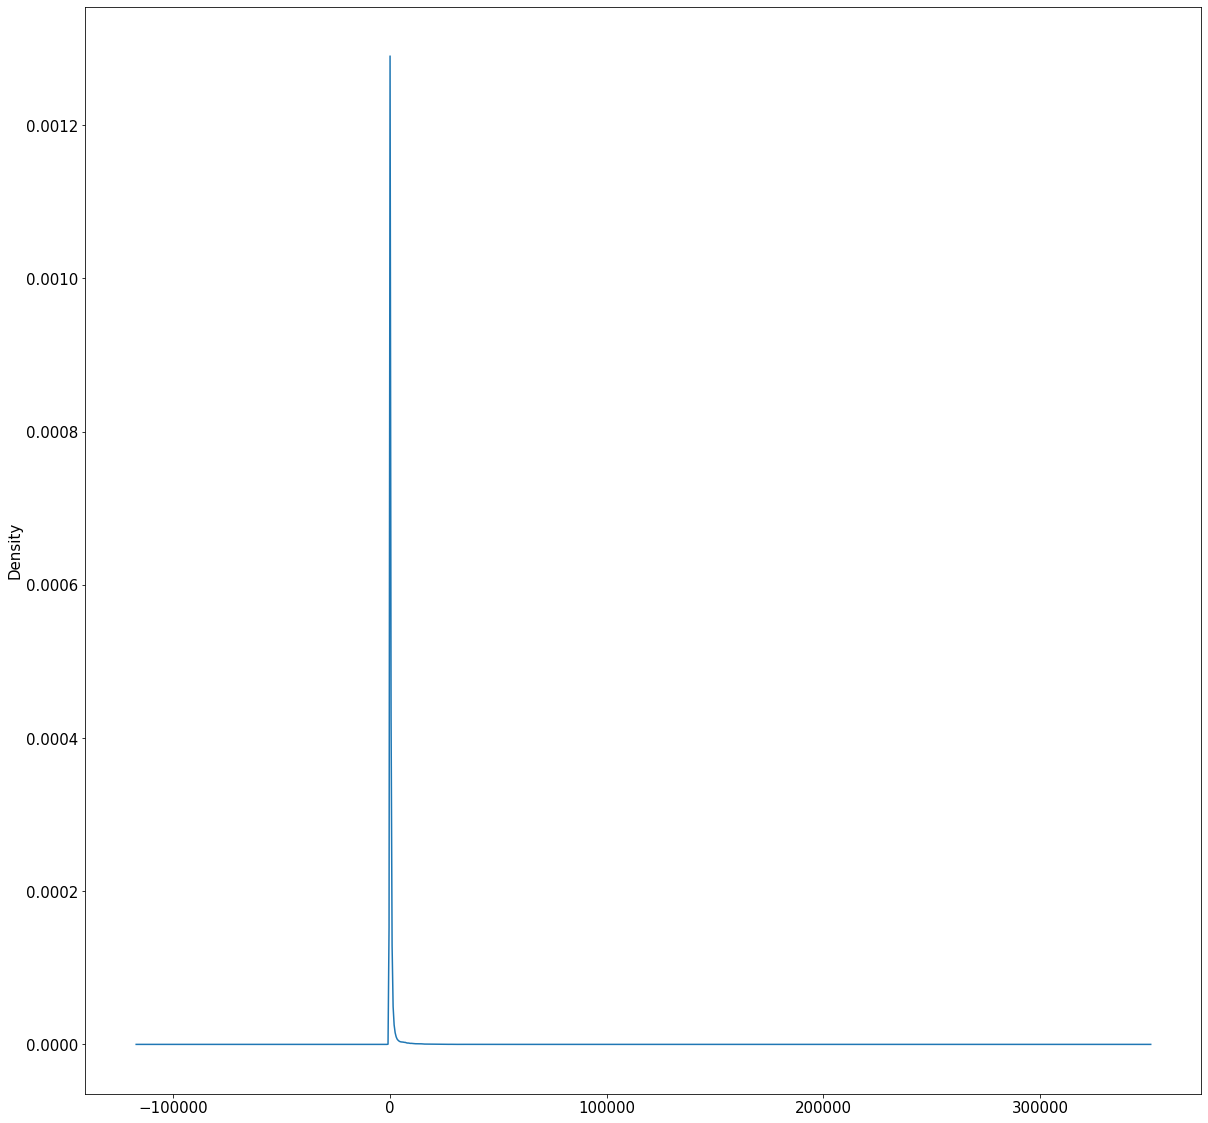

In [600]:
### --- Plotting the distribution of HOR7552 introns length
introns_HOR7552['length'].plot.density()

<AxesSubplot:>

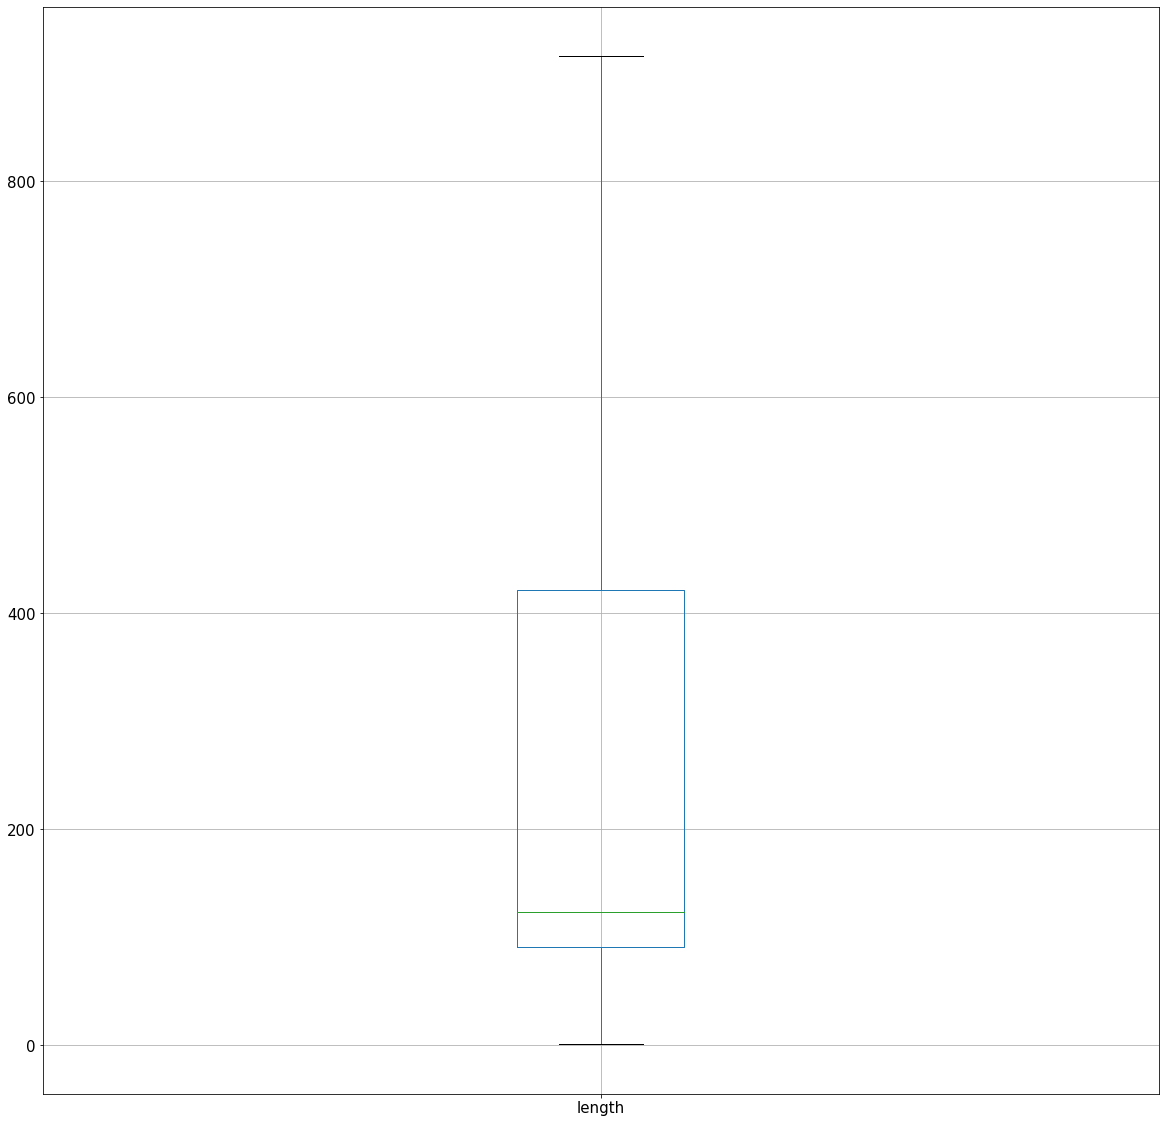

In [601]:
### --- Plotting the boxplot of HOR7552 introns length without outliers
introns_HOR7552.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.16.4 Re-organizing files and directories

In [602]:
! ls Data/

Akashinriki	Hockett      HOR21599		    HOR7552_nohashtag.gff3
B1K		HOR10350     HOR3081		    Hv_Morex_longread
Barke		HOR10350_gp  HOR3365		    Morex
Barke_gp	HOR13821     HOR7552_exon.tsv	    raw
Golden_Promise	HOR13942     HOR7552_nohashtag.csv


In [603]:
! mkdir Data/HOR7552

In [604]:
! mv Data/HOR7552_* Data/HOR7552/

In [605]:
! ls Data/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365	       Morex
B1K	     Golden_Promise  HOR10350_gp  HOR21599  HOR7552	       raw
Barke	     Hockett	     HOR13821	  HOR3081   Hv_Morex_longread


In [606]:
! ls Output/

Akashinriki	HOR10350_gp		   HOR7552_intronpoorIDs.txt
B1K		HOR13821		   HOR7552_intronrichIDs.txt
Barke		HOR13942		   HOR7552_introns.tsv
Barke_gp	HOR21599		   Hv_Morex_longread
Golden_Promise	HOR3081			   Morex
Hockett		HOR3365
HOR10350	HOR7552_intronlessIDs.txt


In [607]:
! mkdir Output/HOR7552

In [608]:
! mv Output/HOR7552_* Output/HOR7552/

In [609]:
! ls Output/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365	       Morex
B1K	     Golden_Promise  HOR10350_gp  HOR21599  HOR7552
Barke	     Hockett	     HOR13821	  HOR3081   Hv_Morex_longread


## 3.17 HOR8148 - Gene projection

### 3.17.1 Data Collection

In [610]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR8148.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/178616bc-965a-4c95-b375-8dc0fee67429/1/DOWNLOAD

--2021-10-01 12:26:54--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/178616bc-965a-4c95-b375-8dc0fee67429/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52024131 (50M) [text/plain]
Saving to: ‘Data/raw/HOR8148.gff3’

Data/raw/HOR8148.gf 100%[===================>]  49,61M   940KB/s    in 40s     

2021-10-01 12:27:35 (1,25 MB/s) - ‘Data/raw/HOR8148.gff3’ saved [52024131/52024131]



### 3.17.2 Processing Data 

In [611]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [612]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR8148.gff3  > Data/HOR8148_nohashtag.gff3

In [613]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR8148_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR8148_nohashtag.csv

In [614]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR8148 = pd.read_csv('Data/HOR8148_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR8148.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,48839,58314,2889.388,-,.,ID=Horvu_8148_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,48839,58314,.,-,.,ID=Horvu_8148_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,48839,49010,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,50574,50701,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,50803,51069,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_8


In [615]:
### --- Building a separate dataframe containing all exons
exon_HOR8148 = df_HOR8148.loc[df_HOR8148['type'].isin(['exon'])]
exon_HOR8148.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,48839,49010,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,50574,50701,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,50803,51069,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_8
5,chr1H,PGSBv2.28112019,exon,51189,51270,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_7
6,chr1H,PGSBv2.28112019,exon,51351,51512,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_6


In [616]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR8148.to_csv('Data/HOR8148_exon.tsv',sep='\t',index=False,header=False)

In [617]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR8148 = df_HOR8148.loc[df_HOR8148['strand'].isin(['+'])]
forw_HOR8148.head()

,chr,source,type,start,end,score,strand,phase,attributes
22,chr1H,PGSBv2.28112019,gene,74067,74543,656.346,+,.,ID=Horvu_8148_1H01G000200
23,chr1H,PGSBv2.28112019,mRNA,74067,74543,.,+,.,ID=Horvu_8148_1H01G000200.1
24,chr1H,PGSBv2.28112019,exon,74067,74136,.,+,.,ID=Horvu_8148_1H01G000200.1_exon_1
25,chr1H,PGSBv2.28112019,exon,74205,74397,.,+,.,ID=Horvu_8148_1H01G000200.1_exon_2
26,chr1H,PGSBv2.28112019,exon,74480,74543,.,+,.,ID=Horvu_8148_1H01G000200.1_exon_3


In [618]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR8148 = df_HOR8148.loc[df_HOR8148['strand'].isin(['-'])]
rev_HOR8148.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,48839,58314,2889.388,-,.,ID=Horvu_8148_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,48839,58314,.,-,.,ID=Horvu_8148_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,48839,49010,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,50574,50701,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,50803,51069,.,-,.,ID=Horvu_8148_1H01G000100.1_exon_8


In [619]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR8148 = forw_HOR8148.loc[df_HOR8148['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR8148.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [620]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR8148 = rev_HOR8148.loc[df_HOR8148['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR8148.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.17.3 Extracting introns from the whole genome

In [621]:
### --- Extracting introns from HOR8148
extract_tot_introns_gp('Data/HOR8148_exon.tsv', 'Output/HOR8148_introns.tsv')

In [622]:
introns_HOR8148 = pd.read_csv('Output/HOR8148_introns.tsv', sep = '\t')
introns_HOR8148[:100]

,ID,type,start,end,length
0,ID=Horvu_8148_1H01G000100.1,intron,49011,50573,1564
1,ID=Horvu_8148_1H01G000100.1,intron,50702,50802,102
2,ID=Horvu_8148_1H01G000100.1,intron,51070,51188,120
3,ID=Horvu_8148_1H01G000100.1,intron,51271,51350,81
4,ID=Horvu_8148_1H01G000100.1,intron,51513,55585,4074
...,...,...,...,...,...
95,ID=Horvu_8148_1H01G002000.1,intron,603342,603417,77
96,ID=Horvu_8148_1H01G002000.1,intron,603519,603603,86
97,ID=Horvu_8148_1H01G002000.1,intron,604183,606816,2635
98,ID=Horvu_8148_1H01G002000.1,intron,606903,607015,114


In [623]:
### --- Counting introns type in HOR8148
introns_dictionary_HOR8148 = counting_introns_type_gp(exon_HOR8148)

In [624]:
n_intronless_HOR8148, n_intronpoor_HOR8148, n_intronrich_HOR8148, intronless_HOR8148, intronpoor_HOR8148, intronrich_HOR8148 = splitting_introns_type(introns_dictionary_HOR8148)

Intronless are: 16802
Intronpoor are: 18552
Intronrich are: 12107


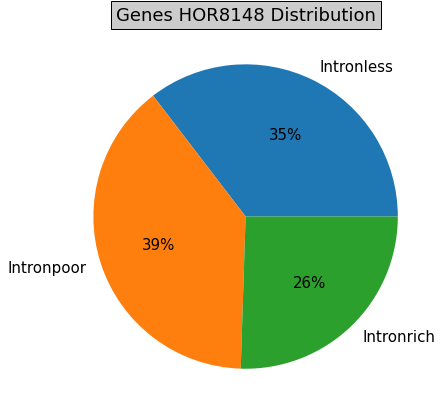

In [625]:
plotting_intron_types(n_intronless_HOR8148, n_intronpoor_HOR8148, n_intronrich_HOR8148, 'Genes HOR8148 Distribution')

In [626]:
### --- Creating the list of HOR8148 gene IDs to check the number of transcripts using command line
intronless_file_HOR8148 = open('Output/HOR8148_intronlessIDs.txt', 'a')
intronpoor_file_HOR8148 = open('Output/HOR8148_intronpoorIDs.txt', 'a')
intronrich_file_HOR8148 = open('Output/HOR8148_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR8148)):
    if i == len(intronless_HOR8148) -1:
        intronless_file_HOR8148.write(intronless_HOR8148[i])
    else:
        intronless_file_HOR8148.write(intronless_HOR8148[i] + '\n')
intronless_file_HOR8148.close()

for i in range(len(intronpoor_HOR8148)):
    if i == len(intronpoor_HOR8148) -1:
        intronpoor_file_HOR8148.write(intronpoor_HOR8148[i])
    else:
        intronpoor_file_HOR8148.write(intronpoor_HOR8148[i] + '\n')
intronpoor_file_HOR8148.close()

for i in range(len(intronrich_HOR8148)):
    if i == len(intronrich_HOR8148) -1:
        intronrich_file_HOR8148.write(intronrich_HOR8148[i])
    else:
        intronrich_file_HOR8148.write(intronrich_HOR8148[i]+'\n')
intronrich_file_HOR8148.close()

In [627]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR8148 = ! grep -f Output/HOR8148_intronlessIDs.txt Data/HOR8148_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR8148 = ! grep -f Output/HOR8148_intronpoorIDs.txt Data/HOR8148_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR8148 = ! grep -f Output/HOR8148_intronrichIDs.txt Data/HOR8148_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [628]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR8148 = int(n_mRNA_intronless_HOR8148[0])/n_intronless_HOR8148
print(avg_mRNA_intronless_HOR8148)
avg_mRNA_intronpoor_HOR8148 = int(n_mRNA_intronpoor_HOR8148[0])/n_intronpoor_HOR8148
print(avg_mRNA_intronpoor_HOR8148)
avg_mRNA_intronrich_HOR8148 = int(n_mRNA_intronrich_HOR8148[0])/n_intronrich_HOR8148
print(avg_mRNA_intronrich_HOR8148)

1.0
1.0
1.0


No alternative splicing.

In [629]:
### --- Basic statistics of HOR8148 introns
introns_HOR8148['length'].describe()

count    131192.000000
mean        578.542891
std        2134.648201
min           1.000000
25%          91.000000
50%         125.000000
75%         427.000000
max      145583.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

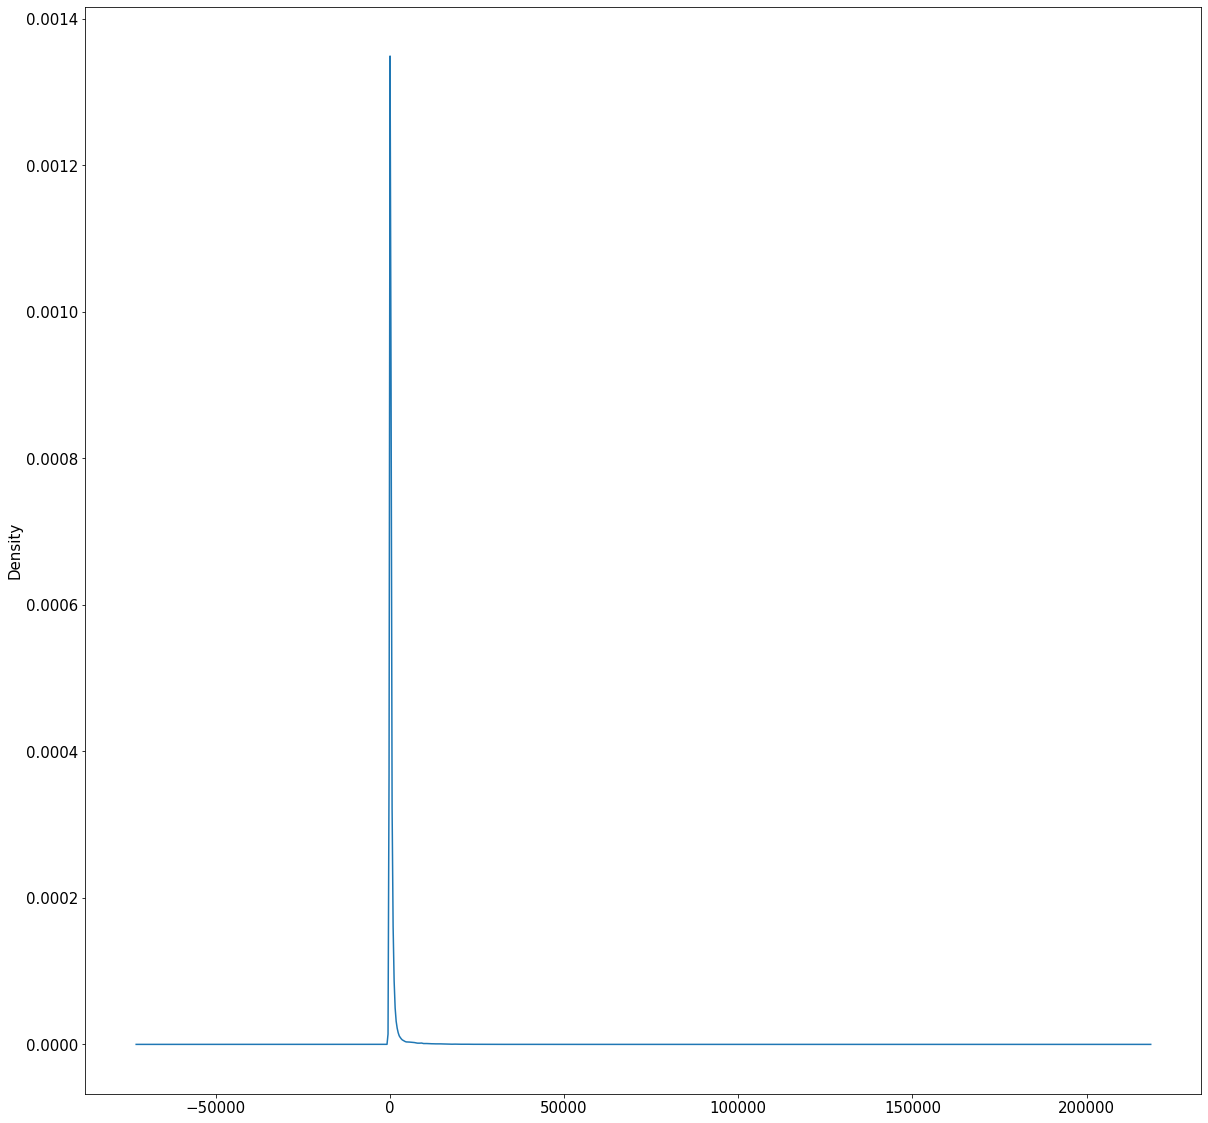

In [630]:
### --- Plotting the distribution of HOR8148 introns length
introns_HOR8148['length'].plot.density()

<AxesSubplot:>

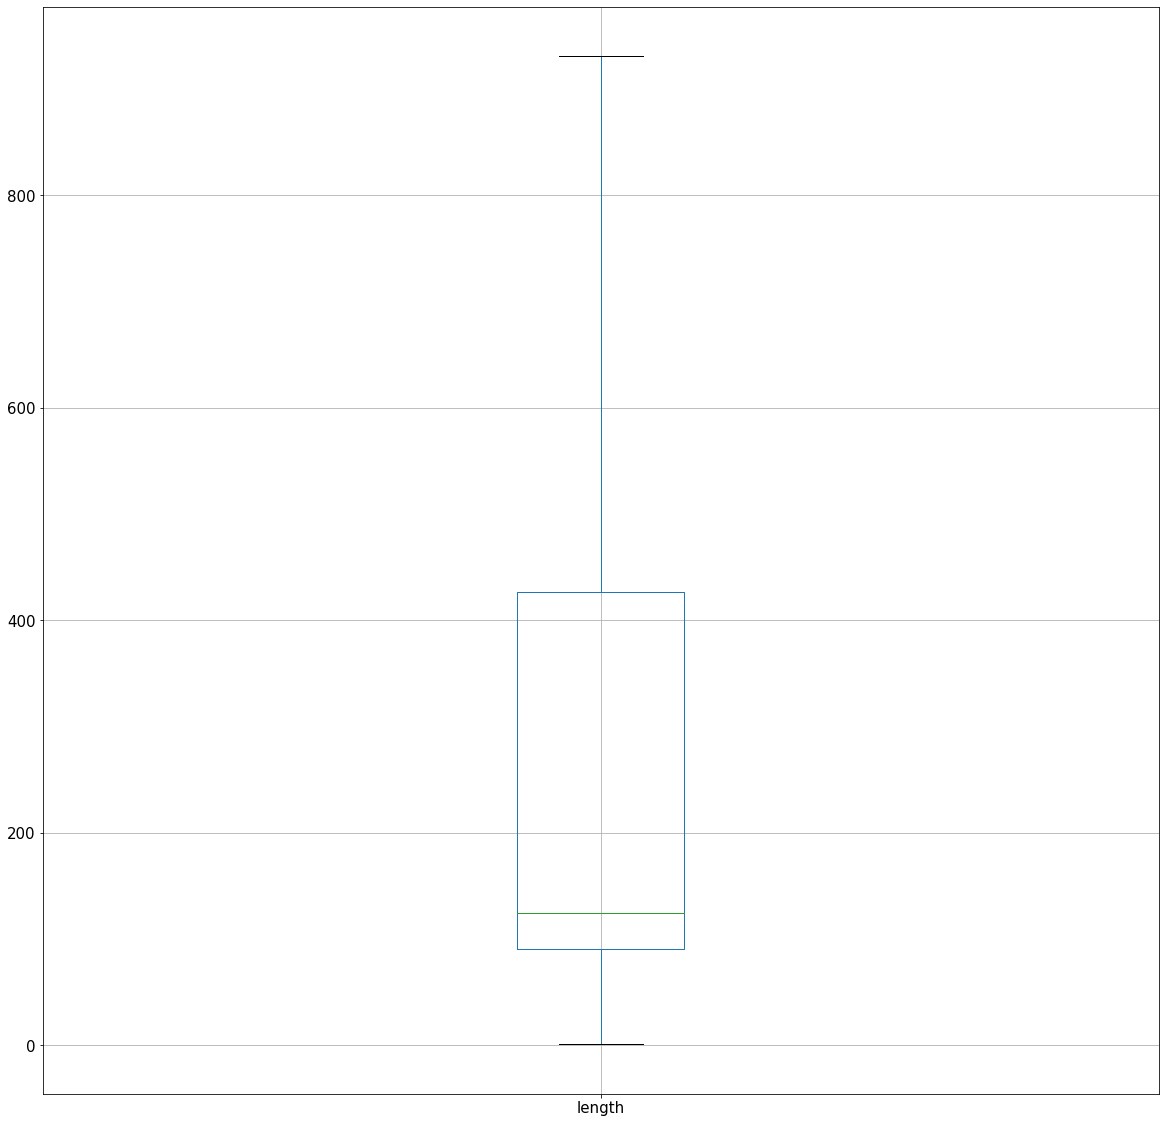

In [631]:
### --- Plotting the boxplot of HOR8148 introns length without outliers
introns_HOR8148.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.17.4 Re-organizing files and directories

In [632]:
! ls Data/

Akashinriki	Hockett      HOR21599	       HOR8148_nohashtag.csv
B1K		HOR10350     HOR3081	       HOR8148_nohashtag.gff3
Barke		HOR10350_gp  HOR3365	       Hv_Morex_longread
Barke_gp	HOR13821     HOR7552	       Morex
Golden_Promise	HOR13942     HOR8148_exon.tsv  raw


In [633]:
! mkdir Data/HOR8148

In [634]:
! mv Data/HOR8148_* Data/HOR8148/

In [635]:
! ls Data

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365  Hv_Morex_longread
B1K	     Golden_Promise  HOR10350_gp  HOR21599  HOR7552  Morex
Barke	     Hockett	     HOR13821	  HOR3081   HOR8148  raw


In [636]:
! ls Output/

Akashinriki	HOR10350_gp  HOR8148_intronlessIDs.txt
B1K		HOR13821     HOR8148_intronpoorIDs.txt
Barke		HOR13942     HOR8148_intronrichIDs.txt
Barke_gp	HOR21599     HOR8148_introns.tsv
Golden_Promise	HOR3081      Hv_Morex_longread
Hockett		HOR3365      Morex
HOR10350	HOR7552


In [637]:
! mkdir Output/HOR8148

In [638]:
! mv Output/HOR8148_* Output/HOR8148/

In [639]:
! ls Output/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365  Hv_Morex_longread
B1K	     Golden_Promise  HOR10350_gp  HOR21599  HOR7552  Morex
Barke	     Hockett	     HOR13821	  HOR3081   HOR8148


## 3.18 HOR9043 - Gene projection

### 3.18.1 Data Collection

In [640]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/HOR9043.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/8f5a2569-f234-4001-97df-66bcd54c4b9d/1/DOWNLOAD

--2021-10-01 12:27:51--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/8f5a2569-f234-4001-97df-66bcd54c4b9d/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51940494 (50M) [text/plain]
Saving to: ‘Data/raw/HOR9043.gff3’

Data/raw/HOR9043.gf 100%[===================>]  49,53M   514KB/s    in 49s     

2021-10-01 12:28:42 (1,01 MB/s) - ‘Data/raw/HOR9043.gff3’ saved [51940494/51940494]



### 3.18.2 Processing Data 

In [641]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [642]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/HOR9043.gff3  > Data/HOR9043_nohashtag.gff3

In [643]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/HOR9043_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/HOR9043_nohashtag.csv

In [644]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_HOR9043 = pd.read_csv('Data/HOR9043_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_HOR9043.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,175908,176560,1070.708,-,.,ID=Horvu_9043_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,175908,176560,.,-,.,ID=Horvu_9043_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,175908,176161,.,-,.,ID=Horvu_9043_1H01G000100.1_exon_2
3,chr1H,PGSBv2.28112019,exon,176236,176560,.,-,.,ID=Horvu_9043_1H01G000100.1_exon_1
4,chr1H,PGSBv2.28112019,CDS,175908,176161,.,-,2,Parent=Horvu_9043_1H01G000100.1


In [645]:
### --- Building a separate dataframe containing all exons
exon_HOR9043 = df_HOR9043.loc[df_HOR9043['type'].isin(['exon'])]
exon_HOR9043.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,175908,176161,.,-,.,ID=Horvu_9043_1H01G000100.1_exon_2
3,chr1H,PGSBv2.28112019,exon,176236,176560,.,-,.,ID=Horvu_9043_1H01G000100.1_exon_1
8,chr1H,PGSBv2.28112019,exon,261228,261318,.,+,.,ID=Horvu_9043_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,exon,261437,261540,.,+,.,ID=Horvu_9043_1H01G000200.1_exon_2
10,chr1H,PGSBv2.28112019,exon,263731,263936,.,+,.,ID=Horvu_9043_1H01G000200.1_exon_3


In [646]:
### --- Exporting the exon dataframe to a tsv file 
exon_HOR9043.to_csv('Data/HOR9043_exon.tsv',sep='\t',index=False,header=False)

In [647]:
### --- Keeping in a separated dataframe the forward strands
forw_HOR9043 = df_HOR9043.loc[df_HOR9043['strand'].isin(['+'])]
forw_HOR9043.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,PGSBv2.28112019,gene,261228,266335,3014.547,+,.,ID=Horvu_9043_1H01G000200
7,chr1H,PGSBv2.28112019,mRNA,261228,266335,.,+,.,ID=Horvu_9043_1H01G000200.1
8,chr1H,PGSBv2.28112019,exon,261228,261318,.,+,.,ID=Horvu_9043_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,exon,261437,261540,.,+,.,ID=Horvu_9043_1H01G000200.1_exon_2
10,chr1H,PGSBv2.28112019,exon,263731,263936,.,+,.,ID=Horvu_9043_1H01G000200.1_exon_3


In [648]:
### --- Keeping in a separated dataframe the reverse strands
rev_HOR9043 = df_HOR9043.loc[df_HOR9043['strand'].isin(['-'])]
rev_HOR9043.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,175908,176560,1070.708,-,.,ID=Horvu_9043_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,175908,176560,.,-,.,ID=Horvu_9043_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,175908,176161,.,-,.,ID=Horvu_9043_1H01G000100.1_exon_2
3,chr1H,PGSBv2.28112019,exon,176236,176560,.,-,.,ID=Horvu_9043_1H01G000100.1_exon_1
4,chr1H,PGSBv2.28112019,CDS,175908,176161,.,-,2,Parent=Horvu_9043_1H01G000100.1


In [649]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_HOR9043 = forw_HOR9043.loc[df_HOR9043['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_HOR9043.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [650]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_HOR9043 = rev_HOR9043.loc[df_HOR9043['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_HOR9043.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.18.3 Extracting introns from the whole genome 

In [651]:
### --- Extracting introns from HOR9043
extract_tot_introns_gp('Data/HOR9043_exon.tsv', 'Output/HOR9043_introns.tsv')

In [652]:
introns_HOR9043 = pd.read_csv('Output/HOR9043_introns.tsv', sep = '\t')
introns_HOR9043[:100]

,ID,type,start,end,length
0,ID=Horvu_9043_1H01G000100.1,intron,176162,176235,75
1,ID=Horvu_9043_1H01G000200.1,intron,261319,261436,119
2,ID=Horvu_9043_1H01G000200.1,intron,261541,263730,2191
3,ID=Horvu_9043_1H01G000200.1,intron,263937,264001,66
4,ID=Horvu_9043_1H01G000200.1,intron,264305,264745,442
...,...,...,...,...,...
95,ID=Horvu_9043_1H01G002500.1,intron,1110882,1111007,127
96,ID=Horvu_9043_1H01G002500.1,intron,1111307,1111667,362
97,ID=Horvu_9043_1H01G002500.1,intron,1111731,1111811,82
98,ID=Horvu_9043_1H01G002600.1,intron,1127193,1128398,1207


In [653]:
### --- Counting introns type in HOR9043
introns_dictionary_HOR9043 = counting_introns_type_gp(exon_HOR9043)

In [654]:
n_intronless_HOR9043, n_intronpoor_HOR9043, n_intronrich_HOR9043, intronless_HOR9043, intronpoor_HOR9043, intronrich_HOR9043 = splitting_introns_type(introns_dictionary_HOR9043)

Intronless are: 16829
Intronpoor are: 18495
Intronrich are: 12071


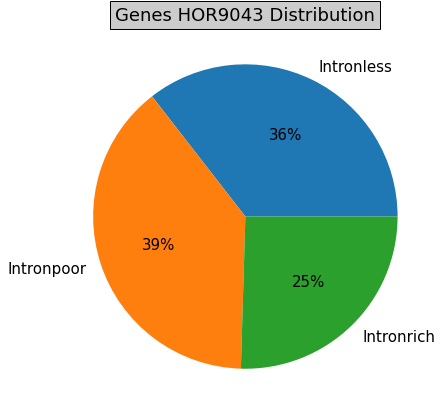

In [655]:
plotting_intron_types(n_intronless_HOR9043, n_intronpoor_HOR9043, n_intronrich_HOR9043, 'Genes HOR9043 Distribution')

In [656]:
### --- Creating the list of HOR9043 gene IDs to check the number of transcripts using command line
intronless_file_HOR9043 = open('Output/HOR9043_intronlessIDs.txt', 'a')
intronpoor_file_HOR9043 = open('Output/HOR9043_intronpoorIDs.txt', 'a')
intronrich_file_HOR9043 = open('Output/HOR9043_intronrichIDs.txt', 'a')
for i in range(len(intronless_HOR9043)):
    if i == len(intronless_HOR9043) -1:
        intronless_file_HOR9043.write(intronless_HOR9043[i])
    else:
        intronless_file_HOR9043.write(intronless_HOR9043[i] + '\n')
intronless_file_HOR9043.close()

for i in range(len(intronpoor_HOR9043)):
    if i == len(intronpoor_HOR9043) -1:
        intronpoor_file_HOR9043.write(intronpoor_HOR9043[i])
    else:
        intronpoor_file_HOR9043.write(intronpoor_HOR9043[i] + '\n')
intronpoor_file_HOR9043.close()

for i in range(len(intronrich_HOR9043)):
    if i == len(intronrich_HOR9043) -1:
        intronrich_file_HOR9043.write(intronrich_HOR9043[i])
    else:
        intronrich_file_HOR9043.write(intronrich_HOR9043[i]+'\n')
intronrich_file_HOR9043.close()

In [657]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_HOR9043 = ! grep -f Output/HOR9043_intronlessIDs.txt Data/HOR9043_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_HOR9043 = ! grep -f Output/HOR9043_intronpoorIDs.txt Data/HOR9043_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_HOR9043 = ! grep -f Output/HOR9043_intronrichIDs.txt Data/HOR9043_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [658]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_HOR9043 = int(n_mRNA_intronless_HOR9043[0])/n_intronless_HOR9043
print(avg_mRNA_intronless_HOR9043)
avg_mRNA_intronpoor_HOR9043 = int(n_mRNA_intronpoor_HOR9043[0])/n_intronpoor_HOR9043
print(avg_mRNA_intronpoor_HOR9043)
avg_mRNA_intronrich_HOR9043 = int(n_mRNA_intronrich_HOR9043[0])/n_intronrich_HOR9043
print(avg_mRNA_intronrich_HOR9043)

1.0
1.0
1.0


In [659]:
### --- Basic statistics of HOR9043 introns
introns_HOR9043['length'].describe()

count    130715.000000
mean        590.565176
std        2382.480177
min           1.000000
25%          91.000000
50%         124.000000
75%         422.000000
max      202996.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

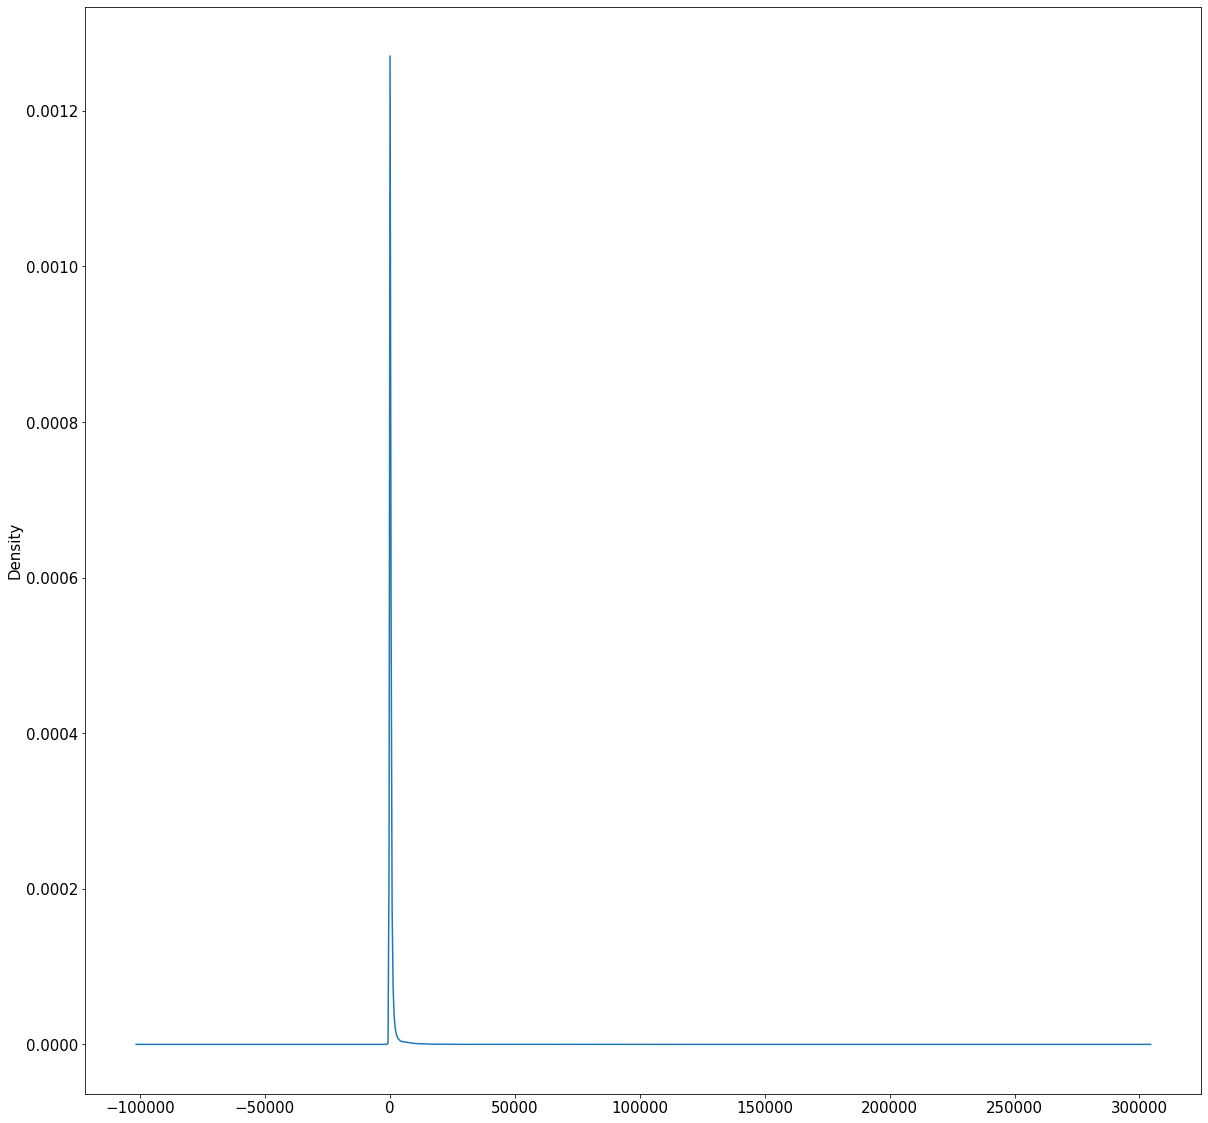

In [660]:
### --- Plotting the distribution of HOR9043 introns length
introns_HOR9043['length'].plot.density()

<AxesSubplot:>

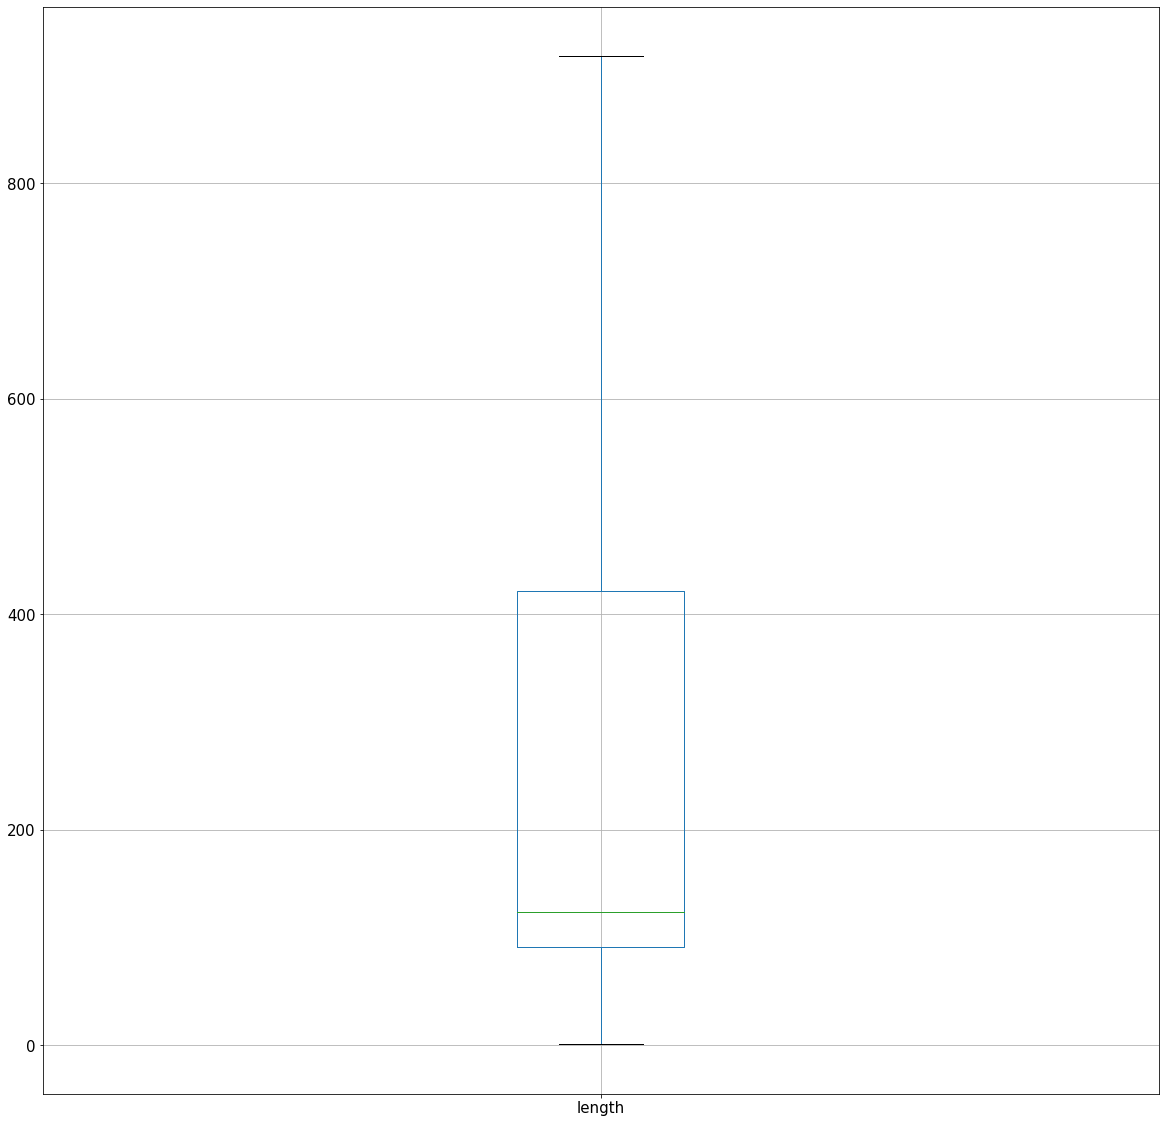

In [661]:
### --- Plotting the boxplot of HOR9043 introns length without outliers
introns_HOR9043.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.18.4 Re-organizing files and directories 

In [662]:
! ls Data/

Akashinriki	Hockett      HOR21599  HOR9043_exon.tsv        raw
B1K		HOR10350     HOR3081   HOR9043_nohashtag.csv
Barke		HOR10350_gp  HOR3365   HOR9043_nohashtag.gff3
Barke_gp	HOR13821     HOR7552   Hv_Morex_longread
Golden_Promise	HOR13942     HOR8148   Morex


In [663]:
! mkdir Data/HOR9043

In [664]:
! mv Data/HOR9043_* Data/HOR9043/

In [665]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread
B1K	     Hockett	     HOR13942  HOR7552	Morex
Barke	     HOR10350	     HOR21599  HOR8148	raw
Barke_gp     HOR10350_gp     HOR3081   HOR9043


In [666]:
! ls Output/

Akashinriki	Hockett      HOR21599  HOR9043_intronlessIDs.txt  Morex
B1K		HOR10350     HOR3081   HOR9043_intronpoorIDs.txt
Barke		HOR10350_gp  HOR3365   HOR9043_intronrichIDs.txt
Barke_gp	HOR13821     HOR7552   HOR9043_introns.tsv
Golden_Promise	HOR13942     HOR8148   Hv_Morex_longread


In [667]:
! mkdir Output/HOR9043

In [668]:
! mv Output/HOR9043_* Output/HOR9043/

In [669]:
! ls Output/

Akashinriki  Barke_gp	     HOR10350	  HOR13942  HOR3365  HOR9043
B1K	     Golden_Promise  HOR10350_gp  HOR21599  HOR7552  Hv_Morex_longread
Barke	     Hockett	     HOR13821	  HOR3081   HOR8148  Morex


## 3.19 Igri - Gene projection

### 3.19.1 Data Collection

In [670]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Igri.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/053b94a0-5d6e-4339-b2d5-3de486760c32/1/DOWNLOAD

--2021-10-01 12:29:01--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/053b94a0-5d6e-4339-b2d5-3de486760c32/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52111038 (50M) [text/plain]
Saving to: ‘Data/raw/Igri.gff3’

Data/raw/Igri.gff3  100%[===================>]  49,70M   923KB/s    in 50s     

2021-10-01 12:29:51 (1020 KB/s) - ‘Data/raw/Igri.gff3’ saved [52111038/52111038]



### 3.19.2 Processing Data 

In [671]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [672]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Igri.gff3  > Data/Igri_nohashtag.gff3

In [673]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Igri_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Igri_nohashtag.csv

In [674]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Igri = pd.read_csv('Data/Igri_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Igri.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,97154,97998,850.148,+,.,ID=Horvu_IGRI_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,97154,97998,.,+,.,ID=Horvu_IGRI_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,97154,97343,.,+,.,ID=Horvu_IGRI_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,97766,97998,.,+,.,ID=Horvu_IGRI_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,97154,97343,.,+,0,Parent=Horvu_IGRI_1H01G000100.1


In [675]:
### --- Building a separate dataframe containing all exons
exon_Igri = df_Igri.loc[df_Igri['type'].isin(['exon'])]
exon_Igri.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,97154,97343,.,+,.,ID=Horvu_IGRI_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,97766,97998,.,+,.,ID=Horvu_IGRI_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,123067,123696,.,+,.,ID=Horvu_IGRI_1H01G000200.1_exon_1
12,chr1H,PGSBv2.28112019,exon,124834,125280,.,-,.,ID=Horvu_IGRI_1H01G000300.1_exon_10
13,chr1H,PGSBv2.28112019,exon,125386,125427,.,-,.,ID=Horvu_IGRI_1H01G000300.1_exon_9


In [676]:
### --- Exporting the exon dataframe to a tsv file 
exon_Igri.to_csv('Data/Igri_exon.tsv',sep='\t',index=False,header=False)

In [677]:
### --- Keeping in a separated dataframe the forward strands
forw_Igri = df_Igri.loc[df_Igri['strand'].isin(['+'])]
forw_Igri.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,97154,97998,850.148,+,.,ID=Horvu_IGRI_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,97154,97998,.,+,.,ID=Horvu_IGRI_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,97154,97343,.,+,.,ID=Horvu_IGRI_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,97766,97998,.,+,.,ID=Horvu_IGRI_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,97154,97343,.,+,0,Parent=Horvu_IGRI_1H01G000100.1


In [678]:
### --- Keeping in a separated dataframe the reverse strands
rev_Igri = df_Igri.loc[df_Igri['strand'].isin(['-'])]
rev_Igri.head()

,chr,source,type,start,end,score,strand,phase,attributes
10,chr1H,PGSBv2.28112019,gene,124834,128028,2779.294,-,.,ID=Horvu_IGRI_1H01G000300
11,chr1H,PGSBv2.28112019,mRNA,124834,128028,.,-,.,ID=Horvu_IGRI_1H01G000300.1
12,chr1H,PGSBv2.28112019,exon,124834,125280,.,-,.,ID=Horvu_IGRI_1H01G000300.1_exon_10
13,chr1H,PGSBv2.28112019,exon,125386,125427,.,-,.,ID=Horvu_IGRI_1H01G000300.1_exon_9
14,chr1H,PGSBv2.28112019,exon,125932,125999,.,-,.,ID=Horvu_IGRI_1H01G000300.1_exon_8


In [679]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Igri = forw_Igri.loc[df_Igri['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Igri.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [680]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Igri = rev_Igri.loc[df_Igri['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Igri.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.19.3 Extracting introns from the whole genome 

In [681]:
### --- Extracting introns from Igri
extract_tot_introns_gp('Data/Igri_exon.tsv', 'Output/Igri_introns.tsv')

In [682]:
introns_Igri = pd.read_csv('Output/Igri_introns.tsv', sep = '\t')
introns_Igri[:100]

,ID,type,start,end,length
0,ID=Horvu_IGRI_1H01G000100.1,intron,97344,97765,423
1,ID=Horvu_IGRI_1H01G000300.1,intron,125281,125385,106
2,ID=Horvu_IGRI_1H01G000300.1,intron,125428,125931,505
3,ID=Horvu_IGRI_1H01G000300.1,intron,126000,126079,81
4,ID=Horvu_IGRI_1H01G000300.1,intron,126123,126223,102
...,...,...,...,...,...
95,ID=Horvu_IGRI_1H01G001500.1,intron,603635,609928,6295
96,ID=Horvu_IGRI_1H01G001500.1,intron,609996,610125,131
97,ID=Horvu_IGRI_1H01G001500.1,intron,610610,611172,564
98,ID=Horvu_IGRI_1H01G001600.1,intron,617507,617530,25


In [683]:
### --- Counting introns type in Igri
introns_dictionary_Igri = counting_introns_type_gp(exon_Igri)

In [684]:
n_intronless_Igri, n_intronpoor_Igri, n_intronrich_Igri, intronless_Igri, intronpoor_Igri, intronrich_Igri = splitting_introns_type(introns_dictionary_Igri)

Intronless are: 16934
Intronpoor are: 18606
Intronrich are: 12068


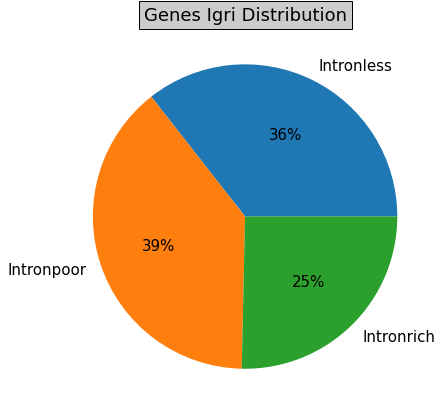

In [685]:
plotting_intron_types(n_intronless_Igri, n_intronpoor_Igri, n_intronrich_Igri, 'Genes Igri Distribution')

In [686]:
### --- Creating the list of Igri gene IDs to check the number of transcripts using command line
intronless_file_Igri = open('Output/Igri_intronlessIDs.txt', 'a')
intronpoor_file_Igri = open('Output/Igri_intronpoorIDs.txt', 'a')
intronrich_file_Igri = open('Output/Igri_intronrichIDs.txt', 'a')
for i in range(len(intronless_Igri)):
    if i == len(intronless_Igri) -1:
        intronless_file_Igri.write(intronless_Igri[i])
    else:
        intronless_file_Igri.write(intronless_Igri[i] + '\n')
intronless_file_Igri.close()

for i in range(len(intronpoor_Igri)):
    if i == len(intronpoor_Igri) -1:
        intronpoor_file_Igri.write(intronpoor_Igri[i])
    else:
        intronpoor_file_Igri.write(intronpoor_Igri[i] + '\n')
intronpoor_file_Igri.close()

for i in range(len(intronrich_Igri)):
    if i == len(intronrich_Igri) -1:
        intronrich_file_Igri.write(intronrich_Igri[i])
    else:
        intronrich_file_Igri.write(intronrich_Igri[i]+'\n')
intronrich_file_Igri.close()

In [687]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Igri = ! grep -f Output/Igri_intronlessIDs.txt Data/Igri_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Igri = ! grep -f Output/Igri_intronpoorIDs.txt Data/Igri_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Igri = ! grep -f Output/Igri_intronrichIDs.txt Data/Igri_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [688]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Igri = int(n_mRNA_intronless_Igri[0])/n_intronless_Igri
print(avg_mRNA_intronless_Igri)
avg_mRNA_intronpoor_Igri = int(n_mRNA_intronpoor_Igri[0])/n_intronpoor_Igri
print(avg_mRNA_intronpoor_Igri)
avg_mRNA_intronrich_Igri = int(n_mRNA_intronrich_Igri[0])/n_intronrich_Igri
print(avg_mRNA_intronrich_Igri)

1.0
1.0
1.0


In [689]:
### --- Basic statistics of Igri introns
introns_Igri['length'].describe()

count    131099.000000
mean        577.219041
std        3078.928798
min           1.000000
25%          91.000000
50%         124.000000
75%         424.000000
max      811688.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

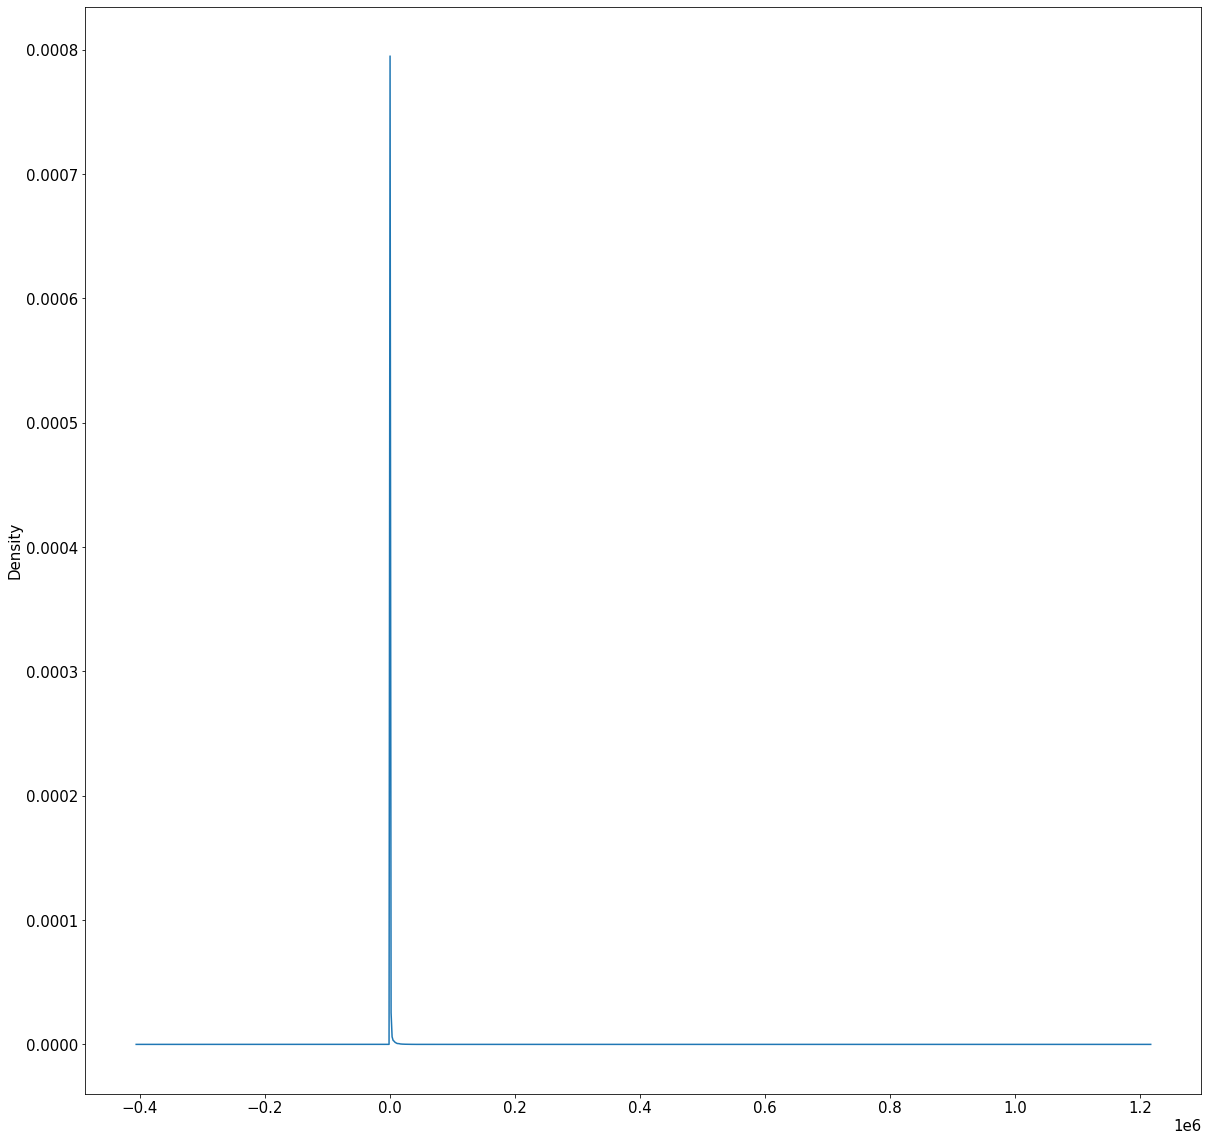

In [690]:
### --- Plotting the distribution of Igri introns length
introns_Igri['length'].plot.density()

<AxesSubplot:>

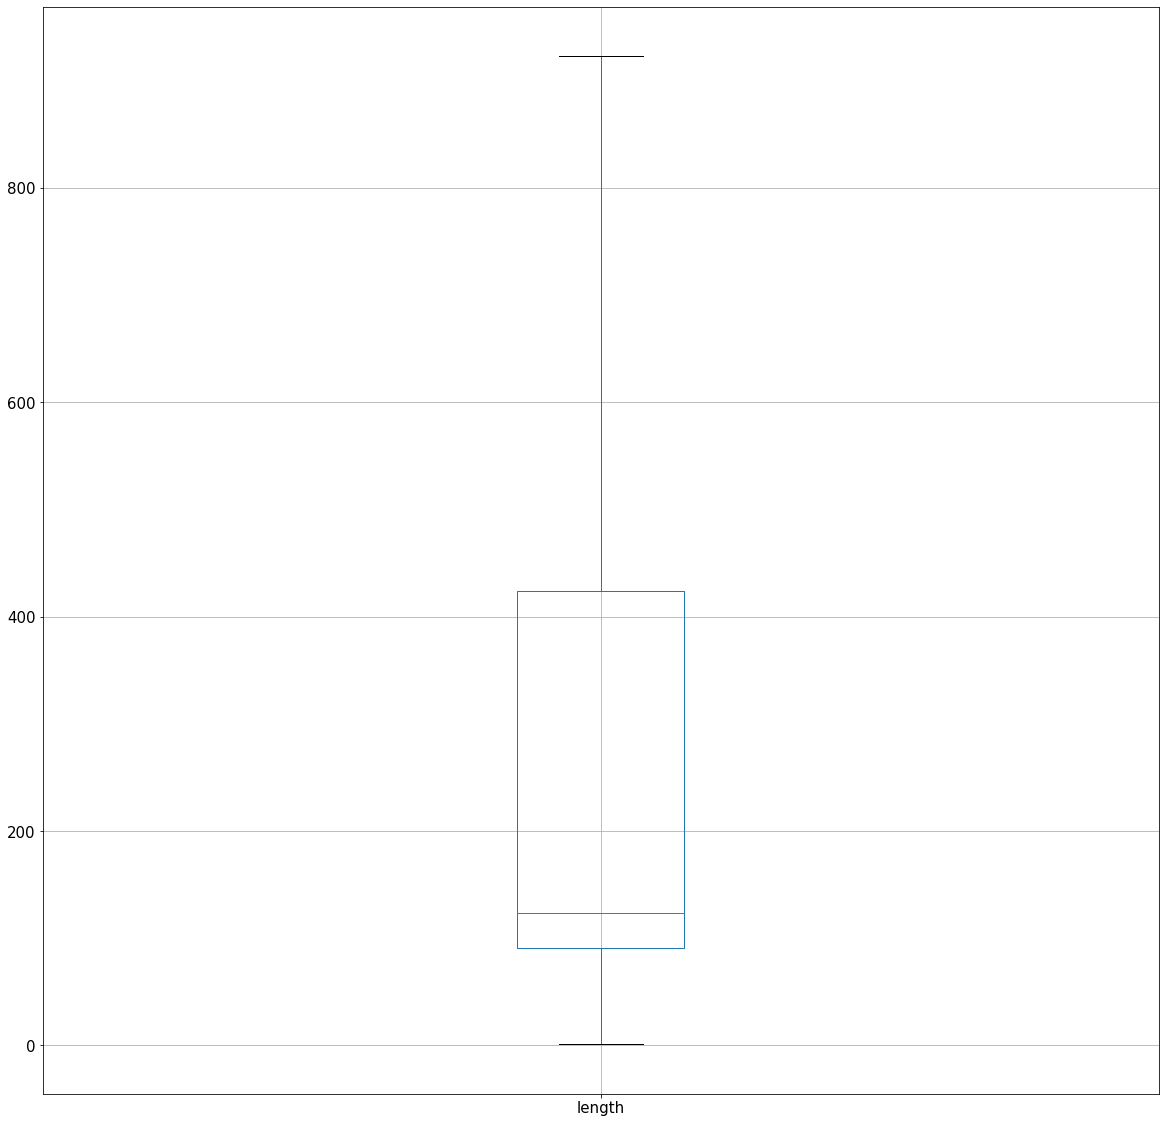

In [691]:
### --- Plotting the boxplot of Igri introns length without outliers
introns_Igri.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.19.4 Re-organizing files and directories 

In [692]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread    Morex
B1K	     Hockett	     HOR13942  HOR7552	Igri_exon.tsv	     raw
Barke	     HOR10350	     HOR21599  HOR8148	Igri_nohashtag.csv
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Igri_nohashtag.gff3


In [693]:
! mkdir Data/Igri 

In [694]:
! mv Data/Igri_* Data/Igri/

In [695]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread
B1K	     Hockett	     HOR13942  HOR7552	Igri
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043	raw


In [696]:
! ls Output/

Akashinriki	Hockett      HOR21599  HOR9043		       Igri_introns.tsv
B1K		HOR10350     HOR3081   Hv_Morex_longread       Morex
Barke		HOR10350_gp  HOR3365   Igri_intronlessIDs.txt
Barke_gp	HOR13821     HOR7552   Igri_intronpoorIDs.txt
Golden_Promise	HOR13942     HOR8148   Igri_intronrichIDs.txt


In [697]:
! mkdir Output/Igri

In [698]:
! mv Output/Igri_* Output/Igri/

In [699]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread
B1K	     Hockett	     HOR13942  HOR7552	Igri
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043


## 3.20 Morex - Gene projection

### 3.20.1 Data Collection

In [700]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/Morex_gp.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/d8559e36-1879-406f-88de-f55786ce39eb/1/DOWNLOAD

--2021-10-01 12:30:08--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/d8559e36-1879-406f-88de-f55786ce39eb/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54173122 (52M) [text/plain]
Saving to: ‘Data/raw/Morex_gp.gff3’

Data/raw/Morex_gp.g 100%[===================>]  51,66M   308KB/s    in 79s     

2021-10-01 12:31:27 (673 KB/s) - ‘Data/raw/Morex_gp.gff3’ saved [54173122/54173122]



### 3.20.2 Processing Data

In [701]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [702]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/Morex_gp.gff3  > Data/Morex_gp_nohashtag.gff3

In [703]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/Morex_gp_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/Morex_gp_nohashtag.csv

In [704]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_Morex_gp = pd.read_csv('Data/Morex_gp_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_Morex_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,142445,147518,10000.000,+,.,ID=Horvu_MOREX_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,142445,147518,.,+,.,ID=Horvu_MOREX_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,142445,142903,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,143335,144686,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,144801,144911,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_3


In [705]:
### --- Building a separate dataframe containing all exons
exon_Morex_gp = df_Morex_gp.loc[df_Morex_gp['type'].isin(['exon'])]
exon_Morex_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,142445,142903,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,143335,144686,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,144801,144911,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_3
5,chr1H,PGSBv2.28112019,exon,145022,145298,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_4
6,chr1H,PGSBv2.28112019,exon,145393,145481,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_5


In [706]:
### --- Exporting the exon dataframe to a tsv file 
exon_Morex_gp.to_csv('Data/Morex_gp_exon.tsv',sep='\t',index=False,header=False)

In [707]:
### --- Keeping in a separated dataframe the forward strands
forw_Morex_gp = df_Morex_gp.loc[df_Morex_gp['strand'].isin(['+'])]
forw_Morex_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,142445,147518,10000.000,+,.,ID=Horvu_MOREX_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,142445,147518,.,+,.,ID=Horvu_MOREX_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,142445,142903,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,143335,144686,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,144801,144911,.,+,.,ID=Horvu_MOREX_1H01G000100.1_exon_3


In [708]:
### --- Keeping in a separated dataframe the reverse strands
rev_Morex_gp = df_Morex_gp.loc[df_Morex_gp['strand'].isin(['-'])]
rev_Morex_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes
48,chr1H,PGSBv2.28112019,gene,165513,168763,10000.000,-,.,ID=Horvu_MOREX_1H01G000400
49,chr1H,PGSBv2.28112019,mRNA,165513,168763,.,-,.,ID=Horvu_MOREX_1H01G000400.1
50,chr1H,PGSBv2.28112019,exon,165513,165734,.,-,.,ID=Horvu_MOREX_1H01G000400.1_exon_8
51,chr1H,PGSBv2.28112019,exon,166213,166374,.,-,.,ID=Horvu_MOREX_1H01G000400.1_exon_7
52,chr1H,PGSBv2.28112019,exon,166720,166867,.,-,.,ID=Horvu_MOREX_1H01G000400.1_exon_6


In [709]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_Morex_gp = forw_Morex_gp.loc[df_Morex_gp['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_Morex_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [710]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_Morex_gp = rev_Morex_gp.loc[df_Morex_gp['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_Morex_gp.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.20.3 Extracting introns from the whole genome

In [711]:
### --- Extracting introns from Morex_gp
extract_tot_introns_gp('Data/Morex_gp_exon.tsv', 'Output/Morex_gp_introns.tsv')

In [712]:
introns_Morex_gp = pd.read_csv('Output/Morex_gp_introns.tsv', sep = '\t')
introns_Morex_gp[:100]

,ID,type,start,end,length
0,ID=Horvu_MOREX_1H01G000100.1,intron,142904,143334,432
1,ID=Horvu_MOREX_1H01G000100.1,intron,144687,144800,115
2,ID=Horvu_MOREX_1H01G000100.1,intron,144912,145021,111
3,ID=Horvu_MOREX_1H01G000100.1,intron,145299,145392,95
4,ID=Horvu_MOREX_1H01G000100.1,intron,145482,145567,87
...,...,...,...,...,...
95,ID=Horvu_MOREX_1H01G002100.1,intron,734325,734933,610
96,ID=Horvu_MOREX_1H01G002200.1,intron,736456,736557,103
97,ID=Horvu_MOREX_1H01G002300.1,intron,743659,743739,82
98,ID=Horvu_MOREX_1H01G002300.1,intron,746154,748998,2846


In [713]:
### --- Counting introns type in Morex_gp
introns_dictionary_Morex_gp = counting_introns_type_gp(exon_Morex_gp)

In [714]:
n_intronless_Morex_gp, n_intronpoor_Morex_gp, n_intronrich_Morex_gp, intronless_Morex_gp, intronpoor_Morex_gp, intronrich_Morex_gp = splitting_introns_type(introns_dictionary_Morex_gp)

Intronless are: 17872
Intronpoor are: 19060
Intronrich are: 12349


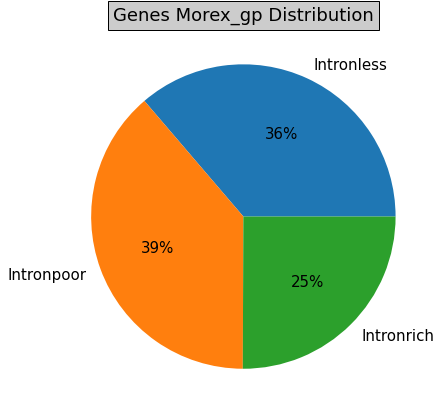

In [715]:
plotting_intron_types(n_intronless_Morex_gp, n_intronpoor_Morex_gp, n_intronrich_Morex_gp, 'Genes Morex_gp Distribution')

In [716]:
### --- Creating the list of Morex_gp gene IDs to check the number of transcripts using command line
intronless_file_Morex_gp = open('Output/Morex_gp_intronlessIDs.txt', 'a')
intronpoor_file_Morex_gp = open('Output/Morex_gp_intronpoorIDs.txt', 'a')
intronrich_file_Morex_gp = open('Output/Morex_gp_intronrichIDs.txt', 'a')
for i in range(len(intronless_Morex_gp)):
    if i == len(intronless_Morex_gp) -1:
        intronless_file_Morex_gp.write(intronless_Morex_gp[i])
    else:
        intronless_file_Morex_gp.write(intronless_Morex_gp[i] + '\n')
intronless_file_Morex_gp.close()

for i in range(len(intronpoor_Morex_gp)):
    if i == len(intronpoor_Morex_gp) -1:
        intronpoor_file_Morex_gp.write(intronpoor_Morex_gp[i])
    else:
        intronpoor_file_Morex_gp.write(intronpoor_Morex_gp[i] + '\n')
intronpoor_file_Morex_gp.close()

for i in range(len(intronrich_Morex_gp)):
    if i == len(intronrich_Morex_gp) -1:
        intronrich_file_Morex_gp.write(intronrich_Morex_gp[i])
    else:
        intronrich_file_Morex_gp.write(intronrich_Morex_gp[i]+'\n')
intronrich_file_Morex_gp.close()

In [717]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_Morex_gp = ! grep -f Output/Morex_gp_intronlessIDs.txt Data/Morex_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_Morex_gp = ! grep -f Output/Morex_gp_intronpoorIDs.txt Data/Morex_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_Morex_gp = ! grep -f Output/Morex_gp_intronrichIDs.txt Data/Morex_gp_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [718]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_Morex_gp = int(n_mRNA_intronless_Morex_gp[0])/n_intronless_Morex_gp
print(avg_mRNA_intronless_Morex_gp)
avg_mRNA_intronpoor_Morex_gp = int(n_mRNA_intronpoor_Morex_gp[0])/n_intronpoor_Morex_gp
print(avg_mRNA_intronpoor_Morex_gp)
avg_mRNA_intronrich_Morex_gp = int(n_mRNA_intronrich_Morex_gp[0])/n_intronrich_Morex_gp
print(avg_mRNA_intronrich_Morex_gp)

1.0
1.0
1.0


No alternative splicing.

In [719]:
### --- Basic statistics of Morex_gp introns
introns_Morex_gp['length'].describe()

count    133874.000000
mean        575.985546
std        2051.938431
min           1.000000
25%          91.000000
50%         125.000000
75%         426.000000
max      142305.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

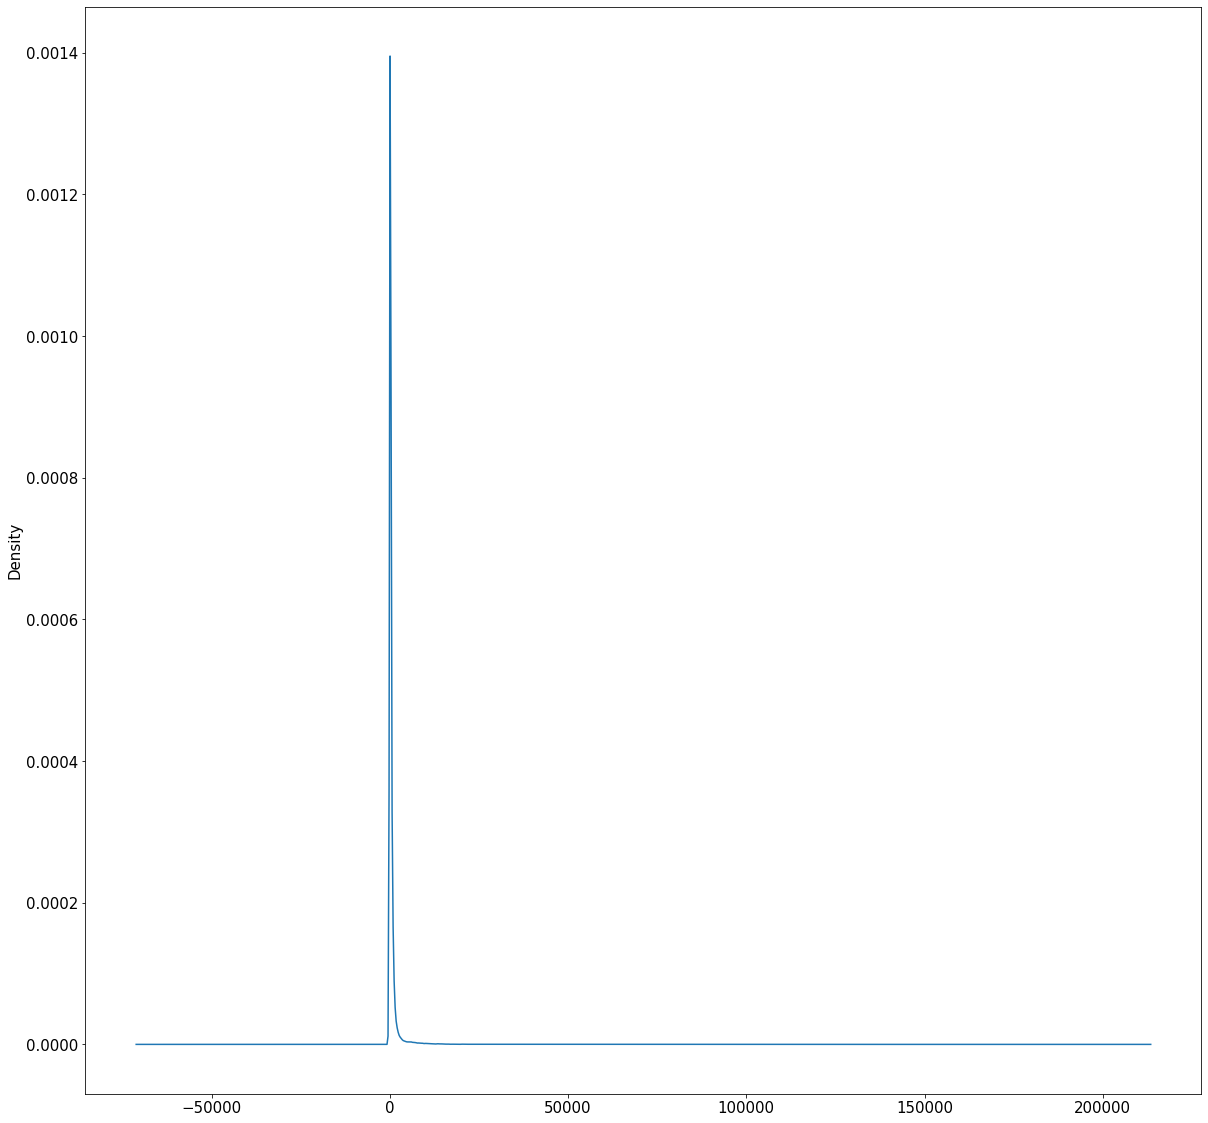

In [720]:
### --- Plotting the distribution of Morex_gp introns length
introns_Morex_gp['length'].plot.density()

<AxesSubplot:>

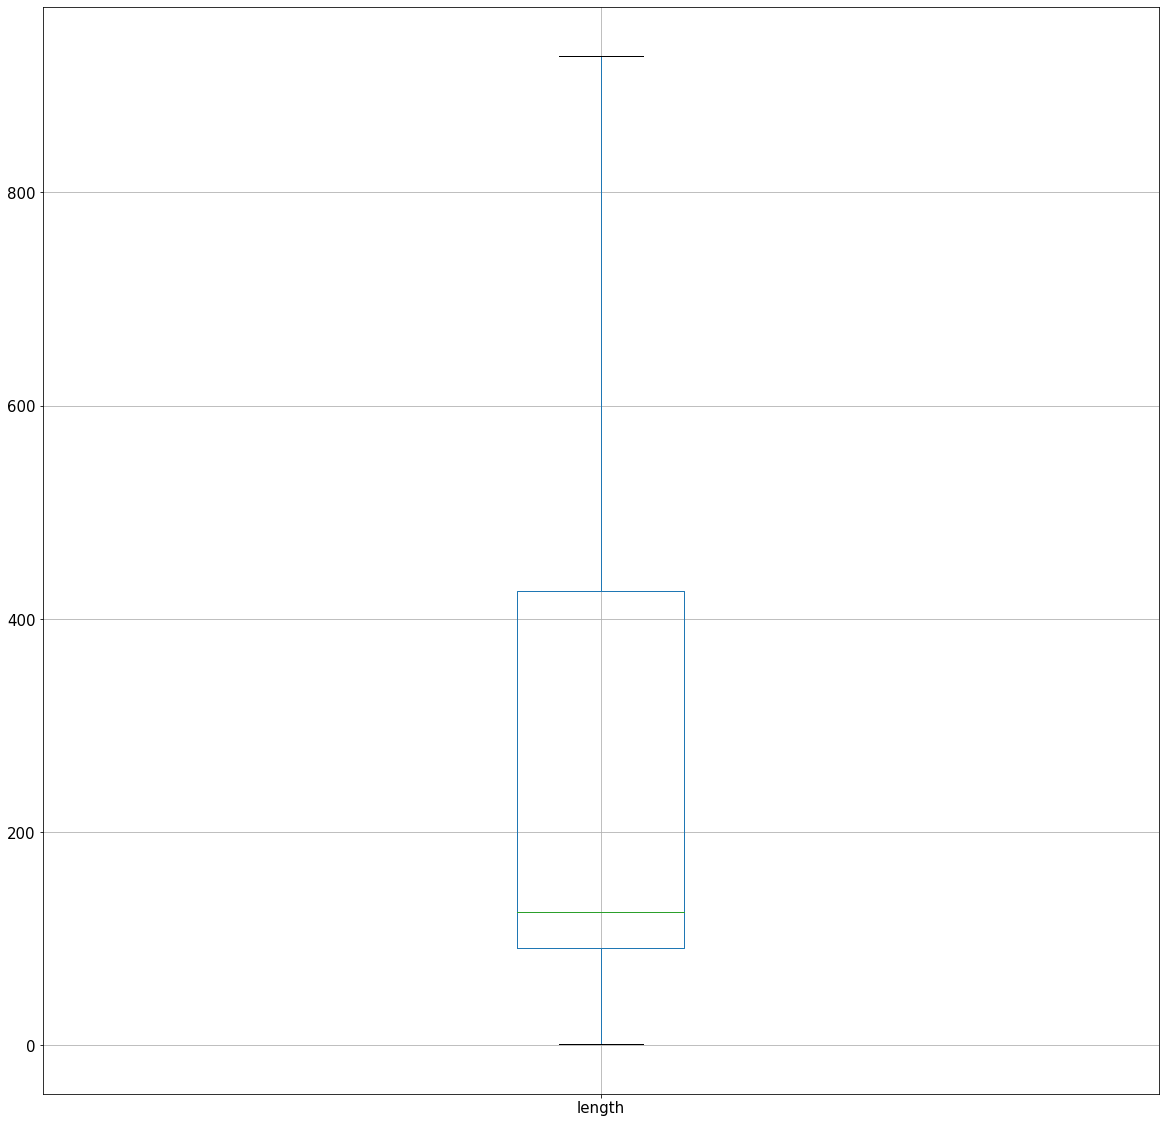

In [721]:
### --- Plotting the boxplot of Morex_gp introns length without outliers
introns_Morex_gp.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.20.4 Re-organizing files and directories

In [722]:
! ls Data/

Akashinriki	HOR10350     HOR3365		Morex
B1K		HOR10350_gp  HOR7552		Morex_gp_exon.tsv
Barke		HOR13821     HOR8148		Morex_gp_nohashtag.csv
Barke_gp	HOR13942     HOR9043		Morex_gp_nohashtag.gff3
Golden_Promise	HOR21599     Hv_Morex_longread	raw
Hockett		HOR3081      Igri


In [723]:
! mkdir Data/Morex_gp

In [724]:
! mv Data/Morex_gp_* Data/Morex_gp

In [725]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  raw
B1K	     Hockett	     HOR13942  HOR7552	Igri
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


In [726]:
! ls Output/

Akashinriki	HOR10350     HOR3365		Morex
B1K		HOR10350_gp  HOR7552		Morex_gp_intronlessIDs.txt
Barke		HOR13821     HOR8148		Morex_gp_intronpoorIDs.txt
Barke_gp	HOR13942     HOR9043		Morex_gp_intronrichIDs.txt
Golden_Promise	HOR21599     Hv_Morex_longread	Morex_gp_introns.tsv
Hockett		HOR3081      Igri


In [727]:
! mkdir Output/Morex_gp

In [728]:
! mv Output/Morex_gp_* Output/Morex_gp

In [729]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread
B1K	     Hockett	     HOR13942  HOR7552	Igri
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


## 3.21 OUN333 - Gene projection

### 3.21.1 Data Collection

In [730]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/OUN333.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/9b5ea42c-6b27-4bd7-a66e-3210ded3ece5/1/DOWNLOAD

--2021-10-01 12:31:46--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/9b5ea42c-6b27-4bd7-a66e-3210ded3ece5/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53104566 (51M) [text/plain]
Saving to: ‘Data/raw/OUN333.gff3’

Data/raw/OUN333.gff 100%[===================>]  50,64M  1,56MB/s    in 36s     

2021-10-01 12:32:22 (1,41 MB/s) - ‘Data/raw/OUN333.gff3’ saved [53104566/53104566]



### 3.21.2 Processing Data 

In [731]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [732]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/OUN333.gff3  > Data/OUN333_nohashtag.gff3

In [733]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/OUN333_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/OUN333_nohashtag.csv

In [734]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_OUN333 = pd.read_csv('Data/OUN333_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_OUN333.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,148122,148777,1081.962,-,.,ID=Horvu_OUN333_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,148122,148777,.,-,.,ID=Horvu_OUN333_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,148122,148375,.,-,.,ID=Horvu_OUN333_1H01G000100.1_exon_2
3,chr1H,PGSBv2.28112019,exon,148453,148777,.,-,.,ID=Horvu_OUN333_1H01G000100.1_exon_1
4,chr1H,PGSBv2.28112019,CDS,148122,148375,.,-,2,Parent=Horvu_OUN333_1H01G000100.1


In [735]:
### --- Building a separate dataframe containing all exons
exon_OUN333 = df_OUN333.loc[df_OUN333['type'].isin(['exon'])]
exon_OUN333.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,148122,148375,.,-,.,ID=Horvu_OUN333_1H01G000100.1_exon_2
3,chr1H,PGSBv2.28112019,exon,148453,148777,.,-,.,ID=Horvu_OUN333_1H01G000100.1_exon_1
8,chr1H,PGSBv2.28112019,exon,255408,255655,.,+,.,ID=Horvu_OUN333_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,exon,256114,256281,.,+,.,ID=Horvu_OUN333_1H01G000200.1_exon_2
10,chr1H,PGSBv2.28112019,exon,256372,256453,.,+,.,ID=Horvu_OUN333_1H01G000200.1_exon_3


In [736]:
### --- Exporting the exon dataframe to a tsv file 
exon_OUN333.to_csv('Data/OUN333_exon.tsv',sep='\t',index=False,header=False)

In [737]:
### --- Keeping in a separated dataframe the forward strands
forw_OUN333 = df_OUN333.loc[df_OUN333['strand'].isin(['+'])]
forw_OUN333.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,PGSBv2.28112019,gene,255408,257697,1892.044,+,.,ID=Horvu_OUN333_1H01G000200
7,chr1H,PGSBv2.28112019,mRNA,255408,257697,.,+,.,ID=Horvu_OUN333_1H01G000200.1
8,chr1H,PGSBv2.28112019,exon,255408,255655,.,+,.,ID=Horvu_OUN333_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,exon,256114,256281,.,+,.,ID=Horvu_OUN333_1H01G000200.1_exon_2
10,chr1H,PGSBv2.28112019,exon,256372,256453,.,+,.,ID=Horvu_OUN333_1H01G000200.1_exon_3


In [738]:
### --- Keeping in a separated dataframe the reverse strands
rev_OUN333 = df_OUN333.loc[df_OUN333['strand'].isin(['-'])]
rev_OUN333.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,148122,148777,1081.962,-,.,ID=Horvu_OUN333_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,148122,148777,.,-,.,ID=Horvu_OUN333_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,148122,148375,.,-,.,ID=Horvu_OUN333_1H01G000100.1_exon_2
3,chr1H,PGSBv2.28112019,exon,148453,148777,.,-,.,ID=Horvu_OUN333_1H01G000100.1_exon_1
4,chr1H,PGSBv2.28112019,CDS,148122,148375,.,-,2,Parent=Horvu_OUN333_1H01G000100.1


In [739]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_OUN333 = forw_OUN333.loc[df_OUN333['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_OUN333.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [740]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_OUN333 = rev_OUN333.loc[df_OUN333['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_OUN333.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.21.3 Extracting introns from the whole genome 

In [741]:
### --- Extracting introns from OUN333
extract_tot_introns_gp('Data/OUN333_exon.tsv', 'Output/OUN333_introns.tsv')

In [742]:
introns_OUN333 = pd.read_csv('Output/OUN333_introns.tsv', sep = '\t')
introns_OUN333[:100]

,ID,type,start,end,length
0,ID=Horvu_OUN333_1H01G000100.1,intron,148376,148452,78
1,ID=Horvu_OUN333_1H01G000200.1,intron,255656,256113,459
2,ID=Horvu_OUN333_1H01G000200.1,intron,256282,256371,91
3,ID=Horvu_OUN333_1H01G000200.1,intron,256454,257006,554
4,ID=Horvu_OUN333_1H01G000200.1,intron,257118,257153,37
...,...,...,...,...,...
95,ID=Horvu_OUN333_1H01G003800.1,intron,1385223,1385328,107
96,ID=Horvu_OUN333_1H01G003800.1,intron,1385393,1385535,144
97,ID=Horvu_OUN333_1H01G003800.1,intron,1386081,1386431,352
98,ID=Horvu_OUN333_1H01G003900.1,intron,1418720,1419447,729


In [743]:
### --- Counting introns type in OUN333
introns_dictionary_OUN333 = counting_introns_type_gp(exon_OUN333)

In [744]:
n_intronless_OUN333, n_intronpoor_OUN333, n_intronrich_OUN333, intronless_OUN333, intronpoor_OUN333, intronrich_OUN333 = splitting_introns_type(introns_dictionary_OUN333)

Intronless are: 16807
Intronpoor are: 18395
Intronrich are: 12075


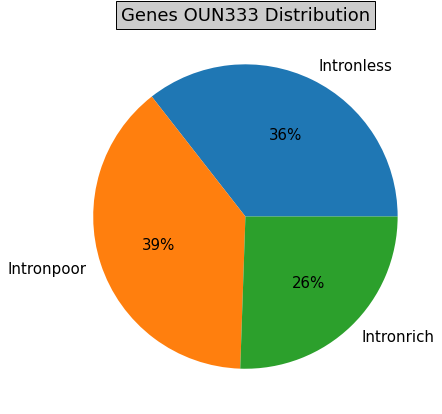

In [745]:
plotting_intron_types(n_intronless_OUN333, n_intronpoor_OUN333, n_intronrich_OUN333, 'Genes OUN333 Distribution')

In [746]:
### --- Creating the list of OUN333 gene IDs to check the number of transcripts using command line
intronless_file_OUN333 = open('Output/OUN333_intronlessIDs.txt', 'a')
intronpoor_file_OUN333 = open('Output/OUN333_intronpoorIDs.txt', 'a')
intronrich_file_OUN333 = open('Output/OUN333_intronrichIDs.txt', 'a')
for i in range(len(intronless_OUN333)):
    if i == len(intronless_OUN333) -1:
        intronless_file_OUN333.write(intronless_OUN333[i])
    else:
        intronless_file_OUN333.write(intronless_OUN333[i] + '\n')
intronless_file_OUN333.close()

for i in range(len(intronpoor_OUN333)):
    if i == len(intronpoor_OUN333) -1:
        intronpoor_file_OUN333.write(intronpoor_OUN333[i])
    else:
        intronpoor_file_OUN333.write(intronpoor_OUN333[i] + '\n')
intronpoor_file_OUN333.close()

for i in range(len(intronrich_OUN333)):
    if i == len(intronrich_OUN333) -1:
        intronrich_file_OUN333.write(intronrich_OUN333[i])
    else:
        intronrich_file_OUN333.write(intronrich_OUN333[i]+'\n')
intronrich_file_OUN333.close()

In [747]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_OUN333 = ! grep -f Output/OUN333_intronlessIDs.txt Data/OUN333_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_OUN333 = ! grep -f Output/OUN333_intronpoorIDs.txt Data/OUN333_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_OUN333 = ! grep -f Output/OUN333_intronrichIDs.txt Data/OUN333_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [748]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_OUN333 = int(n_mRNA_intronless_OUN333[0])/n_intronless_OUN333
print(avg_mRNA_intronless_OUN333)
avg_mRNA_intronpoor_OUN333 = int(n_mRNA_intronpoor_OUN333[0])/n_intronpoor_OUN333
print(avg_mRNA_intronpoor_OUN333)
avg_mRNA_intronrich_OUN333 = int(n_mRNA_intronrich_OUN333[0])/n_intronrich_OUN333
print(avg_mRNA_intronrich_OUN333)

1.0
1.0
1.0


No alternative splicing.

In [749]:
### --- Basic statistics of OUN333 introns
introns_OUN333['length'].describe()

count    130620.000000
mean        608.051761
std        2429.680061
min           1.000000
25%          91.000000
50%         124.000000
75%         425.000000
max      267097.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

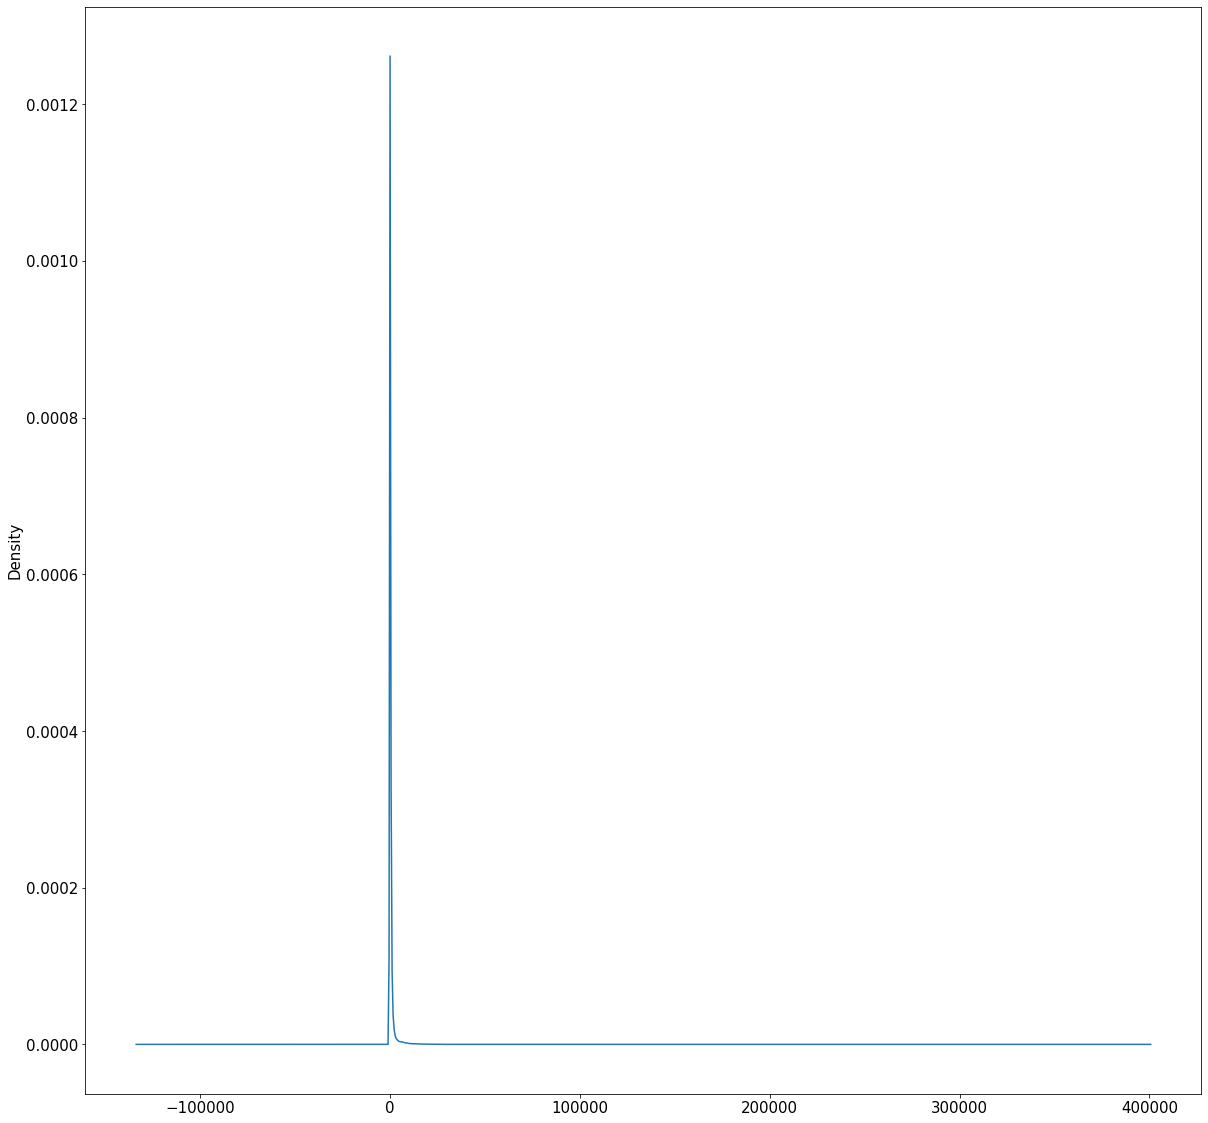

In [750]:
### --- Plotting the distribution of OUN333 introns length
introns_OUN333['length'].plot.density()

<AxesSubplot:>

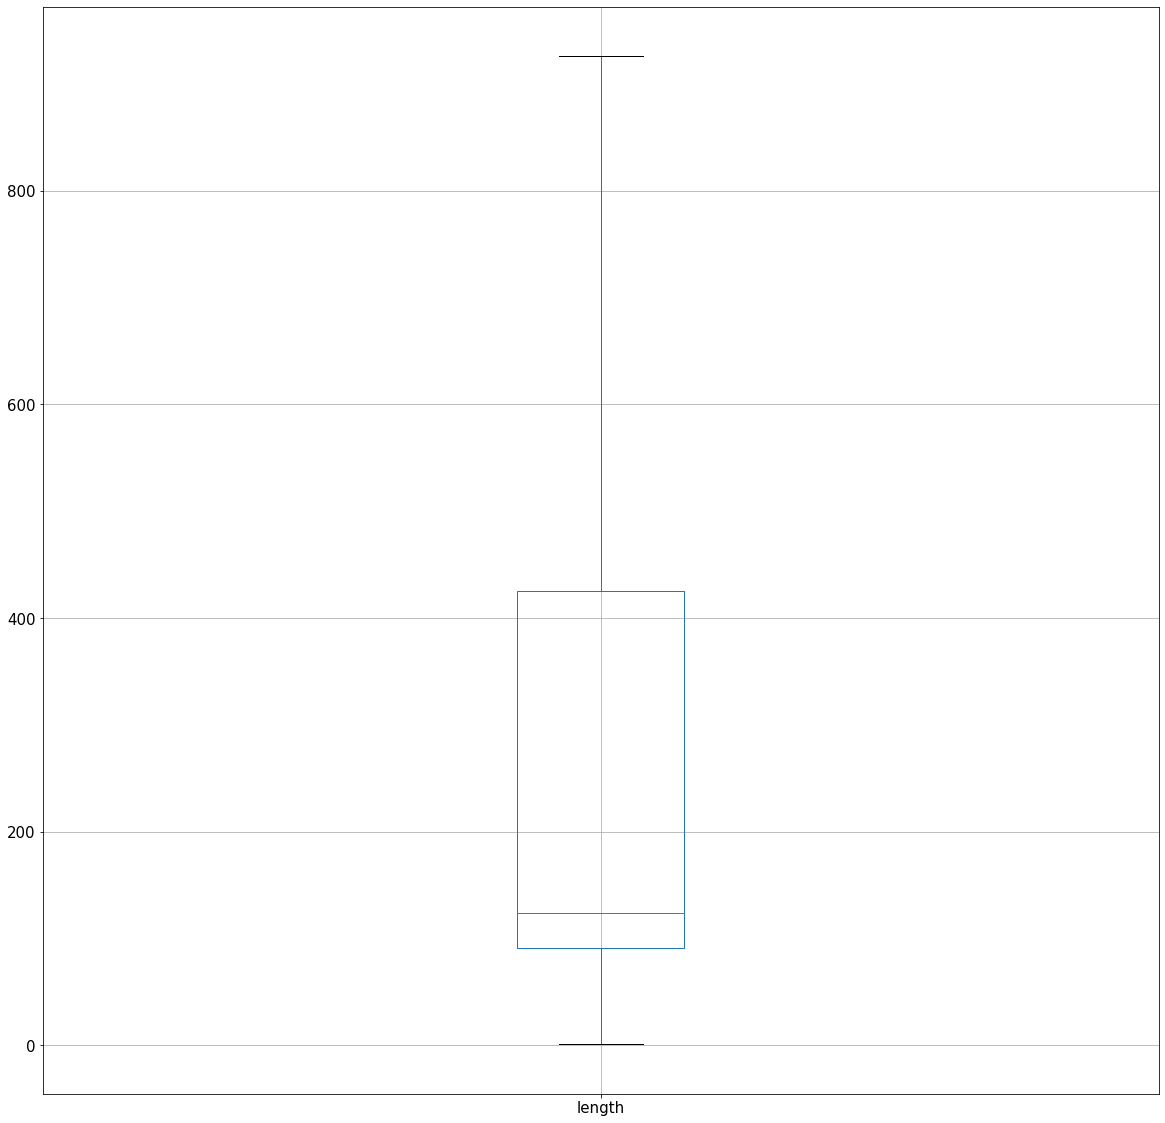

In [751]:
### --- Plotting the boxplot of OUN333 introns length without outliers
introns_OUN333.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.21.4 Re-organizing files and directories 

In [752]:
! ls Data/

Akashinriki	Hockett      HOR21599  HOR9043		  OUN333_exon.tsv
B1K		HOR10350     HOR3081   Hv_Morex_longread  OUN333_nohashtag.csv
Barke		HOR10350_gp  HOR3365   Igri		  OUN333_nohashtag.gff3
Barke_gp	HOR13821     HOR7552   Morex		  raw
Golden_Promise	HOR13942     HOR8148   Morex_gp


In [753]:
! mkdir Data/OUN333

In [754]:
! mv Data/OUN333_* Data/OUN333

In [755]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri		   raw
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


In [756]:
! ls Output/

Akashinriki	HOR10350     HOR3365		Morex
B1K		HOR10350_gp  HOR7552		Morex_gp
Barke		HOR13821     HOR8148		OUN333_intronlessIDs.txt
Barke_gp	HOR13942     HOR9043		OUN333_intronpoorIDs.txt
Golden_Promise	HOR21599     Hv_Morex_longread	OUN333_intronrichIDs.txt
Hockett		HOR3081      Igri		OUN333_introns.tsv


In [757]:
! mkdir Output/OUN333

In [758]:
! mv Output/OUN333_* Output/OUN333

In [759]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


## 3.22 RGT_Planet - Gene projection

### 3.22.1 Data Collection

In [760]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/RGT_Planet.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/92f038bd-4112-42a0-aa90-431940f82159/1/DOWNLOAD

--2021-10-01 12:32:39--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/92f038bd-4112-42a0-aa90-431940f82159/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53578113 (51M) [text/plain]
Saving to: ‘Data/raw/RGT_Planet.gff3’

Data/raw/RGT_Planet 100%[===================>]  51,10M  1,99MB/s    in 40s     

2021-10-01 12:33:20 (1,27 MB/s) - ‘Data/raw/RGT_Planet.gff3’ saved [53578113/53578113]



### 3.22.2 Processing Data 

In [761]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [762]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/RGT_Planet.gff3  > Data/RGT_Planet_nohashtag.gff3

In [763]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/RGT_Planet_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/RGT_Planet_nohashtag.csv

In [764]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_RGT_Planet = pd.read_csv('Data/RGT_Planet_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_RGT_Planet.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,pseudogene,45305,54666,2723.145,-,.,ID=Horvu_PLANET_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,45305,54666,.,-,.,ID=Horvu_PLANET_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,45305,45475,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,45647,45784,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,45956,46171,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_8


In [765]:
### --- Building a separate dataframe containing all exons
exon_RGT_Planet = df_RGT_Planet.loc[df_RGT_Planet['type'].isin(['exon'])]
exon_RGT_Planet.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,45305,45475,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,45647,45784,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,45956,46171,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_8
5,chr1H,PGSBv2.28112019,exon,47278,47351,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_7
6,chr1H,PGSBv2.28112019,exon,47446,47512,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_6


In [766]:
### --- Exporting the exon dataframe to a tsv file 
exon_RGT_Planet.to_csv('Data/RGT_Planet_exon.tsv',sep='\t',index=False,header=False)

In [767]:
### --- Keeping in a separated dataframe the forward strands
forw_RGT_Planet = df_RGT_Planet.loc[df_RGT_Planet['strand'].isin(['+'])]
forw_RGT_Planet.head()

,chr,source,type,start,end,score,strand,phase,attributes
18,chr1H,PGSBv2.28112019,gene,379626,381772,2139.031,+,.,ID=Horvu_PLANET_1H01G000300
19,chr1H,PGSBv2.28112019,mRNA,379626,381772,.,+,.,ID=Horvu_PLANET_1H01G000300.1
20,chr1H,PGSBv2.28112019,exon,379626,379885,.,+,.,ID=Horvu_PLANET_1H01G000300.1_exon_1
21,chr1H,PGSBv2.28112019,exon,380345,380512,.,+,.,ID=Horvu_PLANET_1H01G000300.1_exon_2
22,chr1H,PGSBv2.28112019,exon,380603,380684,.,+,.,ID=Horvu_PLANET_1H01G000300.1_exon_3


In [768]:
### --- Keeping in a separated dataframe the reverse strands
rev_RGT_Planet = df_RGT_Planet.loc[df_RGT_Planet['strand'].isin(['-'])]
rev_RGT_Planet.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,pseudogene,45305,54666,2723.145,-,.,ID=Horvu_PLANET_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,45305,54666,.,-,.,ID=Horvu_PLANET_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,45305,45475,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_10
3,chr1H,PGSBv2.28112019,exon,45647,45784,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_9
4,chr1H,PGSBv2.28112019,exon,45956,46171,.,-,.,ID=Horvu_PLANET_1H01G000100.1_exon_8


In [769]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_RGT_Planet = forw_RGT_Planet.loc[df_RGT_Planet['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_RGT_Planet.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [770]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_RGT_Planet = rev_RGT_Planet.loc[df_RGT_Planet['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_RGT_Planet.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.22.3 Extracting introns from the whole genome 

In [771]:
### --- Extracting introns from RGT_Planet
extract_tot_introns_gp('Data/RGT_Planet_exon.tsv', 'Output/RGT_Planet_introns.tsv')

In [772]:
introns_RGT_Planet = pd.read_csv('Output/RGT_Planet_introns.tsv', sep = '\t')
introns_RGT_Planet[:100]

,ID,type,start,end,length
0,ID=Horvu_PLANET_1H01G000100.1,intron,45476,45646,172
1,ID=Horvu_PLANET_1H01G000100.1,intron,45785,45955,172
2,ID=Horvu_PLANET_1H01G000100.1,intron,46172,47277,1107
3,ID=Horvu_PLANET_1H01G000100.1,intron,47352,47445,95
4,ID=Horvu_PLANET_1H01G000100.1,intron,47513,53619,6108
...,...,...,...,...,...
95,ID=Horvu_PLANET_1H01G003300.1,intron,1655959,1656151,194
96,ID=Horvu_PLANET_1H01G003400.1,intron,1671241,1672010,771
97,ID=Horvu_PLANET_1H01G003400.1,intron,1672072,1672171,101
98,ID=Horvu_PLANET_1H01G003600.1,intron,1703627,1703723,98


In [773]:
### --- Counting introns type in RGT_Planet
introns_dictionary_RGT_Planet = counting_introns_type_gp(exon_RGT_Planet)

In [774]:
n_intronless_RGT_Planet, n_intronpoor_RGT_Planet, n_intronrich_RGT_Planet, intronless_RGT_Planet, intronpoor_RGT_Planet, intronrich_RGT_Planet = splitting_introns_type(introns_dictionary_RGT_Planet)

Intronless are: 16990
Intronpoor are: 18664
Intronrich are: 12089


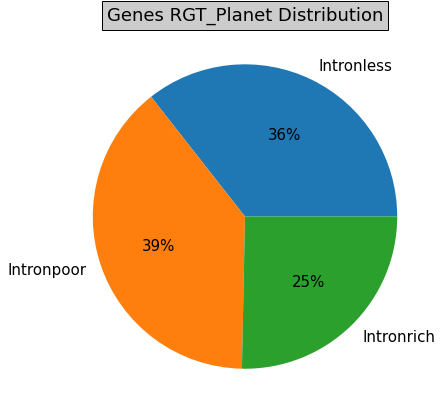

In [775]:
plotting_intron_types(n_intronless_RGT_Planet, n_intronpoor_RGT_Planet, n_intronrich_RGT_Planet, 'Genes RGT_Planet Distribution')

In [776]:
### --- Creating the list of RGT_Planet gene IDs to check the number of transcripts using command line
intronless_file_RGT_Planet = open('Output/RGT_Planet_intronlessIDs.txt', 'a')
intronpoor_file_RGT_Planet = open('Output/RGT_Planet_intronpoorIDs.txt', 'a')
intronrich_file_RGT_Planet = open('Output/RGT_Planet_intronrichIDs.txt', 'a')
for i in range(len(intronless_RGT_Planet)):
    if i == len(intronless_RGT_Planet) -1:
        intronless_file_RGT_Planet.write(intronless_RGT_Planet[i])
    else:
        intronless_file_RGT_Planet.write(intronless_RGT_Planet[i] + '\n')
intronless_file_RGT_Planet.close()

for i in range(len(intronpoor_RGT_Planet)):
    if i == len(intronpoor_RGT_Planet) -1:
        intronpoor_file_RGT_Planet.write(intronpoor_RGT_Planet[i])
    else:
        intronpoor_file_RGT_Planet.write(intronpoor_RGT_Planet[i] + '\n')
intronpoor_file_RGT_Planet.close()

for i in range(len(intronrich_RGT_Planet)):
    if i == len(intronrich_RGT_Planet) -1:
        intronrich_file_RGT_Planet.write(intronrich_RGT_Planet[i])
    else:
        intronrich_file_RGT_Planet.write(intronrich_RGT_Planet[i]+'\n')
intronrich_file_RGT_Planet.close()

In [777]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_RGT_Planet = ! grep -f Output/RGT_Planet_intronlessIDs.txt Data/RGT_Planet_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_RGT_Planet = ! grep -f Output/RGT_Planet_intronpoorIDs.txt Data/RGT_Planet_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_RGT_Planet = ! grep -f Output/RGT_Planet_intronrichIDs.txt Data/RGT_Planet_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [778]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_RGT_Planet = int(n_mRNA_intronless_RGT_Planet[0])/n_intronless_RGT_Planet
print(avg_mRNA_intronless_RGT_Planet)
avg_mRNA_intronpoor_RGT_Planet = int(n_mRNA_intronpoor_RGT_Planet[0])/n_intronpoor_RGT_Planet
print(avg_mRNA_intronpoor_RGT_Planet)
avg_mRNA_intronrich_RGT_Planet = int(n_mRNA_intronrich_RGT_Planet[0])/n_intronrich_RGT_Planet
print(avg_mRNA_intronrich_RGT_Planet)

1.0
1.0
1.0


No alternative splicing. 

In [779]:
### --- Basic statistics of RGT_Planet introns
introns_RGT_Planet['length'].describe()

count    131189.000000
mean        573.483813
std        2148.661771
min           1.000000
25%          91.000000
50%         124.000000
75%         427.000000
max      215940.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

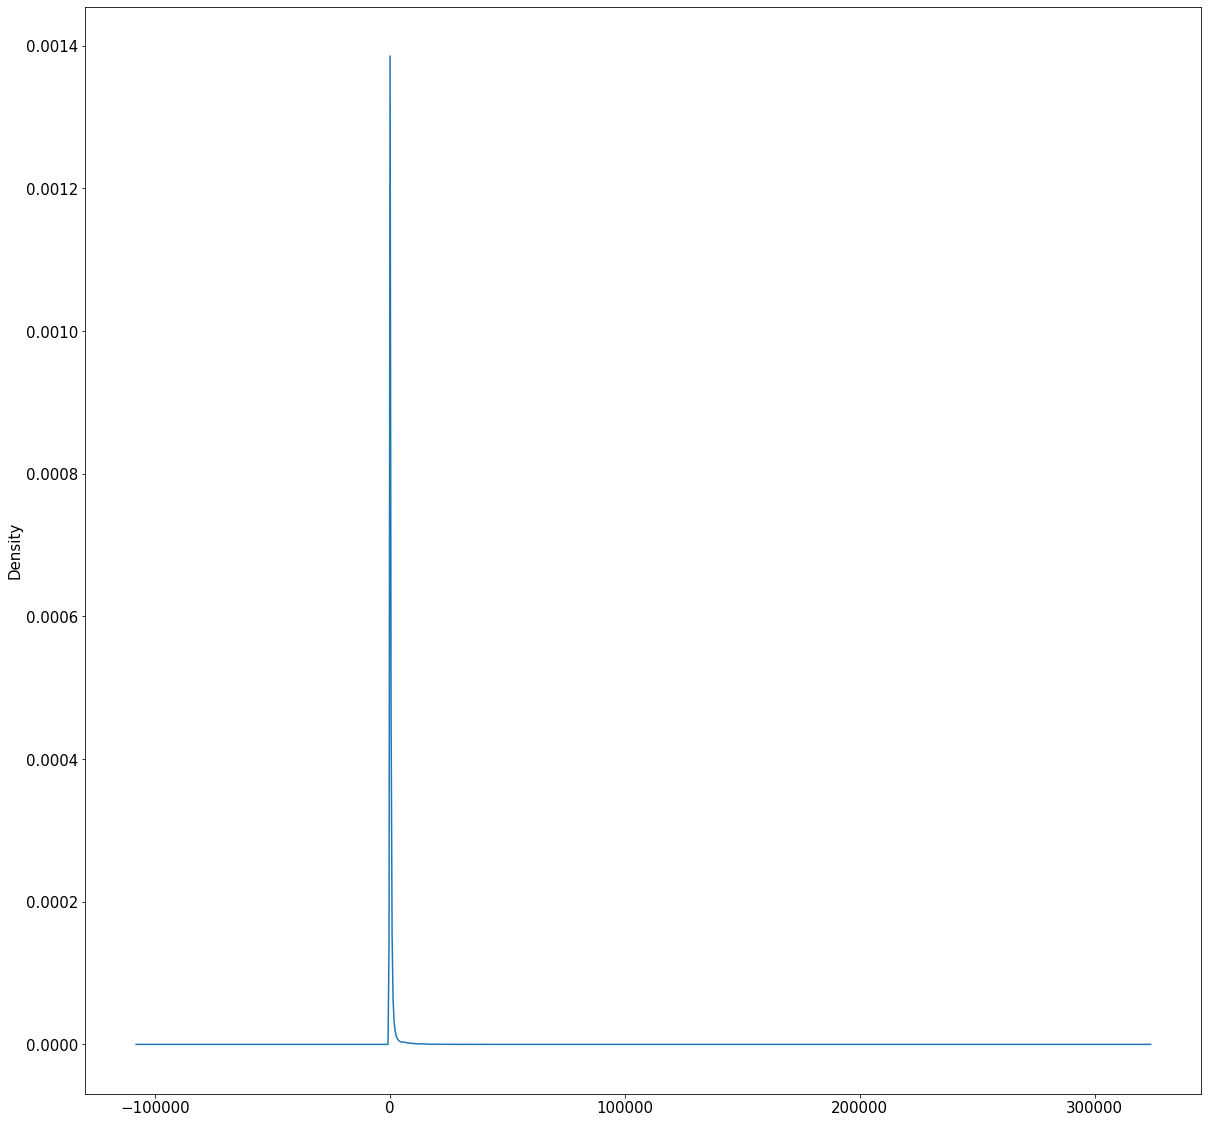

In [780]:
### --- Plotting the distribution of RGT_Planet introns length
introns_RGT_Planet['length'].plot.density()

<AxesSubplot:>

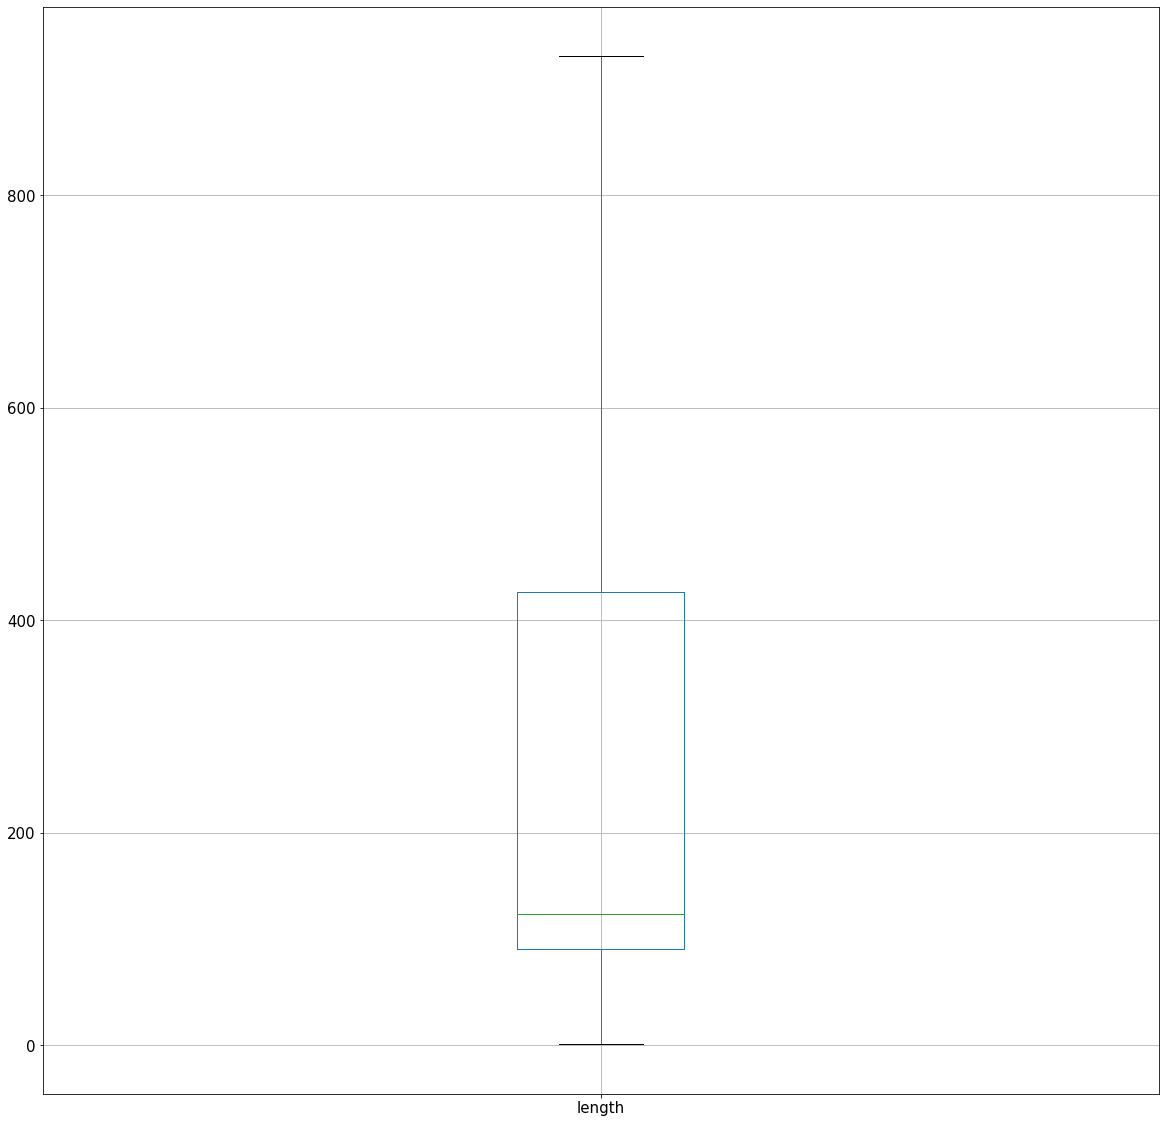

In [781]:
### --- Plotting the boxplot of RGT_Planet introns length without outliers
introns_RGT_Planet.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.22.4 Re-organizing files and directories 

In [782]:
! ls Data/

Akashinriki	HOR10350_gp  HOR8148		raw
B1K		HOR13821     HOR9043		RGT_Planet_exon.tsv
Barke		HOR13942     Hv_Morex_longread	RGT_Planet_nohashtag.csv
Barke_gp	HOR21599     Igri		RGT_Planet_nohashtag.gff3
Golden_Promise	HOR3081      Morex
Hockett		HOR3365      Morex_gp
HOR10350	HOR7552      OUN333


In [783]:
! mkdir Data/RGT_Planet

In [784]:
! mv Data/RGT_Planet_* Data/RGT_Planet

In [785]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri		   raw
Barke	     HOR10350	     HOR21599  HOR8148	Morex		   RGT_Planet
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


In [786]:
! ls Output/

Akashinriki	HOR10350_gp  HOR8148		RGT_Planet_intronlessIDs.txt
B1K		HOR13821     HOR9043		RGT_Planet_intronpoorIDs.txt
Barke		HOR13942     Hv_Morex_longread	RGT_Planet_intronrichIDs.txt
Barke_gp	HOR21599     Igri		RGT_Planet_introns.tsv
Golden_Promise	HOR3081      Morex
Hockett		HOR3365      Morex_gp
HOR10350	HOR7552      OUN333


In [787]:
! mkdir Output/RGT_Planet

In [788]:
! mv Output/RGT_Planet_* Output/RGT_Planet

In [789]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri		   RGT_Planet
Barke	     HOR10350	     HOR21599  HOR8148	Morex
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


## 3.23 ZDM01467 - Gene projection

### 3.23.1 Data Collection

In [790]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/ZDM01467.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/6e7e8cf3-08d2-4f25-8dac-4eb70f2241dd/1/DOWNLOAD

--2021-10-01 12:33:35--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/6e7e8cf3-08d2-4f25-8dac-4eb70f2241dd/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52515180 (50M) [text/plain]
Saving to: ‘Data/raw/ZDM01467.gff3’

Data/raw/ZDM01467.g 100%[===================>]  50,08M  1,97MB/s    in 31s     

2021-10-01 12:34:08 (1,60 MB/s) - ‘Data/raw/ZDM01467.gff3’ saved [52515180/52515180]



### 3.23.2 Processing Data 

In [791]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [792]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/ZDM01467.gff3  > Data/ZDM01467_nohashtag.gff3

In [793]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/ZDM01467_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/ZDM01467_nohashtag.csv

In [794]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_ZDM01467 = pd.read_csv('Data/ZDM01467_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_ZDM01467.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,125087,125684,884.760,+,.,ID=Horvu_HUANG_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,125087,125684,.,+,.,ID=Horvu_HUANG_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,125087,125290,.,+,.,ID=Horvu_HUANG_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,125448,125684,.,+,.,ID=Horvu_HUANG_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,125087,125290,.,+,0,Parent=Horvu_HUANG_1H01G000100.1


In [795]:
### --- Building a separate dataframe containing all exons
exon_ZDM01467 = df_ZDM01467.loc[df_ZDM01467['type'].isin(['exon'])]
exon_ZDM01467.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,125087,125290,.,+,.,ID=Horvu_HUANG_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,125448,125684,.,+,.,ID=Horvu_HUANG_1H01G000100.1_exon_2
8,chr1H,PGSBv2.28112019,exon,129436,129711,.,-,.,ID=Horvu_HUANG_1H01G000200.1_exon_1
12,chr1H,PGSBv2.28112019,exon,154266,154476,.,-,.,ID=Horvu_HUANG_1H01G000300.1_exon_8
13,chr1H,PGSBv2.28112019,exon,154556,154956,.,-,.,ID=Horvu_HUANG_1H01G000300.1_exon_7


In [796]:
### --- Exporting the exon dataframe to a tsv file 
exon_ZDM01467.to_csv('Data/ZDM01467_exon.tsv',sep='\t',index=False,header=False)

In [797]:
### --- Keeping in a separated dataframe the forward strands
forw_ZDM01467 = df_ZDM01467.loc[df_ZDM01467['strand'].isin(['+'])]
forw_ZDM01467.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,125087,125684,884.760,+,.,ID=Horvu_HUANG_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,125087,125684,.,+,.,ID=Horvu_HUANG_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,125087,125290,.,+,.,ID=Horvu_HUANG_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,125448,125684,.,+,.,ID=Horvu_HUANG_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,CDS,125087,125290,.,+,0,Parent=Horvu_HUANG_1H01G000100.1


In [798]:
### --- Keeping in a separated dataframe the reverse strands
rev_ZDM01467 = df_ZDM01467.loc[df_ZDM01467['strand'].isin(['-'])]
rev_ZDM01467.head()

,chr,source,type,start,end,score,strand,phase,attributes
6,chr1H,PGSBv2.28112019,gene,129436,129711,560.606,-,.,ID=Horvu_HUANG_1H01G000200
7,chr1H,PGSBv2.28112019,mRNA,129436,129711,.,-,.,ID=Horvu_HUANG_1H01G000200.1
8,chr1H,PGSBv2.28112019,exon,129436,129711,.,-,.,ID=Horvu_HUANG_1H01G000200.1_exon_1
9,chr1H,PGSBv2.28112019,CDS,129436,129711,.,-,0,Parent=Horvu_HUANG_1H01G000200.1
10,chr1H,PGSBv2.28112019,gene,154266,159390,3053.527,-,.,ID=Horvu_HUANG_1H01G000300


In [799]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_ZDM01467 = forw_ZDM01467.loc[df_ZDM01467['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_ZDM01467.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [800]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_ZDM01467 = rev_ZDM01467.loc[df_ZDM01467['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_ZDM01467.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.23.3 Extracting introns from the whole genome

In [801]:
### --- Extracting introns from ZDM01467
extract_tot_introns_gp('Data/ZDM01467_exon.tsv', 'Output/ZDM01467_introns.tsv')

In [802]:
introns_ZDM01467 = pd.read_csv('Output/ZDM01467_introns.tsv', sep = '\t')
introns_ZDM01467[:100]

,ID,type,start,end,length
0,ID=Horvu_HUANG_1H01G000100.1,intron,125291,125447,158
1,ID=Horvu_HUANG_1H01G000300.1,intron,154477,154555,80
2,ID=Horvu_HUANG_1H01G000300.1,intron,154957,155509,554
3,ID=Horvu_HUANG_1H01G000300.1,intron,155592,155681,91
4,ID=Horvu_HUANG_1H01G000300.1,intron,155850,156308,460
...,...,...,...,...,...
95,ID=Horvu_HUANG_1H01G004100.1,intron,1178105,1178201,98
96,ID=Horvu_HUANG_1H01G004100.1,intron,1178302,1178506,206
97,ID=Horvu_HUANG_1H01G004100.1,intron,1178633,1178741,110
98,ID=Horvu_HUANG_1H01G004100.1,intron,1179275,1181643,2370


In [803]:
### --- Counting introns type in ZDM01467
introns_dictionary_ZDM01467 = counting_introns_type_gp(exon_ZDM01467)

In [804]:
n_intronless_ZDM01467, n_intronpoor_ZDM01467, n_intronrich_ZDM01467, intronless_ZDM01467, intronpoor_ZDM01467, intronrich_ZDM01467 = splitting_introns_type(introns_dictionary_ZDM01467)

Intronless are: 16640
Intronpoor are: 18703
Intronrich are: 12065


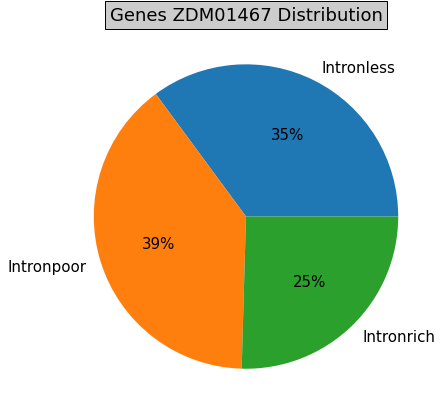

In [805]:
plotting_intron_types(n_intronless_ZDM01467, n_intronpoor_ZDM01467, n_intronrich_ZDM01467, 'Genes ZDM01467 Distribution')

In [806]:
### --- Creating the list of ZDM01467 gene IDs to check the number of transcripts using command line
intronless_file_ZDM01467 = open('Output/ZDM01467_intronlessIDs.txt', 'a')
intronpoor_file_ZDM01467 = open('Output/ZDM01467_intronpoorIDs.txt', 'a')
intronrich_file_ZDM01467 = open('Output/ZDM01467_intronrichIDs.txt', 'a')
for i in range(len(intronless_ZDM01467)):
    if i == len(intronless_ZDM01467) -1:
        intronless_file_ZDM01467.write(intronless_ZDM01467[i])
    else:
        intronless_file_ZDM01467.write(intronless_ZDM01467[i] + '\n')
intronless_file_ZDM01467.close()

for i in range(len(intronpoor_ZDM01467)):
    if i == len(intronpoor_ZDM01467) -1:
        intronpoor_file_ZDM01467.write(intronpoor_ZDM01467[i])
    else:
        intronpoor_file_ZDM01467.write(intronpoor_ZDM01467[i] + '\n')
intronpoor_file_ZDM01467.close()

for i in range(len(intronrich_ZDM01467)):
    if i == len(intronrich_ZDM01467) -1:
        intronrich_file_ZDM01467.write(intronrich_ZDM01467[i])
    else:
        intronrich_file_ZDM01467.write(intronrich_ZDM01467[i]+'\n')
intronrich_file_ZDM01467.close()

In [807]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_ZDM01467 = ! grep -f Output/ZDM01467_intronlessIDs.txt Data/ZDM01467_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_ZDM01467 = ! grep -f Output/ZDM01467_intronpoorIDs.txt Data/ZDM01467_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_ZDM01467 = ! grep -f Output/ZDM01467_intronrichIDs.txt Data/ZDM01467_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [808]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_ZDM01467 = int(n_mRNA_intronless_ZDM01467[0])/n_intronless_ZDM01467
print(avg_mRNA_intronless_ZDM01467)
avg_mRNA_intronpoor_ZDM01467 = int(n_mRNA_intronpoor_ZDM01467[0])/n_intronpoor_ZDM01467
print(avg_mRNA_intronpoor_ZDM01467)
avg_mRNA_intronrich_ZDM01467 = int(n_mRNA_intronrich_ZDM01467[0])/n_intronrich_ZDM01467
print(avg_mRNA_intronrich_ZDM01467)

1.0
1.0
1.0


No alternative splicing.

In [809]:
### --- Basic statistics of ZDM01467 introns
introns_ZDM01467['length'].describe()

count    130972.000000
mean        605.147398
std        2344.994628
min           1.000000
25%          91.000000
50%         124.000000
75%         431.000000
max      280999.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

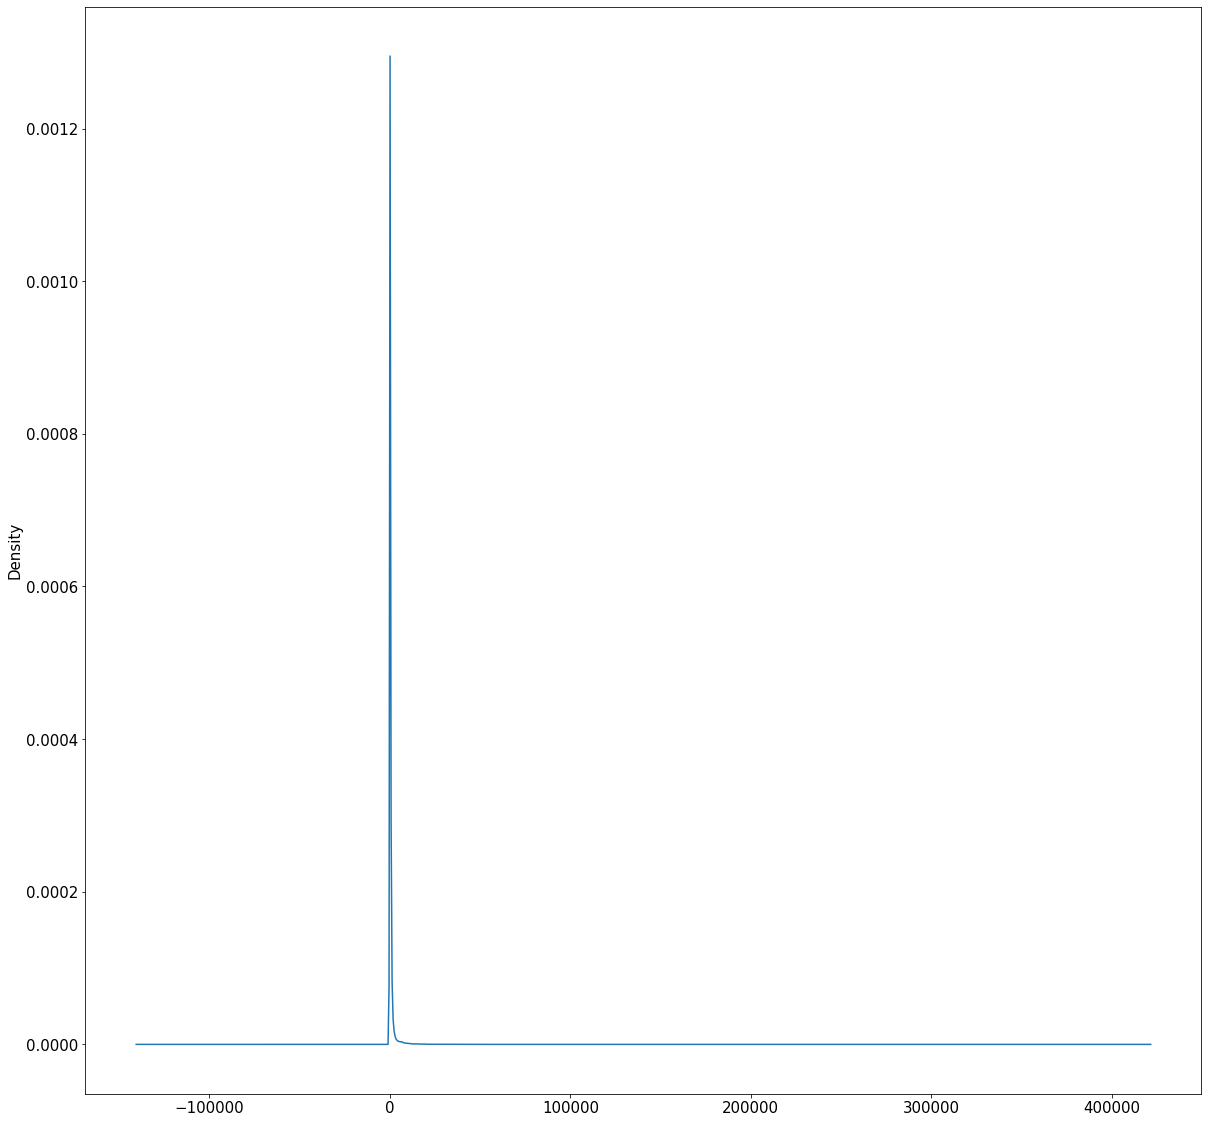

In [810]:
### --- Plotting the distribution of ZDM01467 introns length
introns_ZDM01467['length'].plot.density()

<AxesSubplot:>

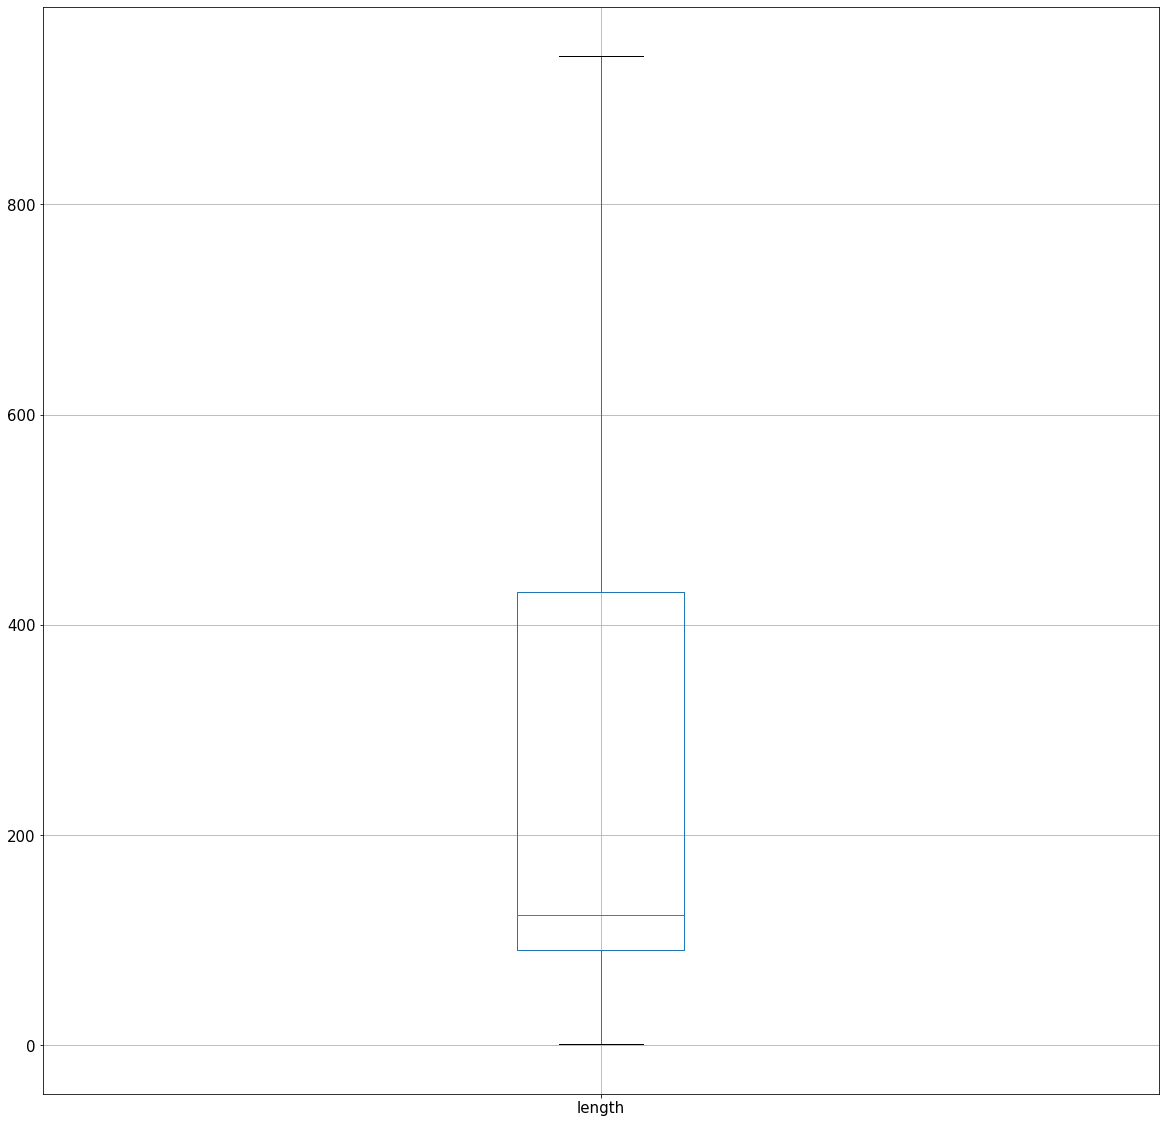

In [811]:
### --- Plotting the boxplot of ZDM01467 introns length without outliers
introns_ZDM01467.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.23.4 Re-organizing files and directories 

In [812]:
! ls Data/

Akashinriki	HOR10350_gp  HOR8148		raw
B1K		HOR13821     HOR9043		RGT_Planet
Barke		HOR13942     Hv_Morex_longread	ZDM01467_exon.tsv
Barke_gp	HOR21599     Igri		ZDM01467_nohashtag.csv
Golden_Promise	HOR3081      Morex		ZDM01467_nohashtag.gff3
Hockett		HOR3365      Morex_gp
HOR10350	HOR7552      OUN333


In [813]:
! mkdir Data/ZDM01467

In [814]:
! mv Data/ZDM01467_* Data/ZDM01467

In [815]:
! ls Data/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri		   raw
Barke	     HOR10350	     HOR21599  HOR8148	Morex		   RGT_Planet
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp	   ZDM01467


In [816]:
! ls Output/

Akashinriki	HOR10350_gp  HOR8148		RGT_Planet
B1K		HOR13821     HOR9043		ZDM01467_intronlessIDs.txt
Barke		HOR13942     Hv_Morex_longread	ZDM01467_intronpoorIDs.txt
Barke_gp	HOR21599     Igri		ZDM01467_intronrichIDs.txt
Golden_Promise	HOR3081      Morex		ZDM01467_introns.tsv
Hockett		HOR3365      Morex_gp
HOR10350	HOR7552      OUN333


In [817]:
! mkdir Output/ZDM01467

In [818]:
! mv Output/ZDM01467_* Output/ZDM01467

In [819]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri		   RGT_Planet
Barke	     HOR10350	     HOR21599  HOR8148	Morex		   ZDM01467
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp


## 3.24 ZDM02064 - Gene projection

### 3.24.1 Data Collection

In [820]:
### --- This will download the raw data to the subdirectory raw under the directory Data
! wget -O Data/raw/ZDM02064.gff3 https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/68d247e5-6cb3-4ba6-bcd6-89fa8e69a6c6/1/DOWNLOAD

--2021-10-01 12:34:22--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/68d247e5-6cb3-4ba6-bcd6-89fa8e69a6c6/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52654065 (50M) [text/plain]
Saving to: ‘Data/raw/ZDM02064.gff3’

Data/raw/ZDM02064.g 100%[===================>]  50,21M  1,47MB/s    in 29s     

2021-10-01 12:34:51 (1,76 MB/s) - ‘Data/raw/ZDM02064.gff3’ saved [52654065/52654065]



### 3.24.2 Processing Data 

In [821]:
### --- There is no need to import the libraries again
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

In [822]:
### --- Removing all hashtags from the gff3 file
! sed '/#/d' Data/raw/ZDM02064.gff3  > Data/ZDM02064_nohashtag.gff3

In [823]:
### --- Changing the gff3 file to a csv format file to import it with pandas
! cat Data/ZDM02064_nohashtag.gff3 | sed 's/,/--/g' | sed 's/;/--/g' | sed 's/\t/,/g' | awk -F '--' '{print $1}' > Data/ZDM02064_nohashtag.csv

In [824]:
### --- Transforming the gff3 file to a pandas dataframe to better handle it
df_ZDM02064 = pd.read_csv('Data/ZDM02064_nohashtag.csv', header=None, names = ['chr', 'source', 'type','start','end','score','strand','phase','attributes'])
df_ZDM02064.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,5186,9409,1807.515,+,.,ID=Horvu_CHIBA_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,5186,9409,.,+,.,ID=Horvu_CHIBA_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,5186,5299,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,5562,5645,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,6476,6637,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_3


In [825]:
### --- Building a separate dataframe containing all exons
exon_ZDM02064 = df_ZDM02064.loc[df_ZDM02064['type'].isin(['exon'])]
exon_ZDM02064.head()

,chr,source,type,start,end,score,strand,phase,attributes
2,chr1H,PGSBv2.28112019,exon,5186,5299,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,5562,5645,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,6476,6637,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_3
5,chr1H,PGSBv2.28112019,exon,6717,6770,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_4
6,chr1H,PGSBv2.28112019,exon,6923,7069,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_5


In [826]:
### --- Exporting the exon dataframe to a tsv file 
exon_ZDM02064.to_csv('Data/ZDM02064_exon.tsv',sep='\t',index=False,header=False)

In [827]:
### --- Keeping in a separated dataframe the forward strands
forw_ZDM02064 = df_ZDM02064.loc[df_ZDM02064['strand'].isin(['+'])]
forw_ZDM02064.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSBv2.28112019,gene,5186,9409,1807.515,+,.,ID=Horvu_CHIBA_1H01G000100
1,chr1H,PGSBv2.28112019,mRNA,5186,9409,.,+,.,ID=Horvu_CHIBA_1H01G000100.1
2,chr1H,PGSBv2.28112019,exon,5186,5299,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_1
3,chr1H,PGSBv2.28112019,exon,5562,5645,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_2
4,chr1H,PGSBv2.28112019,exon,6476,6637,.,+,.,ID=Horvu_CHIBA_1H01G000100.1_exon_3


In [828]:
### --- Keeping in a separated dataframe the reverse strands
rev_ZDM02064 = df_ZDM02064.loc[df_ZDM02064['strand'].isin(['-'])]
rev_ZDM02064.head()

,chr,source,type,start,end,score,strand,phase,attributes
20,chr1H,PGSBv2.28112019,gene,33145,39707,3981.568,-,.,ID=Horvu_CHIBA_1H01G000300
21,chr1H,PGSBv2.28112019,mRNA,33145,39707,.,-,.,ID=Horvu_CHIBA_1H01G000300.1
22,chr1H,PGSBv2.28112019,exon,33145,33445,.,-,.,ID=Horvu_CHIBA_1H01G000300.1_exon_13
23,chr1H,PGSBv2.28112019,exon,34179,34264,.,-,.,ID=Horvu_CHIBA_1H01G000300.1_exon_12
24,chr1H,PGSBv2.28112019,exon,34434,34547,.,-,.,ID=Horvu_CHIBA_1H01G000300.1_exon_11


In [829]:
### --- Keeping in a separated dataframe the UTR regions on the forward strands
UTR_forw_ZDM02064 = forw_ZDM02064.loc[df_ZDM02064['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_forw_ZDM02064.head()

,chr,source,type,start,end,score,strand,phase,attributes


In [830]:
### --- Keeping in a separated dataframe the UTR regions on the reverse strands
UTR_rev_ZDM02064 = rev_ZDM02064.loc[df_ZDM02064['type'].isin(['three_prime_UTR','five_prime_UTR'])]
UTR_rev_ZDM02064.head()

,chr,source,type,start,end,score,strand,phase,attributes


No UTRs.

### 3.24.3 Extracting introns from the whole genome

In [831]:
### --- Extracting introns from ZDM02064
extract_tot_introns_gp('Data/ZDM02064_exon.tsv', 'Output/ZDM02064_introns.tsv')

In [832]:
introns_ZDM02064 = pd.read_csv('Output/ZDM02064_introns.tsv', sep = '\t')
introns_ZDM02064[:100]

,ID,type,start,end,length
0,ID=Horvu_CHIBA_1H01G000100.1,intron,5300,5561,263
1,ID=Horvu_CHIBA_1H01G000100.1,intron,5646,6475,831
2,ID=Horvu_CHIBA_1H01G000100.1,intron,6638,6716,80
3,ID=Horvu_CHIBA_1H01G000100.1,intron,6771,6922,153
4,ID=Horvu_CHIBA_1H01G000100.1,intron,7070,9037,1969
...,...,...,...,...,...
95,ID=Horvu_CHIBA_1H01G003400.1,intron,956879,957162,285
96,ID=Horvu_CHIBA_1H01G003400.1,intron,957275,957386,113
97,ID=Horvu_CHIBA_1H01G003400.1,intron,957459,957542,85
98,ID=Horvu_CHIBA_1H01G003400.1,intron,957637,958546,911


In [833]:
### --- Counting introns type in ZDM02064
introns_dictionary_ZDM02064 = counting_introns_type_gp(exon_ZDM02064)

In [834]:
n_intronless_ZDM02064, n_intronpoor_ZDM02064, n_intronrich_ZDM02064, intronless_ZDM02064, intronpoor_ZDM02064, intronrich_ZDM02064 = splitting_introns_type(introns_dictionary_ZDM02064)

Intronless are: 17126
Intronpoor are: 18588
Intronrich are: 12080


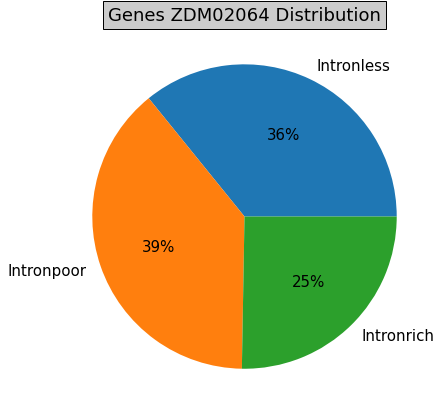

In [835]:
plotting_intron_types(n_intronless_ZDM02064, n_intronpoor_ZDM02064, n_intronrich_ZDM02064, 'Genes ZDM02064 Distribution')

In [836]:
### --- Creating the list of ZDM02064 gene IDs to check the number of transcripts using command line
intronless_file_ZDM02064 = open('Output/ZDM02064_intronlessIDs.txt', 'a')
intronpoor_file_ZDM02064 = open('Output/ZDM02064_intronpoorIDs.txt', 'a')
intronrich_file_ZDM02064 = open('Output/ZDM02064_intronrichIDs.txt', 'a')
for i in range(len(intronless_ZDM02064)):
    if i == len(intronless_ZDM02064) -1:
        intronless_file_ZDM02064.write(intronless_ZDM02064[i])
    else:
        intronless_file_ZDM02064.write(intronless_ZDM02064[i] + '\n')
intronless_file_ZDM02064.close()

for i in range(len(intronpoor_ZDM02064)):
    if i == len(intronpoor_ZDM02064) -1:
        intronpoor_file_ZDM02064.write(intronpoor_ZDM02064[i])
    else:
        intronpoor_file_ZDM02064.write(intronpoor_ZDM02064[i] + '\n')
intronpoor_file_ZDM02064.close()

for i in range(len(intronrich_ZDM02064)):
    if i == len(intronrich_ZDM02064) -1:
        intronrich_file_ZDM02064.write(intronrich_ZDM02064[i])
    else:
        intronrich_file_ZDM02064.write(intronrich_ZDM02064[i]+'\n')
intronrich_file_ZDM02064.close()

In [837]:
### --- Storing the number of transcripts in intron-less/poor/rich genes within a variable 
n_mRNA_intronless_ZDM02064 = ! grep -f Output/ZDM02064_intronlessIDs.txt Data/ZDM02064_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronpoor_ZDM02064 = ! grep -f Output/ZDM02064_intronpoorIDs.txt Data/ZDM02064_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l
n_mRNA_intronrich_ZDM02064 = ! grep -f Output/ZDM02064_intronrichIDs.txt Data/ZDM02064_nohashtag.gff3 | awk -F '\t' '{print $3}' | grep -w 'mRNA' | wc -l

In [838]:
### --- Checking the average number of transcripts for each gene-type
avg_mRNA_intronless_ZDM02064 = int(n_mRNA_intronless_ZDM02064[0])/n_intronless_ZDM02064
print(avg_mRNA_intronless_ZDM02064)
avg_mRNA_intronpoor_ZDM02064 = int(n_mRNA_intronpoor_ZDM02064[0])/n_intronpoor_ZDM02064
print(avg_mRNA_intronpoor_ZDM02064)
avg_mRNA_intronrich_ZDM02064 = int(n_mRNA_intronrich_ZDM02064[0])/n_intronrich_ZDM02064
print(avg_mRNA_intronrich_ZDM02064)

1.0
1.0
1.0


No alternative splicing. 

In [839]:
### --- Basic statistics of ZDM02064 introns
introns_ZDM02064['length'].describe()

count    130743.000000
mean        570.240732
std        2161.894930
min           1.000000
25%          91.000000
50%         122.000000
75%         411.000000
max      157972.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Density'>

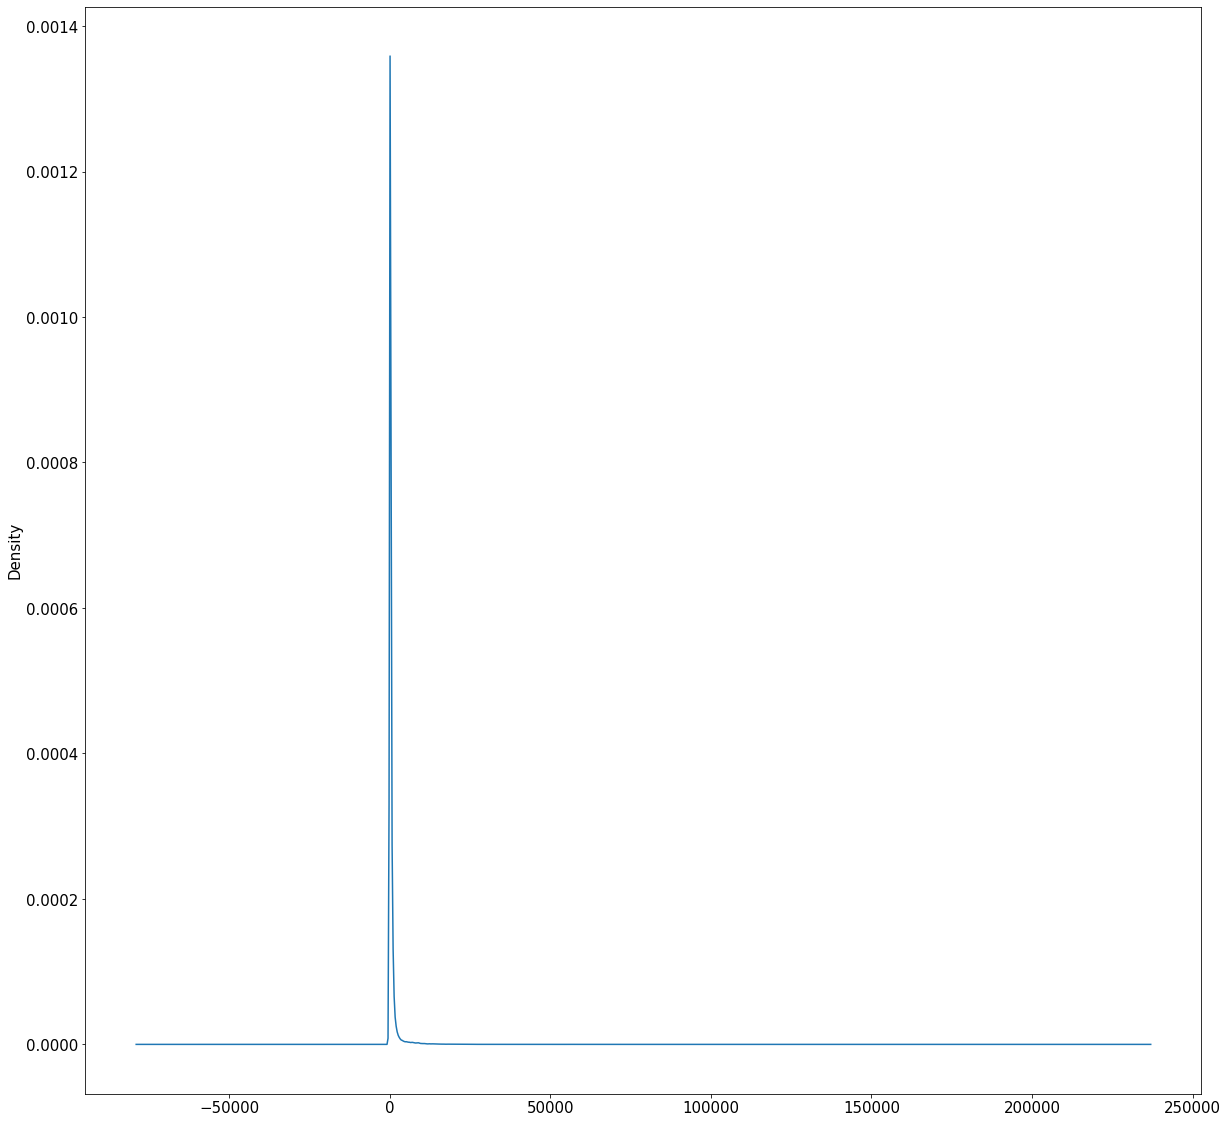

In [840]:
### --- Plotting the distribution of ZDM02064 introns length
introns_ZDM02064['length'].plot.density()

<AxesSubplot:>

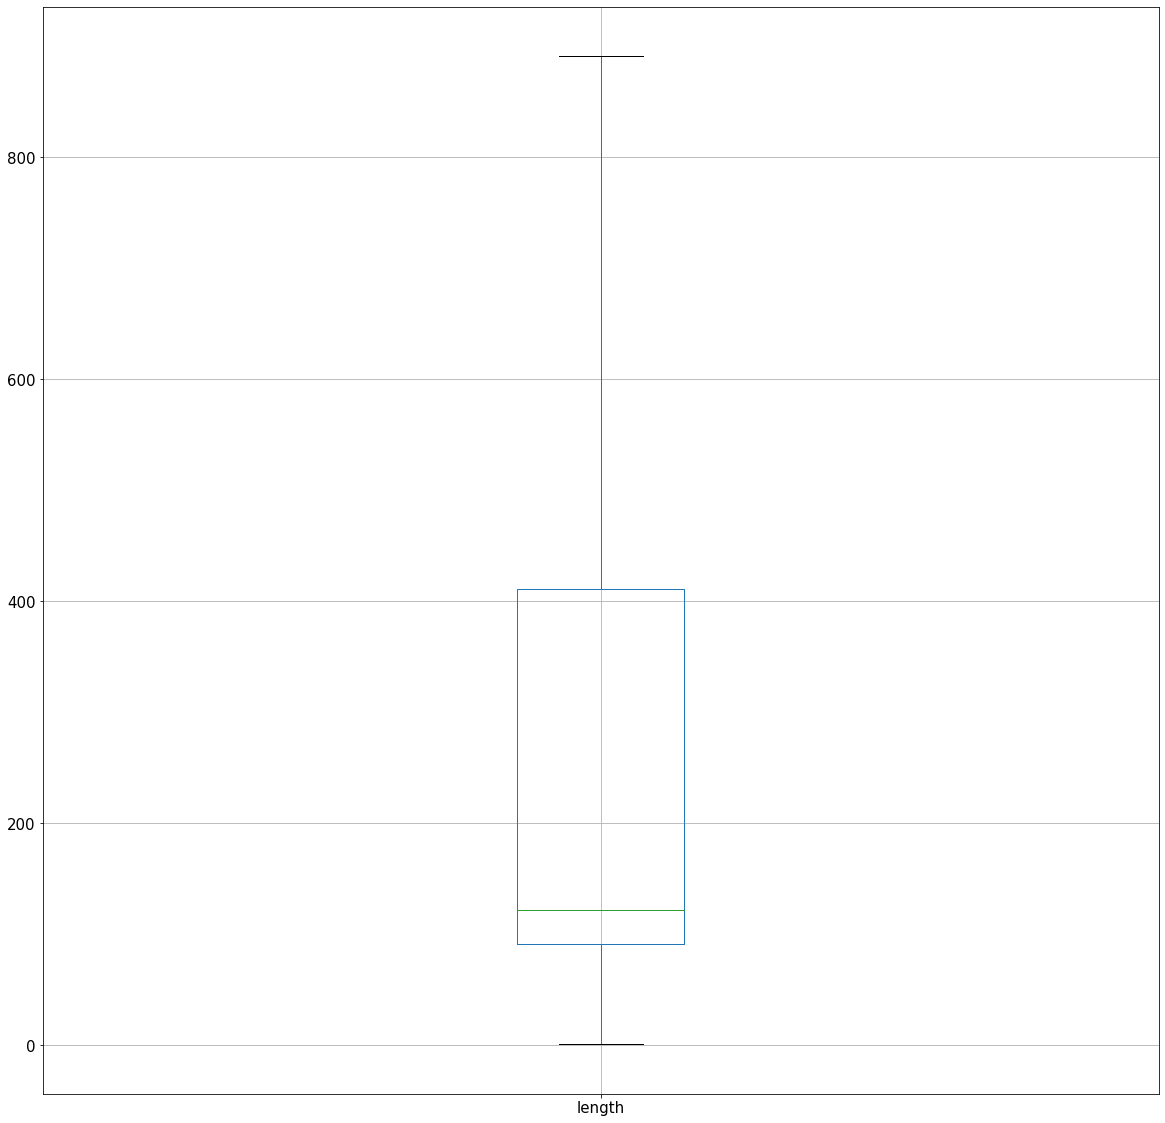

In [841]:
### --- Plotting the boxplot of ZDM02064 introns length without outliers
introns_ZDM02064.boxplot(column='length', return_type='axes', showfliers=False) # showfliers = False -> discard outliers

### 3.24.4 Re-organizing files and directories

In [842]:
! ls Data/

Akashinriki	HOR10350_gp  HOR8148		raw
B1K		HOR13821     HOR9043		RGT_Planet
Barke		HOR13942     Hv_Morex_longread	ZDM01467
Barke_gp	HOR21599     Igri		ZDM02064_exon.tsv
Golden_Promise	HOR3081      Morex		ZDM02064_nohashtag.csv
Hockett		HOR3365      Morex_gp		ZDM02064_nohashtag.gff3
HOR10350	HOR7552      OUN333


In [843]:
! mkdir Data/ZDM02064

In [844]:
! mv Data/ZDM02064_* Data/ZDM02064

In [845]:
! ls Data/

Akashinriki	Hockett      HOR21599  HOR9043		  OUN333
B1K		HOR10350     HOR3081   Hv_Morex_longread  raw
Barke		HOR10350_gp  HOR3365   Igri		  RGT_Planet
Barke_gp	HOR13821     HOR7552   Morex		  ZDM01467
Golden_Promise	HOR13942     HOR8148   Morex_gp		  ZDM02064


In [846]:
! ls Output/

Akashinriki	HOR10350_gp  HOR8148		RGT_Planet
B1K		HOR13821     HOR9043		ZDM01467
Barke		HOR13942     Hv_Morex_longread	ZDM02064_intronlessIDs.txt
Barke_gp	HOR21599     Igri		ZDM02064_intronpoorIDs.txt
Golden_Promise	HOR3081      Morex		ZDM02064_intronrichIDs.txt
Hockett		HOR3365      Morex_gp		ZDM02064_introns.tsv
HOR10350	HOR7552      OUN333


In [847]:
! mkdir Output/ZDM02064

In [848]:
! mv Output/ZDM02064_* Output/ZDM02064

In [849]:
! ls Output/

Akashinriki  Golden_Promise  HOR13821  HOR3365	Hv_Morex_longread  OUN333
B1K	     Hockett	     HOR13942  HOR7552	Igri		   RGT_Planet
Barke	     HOR10350	     HOR21599  HOR8148	Morex		   ZDM01467
Barke_gp     HOR10350_gp     HOR3081   HOR9043	Morex_gp	   ZDM02064


# 4 Extracting from fasta the corresponding introns UTR sequences in Hv_MorexHC

In [850]:
### --- Re-generating the full UTR introns dataframe
introns_UTR_forw_Hv_MorexHC, introns_UTR_rev_Hv_MorexHC = pd.read_csv('Output/Hv_Morex_longread/Hv_MorexHC_UTRforw_introns.tsv', sep='\t'), pd.read_csv('Output/Hv_Morex_longread/Hv_MorexHC_UTRrev_introns.tsv', sep = '\t')
frames_Hv_MorexHC = [introns_UTR_forw_Hv_MorexHC, introns_UTR_rev_Hv_MorexHC]
introns_UTR_Hv_MorexHC = pd.concat(frames_Hv_MorexHC).reset_index(drop=True)
introns_UTR_Hv_MorexHC

,ID,type,start,end,length
0,ID=HORVU.MOREX.r3.1HG0000070.1,intron five_prime_UTR,146750,146980,232
1,ID=HORVU.MOREX.r3.1HG0000080.1,intron five_prime_UTR,153530,153625,97
2,ID=HORVU.MOREX.r3.1HG0000620.1,intron five_prime_UTR,1614154,1615780,1628
3,ID=HORVU.MOREX.r3.1HG0000620.2,intron five_prime_UTR,1614154,1615780,1628
4,ID=HORVU.MOREX.r3.1HG0000620.3,intron five_prime_UTR,1614665,1615780,1117
...,...,...,...,...,...
5044,ID=HORVU.MOREX.r3.7HG0752050.1,intron five_prime_UTR,628813527,628813619,94
5045,ID=HORVU.MOREX.r3.7HG0752790.1,intron three_prime_UTR,631981108,631981202,96
5046,ID=HORVU.MOREX.r3.7HG0752950.1,intron five_prime_UTR,632146924,632147308,386
5047,ID=HORVU.MOREX.r3.UnG0753140.1,intron five_prime_UTR,475717,475945,230


In [851]:
### --- Downloading the fast from we will extract the sequences corresponding to the introns UTR.
### --- The next line has been commented due to the fact I previously downloaded this file. 

! wget -O Data/raw/Barley_MorexV3_pseudomolecules.fasta https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/b6e6a2e5-2746-4522-8465-019c8f56df7f/1/DOWNLOAD

--2021-10-01 12:35:06--  https://doi.ipk-gatersleben.de/DOI/b2f47dfb-47ff-4114-89ae-bad8dcc515a1/b6e6a2e5-2746-4522-8465-019c8f56df7f/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4296032540 (4,0G) [text/plain]
Saving to: ‘Data/raw/Barley_MorexV3_pseudomolecules.fasta’

Data/raw/Barley_Mor 100%[===================>]   4,00G  2,22MB/s    in 37m 15s 

2021-10-01 13:12:21 (1,83 MB/s) - ‘Data/raw/Barley_MorexV3_pseudomolecules.fasta’ saved [4296032540/4296032540]



In [852]:
### --- Check the file just downloaded 
! head Data/raw/Barley_MorexV3_pseudomolecules.fasta

>chr1H
GTTCCCGCTTCGATCCAAACATTTCGAGAACCAGGGGTCCGGTTATGTGGAACTCGTCAA
AACACGCAGTTTTGGCCTATTCCGGCGAGTTTAGTAAGGTACTACTCACTGATTTTGGTT
GCCCCTATGATTCGAACGTTTTGGGAACCCCGAGGTCCGATTACGGGGAACTCGTCAAAA
CTCACAGTTTTGTCCTATTCTGGCCAGTTTTGTATGCTATTACTCACTGATTTTGGGTCC
CGCTGTGATCGAACTTTTCGGAAACCCCAGGTTTCGGGTCCGGTTACGGGGAACTCGTCA
AAACTCACAGTTTTGGTCTATTCCGGCCAGTTTTGTTCGCTATTAGTCACTGATTTTGGG
TCGTGGTGCCATCCGAACGTTTCGTGAACCCCGGGGTCGAGTTATGGGGAAATCATGAAA
ACTCGCAGTTTTGGCCTTTTCCCCCAGTTTTTTATGCTATTACTCACTGATTTTAGGTCC
CACTGCGATACAAATTTCTCAAGAACCGAGGGGTCCGGTTACCTGGAACTCATCGAAACA


In [853]:
### --- Check where the occurence of >chr_number are within the file
! grep -n '>chr' Data/raw/Barley_MorexV3_pseudomolecules.fasta

1:>chr1H
8608435:>chr2H
19701532:>chr3H
30060142:>chr4H
40232369:>chr5H
50036015:>chr6H
59399258:>chr7H
69941602:>chrUn


In [854]:
### --- Based on the previous output divide the total fasta in smaller fasta containing information about 1 chromosome each
### --- I directly run them from the terminal and not within the Notebook due to the fact within the Notebook I obtained a Broken pipe error

! head -8608434 Data/raw/Barley_MorexV3_pseudomolecules.fasta > Data/Barley_MorexV3_pseudomolecules_chr1.fasta
! tail -n +8608435 Data/raw/Barley_MorexV3_pseudomolecules.fasta | head -11093097 > Data/Barley_MorexV3_pseudomolecules_chr2.fasta
! tail -n +19701532 Data/raw/Barley_MorexV3_pseudomolecules.fasta | head -10358610 > Data/Barley_MorexV3_pseudomolecules_chr3.fasta
! tail -n +30060142 Data/raw/Barley_MorexV3_pseudomolecules.fasta | head -10172227 > Data/Barley_MorexV3_pseudomolecules_chr4.fasta
! tail -n +40232369 Data/raw/Barley_MorexV3_pseudomolecules.fasta | head -9803646 > Data/Barley_MorexV3_pseudomolecules_chr5.fasta
! tail -n +50036015 Data/raw/Barley_MorexV3_pseudomolecules.fasta | head -9363243 > Data/Barley_MorexV3_pseudomolecules_chr6.fasta
! tail -n +59399258 Data/raw/Barley_MorexV3_pseudomolecules.fasta | head -10542344 > Data/Barley_MorexV3_pseudomolecules_chr7.fasta
! tail -n +69941602 Data/raw/Barley_MorexV3_pseudomolecules.fasta > Data/Barley_MorexV3_pseudomolecules_chrUn.fasta

tail: error writing 'standard output': Broken pipe
tail: error writing 'standard output': Broken pipe
tail: error writing 'standard output': Broken pipe
tail: error writing 'standard output': Broken pipe
tail: error writing 'standard output': Broken pipe
tail: error writing 'standard output': Broken pipe


In [855]:
### --- Writing the dataframe to a tsv file
introns_UTR_Hv_MorexHC.to_csv('Output/Hv_Morex_longread/Hv_MorexHC_UTRtot.tsv', sep='\t', header = True, index=False)

In [856]:
! head Output/Hv_Morex_longread/Hv_MorexHC_UTRtot.tsv

ID	type	start	end	length
ID=HORVU.MOREX.r3.1HG0000070.1	intron five_prime_UTR	146750	146980	232
ID=HORVU.MOREX.r3.1HG0000080.1	intron five_prime_UTR	153530	153625	97
ID=HORVU.MOREX.r3.1HG0000620.1	intron five_prime_UTR	1614154	1615780	1628
ID=HORVU.MOREX.r3.1HG0000620.2	intron five_prime_UTR	1614154	1615780	1628
ID=HORVU.MOREX.r3.1HG0000620.3	intron five_prime_UTR	1614665	1615780	1117
ID=HORVU.MOREX.r3.1HG0000670.1	intron five_prime_UTR	1725555	1726142	589
ID=HORVU.MOREX.r3.1HG0000990.1	intron five_prime_UTR	2301295	2301473	180
ID=HORVU.MOREX.r3.1HG0002160.1	intron five_prime_UTR	4509034	4509755	723
ID=HORVU.MOREX.r3.1HG0002160.2	intron five_prime_UTR	4509646	4509755	111


In [857]:
### --- Creating the file with the coordinates 
! cat Output/Hv_Morex_longread/Hv_MorexHC_UTRtot.tsv | tail -n+2 | awk -F '\t' '{print $1,$3, $4}' > Output/Hv_Morex_longread/Hv_MorexHC_UTRintrons_coords.txt

In [858]:
! head Output/Hv_Morex_longread/Hv_MorexHC_UTRintrons_coords.txt

ID=HORVU.MOREX.r3.1HG0000070.1 146750 146980
ID=HORVU.MOREX.r3.1HG0000080.1 153530 153625
ID=HORVU.MOREX.r3.1HG0000620.1 1614154 1615780
ID=HORVU.MOREX.r3.1HG0000620.2 1614154 1615780
ID=HORVU.MOREX.r3.1HG0000620.3 1614665 1615780
ID=HORVU.MOREX.r3.1HG0000670.1 1725555 1726142
ID=HORVU.MOREX.r3.1HG0000990.1 2301295 2301473
ID=HORVU.MOREX.r3.1HG0002160.1 4509034 4509755
ID=HORVU.MOREX.r3.1HG0002160.2 4509646 4509755
ID=HORVU.MOREX.r3.1HG0002450.1 5067209 5067686


In [859]:
### --- Importing a library to check the time spent running processes
from timeit import default_timer as timer

In [860]:
def extract_fasta_from_coords(coordinates, chr1, chr2, chr3, chr4, chr5, chr6, chr7, chrUn, f_out):
    t_zero = timer() # Checking the computational time
    out = open(f_out, 'a')
    with open(coordinates) as coords:
        for line in coords:
            line = line.split()
            seq = ''
            if '.1H' in line[0]:     # Ceck if the coordinates refers to chr1
                first_line = int(line[1])/60 +1     # This is due to the fasta file having 60 characters/row
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)      # Decimal part * 60 to know at which character of the line start
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60    # Same as before but to know where it ends
                with open (chr1) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr1'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')
            
            elif '.2H' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chr2) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr2'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')
            
            elif '.3H' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chr3) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr3'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')

            elif '.4H' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chr4) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr4'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')

            elif '.5H' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chr5) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr5'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')

            elif '.6H' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chr6) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr6'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')
        
            elif '.7H' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chr7) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chr7'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')

            elif '.Un' in line[0]:
                first_line = int(line[1])/60 +1
                last_line = int(line[2])/60 +1
                interval = int(last_line) - int(first_line)
                start = int(float(str(first_line-int(first_line))[1:])*60)
                end = int(float(str(last_line - int(last_line))[1:])*60) + interval*60
                with open (chrUn) as fasta:
                    lines = fasta.readlines()
                    for i in range(int(first_line), int(last_line)+1):
                        f_line = lines[i]
                        f_line = f_line.rstrip()
                        seq += f_line
                    seq = seq[start:end+1]
                    out.write('>chrUn'+':'+line[1]+':'+line[2]+':'+line[0])
                    out.write('\n'+seq+'\n')


    out.close()
    tot = timer() - t_zero
    print('Running time (minutes): %.3f' % (tot/60))


In [861]:
f_out = 'Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta'
coords = 'Output/Hv_Morex_longread/Hv_MorexHC_UTRintrons_coords.txt'
chr1 = 'Data/Barley_MorexV3_pseudomolecules_chr1.fasta'
chr2 = 'Data/Barley_MorexV3_pseudomolecules_chr2.fasta'
chr3 = 'Data/Barley_MorexV3_pseudomolecules_chr3.fasta'
chr4 = 'Data/Barley_MorexV3_pseudomolecules_chr4.fasta'
chr5 = 'Data/Barley_MorexV3_pseudomolecules_chr5.fasta'
chr6 = 'Data/Barley_MorexV3_pseudomolecules_chr6.fasta'
chr7 = 'Data/Barley_MorexV3_pseudomolecules_chr7.fasta'
chrUn = 'Data/Barley_MorexV3_pseudomolecules_chrUn.fasta'

In [862]:
extract_fasta_from_coords(coords, chr1, chr2, chr3, chr4, chr5, chr6, chr7, chrUn, f_out)

Running time (minutes): 111.002


In [863]:
! head Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta

>chr1:146750:146980:ID=HORVU.MOREX.r3.1HG0000070.1
TACGTACTCACTCGTGTCCTCCTCGGATGCGCTACTCTGCCTCTGCTCAAGCCTAGCTCCAAATCGGAGATCAGATCGGATCGGACCAGATCTTGTTTTCTTTCTTTCTTTCTTCTTCAAGATCCCGATCCCCGCCACCCTAAACACACCACACCACACCACGCGTCGCCGACGAATTCGTCCCAAGACTTGTCCACACGGAAATCCATCGGTTTGTTCTGCTTCTTCAG
>chr1:153530:153625:ID=HORVU.MOREX.r3.1HG0000080.1
TACCTACCACTTCACTTCAGTTCAACCTGATGCTGAATGTGAATTCAGTCCACACTCACACTCACTAATTCAGTTCAAACTGATGTTTTTTGCAG
>chr1:1614154:1615780:ID=HORVU.MOREX.r3.1HG0000620.1
GTGAGCGCCGCACTCCTCCCCCGATTCGCGCCTCGTCCCTGCCTTGAAGCCAAGATCAGTTTTTTATTTACTTGCTTGGCATAAGCAACTTCCCCCTCTCCTCTCCTCTCTTGCGTGCGGCCGCGGGTTGCTTGCAGTGCGGGGGAAGGAGGATGGAGAGGAAGGAGAAGTGGTGGGATGGGGATGTGGATTTCTTTGTTTGTTTGCTTGCTTTCTGCAGTGAAGGTCGGGATTGGAATCGCGGCCGCGGCGCTGGCTTTGCCTTGCTCCTCAGCTTATGCTTCTCCCTCTTCCTTCCCTTCCGCCGGGGGAGAAGCAACCGGCACGGCTGCTCTCCCCTCCCCTGCTTAGCCGCCTATTTCAACCCAGTTCATGGCCTAGTCACCACCACCACAACACAAGCTGCTGCTGCTGCTGCTGCTCCCACATTACTCCTCCACCAACCCCCACAAACCCTAGCTTCTTCTTCCTCCTCCTCTGCTCCCTCTTCTTCTTGTTCTTGCTGCTGCTGGTGAGTC

# 5 Blasting the extracted sequences toward the 20 genome of the gene_projection directory within the pan-genome study

In [864]:
# This is needed to install local BLAST is not already installed
# Uncomment the following to make it run

# sudo apt-get install ncbi-blast+

In [865]:
### --- Downloading cds.fasta of the 20 genome of the pangenome study contained in the gene_projection directory
! wget -O Data/Akashinriki/Akashinriki.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/ebaa1e2d-e3a0-4353-a23d-399740c503cb/1/DOWNLOAD
! wget -O Data/B1K/B1K.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/e8736e9b-893f-4bd0-8e82-f46975819d97/1/DOWNLOAD
! wget -O Data/Barke_gp/Barke_gp.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/dc5b1041-4d3a-4324-9252-e6ce2aab2854/1/DOWNLOAD
! wget -O Data/Golden_Promise/Golden_Promise.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/7e11b599-d142-4eb4-bac0-20aec793a95f/1/DOWNLOAD
! wget -O Data/Hockett/Hockett.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/9f1e0fb5-ea24-431c-9888-c777c53b9e36/1/DOWNLOAD
! wget -O Data/HOR10350_gp/HOR10350_gp.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/9584516c-393d-482b-a9f8-b8c81932cf7c/1/DOWNLOAD
! wget -O Data/HOR13821/HOR13821.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/cbe49c93-fd2b-4e3a-94ff-eb65e87c9c2e/1/DOWNLOAD
! wget -O Data/HOR13942/HOR13942.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/953362d2-cb3d-4aa7-bdc6-878c356379ee/1/DOWNLOAD
! wget -O Data/HOR21599/HOR21599.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/3c8b0f43-a125-4008-8dc2-7c52bedd6bd9/1/DOWNLOAD
! wget -O Data/HOR3081/HOR3081.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/7ffd1f73-0d68-42ea-b8b4-a1cc3b265303/1/DOWNLOAD
! wget -O Data/HOR3365/HOR3365.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/49cf0f92-692c-4c72-b6d7-933a74d1b9d2/1/DOWNLOAD
! wget -O Data/HOR7552/HOR7552.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/473af275-bc69-476f-9d89-320261caa9cf/1/DOWNLOAD
! wget -O Data/HOR8148/HOR8148.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/f7358a73-1a6e-4c3b-9a25-73651ea486bc/1/DOWNLOAD
! wget -O Data/HOR9043/HOR9043.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/32caa1cd-19ee-416c-8fcc-c3a78f18f89b/1/DOWNLOAD
! wget -O Data/Igri/Igri.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/af253083-ebd3-459a-9fe8-b1257ccc7aab/1/DOWNLOAD
! wget -O Data/Morex_gp/Morex_gp.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/fad42b36-9503-462b-9b39-fe6c431c5caa/1/DOWNLOAD
! wget -O Data/OUN333/OUN333.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/6e097aae-16b4-4f9d-a02f-8f4c96b9f85e/1/DOWNLOAD
! wget -O Data/RGT_Planet/RGT_Planet.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/c7f4868c-15c7-4435-8cf0-4341b7aad14b/1/DOWNLOAD
! wget -O Data/ZDM01467/ZDM01467.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/97c4fcfc-8510-4ac1-a879-668927c0f566/1/DOWNLOAD
! wget -O Data/ZDM02064/ZDM02064.cds.fasta https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/c28021d8-dc64-4127-ab48-d259583cbbc5/1/DOWNLOAD

--2021-10-01 15:05:27--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/ebaa1e2d-e3a0-4353-a23d-399740c503cb/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48684804 (46M) [text/plain]
Saving to: ‘Data/Akashinriki/Akashinriki.cds.fasta’

Data/Akashinriki/Ak 100%[===================>]  46,43M  2,06MB/s    in 22s     

2021-10-01 15:05:50 (2,09 MB/s) - ‘Data/Akashinriki/Akashinriki.cds.fasta’ saved [48684804/48684804]

--2021-10-01 15:05:50--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/e8736e9b-893f-4bd0-8e82-f46975819d97/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK


Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49403158 (47M) [text/plain]
Saving to: ‘Data/HOR9043/HOR9043.cds.fasta’

Data/HOR9043/HOR904 100%[===================>]  47,11M  1,66MB/s    in 26s     

2021-10-01 15:12:03 (1,82 MB/s) - ‘Data/HOR9043/HOR9043.cds.fasta’ saved [49403158/49403158]

--2021-10-01 15:12:04--  https://doi.ipk-gatersleben.de/DOI/c4d433dc-bf7c-4ad9-9368-69bb77837ca5/af253083-ebd3-459a-9fe8-b1257ccc7aab/1/DOWNLOAD
Resolving doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)... 194.94.136.144
Connecting to doi.ipk-gatersleben.de (doi.ipk-gatersleben.de)|194.94.136.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49687390 (47M) [text/plain]
Saving to: ‘Data/Igri/Igri.cds.fasta’

Data/Igri/Igri.cds. 100%[===================>]  47,38M  1,83MB/s    in 30s     

2021-10-01 15:12:34 (1,57 MB/s) - ‘Data/Igri/Igri.cds.fasta’ saved [49687390/4968

In [866]:
### --- Making a database for each of the fasta previously downloaded
! makeblastdb -in Data/Akashinriki/Akashinriki.cds.fasta -dbtype nucl -parse_seqids -out Data/Akashinriki/Akashinriki_db
! makeblastdb -in Data/B1K/B1K.cds.fasta -dbtype nucl -parse_seqids -out Data/B1K/B1K_db
! makeblastdb -in Data/Barke_gp/Barke_gp.cds.fasta -dbtype nucl -parse_seqids -out Data/Barke_gp/Barke_gp_db
! makeblastdb -in Data/Golden_Promise/Golden_Promise.cds.fasta -dbtype nucl -parse_seqids -out Data/Golden_Promise/Golden_Promise_db
! makeblastdb -in Data/Hockett/Hockett.cds.fasta -dbtype nucl -parse_seqids -out Data/Hockett/Hockett_db
! makeblastdb -in Data/HOR10350_gp/HOR10350_gp.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR10350_gp/HOR10350_gp_db
! makeblastdb -in Data/HOR13821/HOR13821.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR13821/HOR13821_db
! makeblastdb -in Data/HOR13942/HOR13942.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR13942/HOR13942_db
! makeblastdb -in Data/HOR21599/HOR21599.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR21599/HOR21599_db
! makeblastdb -in Data/HOR3081/HOR3081.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR3081/HOR3081_db
! makeblastdb -in Data/HOR3365/HOR3365.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR3365/HOR3365_db
! makeblastdb -in Data/HOR7552/HOR7552.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR7552/HOR7552_db
! makeblastdb -in Data/HOR8148/HOR8148.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR8148/HOR8148_db
! makeblastdb -in Data/HOR9043/HOR9043.cds.fasta -dbtype nucl -parse_seqids -out Data/HOR9043/HOR9043_db
! makeblastdb -in Data/Igri/Igri.cds.fasta -dbtype nucl -parse_seqids -out Data/Igri/Igri_db
! makeblastdb -in Data/Morex_gp/Morex_gp.cds.fasta -dbtype nucl -parse_seqids -out Data/Morex_gp/Morex_gp_db
! makeblastdb -in Data/OUN333/OUN333.cds.fasta -dbtype nucl -parse_seqids -out Data/OUN333/OUN333_db
! makeblastdb -in Data/RGT_Planet/RGT_Planet.cds.fasta -dbtype nucl -parse_seqids -out Data/RGT_Planet/RGT_Planet_db
! makeblastdb -in Data/ZDM01467/ZDM01467.cds.fasta -dbtype nucl -parse_seqids -out Data/ZDM01467/ZDM01467_db
! makeblastdb -in Data/ZDM02064/ZDM02064.cds.fasta -dbtype nucl -parse_seqids -out Data/ZDM02064/ZDM02064_db




Building a new DB, current time: 10/01/2021 15:15:20
New DB name:   /home/barley/Test/Data/Akashinriki/Akashinriki_db
New DB title:  Data/Akashinriki/Akashinriki.cds.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 44446 sequences in 1.08591 seconds.


Building a new DB, current time: 10/01/2021 15:15:21
New DB name:   /home/barley/Test/Data/B1K/B1K_db
New DB title:  Data/B1K/B1K.cds.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 44566 sequences in 0.982622 seconds.


Building a new DB, current time: 10/01/2021 15:15:23
New DB name:   /home/barley/Test/Data/Barke_gp/Barke_gp_db
New DB title:  Data/Barke_gp/Barke_gp.cds.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 45999 sequences in 1.03298 seconds.


Building a new DB, current time: 10/01/2021 15:15:24
New DB name:   /home/barley/Test/Data/Go

In [867]:
### --- Blasting my query towards each of the database previously created
### --- Default outfmt values "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore"
### --- https://www.metagenomics.wiki/tools/blast/blastn-output-format-6
! blastn -db Data/Akashinriki/Akashinriki_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/Akashinriki/results_Akashinriki.out
! blastn -db Data/B1K/B1K_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/B1K/results_B1K.out
! blastn -db Data/Barke_gp/Barke_gp_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/Barke_gp/results_Barke_gp.out
! blastn -db Data/Golden_Promise/Golden_Promise_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/Golden_Promise/results_Golden_Promise.out
! blastn -db Data/Hockett/Hockett_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/Hockett/results_Hockett.out
! blastn -db Data/HOR10350_gp/HOR10350_gp_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR10350_gp/results_HOR10350_gp.out
! blastn -db Data/HOR13821/HOR13821_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR13821/results_HOR13821.out
! blastn -db Data/HOR13942/HOR13942_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR13942/results_HOR13942.out
! blastn -db Data/HOR21599/HOR21599_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR21599/results_HOR21599.out
! blastn -db Data/HOR3081/HOR3081_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR3081/results_HOR3081.out
! blastn -db Data/HOR3365/HOR3365_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR3365/results_HOR3365.out
! blastn -db Data/HOR7552/HOR7552_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR7552/results_HOR7552.out
! blastn -db Data/HOR8148/HOR8148_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR8148/results_HOR8148.out
! blastn -db Data/HOR9043/HOR9043_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/HOR9043/results_HOR9043.out
! blastn -db Data/Igri/Igri_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/Igri/results_Igri.out
! blastn -db Data/Morex_gp/Morex_gp_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/Morex_gp/results_Morex_gp.out
! blastn -db Data/OUN333/OUN333_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/OUN333/results_OUN333.out
! blastn -db Data/RGT_Planet/RGT_Planet_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/RGT_Planet/results_RGT_Planet.out
! blastn -db Data/ZDM01467/ZDM01467_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/ZDM01467/results_ZDM01467.out
! blastn -db Data/ZDM02064/ZDM02064_db -query Output/Hv_Morex_longread/Hv_MorexHC_UTR_introns.fasta -outfmt 6 -out Output/ZDM02064/results_ZDM02064.out

# Extract hits among the 20 genomes

In [868]:
### --- Checking how many hits are within every blastn result
! wc -l Output/*/results_*.out | sort -g

    8492 Output/Golden_Promise/results_Golden_Promise.out
    9138 Output/Akashinriki/results_Akashinriki.out
    9329 Output/HOR7552/results_HOR7552.out
    9351 Output/HOR9043/results_HOR9043.out
    9390 Output/OUN333/results_OUN333.out
    9406 Output/HOR13942/results_HOR13942.out
    9453 Output/HOR21599/results_HOR21599.out
    9465 Output/HOR8148/results_HOR8148.out
    9467 Output/ZDM01467/results_ZDM01467.out
    9515 Output/HOR3365/results_HOR3365.out
    9674 Output/HOR13821/results_HOR13821.out
    9826 Output/Morex_gp/results_Morex_gp.out
    9874 Output/RGT_Planet/results_RGT_Planet.out
    9899 Output/HOR3081/results_HOR3081.out
    9986 Output/Igri/results_Igri.out
   10313 Output/Hockett/results_Hockett.out
   10315 Output/ZDM02064/results_ZDM02064.out
   10525 Output/HOR10350_gp/results_HOR10350_gp.out
   10542 Output/B1K/results_B1K.out
   10809 Output/Barke_gp/results_Barke_gp.out
  194769 total


In [869]:
### --- This function is meant to extract the query seq-id giving hits
def extract_blast_hits(blast_out):
    hits = []
    with open(blast_out) as f:
        for line in f:
            line = line.split()
            hit = line[0].split(':')[3] # Extracting the Hv_MorexHC ID
            if hit in hits: continue
            hits.append(hit)
    return hits

In [870]:
blast_out_list = ! ls Output/*/results_*.out 
blast_out_list

['Output/Akashinriki/results_Akashinriki.out',
 'Output/B1K/results_B1K.out',
 'Output/Barke_gp/results_Barke_gp.out',
 'Output/Golden_Promise/results_Golden_Promise.out',
 'Output/Hockett/results_Hockett.out',
 'Output/HOR10350_gp/results_HOR10350_gp.out',
 'Output/HOR13821/results_HOR13821.out',
 'Output/HOR13942/results_HOR13942.out',
 'Output/HOR21599/results_HOR21599.out',
 'Output/HOR3081/results_HOR3081.out',
 'Output/HOR3365/results_HOR3365.out',
 'Output/HOR7552/results_HOR7552.out',
 'Output/HOR8148/results_HOR8148.out',
 'Output/HOR9043/results_HOR9043.out',
 'Output/Igri/results_Igri.out',
 'Output/Morex_gp/results_Morex_gp.out',
 'Output/OUN333/results_OUN333.out',
 'Output/RGT_Planet/results_RGT_Planet.out',
 'Output/ZDM01467/results_ZDM01467.out',
 'Output/ZDM02064/results_ZDM02064.out']

In [871]:
### --- This is meant to run the function extract_blast_hits on all the genomes and create 20 variables storing the list of unique IDs
### --- Furthemore I convert the list to a set
for x in (blast_out_list):
    globals()['hits_%s' % x.split('/')[1]] = extract_blast_hits(x)
    globals()['hits_%s' % x.split('/')[1]] = set(globals()['hits_%s' % x.split('/')[1]])

In [872]:
# Set does not allow duplicates, all duplicates converting a list to a set will be removed

In [873]:
### --- Using sets I can use the intersection function already implented saving only elements common to all sets taken under examination
common_hits = hits_Akashinriki.intersection(hits_B1K,hits_Barke_gp, hits_Golden_Promise,hits_Hockett, hits_HOR10350_gp, hits_HOR13821, hits_HOR13942, hits_HOR21599, hits_HOR3081, hits_HOR3365, hits_HOR7552, hits_HOR8148, hits_HOR9043, hits_Igri, hits_Morex_gp, hits_OUN333, hits_RGT_Planet, hits_ZDM01467, hits_ZDM02064)
pd.DataFrame(common_hits).rename(columns = {0: 'ID'}).to_csv('Output/common_blast_hits.txt', index = False, header = False)

In [874]:
! cat Output/common_blast_hits.txt | sort -u | wc -l

246


In [875]:
### --- Building a separate dataframe containing all genes
gene_Morex = df_Morex.loc[df_Morex['type'].isin(['gene'])]
gene_Morex.head()

,chr,source,type,start,end,score,strand,phase,attributes
0,chr1H,PGSB,gene,129733,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010
6,chr1H,PGSB,gene,142445,147518,.,+,.,ID=HORVU.MOREX.r2.1HG0000020
30,chr1H,PGSB,gene,154960,159625,.,+,.,ID=HORVU.MOREX.r2.1HG0000030
40,chr1H,PGSB,gene,161665,164314,.,+,.,ID=HORVU.MOREX.r2.1HG0000040
54,chr1H,PGSB,gene,165513,168763,.,-,.,ID=HORVU.MOREX.r2.1HG0000050


In [876]:
gene_Morex['length'] = gene_Morex['end'] - gene_Morex['start']
gene_Morex

<ipython-input-876-2b59350883fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_Morex['length'] = gene_Morex['end'] - gene_Morex['start']


,chr,source,type,start,end,score,strand,phase,attributes,length
0,chr1H,PGSB,gene,129733,130419,.,+,.,ID=HORVU.MOREX.r2.1HG0000010,686
6,chr1H,PGSB,gene,142445,147518,.,+,.,ID=HORVU.MOREX.r2.1HG0000020,5073
30,chr1H,PGSB,gene,154960,159625,.,+,.,ID=HORVU.MOREX.r2.1HG0000030,4665
40,chr1H,PGSB,gene,161665,164314,.,+,.,ID=HORVU.MOREX.r2.1HG0000040,2649
54,chr1H,PGSB,gene,165513,168763,.,-,.,ID=HORVU.MOREX.r2.1HG0000050,3250
...,...,...,...,...,...,...,...,...,...,...
518158,chrUn,PGSB,gene,84497721,84497957,.,+,.,ID=HORVU.MOREX.r2.UnG0636540,236
518162,chrUn,PGSB,gene,84589092,84589693,.,-,.,ID=HORVU.MOREX.r2.UnG0636550,601
518168,chrUn,PGSB,gene,84735472,84735666,.,+,.,ID=HORVU.MOREX.r2.UnG0636560,194
518172,chrUn,PGSB,gene,84959376,84960311,.,-,.,ID=HORVU.MOREX.r2.UnG0636570,935


In [877]:
gene_Morex['length'].describe()

count     63658.000000
mean       2018.932954
std        3824.280384
min         149.000000
25%         407.000000
50%         827.000000
75%        2209.000000
max      124652.000000
Name: length, dtype: float64

In [896]:
### --- Function to extract introns from the whole genome and create a GFF3 file
### --- Infile is a file like Hv_MorexHC_exon.tsv 
### --- Outfile will be written thanks to this function
### --- If there are two or more exons belonging to the same mRNA one after the other it compute the introns separating them
def extract_tot_introns_to_gff3(infile, outfile):
    introns = open(outfile, 'a') # Output/Hv_Morex_introns.tsv
    introns.write('##gff-version 3') #+'\n'+'##chr'+'\t'+'source'+'\t'+'type'+'\t'+'start'+'\t'+'end'+'\t'+'score'+'\t'+'strand'+'\t'+'phase'+'\t'+'attributes') 
    with open(infile) as f: # Data/Hv_Morex_exon.tsv
        lines = f.readlines()
        for i in range(0, len(lines)):
            if i+1 == len(lines): # This is to avoid out of range error
                break 
            else:
                line = lines[i]
                line = line.rstrip()
                line = line.split()
                next_line = lines[i+1]
                next_line = lines[i+1].rstrip()
                next_line = lines[i+1].split()
                if '.'.join(line[8].split('.')[0:5]) != '.'.join(next_line[8].split('.')[0:5]): continue # Checking if the next exon has the same ID of the one we are at
                #print('The intron coordinates at %s are from %d to %d and the intron length is %d.' % (line[8][:30], int(line[4])+1, int(next_line[3])-1, int(next_line[3])-1 - int(line[4])+1))
                introns.write('\n'+line[0]+'\t'+ line[1] + '\t'+'intron'+'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+ line[5]+'\t'+line[6]+'\t'+line[7]+'\t'+line[8])
                #introns.write('\n'+ '.'.join(line[8].split('.')[0:5])+'\t'+ 'intron ' +'\t'+str(int(line[4])+1)+'\t'+str(int(next_line[3])-1)+'\t'+str(int(next_line[3])-1-int(line[4])+1))
    introns.close()


In [893]:
### --- Creating the GFF3 file for introns within Hv_Morex long read assembly
extract_tot_introns_to_gff3('Data/Hv_Morex_longread/Hv_Morex_exon.tsv', 'Output/Hv_Morex_longread/Hv_Morex_introns.gff3')

In [895]:
### --- This is not needed to have a correct GFF3 file but I added anyway copy-pasting the regions within the Hv_Morex.gff3 file previously downloaded
! sed -i "2s/^/##sequence-region   chr1H 49526 516432357\n##sequence-region   chr2H 57962 665578891\n##sequence-region   chr3H 71149 621501196\n##sequence-region   chr4H 88699 610216617\n##sequence-region   chr5H 109094 587922891\n##sequence-region   chr6H 33309 561777285\n##sequence-region   chr7H 120080 632310581\n##sequence-region   chrUn 105767 29108162\n/" Output/Hv_Morex_longread/Hv_Morex_introns.gff3